In [144]:
import cv2
import os
import pandas as pd
from datetime import datetime
from dateutil import tz
from PIL import Image as im
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import trange, tqdm
from time import sleep
import webbrowser


In [145]:
import torch.utils.data as data
import torch
from PIL import Image
import os
import os.path
from torchvision import transforms
def default_loader(path):
	return Image.open(path).convert('RGB')

def default_flist_reader(flist):
	"""
	flist format: impath label\nimpath label\n ...(same to caffe's filelist)
	"""
	imlist = []
	with open(flist, 'r') as rf:
		for line in rf.readlines():
			impath, imlabel = line.strip().split()
			imlist.append( (impath, imlabel) )
					
	return imlist

class ImageFilelist(data.Dataset):
	def __init__(self, root, flist, transform=None, target_transform=None,
			flist_reader=default_flist_reader, loader=default_loader):
		self.root   = root
		self.imlist = flist_reader(flist)		
		self.transform = transform#transforms.Compose([transforms.ToTensor()])
		self.target_transform = target_transform
		self.loader = loader

	def __getitem__(self, index):
		impath, target = self.imlist[index]
		img = self.loader(os.path.join(self.root,impath))
		if self.transform is not None:
			img = self.transform(img)
		if self.target_transform is not None:
			target = self.target_transform(target)
		
		return img, target

	def __len__(self):
		return len(self.imlist)

In [146]:
class Drone2Probe():

    def __init__(self,drone_probe_csv=None,minutes=1,seconds=38,sample = True):
        #r'C:\Users\uria\Downloads\DJI_0030.CSV'
        self.minutes = minutes
        self.seconds = seconds
        self.sample = sample
        if drone_probe_csv is not None:
            self.drone_csv = drone_probe_csv[0]
            self.probe_csv = drone_probe_csv[1]
            self.drone_video_dir = drone_probe_csv[2]
            self.prepare_work_df()

#     @classmethod        
    def add_offset_time(df=None):
        df = self.df_main_drone if df is None else df
        df['UTC']=df['UTC'] + pd.DateOffset(minutes=self.minutes,seconds=self.seconds)
#         print(df['UTC'])
        return df
    
    def prepare_drone(self):
        #dji after conversion
        df_dji = pd.read_csv(self.drone_csv)
        #creating timestamp column with only 10 charts from the original timestamp so it could be identical to the probe df's data
        df_dji['time_align'] = df_dji.apply(lambda x:str(x['DATE'])[:10],axis=1)
        #converting timestamp to UTC time
        df_dji['UTC'] = df_dji.apply(lambda x:datetime.fromtimestamp(int(x['time_align'])),axis=1)
        #convert to time columns
        df_dji['UTC'] = pd.DatetimeIndex(df_dji['UTC'])
#         print(df_dji['UTC'])
        #this is to reduce number of frames for each second
        if self.sample:
            try:
                self.df_main_drone = df_dji.groupby(['UTC']).sample(n=20).copy()
            except ValueError:
                try:
                    self.df_main_drone = df_dji.groupby(['UTC']).sample(n=15).copy()
                except ValueError:
                    try:
                        self.df_main_drone = df_dji.groupby(['UTC']).sample(n=5).copy()
                    except ValueError:
                        self.df_main_drone = df_dji.groupby(['UTC']).sample(n=2).copy()
                        
                
        else:
            self.df_main_drone = df_dji

#         self.df_main_drone = df_dji.copy()
          
    def prepare_probe(self):
        probe_df = pd.read_csv(self.probe_csv,encoding="ISO-8859-1")
        #the Data columns does no include the seconds - the next woe concats the seconds to the time 
        probe_df['full_time'] = probe_df.apply(lambda x:x['Date']+' '+x['Time'],axis=1)
        #convert to time columns
        probe_df['full_time'] = pd.DatetimeIndex(probe_df['full_time'])
        self.df_probe = probe_df.copy()
        self.probe_t_idx = self.df_probe.set_index(pd.DatetimeIndex(self.df_probe['full_time']))
        self.probe_t_idx = self.probe_t_idx.drop(columns = 'full_time')#was added
        self.probe_t_idx['range'] = pd.qcut(self.probe_t_idx.index,5,labels=['Part_A','Part_B','Part_C','Part_D','Part_E'])
        
    def prepare_work_df(self):
        
        def add_offset_time(df=None):
            df = self.df_main_drone if df is None else df
            df['UTC']=df['UTC'] + pd.DateOffset(minutes=self.minutes,seconds=self.seconds)
            return df
        
        cols_to_keep = ['SRTCNT','°C','mmHg','DO %','SPC-uS/cm','pH','ORP mV','BGA-PC ug/L','Chl ug/L','DEP m','Lat','Lon','UTC','range','NAME']
        cols_rename = {'°C':'tempature','DO %':'DO','SPC-uS/cm':'SPC_uS','ORP mV':'ORP_mV','BGA-PC ug/L':'BGA_PC','Chl ug/L':'Chl','DEP m':'DEP'}
        self.prepare_drone()
        self.df_main_drone = add_offset_time()
        self.prepare_probe()
        
        #join only the relavant frames to the probe df
        df_merged = pd.merge(left =  self.probe_t_idx,
            right =  self.df_main_drone,#df_main_drone,
            how = 'right',
            left_on= self.probe_t_idx.index,#'full_time',
            right_on= 'UTC')
            
        

        #create df for process
        self.df_main = df_merged[df_merged['pH'].notna()][cols_to_keep].rename(columns = cols_rename).copy()
        self.df_main = self.df_main.assign(drone_vid_dir = self.drone_video_dir )


    @staticmethod    
    def convert_ranges(df,column,new_col_name,n_groups,legend_lst=False):
        """ convert continues values to categories split by quantiles range
        ARGS:
            column (str) : name of column to analyze
            new_col_name (str) : name of new column to contain values
            n_groups (int) : number of groups to split
            legend_lst (list) : list of string values that would present each group 
                                * list from low to high
                                * list has to be same length of splits
        """
#         df = self.df_main_drone
        if legend_lst ==False:
            df[new_col_name] = pd.qcut(df[column],n_groups,duplicates='drop')
            return df
        else:
            if len(legend_lst)!= n_groups:
                print('n_groups is not equal to legend_lst values number - please fix inputs')
            else:
                df[new_col_name] = pd.qcut(df[column],n_groups,legend_lst)
                return df
            
    def plot_pair(self,df = None,col = None,y_var=None,x_var = None):
        """Plots different Data analysis charts.
            If no value inserted, plots pairplot of all columns.
            If y_var inserted, exacute 1 to n pair plot
            
        ARGS default = optional:
        df (pandas df): df to plot from. default is big join
        col(str): column to plot different plots.
        y_var (str): column to compare pairs to.
        x_var (list): columns to compare y to
          
        """
        
        if df:df = df
        else: df = self.df_main
        var = [x for x in df if x not in ['SRTCNT','Lat','Lon','UTC','range']]    
        if col:  
            plot_type = input('Input plot type:\nFor BoxPlot press 1\nFor distribution plot press 2\n')

            if int(plot_type)==1:
                sns.boxplot(df[col])
                plt.title(f'BoxPlot for {col}')
            elif int(plot_type)==2:
                sns.distplot(df[column])
                plt.title(f'distribution plot for {col}')
            else:
                pass
        elif y_var:
            if x_var:
                sns.pairplot(df,y_vars = y_var,x_vars=x_var)
            else:
                
                x_var = [x for x in var if x not in y_var]
                sns.pairplot(df,y_vars = y_var,x_vars=x_var)
        else:
            sns.pairplot(df,vars=var)
 
    def outlier_removal(self):
        
        df = self.df_main
#         test.df_main_drone['NAME'].dtype == 'b'
        for col in df.columns:
            
            if (col in ['SRTCNT','Lat','Lon','UTC','range']) or (df[col].dtype == 'O'):
                pass
            else:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3-Q1
                high_out = np.around(Q3+1.5*IQR,4)
                low_out = np.around(Q1-1.5*IQR,4)
                temp_df = df[col][(df[col]<low_out) | (df[col]>high_out)].copy()
                if temp_df.shape[0]==0:
                    print(f'No outlier values for {col}: High = {high_out}, Low = {low_out}')

                else:
                    print('\n')
                    print(f'Outlier values for {col}:\nHigh : {high_out}, Low : {low_out}')
                    print(f'{temp_df.shape[0]} rows will be deleted from DF for {col}')

                    user_decision = self.user_input()

                    if user_decision=='plot':
                        self.plot_specific(col,df)
                        user_decision = self.user_input('PROCEED? [yes\\no]\n"s" for upper value user selection\n"q" to quit\n',['yes','no','s','q'])

                    if user_decision=='yes':
                        df = df[(df[col]>low_out) & (df[col]<high_out)].copy()
                        print(f'New df shape:\n{df.shape}')
                    elif user_decision=='s':
                        user_decision = self.user_input('Enter high threshold value in int',values=None)
                        df = df[(df[col]>low_out) & (df[col]<user_decision)].copy()
                        print(f'New df shape:\n{df.shape}')
                    elif user_decision=='no':
                        pass                                           
                    elif user_decision=='q':
                        break
         
                        
            self.df_main = df
       
    
    def plot_specific(self,col,df):
        
        plt.figure(figsize=(15,4))
        plt.subplot(1,2,1)
        plt.title(f'Scatter Plot\n{col}')
        # plt.plot_date(df_time1.index,df_time1['BGA-PC ug/L'])
        sns.scatterplot(df['UTC'],df[col])
        plt.subplot(1,2,2)
        plt.title(f'Histogram\n{col}')
        sns.histplot(df[col],kde=True)
        plt.tight_layout()
        plt.show()
        
    def user_input(self,message='PROCEED? [yes\\no\\plot] -- press q to quit process\n',values = ['yes','no','q','plot']):
        while True:
#             command = input(message).lower()
            if type(values)==list:
                command = input(message).lower()
                if command not in values:
                    print("Not an appropriate choice.")
                else:
                    return command
            else:
                command = input(message)
                return int(command)
            
    
    def __str__(self):

        if len(self.df_main_drone) ==0:
            self.prepare_work_df()
        """prints statistics of main df
            default Main df is big one. change to self.df_main for small one """
        print(f'Columns of Main Dataframe:\n{"-"*26}\n{self.df_main_drone.columns.values}\n')
        print(f'Statistics about numerical columns in Dataframe:\n{"-"*48}\n{self.df_main_drone.describe()}')
        return "member of Drone2Probe"
    
        
    def plot_main(self):
        plt.figure(figsize=(15,12))
        ax1 = plt.subplot(4,1,1)
        ax2 = plt.subplot(4,2,3)
        ax3 = plt.subplot(4,2,4)
        ax4 = plt.subplot(4,2,5)
        ax5 = plt.subplot(4,2,6)
        ax6 = plt.subplot(4,2,7)
        ax7 = plt.subplot(4,2,8)
        
        ax1.set_title('Measurment Route')
        sns.scatterplot(self.df_main['Lon'], self.df_main['Lat'],legend='auto',hue=self.df_main['range'],ax=ax1)

        ax2.set_title('Lag Measurment Route')
        sns.scatterplot(self.df_main['Lon'], self.df_main['Lat'],legend='auto',ax=ax2,hue=self.df_main['range'])

        ax3.set_title('Scatter Plot\nBGA-PC ug/L')
        sns.scatterplot(self.df_main['UTC'],self.df_main['BGA_PC'],ax=ax3)#,hue=df['range'])

        ax4.set_title('Scatter Plot\nChl ug/L')
        sns.scatterplot(self.df_main['UTC'],self.df_main['Chl'],ax=ax4)#,hue=df['range'])

        ax5.set_title('BoxPlot\nBGA-PC ug/L')
        sns.boxplot(self.df_main['BGA_PC'],ax=ax5)

        ax6.set_title('Histogram\nBGA-PC ug/L')
        sns.histplot(self.df_main['BGA_PC'],kde=True,ax=ax6)

        ax7.set_title('Histogram\nChl ug/L')
        sns.histplot(self.df_main['Chl'],kde=True,ax=ax7)

        plt.tight_layout()
        plt.show()
        
    @classmethod
    
    def concat_many_df(cls,csv_list,minutes=0,seconds=0,sample=True):
        """Enabels the creation of combined df from different flight legs
        ARGS:
        csv_list (list): list of csv source files in the following structure:
        path_i = [r'path\djicsv.csv',r'path\probe_csv_file.csv']
        csv_list = [path_i,...,path_n]
        
        returns:
        instance of combined df
        To view df, press instance.df_main
        """

        instances_list = [Drone2Probe(drone_probe_csv=i,minutes =minutes,seconds=seconds,sample=sample) for i in csv_list]#      .df_main

        combined_df = pd.concat([i.df_main for i in instances_list] )
        probe_t_idx = pd.concat([i.probe_t_idx for i in instances_list])#df_probe instances_list.probe_t_idx_list)#,pd.concat(df_list),pd.concat(df_list)
        df_main_drone = pd.concat([i.df_main_drone for i in instances_list])#instances_list.df_main_drone)

        instance = Drone2Probe()
        instance.df_main = combined_df
        instance.probe_t_idx = probe_t_idx
        instance.df_main_drone = df_main_drone

        return instance
    
    @classmethod
    def instuctions(cls):
        """instuctions for moduls
        """

        print('For 1 source:')
        print('1: X = Drone2Probe(drone_probe_csv)')
        print('2: x.df_main - main df for probe')
        print('3: x.outlier_removal() - remove outliers')
        print('4: x.plot_main() - plots main factors') 
        print('5: print(x) - statistics on df')
        print('6: x.plot_pair(y_var="BGA_PC",x_var=[...] - plots comparison for selected features)')

    def __add__(self, other):
        df = self.df_main.copy()
        joined_df = pd.concat([df,other.df_main],axis=0)
        self.df_main = joined_df
        return joined_df


In [147]:
class image_processing(Drone2Probe):

    def __init__(self, father_dir,video_dir_path,drone_probe_csv=None,minutes=0,seconds=0,csv_list=None):#contain_dir_lst,
        super().__init__(drone_probe_csv=drone_probe_csv,minutes=minutes,seconds=seconds,sample=sample)
            
        self.father_dir = father_dir
#         self.contain_dir_lst = contain_dir_lst
        self.video_dir_path = video_dir_path
#         self.df_main_drone = self.df_main_drone.reset_index(drop=True)
        
        if csv_list is not None:
            instance = image_processing.concat_many_df(csv_list,minutes=minutes, seconds=seconds)
            self.df_main = instance.df_main
            self.probe_t_idx = instance.probe_t_idx
            self.df_main_drone = instance.df_main_drone
#             self.df_main_drone = self.df_main_drone.reset_index(drop=True)
            
    def folder_create(self,folder,new_father = True):
        if new_father:
            self.new_father = full_path = os.path.join(self.father_dir,folder)
        else:
            full_path = os.path.join(self.new_father,folder)
            
        if not os.path.exists(full_path):
            os.makedirs(full_path)
            
        return full_path
    

    def file_check(self,full_path,file_name):
        file_path = os.path.join(full_path,file_name)
        if os.path.exists(file_path):
            os.remove(file_path)
        return file_path

#         df,father_dir,folder_names,video_path
    @staticmethod    
    def crop_middle(h_w,frame):
        if not h_w: h_w = 100
        crop = frame.copy()
        center = [crop.shape[0] / 2,crop.shape[1] / 2]
        x = center[1] - h_w/2
        y = center[0] - h_w/2
        cropped_img = crop[int(y):int(y+h_w), int(x):int(x+h_w)]
        return cropped_img

    
                            
    def vid2img(self,col,legend_lst=False,n_groups=3,out_dir = None,crop=False,h_w=None,sub=True):
        """(1)Exports video frames to images
        (2) splits the column according to number of groups using quantile range
        ARGS:
            col (str): name of col to export and split according to.
            legend_lst (optional,list) : list of labels for split equals to number of groups
            n_groups (optional,int,Default=4): number of groups for data split.
            out_dir (optional,str): name of output folder.
            crop (boolean,Default=False): crops each image 
            h_w (optional,int): if crop = True, number of pixels for size of image 
            sub (optional,Default=True): run on small amount of images for sanity check
            
        """
        self.df_main_drone_res = self.df_main_drone.reset_index(drop=True)
        df = self.df_main_drone_res.copy()
        
        if not out_dir:
            out_dir = f'{col}_samples'
        upper = None
        if sub:upper=3

            
        full_path_samples = self.folder_create(out_dir)
#         self.vid = cv2.VideoCapture(self.video_path)
        
        new_col = f'{col}_ranged'
        df = self.convert_ranges(df,col,new_col,n_groups,legend_lst)


        for step in trange(n_groups, desc='Full export progression'):
            cat = legend_lst[step-1]
            full_path = self.folder_create(cat,new_father=False)
            df_len = df[df[new_col]==cat].index[:upper].shape[0]
            df_sub = df[df[new_col]==cat][:upper].copy()
       
            
            for idx in tqdm(range(df_len), desc=f'{cat}_process'):
#                 idx = 
# #             for idx in df[df[new_col]==cat].index[:upper]:
#                 frame_no = df.loc[idx,'SRTCNT']#[idx,:]['SRTCNT']
#                 value = df.loc[idx,col]#df.loc[idx,:][col]:][col]
                frame_no = df_sub.iloc[idx,:]['SRTCNT']#[idx,:]['SRTCNT']
                value = df_sub.iloc[idx,:][col]#df.loc[idx,:][col]:][col]
                video_name = df_sub.iloc[idx,:]['NAME']
                video_path = os.path.join(self.video_dir_path,video_name+'.MP4')
#                 print(video_path)
                vid = cv2.VideoCapture(video_path)
                while(True):
#                     self.vid.set(1,frame_no);
                    vid.set(1,frame_no);
                    # Capture the video frame
                    # by frame
#                     ret, frame = self.vid.read()
                    ret, frame = vid.read()

                    file_path = self.file_check(full_path,f'{frame_no}_{value}.jpg')

                    if crop:
                        frame = self.crop_middle(h_w,frame)

                    cv2.imwrite(file_path,frame) 

                    # the 'q' button is set as the quitting button you may use any desired button of your choice
                    if cv2.waitKey(1):# & 0xFF == ord('q'):
                        break
        

        
        webbrowser.open(full_path_samples) # Opens father folder

In [148]:
def range_fill(col,max_val=None,interval=None,usr_lst = None):
    
    def cat_intervals(max_val,interval):
        if not usr_lst:
            ran = np.arange(interval,max_val+1,interval)
        else:
            ran = usr_lst            
        categories = []
        for i,val in enumerate(ran):
            if i==0:
        #       'first'
                label = f'0_{val}'
                categories.append(label)
                label = f'{val+1}_{ran[i+1]}'
                categories.append(label)
            elif i==(len(ran)-1):
        #       'last'
                label = f'{val+1}_above'
                categories.append(label)
            else:
        #        mid values
                label = f'{val+1}_{ran[i+1]}'
                categories.append(label)

        return categories,ran

    categ,ran = cat_intervals(max_val,interval)
    
    min_val = float(min(ran))
    max_val = float(max(ran))
#     x = row[col]
#     print(min_val,max_val,col)
    col = int(col)
    if col<min_val:
        return categ[0]
    elif col>max_val:
        return categ[-1]
    else:
#         for i,range_ in enumerate(categ,1):
        for range_ in categ:
            low,high = range_.split('_')
#             print(col,low,high)
            if col>=int(low) and col<=int(high):
                return range_
        
def range_fill_col2(col,max_val=None,interval=None,usr_lst = None):
    
    def cat_intervals(max_val,interval):
        if not usr_lst:
            ran = np.arange(interval,max_val+1,interval)
        else:
            ran = usr_lst            
        categories = []
        labels = {}
        for i,val in enumerate(ran):
            if i==0:
        #       'first'
                label = f'0_{val}'
                categories.append(label)
                labels[label] = i
                
                label = f'{val+1}_{ran[i+1]}'
                categories.append(label)
                labels[label] = i+1
            elif i==(len(ran)-1):
        #       'last'
                label = f'{val+1}_above'
                categories.append(label)
                labels[label] = i+1
            else:
        #        mid values
                label = f'{val+1}_{ran[i+1]}'
                categories.append(label)
                labels[label] = i+1

        return categories,ran,labels

    categ,ran,labels = cat_intervals(max_val,interval)
#     print(categ,ran,labels)
    min_val = float(min(ran))
    max_val = float(max(ran))
#     x = row[col]
#     print(min_val,max_val,col)
    col = int(col)
    if col<min_val:
        return labels[categ[0]]
    elif col>max_val:
        return labels[categ[-1]]
    else:
#         for i,range_ in enumerate(categ,1):
        for range_ in categ:
            low,high = range_.split('_')
#             print(col,low,high)
            if col>=int(low) and col<=int(high):
                return labels[range_]
        
        
def prepare_to_id(instance=None,col=None,from_df=False,n_sample = None):

    if from_df:
        df = instance.copy()
    else:
        df = instance.df_main.copy()

#     max_val = 100
#     df = df.assign(cat_range = df[col].apply(lambda x:range_fill(x,max_val,10)))
# #     df_main['cat_range'].value_counts()
#     df['unique_id']=df.apply(lambda x:str(x['SRTCNT'])+'_'+str(datetime.timestamp(x['UTC']))[:-2],axis=1)
    df['unique_id']=df.apply(lambda x: str(x['SRTCNT']) + '_' + str(datetime.timestamp(x['UTC']))[:-2], axis=1)
#     if n_sample:
#         df = df.sample(n_sample).copy()

#     user_list = [10,20,40,60,80,98]
    user_list = [5,20,33,45,55,65,80,95]#,106
#     user_list = [10,25,40,55,80,110]
#     user_list = [50,150,250,300,350,400]

    df = df.assign(cat_range = df[col].apply(lambda x:range_fill(x,usr_lst=user_list)))
    df = df.assign(cat_label = df[col].apply(lambda x:range_fill_col2(x,usr_lst=user_list)))
    print(df['cat_range'].value_counts())
    print(df['cat_label'].value_counts())
    return df


In [149]:
import cv2
import os
from tqdm import tqdm

def vid2img_ver3(df, col):
    """Exports video frames to images, allows navigation, and modification of DataFrame columns"""

    # Initialize the key codes
    key_s = ord('n')
    save = ord('s')
    key_esc = 27
    key_b = ord('b')
    key_q = ord('q')

    current_index = 0
    index_vals = {0:['0-5',0],
                  1:['6-20',15],
                  2:['21-33',27],
                  3:['34-45',39],
                  4:['46-55',50],
                  5:['56-65',60],
                  6:['66_80',75],
                  7:['81_95',87],
                  8:['96_above',100]}

    while current_index < df.shape[0]:
        video_name = df.iloc[current_index, :]['NAME']
        video_dir_path = df.iloc[current_index, :]['drone_vid_dir']
        video_path = os.path.join(video_dir_path, video_name + '.MP4')
        cat = df.iloc[current_index, :]['cat_range']
        frame_no = df.iloc[current_index, :]['SRTCNT']
        value = df.iloc[current_index, :][col]
        label = df.iloc[current_index, :]['cat_label']
        unique = df.iloc[current_index, :]['unique_id']
        vid = cv2.VideoCapture(video_path)
        frames = df['SRTCNT']
        while True:
            vid.set(1, frame_no)
            ret, frame = vid.read()

            # Resize the frame and add text annotations
            aspect_ratio = frame.shape[1] / frame.shape[0]
            new_width = 1200
            new_height = int(new_width / aspect_ratio)
            frame = cv2.resize(frame, (new_width, new_height))
            cv2.putText(frame, f'Video: {video_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Category: {cat}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Level: {value}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Label: {label}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Index: {current_index}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow('Frame', frame)
            key = cv2.waitKey(0)

            # Navigate to the previous image on 'b' key press
            if key == key_b:
                current_index -= 1
                if current_index < 0:
                    current_index = 0
                break

            # Skip to next image on 's' key press
            elif key == key_s:
                break

            # Quit the loop on 'Esc' or 'q' key press
            elif key == key_esc or key == key_q:
                cv2.destroyAllWindows()
                return df
                
            
            # Modify the DataFrame on 'm' key press
            elif key == ord('m'):
                new_cat_label = int(input("Enter new cat_label: "))
                new_value = index_vals[new_cat_label][1]
                new_cat_range = index_vals[new_cat_label][0]
                df['cat_label'][df['unique_id']==unique]=new_cat_label
                df[col][df['unique_id']==unique]=new_value
                df['cat_range'][df['unique_id']==unique]=new_cat_range
                print(df.iloc[current_index][col])
                print("Row modified successfully.")
            elif key==save:
                df.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\checked_df.csv')
                print('df saved')
        if key == key_s:
            current_index += 1
    
    cv2.destroyAllWindows()
    return df

In [150]:
import cv2
import os
from tqdm import tqdm

def vid2img_ver4(df, col):
    """Exports video frames to images, allows navigation, and modification of DataFrame columns"""

    # Initialize the key codes
    key_s = ord('n')
    save = ord('s')
    key_esc = 27
    key_b = ord('b')
    key_q = ord('q')

    current_index = 0
    index_vals = {0:['0-5',0],
                  1:['6-15',11],
                  2:['16-27',22],
                  3:['28_38',32],
                  4:['39_48',43],
                  5:['49_64',55],
                  6:['65_79',68],
                  7:['80_94',90],
                  8:['95_119',110],
                 9:['120_above',130]}
    int_keys = [ord('0'),ord('1'),ord('2'),ord('3'),ord('4'),ord('5'),ord('6'),ord('7'),ord('8'),ord('9')]
    while current_index < df.shape[0]:
        video_name = df.iloc[current_index, :]['NAME']
        video_dir_path = df.iloc[current_index, :]['drone_vid_dir']
        video_path = os.path.join(video_dir_path, video_name + '.MP4')
        cat = df.iloc[current_index, :]['cat_range']
        frame_no = df.iloc[current_index, :]['SRTCNT']
        value = df.iloc[current_index, :][col]
        label = df.iloc[current_index, :]['cat_label']
        unique = df.iloc[current_index, :]['unique_id']
        vid = cv2.VideoCapture(video_path)
        frames = df['SRTCNT']
        while True:
            vid.set(1, frame_no)
            ret, frame = vid.read()

            # Resize the frame and add text annotations
            aspect_ratio = frame.shape[1] / frame.shape[0]
            new_width = 1200
            new_height = int(new_width / aspect_ratio)
            frame = cv2.resize(frame, (new_width, new_height))
            cv2.putText(frame, f'Video: {video_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Category: {cat}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Level: {value}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Label: {label}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Index: {current_index}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow('Frame', frame)
            key = cv2.waitKey(0)

            # Navigate to the previous image on 'b' key press
            if key == key_b:
                current_index -= 1
                if current_index < 0:
                    current_index = 0
                break

            # Skip to next image on 's' key press
            elif key == key_s:
                break

            # Quit the loop on 'Esc' or 'q' key press
            elif key == key_esc or key == key_q:
                cv2.destroyAllWindows()
                return df
                
            
            # Modify the DataFrame on 'm' key press
#           # Numeric keys 0-9
      
            elif key in int_keys:
                new_cat_label = int(chr(key))
                new_value = index_vals[new_cat_label][1]
                new_cat_range = index_vals[new_cat_label][0]
                df['cat_label'][df['unique_id']==unique]=new_cat_label
                df[col][df['unique_id']==unique]=new_value
                df['cat_range'][df['unique_id']==unique]=new_cat_range
                print(df.iloc[current_index][col])
                print("Row modified successfully.")

            elif key==save:
                df.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\checked_df.csv')
                print('df saved')
        if key == key_s:
            current_index += 1
    
    cv2.destroyAllWindows()
    return df

#  Create DF's
***

## modify df1

In [21]:
folder_nitzanim = r"C:\Users\urial\BG\AlphaBravo\sampling_data\nitznim\6_12_21"
list_nitzanim = ['DJI_0061.CSV','DJI_0062.CSV','DJI_0063.CSV','DJI_0069.CSV','DJI_0070.CSV','DJI_0071.CSV','DJI_0072.CSV','DJI_0075.CSV','DJI_0076.CSV']
drone_csvs_nitzanim = [os.path.join(folder_nitzanim,i) for i in list_nitzanim]
probe_csv1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21\06_12_nitzanim.csv"
vid_dir1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21"
all_list1 = []
for path in drone_csvs_nitzanim:
    all_list1.append([path,probe_csv1,vid_dir1])
instance_combined_one = Drone2Probe.concat_many_df(all_list1,minutes=-1,seconds = -24,sample=False)


In [22]:
df1= instance_combined_one.df_main.groupby('UTC').sample(1)
df1  = prepare_to_id(df1,'BGA_PC',from_df=True)
df1_mod = vid2img_ver4(df1, 'BGA_PC')


6_20        527
21_33        82
96_above     69
46_55        21
34_45        14
66_80        12
56_65        10
81_95         5
Name: cat_range, dtype: int64
1    527
2     82
8     69
4     21
3     14
6     12
5     10
7      5
Name: cat_label, dtype: int64


In [39]:
df1_mod.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\df1_mod.csv')

In [14]:
df_one_mod.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\df_one.csv')

## modify df2

In [48]:
path = r'C:\Users\urial\BG\AlphaBravo\SRT'
drone_csvs3 = [f'{path}\\DJI_0030.csv']#{str(i)}.csv'] for i in np.arange(21,32,1)]
probe_csv3 = r'C:\Users\urial\BG\AlphaBravo\SRT\df_time_full.csv'
vid_dir3 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone"
all_list1 = []
for path in drone_csvs3:
    all_list1.append([path,probe_csv3,vid_dir3])
instance_combined2 = Drone2Probe.concat_many_df(all_list1,minutes=-1,seconds = -14,sample=False)



In [49]:
df2= instance_combined2.df_main.groupby('UTC').sample(1)
df2  = prepare_to_id(df2,'BGA_PC',from_df=True)
df2_mod = vid2img_ver4(df2, 'BGA_PC')

34_45       32
21_33       28
56_65       16
46_55        9
66_80        8
96_above     2
81_95        2
Name: cat_range, dtype: int64
3    32
2    28
5    16
4     9
6     8
7     2
8     2
Name: cat_label, dtype: int64


In [18]:
df2_mod.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\df2_mod.csv')

## modify df3

In [9]:
drone_csvs2 = [r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Tal Shachar\Drone\DJI_0043.CSV",
r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Tal Shachar\Drone\DJI_0044.CSV"]
probe_csv2 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Tal Shachar\Probe\exobackup-211130-174508.csv"
all_list1 = []
vid_dir2 =  r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Tal Shachar\Drone"
for path in drone_csvs2:
    all_list1.append([path,probe_csv2,vid_dir2])
instance_combined3 = Drone2Probe.concat_many_df(all_list1,minutes=-1,seconds = -14,sample=False)
df3= instance_combined3.df_main.groupby('UTC').sample(1)
df3  = prepare_to_id(df3,'BGA_PC',from_df=True)

0_5    194
Name: cat_range, dtype: int64
0    194
Name: cat_label, dtype: int64


In [10]:
df1 = pd.read_csv(r'C:\Users\urial\BG\AlphaBravo\samples\df1_mod.csv')
df2 = pd.read_csv(r'C:\Users\urial\BG\AlphaBravo\samples\df2_mod.csv')
combined_df = pd.concat([df1,df2,df3])

In [12]:
combined_df.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\combined_df_one_sample.csv')

# Data Preprocess Procedure
***

## Per image examination 

In [188]:
import shutil
import os
# Path to the text file
file_path = r"C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\final_samples\train_index_cat.txt"
detination = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\fixes\completed'
# Iterate over each line in the text file
with open(file_path, "r") as file:
    for line in file:
        line = line.strip().split()  # Split the line by whitespace
        image_path = line[0]  # Image path is the first column
        category = line[1]  # Category is the second column
        
        # Create the category folder if it doesn't exist
        category_folder = os.path.join(detination,category)
        os.makedirs(category_folder, exist_ok=True)

        # Copy the image to the category folder
        shutil.copy(image_path, category_folder)


In [89]:
import cv2
import pandas as pd
import numpy as np

def vid2img(df, col):
    """(1)Exports video frames to images
    (2) splits the column according to number of groups using quantile range
    ARGS:
        col (str): name of col to export and split according to.
        legend_lst (optional,list) : list of labels for split equals to number of groups
        n_groups (optional,int,Default=4): number of groups for data split.
        out_dir (optional,str): name of output folder.
        crop (boolean,Default=False): crops each image 
        h_w (optional,int): if crop = True, number of pixels for size of image 
        sub (optional,Default=True): run on small amount of images for sanity check
    """

    # Randomly shuffle the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    # Initialize the key codes
    key_s = ord('s')
    key_esc = 27

    for idx in tqdm(range(df.shape[0]), desc='Full export progression'):
        video_name = df.iloc[idx,:]['NAME']
        video_dir_path = df.iloc[idx,:]['drone_vid_dir']
        print(video_dir_path, video_name)
        video_path = os.path.join(video_dir_path, video_name + '.MP4')
        cat = df.iloc[idx,:]['cat_range']
        frame_no = df.iloc[idx,:]['SRTCNT']
        value = df.iloc[idx,:][col]
        label = df.loc[idx, 'cat_label']
        # level = df.loc[idx, 'level_of_phenomane']

#                 video_name = df_sub.iloc[idx,:]['NAME']
#                 video_path = os.path.join(self.video_dir_path,video_name+'.MP4')
        vid = cv2.VideoCapture(video_path)

        while True:
            vid.set(1, frame_no)
            ret, frame = vid.read()

            # Resize the frame to a width of 700 pixels while maintaining the aspect ratio
            aspect_ratio = frame.shape[1] / frame.shape[0]
            new_width = 700
            new_height = int(new_width / aspect_ratio)
            frame = cv2.resize(frame, (new_width, new_height))

            cv2.putText(frame, f'Video: {video_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Category: {cat}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Level: {value}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Label: {label}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'frame_no: {frame_no}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow('Frame', frame)
            key = cv2.waitKey(0)

            # Skip to next image on 's' key press
            if key == key_s:
                break
            # Quit the loop on 'Esc' key press
            elif key == key_esc:
                cv2.destroyAllWindows()
                return

    cv2.destroyAllWindows()




In [62]:
folder_nitzanim = r"C:\Users\urial\BG\AlphaBravo\sampling_data\nitznim\6_12_21"
list_nitzanim = ['DJI_0061.CSV']#,'DJI_0062.CSV','DJI_0063.CSV','DJI_0069.CSV','DJI_0070.CSV','DJI_0071.CSV','DJI_0072.CSV','DJI_0075.CSV','DJI_0076.CSV']
drone_csvs_nitzanim = [os.path.join(folder_nitzanim,i) for i in list_nitzanim]
probe_csv1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21\06_12_nitzanim.csv"
vid_dir1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21"
all_list1 = []
for path in drone_csvs_nitzanim:
    all_list1.append([path,probe_csv1,vid_dir1])
instance_combined = Drone2Probe.concat_many_df(all_list1,minutes=1,seconds = 30,sample=False)
df1 = prepare_to_id(instance_combined.df_main,'BGA_PC',from_df=True)
vid2img(df1, 'BGA_PC')

0      2021-12-06 09:57:26
1      2021-12-06 09:57:26
2      2021-12-06 09:57:26
3      2021-12-06 09:57:26
4      2021-12-06 09:57:27
               ...        
8713   2021-12-06 10:02:17
8714   2021-12-06 10:02:17
8715   2021-12-06 10:02:17
8716   2021-12-06 10:02:17
8717   2021-12-06 10:02:17
Name: UTC, Length: 8718, dtype: datetime64[ns]
6_15        2006
16_30        570
91_above     150
71_90         90
31_50         90
Name: cat_range, dtype: int64
1    2006
2     570
6     150
3      90
5      90
Name: cat_label, dtype: int64


In [46]:
vid2img(df1, 'BGA_PC')

Full export progression:   0%|          | 0/306 [00:00<?, ?it/s]

C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21 DJI_0063
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21 DJI_0063
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21 DJI_0063
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21 DJI_0063
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21 DJI_0063
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21 DJI_0063
C:\Users\urial\OneDrive - BlueGreen Water Technologi

In [35]:
sampled_df_red = df2[df2['cat_label']==2].copy()
vid2img(df2, 'BGA_PC')

Full export progression:   0%|          | 0/24753 [00:00<?, ?it/s]

C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0029
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0028
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0026
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0029
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0023
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0030
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone DJI_0022
C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\Bue

In [73]:
folder_nitzanim = r"C:\Users\urial\BG\AlphaBravo\sampling_data\nitznim\6_12_21"
list_nitzanim = ['DJI_0061.CSV']
drone_csvs_nitzanim = [os.path.join(folder_nitzanim,i) for i in list_nitzanim]
vid_dir1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21"
probe_csv1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21\06_12_nitzanim.csv"
all_list = []
for path in drone_csvs_nitzanim:
    all_list.append([path,probe_csv1,vid_dir1])
instance = Drone2Probe.concat_many_df(all_list,minutes=-1,seconds = -28,sample=True)

In [64]:

folder_nitzanim = r"C:\Users\urial\BG\AlphaBravo\sampling_data\nitznim\6_12_21"
list_nitzanim = ['DJI_0062.CSV']
drone_csvs_nitzanim = [os.path.join(folder_nitzanim,i) for i in list_nitzanim]
vid_dir1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21"
probe_csv1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21\06_12_nitzanim.csv"
all_list = []
for path in drone_csvs_nitzanim:
    all_list.append([path,probe_csv1,vid_dir1])
instance = Drone2Probe.concat_many_df(all_list,minutes=-1,seconds = -28,sample=True)
df_PC = prepare_to_id(instance.df_main,'BGA_PC',from_df=True)

16_30       160
6_15        150
91_above    140
31_50        15
71_90        15
51_70         5
Name: cat_range, dtype: int64
2    160
1    150
6    140
3     15
5     15
4      5
Name: cat_label, dtype: int64


In [214]:
new_df

Unnamed: 0  SRTCNT  tempature   mmHg     DO  SPC_uS    pH  ORP_mV  \
0               0       1     19.441  763.0  132.8  1224.0  8.64   260.5   
1               1       2     19.441  763.0  132.8  1224.0  8.64   260.5   
2               2       3     19.441  763.0  132.8  1224.0  8.64   260.5   
3               3       4     19.441  763.0  132.8  1224.0  8.64   260.5   
4              72      73     19.437  763.0  132.8  1224.0  8.64   260.5   
...           ...     ...        ...    ...    ...     ...   ...     ...   
20205        2282    2283     25.754  758.7   93.1   519.0  6.89   271.1   
20206        2283    2284     25.754  758.7   93.1   519.0  6.89   271.1   
20207        2291    2292     25.754  758.7   93.1   519.0  6.89   271.1   
20208        2292    2293     25.754  758.7   93.1   519.0  6.89   271.1   
20209        2296    2297     25.754  758.7   93.1   519.0  6.89   271.1   

       BGA_PC    Chl    DEP       Lat       Lon                  UTC   range  \
0        9.38  69.31  0.345  31.71151  34.61614  2021-12-06 09:58:54  Part_B   
1        9.38  69.31  0.345  31.71151  34.61614  2021-12-06 09:58:54  Part_B   
2        9.38  69.31  0.345  31.71151  34.61614  2021-12-06 09:58:54  Part_B   
3        9.38  69.31  0.345  31.71151  34.61614  2021-12-06 09:58:54  Part_B   
4        9.60  89.56  0.349  31.71153  34.61615  2021-12-06 09:58:57  Part_B   
...       ...    ...    ...       ...       ...                  ...     ...   
20205    0.31  19.62  0.340  31.70914  34.61955  2021-11-16 11:20:05  Part_E   
20206    0.31  19.62  0.340  31.70914  34.61955  2021-11-16 11:20:05  Part_E   
20207    0.31  19.62  0.340  31.70914  34.61955  2021-11-16 11:20:05  Part_E   
20208    0.31  19.62  0.340  31.70914  34.61955  2021-11-16 11:20:05  Part_E   
20209    0.31  19.62  0.340  31.70914  34.61955  2021-11-16 11:20:05  Part_E   

           NAME                                      drone_vid_dir  \
0      DJI_0061  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
1      DJI_0061  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
2      DJI_0061  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
3      DJI_0061  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
4      DJI_0061  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
...         ...                                                ...   
20205  DJI_0031  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
20206  DJI_0031  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
20207  DJI_0031  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
20208  DJI_0031  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
20209  DJI_0031  C:\Users\urial\OneDrive - BlueGreen Water Tech...   

             unique_id  
0         1_1638777534  
1         2_1638777534  
2         3_1638777534  
3         4_1638777534  
4        73_1638777537  
...                ...  
20205  2283_1637054405  
20206  2284_1637054405  
20207  2292_1637054405  
20208  2293_1637054405  
20209  2297_1637054405  

[19536 rows x 18 columns]

In [196]:
df_PC_m = df_PC.copy()
left_df = new_df[['UTC','unique_id']].copy()
# Convert 'UTC' column to datetime data type
left_df['UTC'] = pd.to_datetime(left_df['UTC'])
df_PC_m['UTC'] = pd.to_datetime(df_PC_m['UTC'])

In [200]:
merged_df = pd.merge(left_df, df_PC, on='UTC', how='inner')

In [208]:
merged_df.groupby('unique_id_x').count()#.sample(1)

UTC  SRTCNT  tempature  mmHg  DO  SPC_uS  pH  ORP_mV  BGA_PC  \
unique_id_x                                                                     
1007_1638259716   30      30         30    30  30      30  30      30      30   
1008_1637053490   30      30         30    30  30      30  30      30      30   
1008_1638259716   30      30         30    30  30      30  30      30      30   
1009_1637053490   30      30         30    30  30      30  30      30      30   
1009_1638260007   30      30         30    30  30      30  30      30      30   
...              ...     ...        ...   ...  ..     ...  ..     ...     ...   
993_1638777567    30      30         30    30  30      30  30      30      30   
994_1637051553    30      30         30    30  30      30  30      30      30   
995_1638777858    30      30         30    30  30      30  30      30      30   
996_1637051553    30      30         30    30  30      30  30      30      30   
996_1638777858    30      30         30    30  30      30  30      30      30   

                 Chl  DEP  Lat  Lon  range  NAME  drone_vid_dir  unique_id_y  \
unique_id_x                                                                    
1007_1638259716   30   30   30   30     30    30             30           30   
1008_1637053490   30   30   30   30     30    30             30           30   
1008_1638259716   30   30   30   30     30    30             30           30   
1009_1637053490   30   30   30   30     30    30             30           30   
1009_1638260007   30   30   30   30     30    30             30           30   
...              ...  ...  ...  ...    ...   ...            ...          ...   
993_1638777567    30   30   30   30     30    30             30           30   
994_1637051553    30   30   30   30     30    30             30           30   
995_1638777858    30   30   30   30     30    30             30           30   
996_1637051553    30   30   30   30     30    30             30           30   
996_1638777858    30   30   30   30     30    30             30           30   

                 cat_range  cat_label  
unique_id_x                            
1007_1638259716         30         30  
1008_1637053490         30         30  
1008_1638259716         30         30  
1009_1637053490         30         30  
1009_1638260007         30         30  
...                    ...        ...  
993_1638777567          30         30  
994_1637051553          30         30  
995_1638777858          30         30  
996_1637051553          30         30  
996_1638777858          30         30  

[16748 rows x 19 columns]

In [209]:
sampled_df = merged_df.groupby('unique_id_x').apply(lambda x: x.sample(n=1))
sampled_df = sampled_df.droplevel(0)

print(sampled_df)

                       UTC      unique_id_x  SRTCNT  tempature   mmHg     DO  \
186488 2021-11-30 10:08:36  1007_1638259716    6282     18.363  749.9   35.8   
384724 2021-11-16 11:04:50  1008_1637053490    6291     22.138  758.9  110.0   
186534 2021-11-30 10:08:36  1008_1638259716    6298     18.363  749.9   35.8   
384749 2021-11-16 11:04:50  1009_1637053490    6286     22.138  758.9  110.0   
218379 2021-11-30 10:13:27  1009_1638260007    6289     18.302  750.1   35.7   
...                    ...              ...     ...        ...    ...    ...   
3722   2021-12-06 09:59:27   993_1638777567    6241     19.464  763.0  135.0   
240483 2021-11-16 10:32:33   994_1637051553    6264     21.053  759.1   44.8   
37088  2021-12-06 10:04:18   995_1638777858    6253     19.123  762.9  125.9   
240502 2021-11-16 10:32:33   996_1637051553    6253     21.053  759.1   44.8   
37117  2021-12-06 10:04:18   996_1638777858    6252     19.123  762.9  125.9   

        SPC_uS    pH  ORP_mV  BGA_PC   

In [224]:
sampled_df[['BGA_PC','cat_label','cat_range']][sampled_df['unique_id_x']=='1125_1638783295']

BGA_PC  cat_label cat_range
51146   10.42          1      6_15

## reducing returns

In [124]:
full_df = df_PC.copy()#instance_combined.df_main
full_df['unique_id']=full_df.apply(lambda x:str(x['SRTCNT'])+'_'+str(datetime.timestamp(x['UTC']))[:-2],axis=1)
# full_df['im_name'] = full_df.apply(lambda x:f"{x['unique_id']}.jpg",axis=1)

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

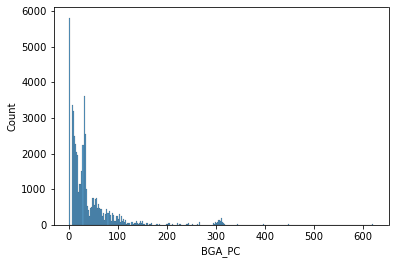

In [125]:
sns.histplot(full_df['BGA_PC'])

### plot dist

In [126]:
full_df.describe()

SRTCNT     tempature          mmHg            DO        SPC_uS  \
count  51884.000000  51884.000000  51884.000000  51884.000000  51884.000000   
mean    4150.461703     20.573840    759.296018    105.297205   1107.088968   
std     2472.538246      1.117745      3.625072     50.136372    145.724555   
min        1.000000     17.566000    749.900000     14.100000    827.000000   
25%     2020.000000     19.936000    758.900000     60.475000    952.000000   
50%     4054.000000     20.745500    759.000000     96.550000   1219.000000   
75%     6224.000000     21.446000    761.800000    158.900000   1223.000000   
max     8721.000000     22.420000    763.100000    183.700000   1312.000000   

                 pH        ORP_mV        BGA_PC           Chl           DEP  \
count  51884.000000  51884.000000  51884.000000  51884.000000  51884.000000   
mean       7.797402    233.380009     43.460649    173.509290      0.328266   
std        1.023243     58.711901     58.169194    128.080984      0.069439   
min        6.200000    -73.100000      0.790000      8.100000      0.146000   
25%        6.830000    215.700000     11.890000     65.580000      0.299000   
50%        7.320000    246.600000     28.550000    108.370000      0.331000   
75%        8.970000    276.300000     51.470000    291.660000      0.369000   
max        9.150000    286.600000    620.300000    509.990000      1.080000   

                Lat           Lon     cat_label  
count  51884.000000  51884.000000  51884.000000  
mean      31.720164     34.650158      2.516190  
std        0.024842      0.089506      1.769876  
min       31.708990     34.615510      0.000000  
25%       31.710900     34.617200      1.000000  
50%       31.711690     34.619300      2.000000  
75%       31.712490     34.619870      4.000000  
max       31.790880     34.902490      6.000000

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

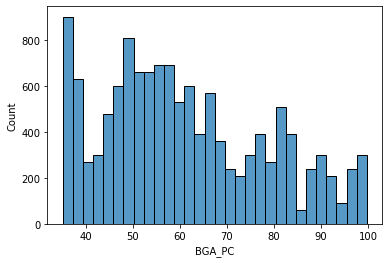

In [127]:
sns.histplot(full_df['BGA_PC'][full_df['BGA_PC'].between(35,100)])


<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

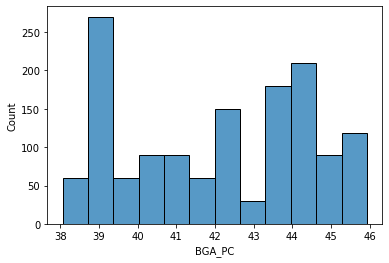

In [128]:
sns.histplot(full_df['BGA_PC'][full_df['BGA_PC'].between(38,46)])

In [129]:
keep_10= full_df[full_df['BGA_PC'].between(38,46)]


<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

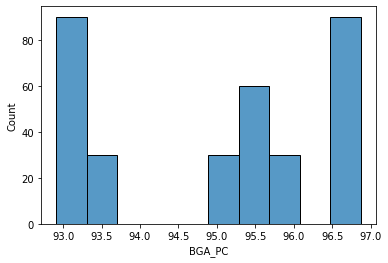

In [130]:
sns.histplot(full_df['BGA_PC'][full_df['BGA_PC'].between(92,97)])

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

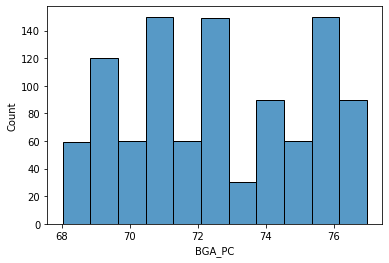

In [131]:
sns.histplot(full_df['BGA_PC'][full_df['BGA_PC'].between(68, 77)])

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

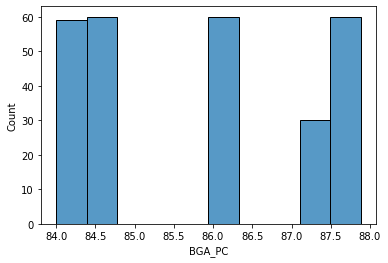

In [132]:
sns.histplot(full_df['BGA_PC'][full_df['BGA_PC'].between(84,88)])

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

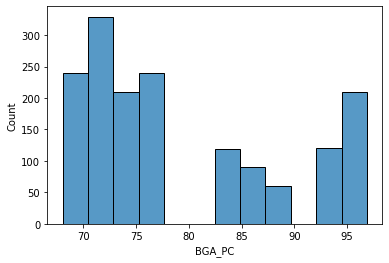

In [133]:
mask1 = full_df['BGA_PC'].between(68, 77)
mask2 = full_df['BGA_PC'].between(92, 97)
mask3 = full_df['BGA_PC'].between(84,88)
keep_12 = full_df[(mask1) | (mask2) | (mask3)]
sns.histplot(keep_12['BGA_PC'])

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

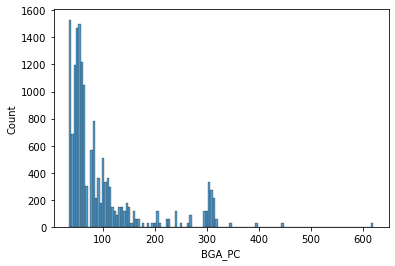

In [163]:
mask_more_40 = full_df['BGA_PC']>35
keep_8 = full_df[(mask_more_40)&(~mask1)&(~mask2)&(~mask3)]
sns.histplot(full_df['BGA_PC'][(mask_more_40)&(~mask1)&(~mask2)&(~mask3)])#|((~mask1)|(~mask2)|(~mask3))])

In [146]:
keep_5 = full_df[full_df['BGA_PC']<=35]

### selecting by smaller range

In [136]:
def check_dist(df):
    df_number_repeat= df.groupby(['UTC']).count()[df.columns[0]]
    df_merged = df.merge(df_number_repeat,left_on='UTC',right_on=df_number_repeat.index,how='left')
    df_merged = df_merged.rename(columns={'SRTCNT_x':'SRTCNT'})
    print(df_merged['SRTCNT_y'].value_counts())
    return df_merged

In [169]:
keep_most = check_dist(keep_10)
df_10 = keep_most.groupby(['UTC']).sample(12)
df_10.shape

30    1380
29      29
Name: SRTCNT_y, dtype: int64


(564, 20)

In [170]:
df_5 = check_dist(keep_5)
df_5_1 = df_5[df_5['SRTCNT_y']>2].groupby(['UTC']).sample(5)
df_5_2 = df_5[df_5['SRTCNT_y']==2].groupby(['UTC']).sample(2)
full_df_5 = pd.concat([df_5_1,df_5_2])
full_df_5.shape

30    33390
29     1015
21       21
16       16
8         8
2         2
Name: SRTCNT_y, dtype: int64


(5757, 20)

In [161]:
df_12 = check_dist(keep_12)
df_12 = df_12.groupby(['UTC']).sample(12)
df_12.shape

30    1530
29      87
Name: SRTCNT_y, dtype: int64


(648, 20)

In [167]:
df_8 = check_dist(keep_8)
df_8 = df_8.groupby(['UTC']).sample(8)
df_8.shape

30    15420
29      377
18       18
Name: SRTCNT_y, dtype: int64


(4224, 20)

In [172]:
df_keep = pd.concat([df_10,full_df_5,df_12,df_8])
df_keep.shape

(11193, 20)

<AxesSubplot:xlabel='BGA_PC', ylabel='Count'>

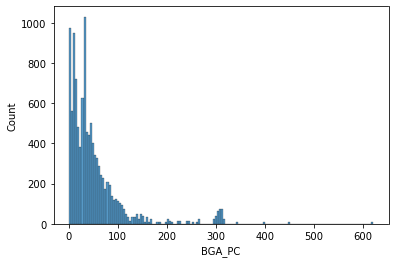

In [173]:
sns.histplot(df_keep['BGA_PC'])

In [174]:
df_keep.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\tables\df_fix.csv')

In [185]:
full_df_reduced = full_df[~full_df.unique_id.isin(df_keep.unique_id)]

## range division

In [619]:
# df_test#filtered_outlier_indices
df_outlier = df_probe.iloc[filtered_outlier_indices].copy()
def prepare_probe(probe_df):
#     probe_df = pd.read_csv(df,encoding="ISO-8859-1")
    #the Data columns does no include the seconds - the next woe concats the seconds to the time 
    probe_df['full_time'] = probe_df.apply(lambda x:x['Date']+' '+x['Time'],axis=1)
    #convert to time columns
    probe_df['full_time'] = pd.DatetimeIndex(probe_df['full_time'])
    return probe_df

In [625]:
df_out = prepare_probe(df_outlier)
df_out['full_time']

172   2021-11-16 10:39:02
267   2021-11-16 10:43:47
268   2021-11-16 10:43:50
295   2021-11-16 10:45:11
296   2021-11-16 10:45:14
297   2021-11-16 10:45:17
324   2021-11-16 10:46:38
374   2021-11-16 10:49:08
394   2021-11-16 10:50:08
410   2021-11-16 10:50:56
441   2021-11-16 10:52:29
445   2021-11-16 10:52:41
459   2021-11-16 10:53:23
492   2021-11-16 10:55:02
631   2021-11-16 11:01:59
637   2021-11-16 11:02:17
649   2021-11-16 11:02:53
650   2021-11-16 11:02:56
680   2021-11-16 11:04:26
704   2021-11-16 11:05:38
729   2021-11-16 11:06:53
755   2021-11-16 11:08:11
773   2021-11-16 11:09:05
841   2021-11-16 11:12:29
877   2021-11-16 11:14:17
Name: full_time, dtype: datetime64[ns]

In [829]:
df_PC_chl_fixed = new_df[~new_df['UTC'].isin(df_out['full_time'])]

In [830]:
df_PC_chl_fixed.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\tables\df_PC_chl_fixed1.csv')

In [12]:

df_PC = prepare_to_id(df_combined,'BGA_PC',from_df=True)
# df_Chl = prepare_to_id(df_combined,'Chl',from_df=True)

31_50       3530
16_30       2990
0_5         1950
51_70       1780
91_above    1420
6_15        1074
71_90        850
Name: cat_range, dtype: int64
3    3530
2    2990
0    1950
4    1780
6    1420
1    1074
5     850
Name: cat_label, dtype: int64


In [213]:
df_PC_chl = df_PC.copy()
# Choose the number of groups
num_groups = 9

# Split values into groups based on quantiles
groups, bins = pd.qcut(df_PC_chl['Chl'], q=num_groups, retbins=True)

# Calculate the range value for each group
group_ranges = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

# Assign group labels with range values
group_labels = ['Group {}: {:.2f} - {:.2f}'.format(i+1, group_ranges[i][0], group_ranges[i][1]) for i in range(len(group_ranges))]

# Assign group labels to the DataFrame
df_PC_chl['chl_cat'] = groups.cat.rename_categories(group_labels)
df_PC_chl['chl_range'] = groups.cat.rename_categories(group_labels)

# # Split values into groups based on quantiles
# df_PC_chl['chl_group'] = pd.qcut(df_PC_chl['Chl'], q=num_groups, labels=False)

# View the| data with assigned groups


In [214]:
df_PC_chl['chl_group'].value_counts()

Group 1: 8.10 - 9.01        1530
Group 3: 75.25 - 100.89     1510
Group 4: 100.89 - 226.12    1510
Group 5: 226.12 - 267.09    1510
Group 6: 267.09 - 295.83    1510
Group 7: 295.83 - 327.33    1510
Group 8: 327.33 - 372.81    1510
Group 9: 372.81 - 509.99    1510
Group 2: 9.01 - 75.25       1494
Name: chl_group, dtype: int64

# outlier removal

In [175]:
probe_csv1 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21\06_12_nitzanim.csv"
probe_csv2 = r"C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Tal Shachar\Probe\exobackup-211130-174508.csv"
probe_csv3 = r'C:\Users\urial\BG\AlphaBravo\SRT\df_time_full.csv'
csvs = [probe_csv1,probe_csv2,probe_csv3]


In [176]:
df_probe = [pd.read_csv(i, encoding='iso-8859-1') for i in csvs]
# df_probes = pd.concat(df_probe)


In [424]:
import numpy as np
import matplotlib.pyplot as plt

def check_outliers_sequential(data, group_size, threshold, min_outlier_count, method):
    num_groups = len(data) - group_size + 1

    outlier_indices = []  # Store the indices of outlier points
    outlier_magnitudes = []  # Store the magnitudes of outliers

    for i in range(num_groups):
        group_data = data[i:i+group_size]
        method_l = [method]
        if 1 not in method_l and 2 not in method_l:
            method_l = list([1,2])
            
        if 1 in method_l:
            group_mean = np.mean(group_data)
            group_std = np.std(group_data)
            group_threshold = group_mean + threshold * group_std
            for j, value in enumerate(group_data):
                if value > group_threshold:
                    outlier_indices.append(i + j)
                    # Calculate the magnitude difference from the surrounding 4 values
                    neighbor_data = data[max(0, i + j - 2):min(len(data), i + j + 3)]
                    outlier_magnitude = (np.abs(value - np.mean(neighbor_data)) / np.mean(neighbor_data)) * 100
                    outlier_magnitudes.append(outlier_magnitude)
        if 2 in method_l:
            Q1 = group_data.quantile(0.25)
            Q3 = group_data.quantile(0.75)
            IQR = Q3 - Q1
            high_out = np.around(Q3 + 2 * IQR, 4)
            low_out = np.around(Q1 - 2 * IQR, 4)
            for j, value in enumerate(group_data):
                if value > high_out or value < low_out:
                    outlier_indices.append(i + j)
                    # Calculate the magnitude difference from the surrounding 4 values
                    neighbor_data = data[max(0, i + j - 2):min(len(data), i + j + 3)]
                    outlier_magnitude = (np.abs(value - np.mean(neighbor_data)) / np.mean(neighbor_data)) * 100
                    outlier_magnitudes.append(outlier_magnitude)

    outlier_counts = np.bincount(outlier_indices)
    filtered_outlier_indices = np.where(outlier_counts > min_outlier_count)[0]

    # Plot the data over time
    plt.figure(figsize=(15,8))
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Measurement')

    # Mark the outlier points on the plot and collect neighbor samples
    outlier_reviews = []
    for index in filtered_outlier_indices:
        outlier_value = data[index]
        neighbors = data[max(0, index-2):index+3]  # Collect neighbor samples

        plt.plot(index, outlier_value, 'ro')  # Mark outlier points as red circles
        outlier_reviews.append((index, outlier_value, neighbors))

    plt.show()

    num_outliers = len(outlier_reviews)
    print("Number of outliers found:", num_outliers)
    for i, (index, value, neighbors) in enumerate(outlier_reviews):
        magnitude = outlier_magnitudes[i]
        print(f"Outlier index: {index}, value: {value}, magnitude: {magnitude:.2f}%")
        print("Neighbor samples:", neighbors)

    return filtered_outlier_indices



In [179]:
import numpy as np
import matplotlib.pyplot as plt

def check_outliers_sequential(df,col, group_size, threshold, min_outlier_count, method):
    data = df[col]
    num_groups = len(data) - group_size + 1

    outlier_indices = []  # Store the indices of outlier points
    outlier_magnitudes = []  # Store the magnitudes of outliers

    for i in range(num_groups):
        group_data = data[i:i+group_size]
        method_l = [method]
        
        if 1 not in method_l and 2 not in method_l:
            method_l = list([1,2])
            
        if 1 in method_l:
            group_mean = np.mean(group_data)
            group_std = np.std(group_data)
            group_threshold = group_mean + threshold * group_std
            for j, value in enumerate(group_data):
                if value > group_threshold:
                    outlier_indices.append(i + j)
                    # Calculate the magnitude difference from the surrounding 4 values
                    neighbor_data = data[max(0, i + j - 2):min(len(data), i + j + 3)]

        if 2 in method_l:
            Q1 = group_data.quantile(0.25)
            Q3 = group_data.quantile(0.75)
            IQR = Q3 - Q1
            high_out = np.around(Q3 + 2 * IQR, 4)
            low_out = np.around(Q1 - 2 * IQR, 4)
            for j, value in enumerate(group_data):
                if value > high_out or value < low_out:
                    outlier_indices.append(i + j)
                    # Calculate the magnitude difference from the surrounding 4 values
                    neighbor_data = data[max(0, i + j - 2):min(len(data), i + j + 3)]
                    sum_neg = np.sum(neighbor_data)-value
                    outlier_magnitude = (np.abs(value - np.mean(neighbor_data)) / np.mean(neighbor_data)) * 100
                    outlier_magnitudes.append(outlier_magnitude)

    outlier_counts = np.bincount(outlier_indices)
    filtered_outlier_indices = np.where(outlier_counts > min_outlier_count)[0]
    
    plt.figure(figsize=(15,5))
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15, 8))
    ax1.plot(data)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Measurement')
    # Mark the outlier points on the plot and collect neighbor samples
    outlier_reviews = []
    for index in filtered_outlier_indices:
        outlier_value = data[index]
        neighbors = data[max(0, index-2):index+3]  # Collect neighbor samples

        ax1.plot(index, outlier_value, 'ro')  # Mark outlier points as red circles
        outlier_reviews.append((index, outlier_value, neighbors))


    filtered_outlier_indices_filter = {'keep':{},'remove':{}}
    num_outliers = len(outlier_reviews)
    print("Number of outliers found:", num_outliers)
    
    for i, (index, value, neighbors) in enumerate(outlier_reviews):
        sum_neg = np.sum(neighbors)-value
#         print(f'np.sum(neighbor_data):{np.sum(neighbors):.2f}%,sum_neg:{sum_neg}\n,(sum_neg/4):{(sum_neg/4):.2f}%,value:{value}')
        
        outlier_magnitude = (np.abs(value/(sum_neg/4)))  * 100
#         print(f"Outlier index: {index}, value: {value}, magnitude: {outlier_magnitude:.2f}%")
#         print("Neighbor samples:", neighbors)
#         magnitude = outlier_magnitudes[i]

        outlier_magnitude_met = outlier_magnitude if outlier_magnitude>=100 else (100-outlier_magnitude)+100
        if value<=20:
            if outlier_magnitude_met<150:
                filtered_outlier_indices_filter['keep'][index]=value
            else:
                filtered_outlier_indices_filter['keep'][index]=np.around(np.mean(neighbors),2)
                
        elif value>21 and value<50:
            if outlier_magnitude_met<130:
                filtered_outlier_indices_filter['keep'][index]=value
            else:
                filtered_outlier_indices_filter['keep'][index]=np.around(np.mean(neighbors),2)
        elif value>50:
            if outlier_magnitude_met>=181:
                print(f'index:{index}, value:{value}, outlier_magnitude:{outlier_magnitude} - removed')
                filtered_outlier_indices_filter['remove'][index]=value
                
            elif outlier_magnitude<180 and outlier_magnitude>130:
                filtered_outlier_indices_filter['keep'][index]=np.around(np.mean(neighbors),2)
            else:
                filtered_outlier_indices_filter['keep'][index]=value
                  
            # Plot the data over time
    
    df2 = df.copy()
    data_array = np.array(list(filtered_outlier_indices_filter['remove'].keys()))
    print(data_array)
#     print(data_array)
    df3=df2[~df2.index.isin(data_array)]
#     df2 = df2.iloc[~df2.index.isin(data_array)]#df2.drop(data_array)
    df3[col].loc[list(filtered_outlier_indices_filter['keep'].keys())]=np.array(list(filtered_outlier_indices_filter['keep'].values()))
    ax2.plot(df3[col])
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Measurement')
    # Mark the outlier points on the plot and collect neighbor samples
    outlier_reviews = []
    for index in filtered_outlier_indices_filter['keep'].keys():
        outlier_value = filtered_outlier_indices_filter['keep'][index]

        ax2.plot(index, outlier_value, 'ro')  # Mark outlier points as red circles

    plt.show()
    return filtered_outlier_indices_filter,df3


Number of outliers found: 41
index:374, value:125.13, outlier_magnitude:196.7375496246217 - removed
index:410, value:96.84, outlier_magnitude:196.13164556962028 - removed
index:441, value:343.84, outlier_magnitude:711.5525893734801 - removed
index:445, value:124.28, outlier_magnitude:270.4384724186704 - removed
index:459, value:267.93, outlier_magnitude:530.9750297265161 - removed
index:492, value:242.7, outlier_magnitude:289.6613456661196 - removed
index:503, value:201.9, outlier_magnitude:200.0099063846649 - removed
index:522, value:109.27, outlier_magnitude:200.51380860629413 - removed
index:536, value:107.27, outlier_magnitude:207.73662551440327 - removed
index:581, value:137.73, outlier_magnitude:261.05003790750567 - removed
index:616, value:122.82, outlier_magnitude:215.75757575757578 - removed
index:631, value:211.46, outlier_magnitude:226.43287377861068 - removed
index:637, value:223.43, outlier_magnitude:347.89987932578146 - removed
index:650, value:203.13, outlier_magnitude:1

<Figure size 1080x360 with 0 Axes>

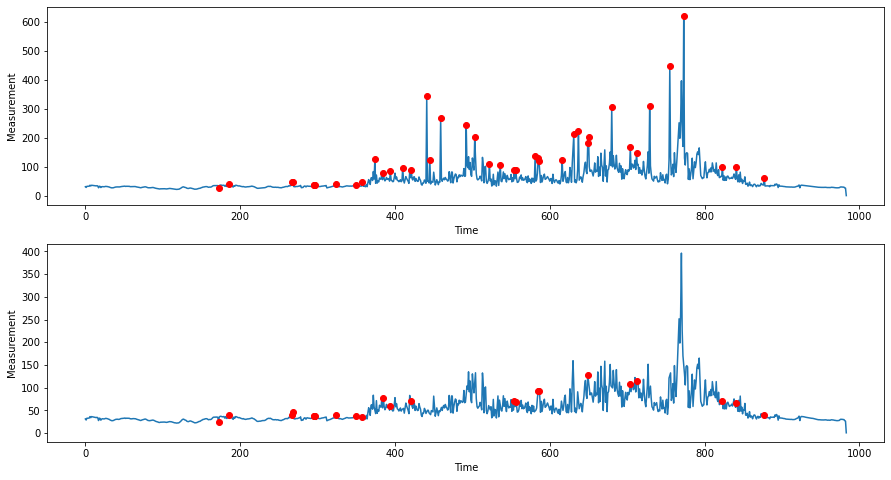

In [537]:
# Example usage
df = df_probe[2]
col = 'BGA-PC ug/L'
group_size = 15
threshold = 2.0
min_outlier_count = 10
method=3
filtered_outlier_indices,df = check_outliers_sequential(df,col, group_size, threshold, min_outlier_count,method)

In [533]:
df.loc[770:775]

Date      Time    Site   Unit ID      °C   mmHg  DO %  SPC-uS/cm  \
770  11/16/2021  11:08:56  <None>  Handheld  21.107  758.9  44.4      973.0   
771  11/16/2021  11:08:59  <None>  Handheld  21.114  758.9  43.5      975.0   
772  11/16/2021  11:09:02  <None>  Handheld  21.113  758.9  43.2      975.0   
774  11/16/2021  11:09:08  <None>  Handheld  21.123  758.9  42.9      969.0   
775  11/16/2021  11:09:11  <None>  Handheld  21.137  758.9  42.8      965.0   

       pH  ORP mV  BGA-PC ug/L  Chl ug/L  DEP m       Lat       Lon   range  \
770  6.57   209.4       396.32    346.87  0.309  31.71200  34.61931  Part_D   
771  6.57   204.4       226.24    335.57  0.311  31.71200  34.61929  Part_D   
772  6.57   203.9       169.99    284.79  0.311  31.71200  34.61929  Part_D   
774  6.56   205.1       129.98    285.47  0.318  31.71199  34.61926  Part_D   
775  6.56   205.8       105.76    292.34  0.321  31.71198  34.61926  Part_D   

     Unnamed: 16  
770          NaN  
771          NaN  
772          NaN  
774          NaN  
775          NaN

Number of outliers found: 21
index:753, value:56.5, outlier_magnitude:18.871390637786202 - removed
[753]


<Figure size 1080x360 with 0 Axes>

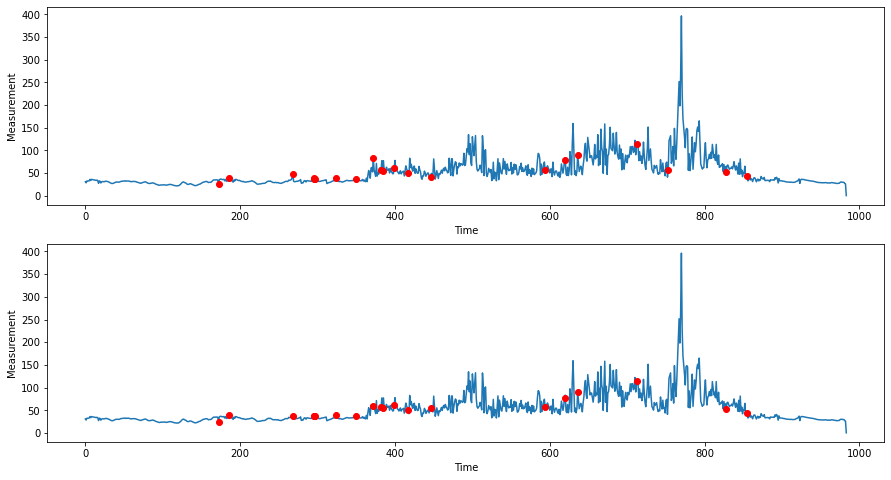

In [534]:
filtered_outlier_indices = check_outliers_sequential(df,col, group_size, threshold, min_outlier_count,method)

In [404]:
df_probe_text = df_probe.copy()

df_probe_text[0]['BGA-PC ug/L'][filtered_outlier_indices.keys()]=filtered_outlier_indices.values()


In [427]:
data

0      40.72
1       40.7
2      40.66
3      40.66
4      40.69
       ...  
971    10.18
972     8.17
973     9.07
974    10.22
975    13.72
Name: BGA-PC ug/L, Length: 976, dtype: object

In [406]:
filtered_outlier_indices.values()

dict_values([12.06, 10.84, 13.26, 13.48, 11.43, 10.26, 21.43, 24.73, 18.32, 17.44, 11.11, 106.36, 23.99, 20.7, 22.56, 19.14, 24.06, 18.18, 18.19, 22.09, 24.2, 16.64, 19.41, 15.87, 12.45])

In [394]:
df_probe_text[0]

Date      Time    Site   Unit ID  User ID      °C   mmHg   DO %  \
0    12/06/2021   8:35:07  <None>  Handheld      NaN  18.774  762.8   98.3   
1    12/06/2021   8:35:10  <None>  Handheld      NaN  18.757  762.7   98.3   
2    12/06/2021   8:35:13  <None>  Handheld      NaN  18.740  762.8   98.4   
3    12/06/2021   8:35:16  <None>  Handheld      NaN  18.705  762.8   98.4   
4    12/06/2021   8:35:19  <None>  Handheld      NaN  18.676  762.8   98.5   
..          ...       ...     ...       ...      ...     ...    ...    ...   
971  12/06/2021  12:05:44  <None>  Handheld      NaN  19.954  761.6  151.9   
972  12/06/2021  12:05:47  <None>  Handheld      NaN  19.957  761.6  152.4   
973  12/06/2021  12:05:50  <None>  Handheld      NaN  19.981  761.5  152.7   
974  12/06/2021  12:05:53  <None>  Handheld      NaN  19.962  761.6  153.0   
975  12/06/2021  12:05:56  <None>  Handheld      NaN  19.872  761.5  152.6   

     SPC-uS/cm    pH  ...  FNU  TSS mg/L  BGA-PC ug/L  BGA-PE ug/L  Chl ug/L  \
0         1199  8.54  ...  NaN       NaN        40.72          NaN    153.21   
1         1200  8.54  ...  NaN       NaN         40.7          NaN    146.85   
2         1201  8.54  ...  NaN       NaN        40.66          NaN    146.82   
3         1202  8.54  ...  NaN       NaN        40.66          NaN    156.03   
4         1203  8.54  ...  NaN       NaN        40.69          NaN    145.40   
..         ...   ...  ...  ...       ...          ...          ...       ...   
971       1223  8.95  ...  NaN       NaN        10.18          NaN     71.46   
972       1223  8.95  ...  NaN       NaN         8.17          NaN     70.74   
973       1222  8.96  ...  NaN       NaN         9.07          NaN     82.97   
974       1222  8.96  ...  NaN       NaN        10.22          NaN    102.10   
975       1222  8.95  ...  NaN       NaN        13.72          NaN     98.80   

     fDOM RFU fDOM QSU  DEP m       Lat       Lon  
0         NaN      NaN  0.296  31.71161  34.61769  
1         NaN      NaN  0.293  31.71161  34.61769  
2         NaN      NaN  0.292  31.71161  34.61769  
3         NaN      NaN  0.293  31.71160  34.61769  
4         NaN      NaN  0.293  31.71160  34.61769  
..        ...      ...    ...       ...       ...  
971       NaN      NaN  0.368  31.71141  34.61556  
972       NaN      NaN  0.369  31.71140  34.61554  
973       NaN      NaN  0.369  31.71140  34.61553  
974       NaN      NaN  0.371  31.71140  34.61551  
975       NaN      NaN  0.377  31.71139  34.61551  

[976 rows x 24 columns]

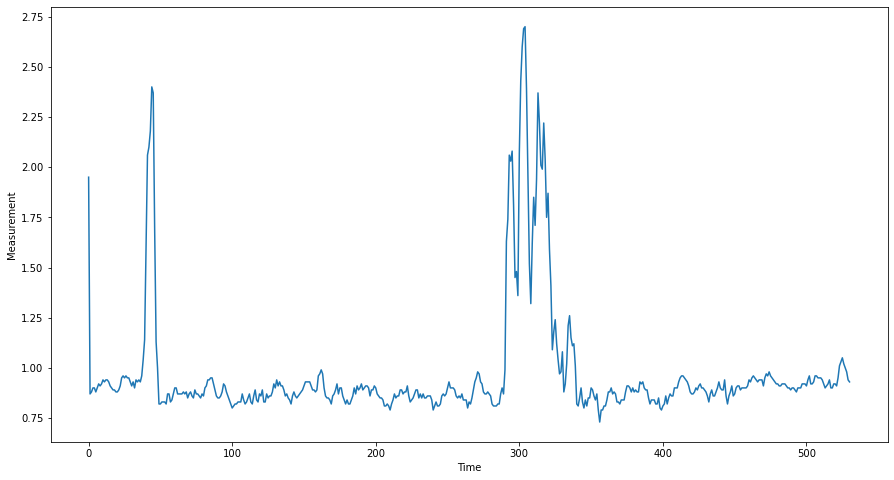

Number of outliers found: 0


In [268]:
filtered_outlier_indices = check_outliers_sequential(df_probe[1]['BGA-PC ug/L'], group_size, threshold, min_outlier_count,method)

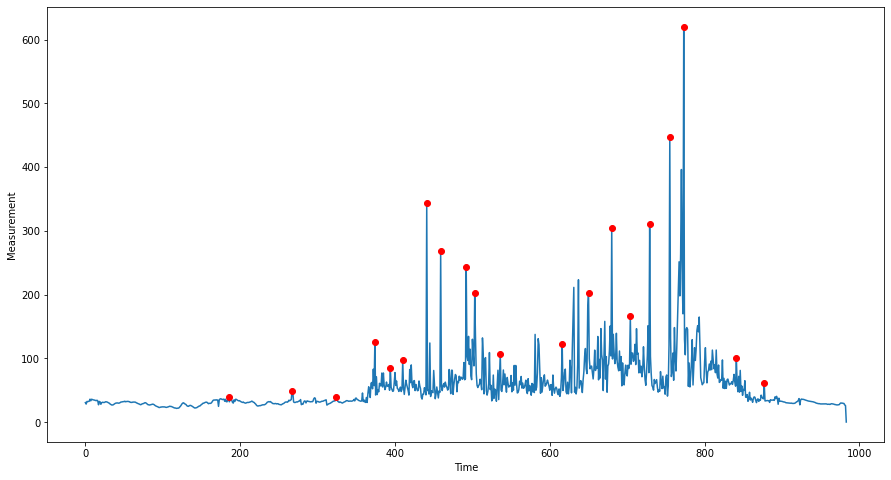

Number of outliers found: 20
Outlier index: 185, value: 39.58, magnitude: 1.0749999999999993
Neighbor samples: 184    35.73
185    39.58
186    32.07
Name: BGA-PC ug/L, dtype: float64
Outlier index: 267, value: 48.79, magnitude: 2.343
Neighbor samples: 266    35.54
267    48.79
268    46.93
Name: BGA-PC ug/L, dtype: float64
Outlier index: 324, value: 39.04, magnitude: 1.5339999999999954
Neighbor samples: 323    33.83
324    39.04
325    34.77
Name: BGA-PC ug/L, dtype: float64
Outlier index: 374, value: 125.13, magnitude: 2.7139999999999986
Neighbor samples: 373     57.27
374    125.13
375     42.64
Name: BGA-PC ug/L, dtype: float64
Outlier index: 394, value: 84.59, magnitude: 1.9899999999999949
Neighbor samples: 393    50.14
394    84.59
395    54.78
Name: BGA-PC ug/L, dtype: float64
Outlier index: 410, value: 96.84, magnitude: 1.088999999999995
Neighbor samples: 409    51.47
410    96.84
411    54.23
Name: BGA-PC ug/L, dtype: float64
Outlier index: 441, value: 343.84, magnitude: 1.059

In [269]:
filtered_outlier_indices = check_outliers_sequential(df_probe[2]['BGA-PC ug/L'], group_size, threshold, min_outlier_count,method)

In [614]:
filtered_outlier_indices

array([172, 267, 268, 295, 296, 297, 324, 374, 394, 410, 441, 445, 459,
       492, 631, 637, 649, 650, 680, 704, 729, 755, 773, 841, 877],
      dtype=int64)

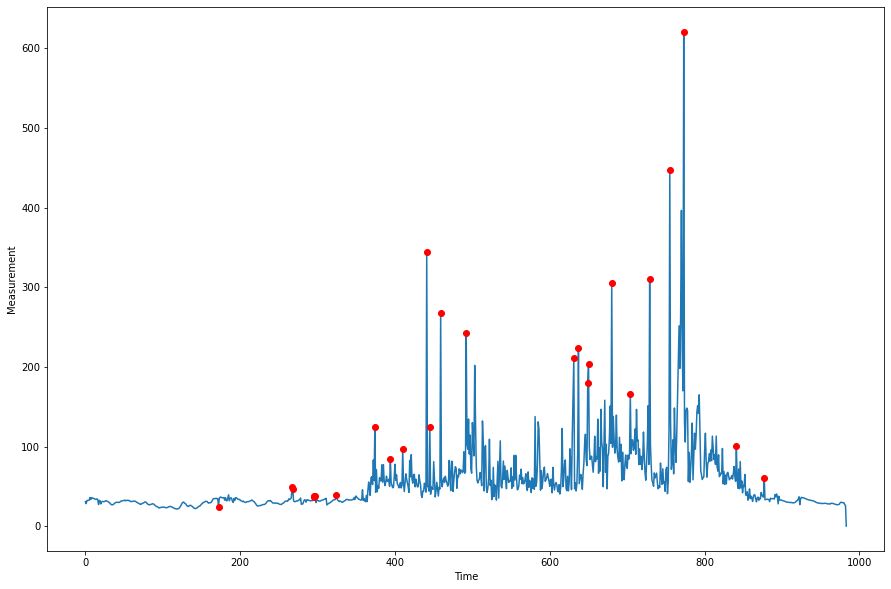

Number of outliers found: 25
Outlier index:172, value:24.85
Neighbor samples: 171    34.89
172    24.85
173    35.12
Name: BGA-PC ug/L, dtype: float64

Outlier index:267, value:48.79
Neighbor samples: 266    35.54
267    48.79
268    46.93
Name: BGA-PC ug/L, dtype: float64

Outlier index:268, value:46.93
Neighbor samples: 267    48.79
268    46.93
269    31.87
Name: BGA-PC ug/L, dtype: float64

Outlier index:295, value:36.57
Neighbor samples: 294    32.97
295    36.57
296    38.28
Name: BGA-PC ug/L, dtype: float64

Outlier index:296, value:38.28
Neighbor samples: 295    36.57
296    38.28
297    37.60
Name: BGA-PC ug/L, dtype: float64

Outlier index:297, value:37.6
Neighbor samples: 296    38.28
297    37.60
298    29.83
Name: BGA-PC ug/L, dtype: float64

Outlier index:324, value:39.04
Neighbor samples: 323    33.83
324    39.04
325    34.77
Name: BGA-PC ug/L, dtype: float64

Outlier index:374, value:125.13
Neighbor samples: 373     57.27
374    125.13
375     42.64
Name: BGA-PC ug/L, 

In [602]:
check_outliers_sequential(data, group_size, threshold, min_outlier_count,method=2)

In [ ]:
# Example usage
data = df_probe['BGA-PC ug/L']
group_size = 15
threshold = 2.0
min_outlier_count = 10
method=2
filtered_outlier_indices = check_outliers_sequential(data, group_size, threshold, min_outlier_count,method)

# Inference on output image to center on probe


In [206]:
df_sampled=full_df_sampled.copy()
df_sampled['im_name'] = df_sampled.apply(lambda x:f"{x['unique_id']}.jpg",axis=1)
from os import walk
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat'
mypath= r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered'
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat\clean\trans'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
# row = [x.split('.')[0] for x in f]
new_df = df_sampled[~df_sampled['im_name'].isin(f)]
new_df

SRTCNT  tempature   mmHg     DO  SPC_uS    pH  ORP_mV  BGA_PC     Chl  \
246      5080     20.954  758.9   52.5   951.0  6.52   278.3   39.58  381.44   
267      5101     20.954  758.9   52.5   951.0  6.52   278.3   39.58  381.44   
257      5091     20.954  758.9   52.5   951.0  6.52   278.3   39.58  381.44   
264      5098     20.954  758.9   52.5   951.0  6.52   278.3   39.58  381.44   
252      5086     20.954  758.9   52.5   951.0  6.52   278.3   39.58  381.44   
...       ...        ...    ...    ...     ...   ...     ...     ...     ...   
17043    2197     19.872  761.5  152.6  1222.0  8.95   216.0   13.72   98.80   
17056    2210     19.872  761.5  152.6  1222.0  8.95   216.0   13.72   98.80   
17044    2198     19.872  761.5  152.6  1222.0  8.95   216.0   13.72   98.80   
17050    2204     19.872  761.5  152.6  1222.0  8.95   216.0   13.72   98.80   
17054    2208     19.872  761.5  152.6  1222.0  8.95   216.0   13.72   98.80   

         DEP       Lat       Lon                 UTC   range      NAME  \
246    0.353  31.71029  34.62029 2021-11-16 10:39:41  Part_A  DJI_0023   
267    0.353  31.71029  34.62029 2021-11-16 10:39:41  Part_A  DJI_0023   
257    0.353  31.71029  34.62029 2021-11-16 10:39:41  Part_A  DJI_0023   
264    0.353  31.71029  34.62029 2021-11-16 10:39:41  Part_A  DJI_0023   
252    0.353  31.71029  34.62029 2021-11-16 10:39:41  Part_A  DJI_0023   
...      ...       ...       ...                 ...     ...       ...   
17043  0.377  31.71139  34.61551 2021-12-06 12:05:56  Part_E  DJI_0076   
17056  0.377  31.71139  34.61551 2021-12-06 12:05:56  Part_E  DJI_0076   
17044  0.377  31.71139  34.61551 2021-12-06 12:05:56  Part_E  DJI_0076   
17050  0.377  31.71139  34.61551 2021-12-06 12:05:56  Part_E  DJI_0076   
17054  0.377  31.71139  34.61551 2021-12-06 12:05:56  Part_E  DJI_0076   

                                           drone_vid_dir        unique_id  \
246    C:\Users\urial\OneDrive - BlueGreen Water Tech...  5080_1637051981   
267    C:\Users\urial\OneDrive - BlueGreen Water Tech...  5101_1637051981   
257    C:\Users\urial\OneDrive - BlueGreen Water Tech...  5091_1637051981   
264    C:\Users\urial\OneDrive - BlueGreen Water Tech...  5098_1637051981   
252    C:\Users\urial\OneDrive - BlueGreen Water Tech...  5086_1637051981   
...                                                  ...              ...   
17043  C:\Users\urial\OneDrive - BlueGreen Water Tech...  2197_1638785156   
17056  C:\Users\urial\OneDrive - BlueGreen Water Tech...  2210_1638785156   
17044  C:\Users\urial\OneDrive - BlueGreen Water Tech...  2198_1638785156   
17050  C:\Users\urial\OneDrive - BlueGreen Water Tech...  2204_1638785156   
17054  C:\Users\urial\OneDrive - BlueGreen Water Tech...  2208_1638785156   

       SRTCNT_y              im_name  
246        30.0  5080_1637051981.jpg  
267        30.0  5101_1637051981.jpg  
257        30.0  5091_1637051981.jpg  
264        30.0  5098_1637051981.jpg  
252        30.0  5086_1637051981.jpg  
...         ...                  ...  
17043      30.0  2197_1638785156.jpg  
17056      30.0  2210_1638785156.jpg  
17044      30.0  2198_1638785156.jpg  
17050      30.0  2204_1638785156.jpg  
17054      30.0  2208_1638785156.jpg  

[14805 rows x 19 columns]

In [57]:
import torch
import torchvision
# from faster_rcnn_detector import faster_rcnn_pretrained_model
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
img_path = r'C:\Users\urial\BG\AlphaBravo\samples_new\JPEGImages\5711_1637053937.jpg'
image1 = T.ToTensor()(Image.open(img_path))
img =  image1.clone()


In [58]:
from torchvision.models.detection import FasterRCNN,fasterrcnn_resnet50_fpn
def faster_rcnn_pretrained_model(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model_probe = faster_rcnn_pretrained_model(2)
model_probe.load_state_dict(torch.load(r'C:\Users\urial\DS\faster_rcnn\fresh\models\last.pth'))
model_probe.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [59]:
# from faster_rcnn_detector import faster_rcnn_pretrained_model
def faster_rcnn_pretrained_model(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
# state = torch.load(r'C:\Users\urial\DS\faster_rcnn\fresh\models\kayak.pth')
# f = fasterrcnn_resnet50_fpn.load_state_dict(state)
model_kayak = faster_rcnn_pretrained_model(3)
model_kayak.load_state_dict(torch.load(r'C:\Users\urial\DS\faster_rcnn\fresh\models\kayak.pth'))
model_kayak.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
output = model([img])

print(output,output[0]['scores'].argmax(),output[0]['scores'][0])

[{'boxes': tensor([[2227.2922, 1345.5054, 2497.9727, 1450.7527],
        [2297.5378, 1367.9297, 2563.4707, 1451.4819],
        [2326.0818, 1355.0105, 2471.1731, 1446.8705],
        [1902.0751,    0.0000, 1970.8044,   71.8318],
        [2501.6536, 1386.3995, 2573.2363, 1443.9249]],
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([0.9620, 0.1023, 0.0869, 0.0824, 0.0781], grad_fn=<IndexBackward0>)}] tensor(0) tensor(0.9620, grad_fn=<SelectBackward0>)


# complete process for exporting the images with probe as center

In [111]:
import cv2
import torch
import math
import os
def collate_fn(batch):
    return tuple(zip(*batch))

def inner_dataloader(model_probe,model_kayak,inf_dataloader,out_path,save,inference,plot,cuda):
    def new_boundry(bboxes,img2crp,out_size=1024,bybox=True):
        if bybox:
            x1,y1,x2,y2 = bboxes[0]
            x_mid = x1+((x2-x1)/2)
            y_mid = y1+((y2-y1)/2)
            out_size=out_size/2
        else:
            x_mid = img2crp.shape[1]/2
            y_mid = img2crp.shape[0]/2
            out_size=out_size
            
        new_box = x_mid-out_size,y_mid-out_size,x_mid+out_size,y_mid+out_size
        new_box = tuple([1 if i<1 else i for i in new_box])
        cropped_img = img2crp[:][int(new_box[1]):int(new_box[3]),int(new_box[0]):int(new_box[2])].copy()
        return cropped_img

    
    device = torch.device("cpu")
    if cuda and torch.cuda.is_available():
        # CUDA is available
        device = torch.device("cuda")
        
    def process_inner(detections):
        min_val = detections[0]['scores'].argmax()
        bboxes = detections[0]['boxes'][min_val:min_val+1].cpu().detach().numpy() if cuda else detections[0]['boxes'][min_val:min_val+1].detach().numpy()
        labels = detections[0]['labels'][min_val:min_val+1].cpu().detach().numpy() if cuda else detections[0]['labels'][min_val:min_val+1].detach().numpy()
        scores = detections[0]['scores'][min_val:min_val+1].cpu().detach().numpy() if cuda else detections[0]['scores'][min_val:min_val+1].detach().numpy()
        return min_val,bboxes,labels,scores
    
    model_probe.to(device)
    with torch.no_grad():
        for inputs, labels in inf_dataloader:
            skip=False
            img = T.ToTensor()(inputs[0])
            img = img.to(device)
            detections = model_probe(img.unsqueeze(0))
            img = img.cpu()
            img = img.numpy().transpose(1, 2, 0)
            img = (img * 255.).astype(np.uint8)
            crop_img = img.copy()
            if len(detections[0]['scores'])>0:
                print('found detecction 1')
                print(detections[0]['scores'])
                min_val,bboxes,labels,scores= process_inner(detections)
                cropped_img = new_boundry(bboxes,crop_img)
                cropped_img1 =cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
                if inference:
                        cropped_out = inference_probe_kayak(model_kayak,cropped_img1,path=False,plot=plot,test=False,cuda=cuda)
#                         cropped_out = cropped_out if cropped_out!='previous' else cropped_img1
            else: 
                print('didnt found detection first, cropping to try again')
                cropped_img2 = new_boundry(0,crop_img,out_size=1000,bybox=False)
                cropped_img2 =cv2.cvtColor(cropped_img2, cv2.COLOR_BGR2RGB)
                img = T.ToTensor()(cropped_img2)
                img = img.to(device)
                detections = model_probe(img.unsqueeze(0))
                if len(detections[0]['scores'])>0:
                    print('process worked for cropping')
                    print('found detection 2')
                    min_val,bboxes,labels,scores= process_inner(detections)
                    cropped_img3 = new_boundry(bboxes,cropped_img2)
                    if inference:
                        cropped_out = inference_probe_kayak(model_kayak,cropped_img3,path=False,plot=plot,test=False,cuda=cuda)
                    if plot:
                        f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,6))
                        ax1.imshow(crop_img)
                        ax1.set_title('before crop 1')
                        ax2.imshow(cropped_img3)
                        ax2.set_title('after crop 1')
                        ax3.imshow(cropped_im4)
                        ax3.set_title('after crop 2')
                else:
                    skip = True
                    print(f'skipping this image')

            if save and skip==False:
                Image.fromarray(cropped_out).save(out_path)
            if plot:

#                     plt.figure(figsize=(15,6))
                f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(15,6))
                ax1.imshow(img)
                ax1.set_title('befor detection')
                ax2.imshow(crop_img)
                ax2.set_title('initial detection')
                ax3.imshow(cropped_img1)
                ax3.set_title('initial cropped image')
                if inference is True:
                    ax4.imshow(cropped_im2)
                    ax4.set_title('secondery cropped image')
#                     plt.imshow(cropped_img)
                
                
# transform = T.ToTensor()
class croppedDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, ims,label):
#         'Initialization'
#         im = T.ToPILImage()(ims)
#         ims =  cv2.cvtColor(ims, cv2.COLOR_BGR2RGB)#Image.open(ims[0]).convert('RGB')
        self.ims = ims
        self.label = label
        self.transform = T.ToPILImage()#Tensor()

    def __len__(self):
            'Denotes the total number of samples'
            return 1
    def __getitem__(self, index):
            'Generates one sample of data'
            # Select sample
            image = self.ims
#             image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.label

            return image,label
    
def vid2img2(model_probe,model_kayak,df,father_folder,out_dir,save = False,inference = False,plot=False,cuda=False):#video_dir_path
        """(1)Exports video frames to images
        ARGS:
            n_groups (optional,int,Default=4): number of groups for data split.
            out_dir (optional,str): name of output folder.
            
        """
        def folder_create(father_folder,new_folder):
            full_path = os.path.join(father_folder,new_folder)

            if not os.path.exists(full_path):
                os.makedirs(full_path)

            return full_path
        
        def file_check(full_path,file_name,delete=False):
            file_path = os.path.join(full_path,file_name)
            if os.path.exists(file_path):
                if delete:
                    os.remove(file_path)
                else:
                    print(f'{file_path} already exist. continue')
                    file_path='break'
            return file_path

            
        full_path = folder_create(father_folder,out_dir)
   
        for idx in tqdm(range(df.shape[0]), desc=f'out_process'):
            frame_no = df.iloc[idx,:]['SRTCNT']#[idx,:]['SRTCNT']
            value = df.iloc[idx,:]['unique_id']#df.loc[idx,:][col]:][col]
            file_path =file_check(full_path,f'{value}.jpg')
            if file_path!='break':
                print(file_path)
                video_name = df.iloc[idx,:]['NAME']
                video_path = os.path.join(df.iloc[idx,:]['drone_vid_dir'],video_name+'.MP4')
                vid = cv2.VideoCapture(video_path)
    #             while(True):

                vid.set(1,frame_no);
                # Capture the video frame
                # by frame
                ret, frame = vid.read()

                if ret:
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    img = Image.fromarray(image)
                    cropped_dataset = croppedDataset(ims=img, label=value)
                    train_dl = DataLoader(cropped_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True,
                                           collate_fn=collate_fn)
                    inner_dataloader(model_probe, model_kayak, train_dl, file_path, save, inference, plot, cuda)
                else:
                    print(f'Unable to read frame from {video_path}')
                    continue
                    
#                 img = transforms.ToPILImage()(frame)
#                 cropped_dataset = croppedDataset(ims=img,label = value)
#                 train_dl = DataLoader(cropped_dataset, batch_size=1, shuffle=False ,num_workers=0, pin_memory=True,collate_fn=collate_fn)
#                 inner_dataloader(model_probe,model_kayak,train_dl,file_path,save,inference,plot,cuda)

            
def inference_probe_kayak(model_kayak,image,path=True,plot=False,test=True,cuda=False):
    
    def new_boundry_process2(bboxes,img2crp,out_radius):
#         print(f'radius:{out_radius}')
        x1,y1,x2,y2 = bboxes
        x_mid = x1+((x2-x1)/2)
        y_mid = y1+((y2-y1)/2)
        new_box = x_mid-out_radius,y_mid-out_radius,x_mid+out_radius,y_mid+out_radius
        new_box = tuple([1 if i<1 else i for i in new_box])
        cropped_img = img2crp[:][int(new_box[1]):int(new_box[3]),int(new_box[0]):int(new_box[2])].copy()
        cropped_img = cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB)
        return cropped_img
    
    if path is True:
        # Load the image;
        image = cv2.imread(image)
        
#     image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image2crop = image.copy()
    
    image1 = T.ToTensor()(image)
    if cuda==False:
        device = torch.device("cpu")
    else:
        if torch.cuda.is_available():
            # CUDA is available
            device = torch.device("cuda")

    model_kayak.to(device)
    img = image1.to(device)
    output = model_kayak([img])
    

    boxes = output[0]['boxes']
    labels = output[0]['labels']
    scores = output[0]['scores']

    # Convert tensors to numpy arrays
    boxes =  boxes.cpu().detach().numpy().astype(int) if cuda else boxes.detach().numpy().astype(int)
    labels = labels.cpu().detach().numpy() if cuda else labels.detach().numpy()
    scores = scores.cpu().detach().numpy() if cuda else scores.detach().numpy()

    max_scores = {}
    max_boxes = {}

    # Iterate over the boxes, labels, and scores
    for box, label, score in zip(boxes, labels, scores):
        # Check if the label is already encountered or if the current score is higher than the previous highest score
        if label not in max_scores or score > max_scores[label]:
            max_scores[label] = score
            max_boxes[label] = box
    
    # Calculate the midpoint coordinates for each most confident label
    midpoints = {}
    for label, box in max_boxes.items():
        # Extract the coordinates
        xmin, ymin, xmax, ymax = box

        # Calculate midpoint coordinates
        midpoint_x = (xmin + xmax) // 2
        midpoint_y = (ymin + ymax) // 2

        # Store the midpoint coordinates
        midpoints[label] = (midpoint_x, midpoint_y)

    # Calculate the Euclidean distance between midpoints
    label_pairs = list(midpoints.keys())
    if len(label_pairs)>1:
        for i in range(len(label_pairs)):
            for j in range(i + 1, len(label_pairs)):
                label1 = label_pairs[i]
                label2 = label_pairs[j]

                midpoint1 = midpoints[label1]
                midpoint2 = midpoints[label2]
                
                distance_x = abs(midpoint2[0] - midpoint1[0])  # Distance in the x-axis
                distance_y = abs(midpoint2[1] - midpoint1[1])  # Distance in the y-axis
                
                distance = math.sqrt((midpoint2[0] - midpoint1[0]) ** 2 + (midpoint2[1] - midpoint1[1]) ** 2)
                if max(distance_x,distance_y)>300:
#                     print(f"Distance between {label1} and {label2}: {distance}")
                    distance = max(distance_x,distance_y)
                    print(f"Distance {max(distance_x,distance_y)}")
                    second_crop = True
                else:
                    distance=image.shape[0]
                    print(f'not enought distance between detections - keep same value {image.shape}')
                    print(f'returning just an image')
                    image_no_process = cv2.cvtColor(image2crop,cv2.COLOR_BGR2RGB)
#                     return 'previous'
                    second_crop = False
    else:
        distance=image.shape[0] if image.shape[0]<=1024 else 1024/2
        print(f'not enought detections - crop value value {distance}')
        print(f'returning just an image')
        image_no_process = cv2.cvtColor(image2crop,cv2.COLOR_BGR2RGB)#image2crop.copy()
        second_crop = False
    if second_crop:
        # Draw the bounding boxes and labels on the image
        for label, box in max_boxes.items():
            # Extract the coordinates
            xmin, ymin, xmax, ymax = box

            # Draw the bounding box rectangle
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Add label text
            label_text = f'Label: {label}'
            cv2.putText(image, label_text, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cropped_im = new_boundry_process2(max_boxes[1],image2crop,distance) if second_crop else image_no_process
    if test is True:
        print(output)
        print(max_boxes)
#     if plot:plt.imshow(cropped_im)
#     print(cropped_im)
    return cropped_im

In [112]:
# video_dir_path = father_folder
df_merged_sampled_col=df_temp.copy()
father_folder = r'C:\Users\urial\BG\AlphaBravo\samples'
out_dir = 'samples_fixed'
vid2img2(model_probe,model_kayak,df_merged_sampled_col,father_folder,out_dir, save=True, inference=True,plot=False,cuda=True)

out_process:   6%|███▊                                                        | 363/5686 [00:00<00:01, 3322.49it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2556_1637051444.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2572_1637051444.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2587_1637051445.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2591_1637051445.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2618_1637051446.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2635_1637051446.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2740_1637051450.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2737_1637051450.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2769_1637051451.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2792_1637051451.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3516_1637053411.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3550_1637053412.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3543_1637053412.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3581_1637053413.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3573_1637053413.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3684_1637053417.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3699_1637053417.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3712_1637053418.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3734_1637053418.jpg alre

out_process:  18%|██████████▊                                                 | 1030/5686 [00:03<00:16, 281.68it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7850_1638783638.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7838_1638783638.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7871_1638783639.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7879_1638783639.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7916_1638783640.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7914_1638783640.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7929_1638783641.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7926_1638783641.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7976_1638783642.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7962_1638783642.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed

out_process:  29%|█████████████████▋                                          | 1671/5686 [00:03<00:06, 612.41it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\471_1637052043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\497_1637052044.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\534_1637052045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\558_1637052046.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\597_1637052047.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\633_1637052048.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\674_1637052049.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\694_1637052050.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\708_1637052051.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\762_1637052052.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\771_16370

out_process:  35%|█████████████████████                                       | 1995/5686 [00:04<00:04, 843.57it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4731_1637052767.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4765_1637052768.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4792_1637052769.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4828_1637052770.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4849_1637052771.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4882_1637052772.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4925_1637052773.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4941_1637052774.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4982_1637052775.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5027_1637052776.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed

out_process:  40%|████████████████████████                                    | 2284/5686 [00:06<00:11, 289.80it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7454_1637052857.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7475_1637052858.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7507_1637052859.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7522_1637052860.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7546_1637052861.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7583_1637052862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7610_1637052863.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7636_1637052864.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7685_1637052865.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7701_1637052866.jpg alr

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5121_1637053465.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5164_1637053466.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5192_1637053467.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5207_1637053468.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5239_1637053469.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5291_1637053470.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5302_1637053471.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5329_1637053472.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5368_1637053473.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5406_1637053474.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed

out_process:  44%|██████████████████████████▏                                 | 2483/5686 [00:07<00:12, 260.24it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6692_1637053517.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6716_1637053518.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6760_1637053519.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6776_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6803_1637053521.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6823_1637053522.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6877_1637053523.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6908_1637053524.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6921_1637053525.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6955_1637053526.jpg alr

out_process:  46%|███████████████████████████▋                                | 2625/5686 [00:08<00:15, 202.11it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4514_1637053735.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4525_1637053736.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4561_1637053737.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4586_1637053738.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4616_1637053739.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4640_1637053740.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4682_1637053741.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4713_1637053742.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4730_1637053743.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4767_1637053744.jpg alr

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8272_1637053861.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8315_1637053862.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8343_1637053863.jpg


out_process:  48%|█████████████████████████████▏                               | 2726/5686 [00:14<00:38, 76.75it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8372_1637053864.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8388_1637053865.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8439_1637053866.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8446_1637053867.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8476_1637053868.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8521_1637053869.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8555_1637053870.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8569_1637053871.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8615_1637053872.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8638_1637053873.jpg alr

out_process:  53%|███████████████████████████████▋                            | 2997/5686 [00:15<00:25, 106.01it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1448_1637054215.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1490_1637054216.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1500_1637054217.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1529_1637054218.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1576_1637054219.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1599_1637054220.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1630_1637054221.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1652_1637054222.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1687_1637054223.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1710_1637054224.jpg alr

out_process:  54%|████████████████████████████████▊                            | 3054/5686 [00:19<00:41, 64.13it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2675_1637054256.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2709_1637054257.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2745_1637054258.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2778_1637054259.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2788_1637054260.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2829_1637054261.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2849_1637054262.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2871_1637054263.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2904_1637054264.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2956_1637054265.jpg alr

out_process:  54%|█████████████████████████████████▏                           | 3095/5686 [00:26<01:17, 33.25it/s]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\703_1638259543.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\733_1638259544.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\740_1638259545.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\770_1638259546.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\800_1638259547.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\852_1638259548.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\877_1638259549.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\900_1638259550.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\920_1638259551.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\953_1638259552.jpg already exist

out_process:  65%|██████████████████████████████████████▊                     | 3683/5686 [00:26<00:18, 110.99it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\101_1638259814.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\130_1638259815.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\169_1638259816.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\178_1638259817.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\205_1638259818.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\248_1638259819.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\266_1638259820.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\303_1638259821.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\336_1638259822.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\370_1638259823.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\394_16382

out_process:  72%|██████████████████████████████████████████▉                 | 4070/5686 [00:26<00:08, 191.33it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1480_1638777703.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1515_1638777704.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1547_1638777705.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1573_1638777706.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1624_1638777707.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1636_1638777708.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1658_1638777709.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1690_1638777710.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1730_1638777711.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1760_1638777712.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed

Unable to read frame from C:\Users\urial\OneDrive - BlueGreen Water Technologies Ltd\BueGreenRemoteSensingData - Gabriel Rozman's files\Nitzanim\Drone\Imported Dec 7\06_12_21\DJI_0063.MP4
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\17_1638777945.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\67_1638777946.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\86_1638777947.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\101_1638777948.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\151_1638777949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\169_1638777950.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\197_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\244_1638777952.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\252_16387779

found detecction 1
tensor([0.9636, 0.1418, 0.1039], device='cuda:0')
Distance 374
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1765_1638783144.jpg
found detecction 1
tensor([0.9886, 0.2126, 0.1872], device='cuda:0')
Distance 372
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1796_1638783145.jpg
found detecction 1
tensor([0.9878, 0.3455], device='cuda:0')
Distance 333
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1813_1638783146.jpg


out_process:  75%|█████████████████████████████████████████████▊               | 4267/5686 [00:41<00:31, 44.36it/s]

found detecction 1
tensor([0.9906, 0.1090], device='cuda:0')
Distance 309
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1843_1638783147.jpg
found detecction 1
tensor([0.9763, 0.1169], device='cuda:0')
Distance 307
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1886_1638783148.jpg


out_process:  75%|█████████████████████████████████████████████▊               | 4269/5686 [00:44<00:36, 38.32it/s]

found detecction 1
tensor([0.8387, 0.1330], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1912_1638783149.jpg
found detecction 1
tensor([0.9791, 0.0788, 0.0522], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1937_1638783150.jpg
found detecction 1
tensor([0.9773, 0.0913], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1975_1638783151.jpg
found detecction 1
tensor([0.9619], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1993_1638783152.jpg
found detecction 1
tensor([0.9863], device='cuda:0')
not enought distance betwee

out_process:  75%|██████████████████████████████████████████████               | 4291/5686 [01:01<01:32, 15.02it/s]

found detecction 1
tensor([0.9408, 0.0568], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2582_1638783171.jpg


out_process:  75%|██████████████████████████████████████████████               | 4292/5686 [01:02<01:37, 14.30it/s]

found detecction 1
tensor([0.6892, 0.4488, 0.1195, 0.0681], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2608_1638783172.jpg
found detecction 1
tensor([0.8661, 0.2790, 0.0927, 0.0633], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2642_1638783173.jpg
found detecction 1
tensor([0.9783, 0.1443], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2653_1638783174.jpg
found detecction 1
tensor([0.9791], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2689_1638783175.jpg
found detecction 1
tensor([0.9518, 0.0860, 0.0703, 0.060

out_process:  76%|██████████████████████████████████████████████▏              | 4310/5686 [01:21<03:21,  6.83it/s]

found detecction 1
tensor([0.9476, 0.1600], device='cuda:0')
Distance 327
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3148_1638783190.jpg


out_process:  76%|██████████████████████████████████████████████▏              | 4311/5686 [01:22<03:28,  6.59it/s]

found detecction 1
tensor([0.9162, 0.1172, 0.0581, 0.0542, 0.0537], device='cuda:0')
Distance 326
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3167_1638783191.jpg
found detecction 1
tensor([0.9371, 0.1635, 0.1237], device='cuda:0')
Distance 321
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3189_1638783192.jpg
found detecction 1
tensor([0.9858, 0.1044], device='cuda:0')
not enought distance between detections - keep same value (862, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3226_1638783193.jpg
found detecction 1
tensor([0.9821, 0.0541], device='cuda:0')
not enought distance between detections - keep same value (714, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3260_1638783194.jpg
found detecction 1
tensor([0.9710, 0.1019], device='cuda:0')
Distance 311
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3285_1638783195.jpg
found detecction 1
tensor([0.9806, 0.1183, 0.0585, 0.0558], device='cuda:0'

out_process:  76%|██████████████████████████████████████████████▍              | 4330/5686 [01:42<06:17,  3.59it/s]

found detecction 1
tensor([0.9890, 0.3826], device='cuda:0')
Distance 340
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3750_1638783210.jpg


out_process:  76%|██████████████████████████████████████████████▍              | 4331/5686 [01:43<06:28,  3.48it/s]

found detecction 1
tensor([0.9794], device='cuda:0')
Distance 346
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3757_1638783211.jpg
found detecction 1
tensor([0.9820, 0.1155], device='cuda:0')
Distance 335
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3808_1638783212.jpg
found detecction 1
tensor([0.9902, 0.0805], device='cuda:0')
not enought detections - crop value value 696
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3823_1638783213.jpg
found detecction 1
tensor([0.9474, 0.1481], device='cuda:0')
not enought distance between detections - keep same value (632, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3858_1638783214.jpg
found detecction 1
tensor([0.9806, 0.3958, 0.0853, 0.0578], device='cuda:0')
not enought detections - crop value value 776
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3900_1638783215.jpg
found detecction 1
tensor([0.9606, 0.1070], device='cuda:0')
not enou

out_process:  76%|██████████████████████████████████████████████▋              | 4349/5686 [02:01<10:01,  2.22it/s]

found detecction 1
tensor([0.9921, 0.2424, 0.0636, 0.0625], device='cuda:0')
Distance 397
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4320_1638783229.jpg


out_process:  77%|██████████████████████████████████████████████▋              | 4350/5686 [02:02<10:14,  2.17it/s]

found detecction 1
tensor([0.9569, 0.1194], device='cuda:0')
Distance 388
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4336_1638783230.jpg
found detecction 1
tensor([0.9859, 0.1955], device='cuda:0')
Distance 362
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4376_1638783231.jpg
found detecction 1
tensor([0.9865, 0.0617], device='cuda:0')
Distance 338
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4394_1638783232.jpg
found detecction 1
tensor([0.9787, 0.2052], device='cuda:0')
Distance 307
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4437_1638783233.jpg
found detecction 1
tensor([0.9820, 0.4458, 0.1621, 0.0659], device='cuda:0')
Distance 343
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4458_1638783234.jpg
found detecction 1
tensor([0.9907, 0.1322], device='cuda:0')
Distance 343
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4480_1638783235.jpg
found detecction 1
tensor([0.9879, 0.0577], device='cuda:0')
Distance 391
C:\Users\urial\BG\AlphaBravo\samples\sam

out_process:  77%|██████████████████████████████████████████████▊              | 4368/5686 [02:21<13:55,  1.58it/s]

found detecction 1
tensor([0.9754, 0.1180, 0.1082], device='cuda:0')
Distance 396
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4884_1638783248.jpg


out_process:  77%|██████████████████████████████████████████████▊              | 4369/5686 [02:22<14:04,  1.56it/s]

found detecction 1
tensor([0.9812, 0.1358], device='cuda:0')
Distance 398
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4897_1638783249.jpg
found detecction 1
tensor([0.9928, 0.1147], device='cuda:0')
Distance 388
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4930_1638783250.jpg
found detecction 1
tensor([0.9806, 0.1593], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4981_1638783251.jpg
found detecction 1
tensor([0.9878], device='cuda:0')
Distance 378
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5012_1638783252.jpg
found detecction 1
tensor([0.9825, 0.3168], device='cuda:0')
Distance 395
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5041_1638783253.jpg
found detecction 1
tensor([0.9799, 0.0552], device='cuda:0')
not enought detections - crop value value 713
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5046_1638783254.jpg
found detecction 1
tensor([0.9928, 0.2118], device='cuda:0')
not enought detectio

out_process:  77%|███████████████████████████████████████████████              | 4388/5686 [02:41<17:02,  1.27it/s]

found detecction 1
tensor([0.9888, 0.1494, 0.0530], device='cuda:0')
Distance 339
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5488_1638783268.jpg


out_process:  77%|███████████████████████████████████████████████              | 4389/5686 [02:42<17:06,  1.26it/s]

found detecction 1
tensor([0.9863, 0.1149], device='cuda:0')
Distance 325
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5513_1638783269.jpg
found detecction 1
tensor([0.9928, 0.1039], device='cuda:0')
Distance 320
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5536_1638783270.jpg
found detecction 1
tensor([0.9545, 0.1419, 0.0986], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5566_1638783271.jpg
found detecction 1
tensor([0.9844, 0.0975], device='cuda:0')
Distance 318
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5602_1638783272.jpg
found detecction 1
tensor([0.9860, 0.3317, 0.0559], device='cuda:0')
Distance 336
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5620_1638783273.jpg
found detecction 1
tensor([0.9829, 0.1154], device='cuda:0')
Distance 324
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5654_1638783274.jpg
found detecction 1
tensor([0.9650], device='cuda:0')
Distance 321
C:\Users\urial\BG\AlphaBravo\samples\samples_fix

out_process:  78%|███████████████████████████████████████████████▎             | 4407/5686 [03:00<18:33,  1.15it/s]

found detecction 1
tensor([0.9934, 0.1553], device='cuda:0')
Distance 341
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6042_1638783287.jpg


out_process:  78%|███████████████████████████████████████████████▎             | 4408/5686 [03:01<18:40,  1.14it/s]

found detecction 1
tensor([0.9939, 0.1119, 0.0971], device='cuda:0')
Distance 333
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6064_1638783288.jpg
found detecction 1
tensor([0.9724, 0.2181, 0.1084, 0.0622], device='cuda:0')
Distance 318
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6101_1638783289.jpg
found detecction 1
tensor([0.9888, 0.3967], device='cuda:0')
Distance 312
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6139_1638783290.jpg
found detecction 1
tensor([0.9773, 0.2504], device='cuda:0')
Distance 319
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6183_1638783291.jpg
found detecction 1
tensor([0.9936, 0.1631, 0.1388, 0.0555], device='cuda:0')
Distance 339
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6210_1638783292.jpg
found detecction 1
tensor([0.9852, 0.1898], device='cuda:0')
Distance 317
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6218_1638783293.jpg
found detecction 1
tensor([0.9758, 0.2054], device='cuda:0')
Distance 312
C:\Users\urial\B

out_process:  78%|███████████████████████████████████████████████▍             | 4419/5686 [03:12<19:19,  1.09it/s]

found detecction 1
tensor([0.9685, 0.4198], device='cuda:0')
Distance 323
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6411_1638783299.jpg


out_process:  78%|███████████████████████████████████████████████▍             | 4420/5686 [03:13<19:19,  1.09it/s]

found detecction 1
tensor([0.9929, 0.0972], device='cuda:0')
Distance 330
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6442_1638783300.jpg
found detecction 1
tensor([0.9864, 0.1861], device='cuda:0')
Distance 321
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6476_1638783301.jpg
found detecction 1
tensor([0.9377, 0.1111, 0.1089, 0.0878], device='cuda:0')
Distance 320
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6503_1638783302.jpg
found detecction 1
tensor([0.9896, 0.4322, 0.1595, 0.0726], device='cuda:0')
not enought distance between detections - keep same value (792, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6514_1638783303.jpg
found detecction 1
tensor([0.9925, 0.3834], device='cuda:0')
not enought distance between detections - keep same value (817, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6555_1638783304.jpg
found detecction 1
tensor([0.9761, 0.2939, 0.0727], device='cuda:0')
Distan

out_process:  78%|███████████████████████████████████████████████▌             | 4429/5686 [03:22<20:00,  1.05it/s]

found detecction 1
tensor([0.9784, 0.2122], device='cuda:0')
Distance 325
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6722_1638783309.jpg
found detecction 1
tensor([0.9714, 0.1293], device='cuda:0')
Distance 353
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6743_1638783310.jpg
found detecction 1
tensor([0.9926, 0.1076], device='cuda:0')
Distance 353
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6754_1638783311.jpg
found detecction 1
tensor([0.9762, 0.0830], device='cuda:0')
Distance 344
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6801_1638783312.jpg
found detecction 1
tensor([0.9913, 0.2029], device='cuda:0')
Distance 339
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6833_1638783313.jpg
found detecction 1
tensor([0.9822, 0.3172], device='cuda:0')
Distance 407
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6868_1638783314.jpg
found detecction 1
tensor([0.9882, 0.2520], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6881_

out_process:  78%|███████████████████████████████████████████████▌             | 4436/5686 [03:29<20:16,  1.03it/s]

found detecction 1
tensor([0.9885, 0.5054], device='cuda:0')
Distance 406
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6913_1638783316.jpg
found detecction 1
tensor([0.9832, 0.1537], device='cuda:0')
Distance 418
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6935_1638783317.jpg
found detecction 1
tensor([0.9853, 0.0527], device='cuda:0')
not enought detections - crop value value 879
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6972_1638783318.jpg
found detecction 1
tensor([0.9930], device='cuda:0')
Distance 329
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7023_1638783319.jpg
found detecction 1
tensor([0.9920, 0.4061], device='cuda:0')
Distance 337
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7035_1638783320.jpg


out_process:  78%|███████████████████████████████████████████████▋             | 4441/5686 [03:35<20:46,  1.00s/it]

found detecction 1
tensor([0.9858, 0.2546], device='cuda:0')
Distance 346
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7067_1638783321.jpg
found detecction 1
tensor([0.9687, 0.0792], device='cuda:0')
Distance 378
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7088_1638783322.jpg
found detecction 1
tensor([0.9889, 0.1624], device='cuda:0')
Distance 384
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7132_1638783323.jpg
found detecction 1
tensor([0.9913, 0.2279], device='cuda:0')
Distance 342
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7153_1638783324.jpg


out_process:  78%|███████████████████████████████████████████████▋             | 4445/5686 [03:39<20:48,  1.01s/it]

found detecction 1
tensor([0.9855, 0.2042], device='cuda:0')
Distance 334
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7201_1638783325.jpg
found detecction 1
tensor([0.9768, 0.1847], device='cuda:0')
Distance 335
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7228_1638783326.jpg
found detecction 1
tensor([0.9896, 0.2247], device='cuda:0')
Distance 392
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7258_1638783327.jpg


out_process:  78%|███████████████████████████████████████████████▋             | 4448/5686 [03:42<20:44,  1.01s/it]

found detecction 1
tensor([0.9924, 0.0719], device='cuda:0')
Distance 378
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7273_1638783328.jpg
found detecction 1
tensor([0.9895, 0.0599], device='cuda:0')
Distance 381
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7305_1638783329.jpg


out_process:  78%|███████████████████████████████████████████████▋             | 4450/5686 [03:44<21:02,  1.02s/it]

found detecction 1
tensor([0.9824, 0.0689], device='cuda:0')
Distance 358
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7326_1638783330.jpg
found detecction 1
tensor([0.9793, 0.1758], device='cuda:0')
Distance 348
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7374_1638783331.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4452/5686 [03:46<20:59,  1.02s/it]

found detecction 1
tensor([0.9756, 0.3017], device='cuda:0')
Distance 377
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7392_1638783332.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4453/5686 [03:47<21:09,  1.03s/it]

found detecction 1
tensor([0.9745, 0.1539, 0.1210, 0.0839], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7431_1638783333.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4454/5686 [03:48<21:00,  1.02s/it]

found detecction 1
tensor([0.9941], device='cuda:0')
Distance 383
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7471_1638783334.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4455/5686 [03:49<21:16,  1.04s/it]

found detecction 1
tensor([0.9857, 0.1857], device='cuda:0')
Distance 398
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7473_1638783335.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4456/5686 [03:50<21:23,  1.04s/it]

found detecction 1
tensor([0.9852, 0.1894], device='cuda:0')
Distance 387
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7525_1638783336.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4457/5686 [03:51<21:02,  1.03s/it]

found detecction 1
tensor([0.9885, 0.2523], device='cuda:0')
Distance 400
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7548_1638783337.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4458/5686 [03:52<20:37,  1.01s/it]

found detecction 1
tensor([0.9904, 0.1876], device='cuda:0')
Distance 392
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7589_1638783338.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4459/5686 [03:53<20:27,  1.00s/it]

found detecction 1
tensor([0.9923, 0.2448], device='cuda:0')
Distance 385
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7612_1638783339.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4460/5686 [03:54<19:57,  1.02it/s]

found detecction 1
tensor([0.9681, 0.1540, 0.0792], device='cuda:0')
Distance 388
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7650_1638783340.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4461/5686 [03:55<20:13,  1.01it/s]

found detecction 1
tensor([0.9915], device='cuda:0')
Distance 400
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7674_1638783341.jpg


out_process:  78%|███████████████████████████████████████████████▊             | 4462/5686 [03:56<19:50,  1.03it/s]

found detecction 1
tensor([0.9529, 0.1164, 0.0531], device='cuda:0')
Distance 336
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7708_1638783342.jpg


out_process:  78%|███████████████████████████████████████████████▉             | 4463/5686 [03:57<19:41,  1.03it/s]

found detecction 1
tensor([0.9924, 0.0738], device='cuda:0')
Distance 388
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7734_1638783343.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4464/5686 [03:58<19:28,  1.05it/s]

found detecction 1
tensor([0.9962, 0.1499, 0.1426], device='cuda:0')
Distance 384
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7759_1638783344.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4465/5686 [03:59<19:25,  1.05it/s]

found detecction 1
tensor([0.9836, 0.1321], device='cuda:0')
not enought detections - crop value value 818
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7802_1638783345.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4466/5686 [04:00<19:56,  1.02it/s]

found detecction 1
tensor([0.9885, 0.2020], device='cuda:0')
Distance 383
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7828_1638783346.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4467/5686 [04:01<19:54,  1.02it/s]

found detecction 1
tensor([0.9736, 0.1204], device='cuda:0')
Distance 350
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7857_1638783347.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4468/5686 [04:02<19:50,  1.02it/s]

found detecction 1
tensor([0.9911], device='cuda:0')
Distance 381
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7871_1638783348.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4469/5686 [04:03<20:16,  1.00it/s]

found detecction 1
tensor([0.9894, 0.1718, 0.0715], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7894_1638783349.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4470/5686 [04:04<20:37,  1.02s/it]

found detecction 1
tensor([0.9873, 0.3164], device='cuda:0')
Distance 369
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7925_1638783350.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4471/5686 [04:05<20:46,  1.03s/it]

found detecction 1
tensor([0.9876, 0.3055], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7968_1638783351.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4472/5686 [04:06<20:11,  1.00it/s]

found detecction 1
tensor([0.9765, 0.2148], device='cuda:0')
Distance 360
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8004_1638783352.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4473/5686 [04:07<20:15,  1.00s/it]

found detecction 1
tensor([0.9935], device='cuda:0')
Distance 388
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8024_1638783353.jpg


out_process:  79%|███████████████████████████████████████████████▉             | 4474/5686 [04:08<21:15,  1.05s/it]

found detecction 1
tensor([0.9816, 0.2696, 0.0973], device='cuda:0')
not enought distance between detections - keep same value (829, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8063_1638783354.jpg


out_process:  79%|████████████████████████████████████████████████             | 4475/5686 [04:09<21:17,  1.05s/it]

found detecction 1
tensor([0.9908, 0.3011], device='cuda:0')
Distance 374
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8093_1638783355.jpg


out_process:  79%|████████████████████████████████████████████████             | 4476/5686 [04:10<20:55,  1.04s/it]

found detecction 1
tensor([0.9935, 0.3481], device='cuda:0')
Distance 390
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8126_1638783356.jpg


out_process:  79%|████████████████████████████████████████████████             | 4477/5686 [04:11<20:21,  1.01s/it]

found detecction 1
tensor([0.9859, 0.0516], device='cuda:0')
not enought detections - crop value value 765
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8136_1638783357.jpg


out_process:  79%|████████████████████████████████████████████████             | 4478/5686 [04:12<20:42,  1.03s/it]

found detecction 1
tensor([0.9842, 0.2805], device='cuda:0')
not enought detections - crop value value 800
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8177_1638783358.jpg


out_process:  79%|████████████████████████████████████████████████             | 4479/5686 [04:13<20:07,  1.00s/it]

found detecction 1
tensor([0.9930], device='cuda:0')
Distance 396
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8212_1638783359.jpg


out_process:  79%|████████████████████████████████████████████████             | 4480/5686 [04:14<19:47,  1.02it/s]

found detecction 1
tensor([0.9819], device='cuda:0')
Distance 382
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8245_1638783360.jpg


out_process:  79%|████████████████████████████████████████████████             | 4481/5686 [04:15<19:45,  1.02it/s]

found detecction 1
tensor([0.9829, 0.0894, 0.0842], device='cuda:0')
Distance 362
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8276_1638783361.jpg


out_process:  79%|████████████████████████████████████████████████             | 4482/5686 [04:16<19:28,  1.03it/s]

found detecction 1
tensor([0.9880, 0.4094], device='cuda:0')
Distance 352
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8291_1638783362.jpg


out_process:  79%|████████████████████████████████████████████████             | 4483/5686 [04:17<19:59,  1.00it/s]

found detecction 1
tensor([0.9851], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8332_1638783363.jpg


out_process:  79%|████████████████████████████████████████████████             | 4484/5686 [04:18<19:34,  1.02it/s]

found detecction 1
tensor([0.9895, 0.2229], device='cuda:0')
Distance 384
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8347_1638783364.jpg


out_process:  79%|████████████████████████████████████████████████             | 4485/5686 [04:19<19:58,  1.00it/s]

found detecction 1
tensor([0.9834, 0.3070], device='cuda:0')
Distance 389
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8377_1638783365.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4486/5686 [04:20<20:18,  1.02s/it]

found detecction 1
tensor([0.9915, 0.2460], device='cuda:0')
Distance 392
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8406_1638783366.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4487/5686 [04:21<20:39,  1.03s/it]

found detecction 1
tensor([0.9933, 0.2399], device='cuda:0')
not enought detections - crop value value 859
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8449_1638783367.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4488/5686 [04:22<19:59,  1.00s/it]

found detecction 1
tensor([0.9908, 0.5283], device='cuda:0')
Distance 378
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8466_1638783368.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4489/5686 [04:23<20:28,  1.03s/it]

found detecction 1
tensor([0.9810, 0.2607], device='cuda:0')
Distance 366
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8512_1638783369.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4490/5686 [04:24<20:16,  1.02s/it]

found detecction 1
tensor([0.9901, 0.4154], device='cuda:0')
not enought detections - crop value value 633
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8523_1638783370.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4491/5686 [04:25<20:42,  1.04s/it]

found detecction 1
tensor([0.9678], device='cuda:0')
not enought distance between detections - keep same value (644, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8553_1638783371.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4492/5686 [04:26<20:55,  1.05s/it]

found detecction 1
tensor([0.9794, 0.0942, 0.0673], device='cuda:0')
not enought distance between detections - keep same value (840, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8590_1638783372.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4493/5686 [04:27<20:46,  1.04s/it]

found detecction 1
tensor([0.9930, 0.5164], device='cuda:0')
Distance 377
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8621_1638783373.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4494/5686 [04:28<20:55,  1.05s/it]

found detecction 1
tensor([0.9912, 0.3015], device='cuda:0')
not enought detections - crop value value 701
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8666_1638783374.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4495/5686 [04:29<20:10,  1.02s/it]

found detecction 1
tensor([0.9876, 0.1800], device='cuda:0')
Distance 380
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8679_1638783375.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4496/5686 [04:30<20:24,  1.03s/it]

found detecction 1
tensor([0.9623, 0.1029, 0.0790], device='cuda:0')
Distance 389
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3_1638783376.jpg


out_process:  79%|████████████████████████████████████████████████▏            | 4497/5686 [04:31<18:37,  1.06it/s]

found detecction 1
tensor([0.8726, 0.0520], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\18_1638783377.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4498/5686 [04:32<18:04,  1.10it/s]

found detecction 1
tensor([0.7671], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\57_1638783378.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4499/5686 [04:33<18:52,  1.05it/s]

found detecction 1
tensor([0.9942, 0.0787], device='cuda:0')
Distance 388
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\82_1638783379.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4500/5686 [04:34<19:18,  1.02it/s]

found detecction 1
tensor([0.9868, 0.3591], device='cuda:0')
Distance 380
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\113_1638783380.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4501/5686 [04:35<19:42,  1.00it/s]

found detecction 1
tensor([0.9908, 0.3144], device='cuda:0')
Distance 385
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\154_1638783381.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4502/5686 [04:36<20:36,  1.04s/it]

found detecction 1
tensor([0.9808, 0.1728], device='cuda:0')
Distance 370
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\169_1638783382.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4503/5686 [04:37<20:24,  1.04s/it]

found detecction 1
tensor([0.9767, 0.2666], device='cuda:0')
Distance 371
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\196_1638783383.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4504/5686 [04:38<20:21,  1.03s/it]

found detecction 1
tensor([0.9949], device='cuda:0')
Distance 382
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\243_1638783384.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4505/5686 [04:39<21:23,  1.09s/it]

found detecction 1
tensor([0.9669, 0.3701], device='cuda:0')
Distance 348
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\274_1638783385.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4506/5686 [04:41<22:30,  1.14s/it]

found detecction 1
tensor([0.9889, 0.0674], device='cuda:0')
Distance 347
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\301_1638783386.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4507/5686 [04:42<22:47,  1.16s/it]

found detecction 1
tensor([0.9903, 0.3985], device='cuda:0')
Distance 382
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\341_1638783387.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4508/5686 [04:43<22:43,  1.16s/it]

found detecction 1
tensor([0.9905, 0.1245], device='cuda:0')
Distance 381
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\346_1638783388.jpg


out_process:  79%|████████████████████████████████████████████████▎            | 4509/5686 [04:44<21:51,  1.11s/it]

found detecction 1
tensor([0.9934, 0.0517], device='cuda:0')
Distance 374
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\380_1638783389.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4510/5686 [04:45<21:07,  1.08s/it]

found detecction 1
tensor([0.9843, 0.2965], device='cuda:0')
Distance 351
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\422_1638783390.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4511/5686 [04:46<21:34,  1.10s/it]

found detecction 1
tensor([0.9938], device='cuda:0')
Distance 375
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\439_1638783391.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4512/5686 [04:47<21:19,  1.09s/it]

found detecction 1
tensor([0.9946, 0.1254], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\472_1638783392.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4513/5686 [04:48<21:12,  1.08s/it]

found detecction 1
tensor([0.9727, 0.3420], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\516_1638783393.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4514/5686 [04:50<21:49,  1.12s/it]

found detecction 1
tensor([0.9815, 0.3974, 0.0761], device='cuda:0')
Distance 371
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\528_1638783394.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4515/5686 [04:51<21:21,  1.09s/it]

found detecction 1
tensor([0.9899, 0.5729], device='cuda:0')
Distance 376
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\562_1638783395.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4516/5686 [04:52<20:59,  1.08s/it]

found detecction 1
tensor([0.9900, 0.2195], device='cuda:0')
Distance 404
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\603_1638783396.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4517/5686 [04:53<21:23,  1.10s/it]

found detecction 1
tensor([0.9882, 0.5024], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\640_1638783397.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4518/5686 [04:54<21:53,  1.12s/it]

found detecction 1
tensor([0.9908], device='cuda:0')
not enought detections - crop value value 847
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\658_1638783398.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4519/5686 [04:55<21:33,  1.11s/it]

found detecction 1
tensor([0.9929], device='cuda:0')
Distance 362
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\698_1638783399.jpg


out_process:  79%|████████████████████████████████████████████████▍            | 4520/5686 [04:56<22:14,  1.14s/it]

found detecction 1
tensor([0.9833, 0.3732], device='cuda:0')
Distance 374
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\702_1638783400.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4521/5686 [04:57<22:33,  1.16s/it]

found detecction 1
tensor([0.9899, 0.5229], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\745_1638783401.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4522/5686 [04:59<22:07,  1.14s/it]

found detecction 1
tensor([0.9824, 0.3505, 0.0531], device='cuda:0')
Distance 353
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\767_1638783402.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4523/5686 [05:00<21:23,  1.10s/it]

found detecction 1
tensor([0.9820, 0.1254], device='cuda:0')
Distance 358
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\794_1638783403.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4524/5686 [05:01<21:48,  1.13s/it]

found detecction 1
tensor([0.9925, 0.2000], device='cuda:0')
Distance 384
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\825_1638783404.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4525/5686 [05:02<22:16,  1.15s/it]

found detecction 1
tensor([0.9909, 0.4097], device='cuda:0')
Distance 379
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\875_1638783405.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4526/5686 [05:03<22:19,  1.15s/it]

found detecction 1
tensor([0.9796, 0.1555, 0.0804], device='cuda:0')
Distance 377
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\886_1638783406.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4527/5686 [05:04<21:34,  1.12s/it]

found detecction 1
tensor([0.9939], device='cuda:0')
Distance 397
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\934_1638783407.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4528/5686 [05:05<21:45,  1.13s/it]

found detecction 1
tensor([0.9803, 0.3198], device='cuda:0')
Distance 362
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\952_1638783408.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4529/5686 [05:06<21:21,  1.11s/it]

found detecction 1
tensor([0.9922, 0.1125], device='cuda:0')
Distance 379
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\983_1638783409.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4530/5686 [05:07<21:05,  1.09s/it]

found detecction 1
tensor([0.9919, 0.3232], device='cuda:0')
Distance 344
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1008_1638783410.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4531/5686 [05:08<20:45,  1.08s/it]

found detecction 1
tensor([0.9625, 0.1288], device='cuda:0')
Distance 350
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1051_1638783411.jpg


out_process:  80%|████████████████████████████████████████████████▌            | 4532/5686 [05:10<21:19,  1.11s/it]

found detecction 1
tensor([0.9898, 0.4551], device='cuda:0')
Distance 379
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1063_1638783412.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4533/5686 [05:11<22:09,  1.15s/it]

found detecction 1
tensor([0.9903, 0.4711], device='cuda:0')
Distance 345
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1106_1638783413.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4534/5686 [05:12<22:12,  1.16s/it]

found detecction 1
tensor([0.9919, 0.6353], device='cuda:0')
Distance 387
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1141_1638783414.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4535/5686 [05:13<22:11,  1.16s/it]

found detecction 1
tensor([0.9889, 0.2861, 0.0939], device='cuda:0')
Distance 342
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1157_1638783415.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4536/5686 [05:14<21:23,  1.12s/it]

found detecction 1
tensor([0.9899, 0.3716], device='cuda:0')
Distance 355
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1188_1638783416.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4537/5686 [05:15<20:50,  1.09s/it]

found detecction 1
tensor([0.9960], device='cuda:0')
Distance 399
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1217_1638783417.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4538/5686 [05:16<20:27,  1.07s/it]

found detecction 1
tensor([0.9827, 0.1916], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1249_1638783418.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4539/5686 [05:17<20:16,  1.06s/it]

found detecction 1
tensor([0.9916, 0.1092], device='cuda:0')
Distance 372
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1297_1638783419.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4540/5686 [05:19<20:59,  1.10s/it]

found detecction 1
tensor([0.9747, 0.1915], device='cuda:0')
Distance 372
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1305_1638783420.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4541/5686 [05:20<21:42,  1.14s/it]

found detecction 1
tensor([0.9857, 0.2063], device='cuda:0')
Distance 375
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1353_1638783421.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4542/5686 [05:21<21:58,  1.15s/it]

found detecction 1
tensor([0.9918, 0.1304], device='cuda:0')
Distance 394
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1376_1638783422.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4543/5686 [05:22<21:31,  1.13s/it]

found detecction 1
tensor([0.9907, 0.4618], device='cuda:0')
Distance 390
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1420_1638783423.jpg


out_process:  80%|████████████████████████████████████████████████▋            | 4544/5686 [05:23<22:00,  1.16s/it]

found detecction 1
tensor([0.9883, 0.2516], device='cuda:0')
Distance 377
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1448_1638783424.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4545/5686 [05:24<22:08,  1.16s/it]

found detecction 1
tensor([0.9867, 0.0947], device='cuda:0')
Distance 383
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1454_1638783425.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4546/5686 [05:26<22:36,  1.19s/it]

found detecction 1
tensor([0.9843, 0.1653, 0.1098], device='cuda:0')
Distance 386
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1488_1638783426.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4547/5686 [05:27<22:01,  1.16s/it]

found detecction 1
tensor([0.9909, 0.0737], device='cuda:0')
Distance 403
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1513_1638783427.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4548/5686 [05:28<22:48,  1.20s/it]

found detecction 1
tensor([0.9951], device='cuda:0')
Distance 413
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1549_1638783428.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4549/5686 [05:29<21:54,  1.16s/it]

found detecction 1
tensor([0.9935, 0.0681], device='cuda:0')
Distance 408
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1589_1638783429.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4550/5686 [05:30<21:31,  1.14s/it]

found detecction 1
tensor([0.9871], device='cuda:0')
Distance 393
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1607_1638783430.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4551/5686 [05:31<20:53,  1.10s/it]

found detecction 1
tensor([0.9521, 0.4990], device='cuda:0')
Distance 405
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1639_1638783431.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4552/5686 [05:32<20:34,  1.09s/it]

found detecction 1
tensor([0.9870, 0.2297, 0.1383], device='cuda:0')
Distance 393
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1670_1638783432.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4553/5686 [05:33<20:27,  1.08s/it]

found detecction 1
tensor([0.9821, 0.0779], device='cuda:0')
Distance 385
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1697_1638783433.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4554/5686 [05:34<20:11,  1.07s/it]

found detecction 1
tensor([0.9918, 0.3714], device='cuda:0')
Distance 397
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1722_1638783434.jpg


out_process:  80%|████████████████████████████████████████████████▊            | 4555/5686 [05:36<21:06,  1.12s/it]

found detecction 1
tensor([0.9913, 0.3928], device='cuda:0')
Distance 418
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1757_1638783435.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4556/5686 [05:37<20:27,  1.09s/it]

found detecction 1
tensor([0.9905, 0.4078], device='cuda:0')
Distance 414
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1789_1638783436.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4557/5686 [05:38<20:16,  1.08s/it]

found detecction 1
tensor([0.9923, 0.4247], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1840_1638783437.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4558/5686 [05:39<20:54,  1.11s/it]

found detecction 1
tensor([0.9845, 0.0748], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1863_1638783438.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4559/5686 [05:40<21:16,  1.13s/it]

found detecction 1
tensor([0.9932, 0.3992], device='cuda:0')
Distance 412
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1881_1638783439.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4560/5686 [05:41<20:56,  1.12s/it]

found detecction 1
tensor([0.9912, 0.0836], device='cuda:0')
Distance 378
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1901_1638783440.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4561/5686 [05:42<21:29,  1.15s/it]

found detecction 1
tensor([0.9953, 0.1264], device='cuda:0')
Distance 377
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1946_1638783441.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4562/5686 [05:43<21:16,  1.14s/it]

found detecction 1
tensor([0.9852, 0.4112], device='cuda:0')
Distance 346
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1968_1638783442.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4563/5686 [05:45<20:54,  1.12s/it]

found detecction 1
tensor([0.9872], device='cuda:0')
Distance 337
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2006_1638783443.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4564/5686 [05:46<20:33,  1.10s/it]

found detecction 1
tensor([0.9821, 0.2605, 0.0654, 0.0591], device='cuda:0')
Distance 365
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2043_1638783444.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4565/5686 [05:47<20:50,  1.12s/it]

found detecction 1
tensor([0.9707], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2059_1638783445.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4566/5686 [05:48<20:34,  1.10s/it]

found detecction 1
tensor([0.9882, 0.2785], device='cuda:0')
Distance 381
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2102_1638783446.jpg


out_process:  80%|████████████████████████████████████████████████▉            | 4567/5686 [05:49<21:02,  1.13s/it]

found detecction 1
tensor([0.9886, 0.5563], device='cuda:0')
Distance 365
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2118_1638783447.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4568/5686 [05:50<20:32,  1.10s/it]

found detecction 1
tensor([0.9877], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2148_1638783448.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4569/5686 [05:51<20:05,  1.08s/it]

found detecction 1
tensor([0.9817, 0.1538], device='cuda:0')
Distance 357
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2188_1638783449.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4570/5686 [05:52<20:09,  1.08s/it]

found detecction 1
tensor([0.9938, 0.5340], device='cuda:0')
Distance 366
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2224_1638783450.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4571/5686 [05:53<20:51,  1.12s/it]

found detecction 1
tensor([0.9866, 0.2186], device='cuda:0')
Distance 369
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2259_1638783451.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4572/5686 [05:55<21:31,  1.16s/it]

found detecction 1
tensor([0.9883, 0.3088], device='cuda:0')
Distance 359
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2267_1638783452.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4573/5686 [05:56<20:46,  1.12s/it]

found detecction 1
tensor([0.9869], device='cuda:0')
Distance 357
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2293_1638783453.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4574/5686 [05:57<21:23,  1.15s/it]

found detecction 1
tensor([0.9889, 0.0806], device='cuda:0')
Distance 356
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2341_1638783454.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4575/5686 [05:58<21:26,  1.16s/it]

found detecction 1
tensor([0.9893], device='cuda:0')
Distance 366
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2355_1638783455.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4576/5686 [05:59<22:05,  1.19s/it]

found detecction 1
tensor([0.9850], device='cuda:0')
Distance 386
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2404_1638783456.jpg


out_process:  80%|█████████████████████████████████████████████████            | 4577/5686 [06:01<22:33,  1.22s/it]

found detecction 1
tensor([0.9784, 0.0811, 0.0748], device='cuda:0')
Distance 370
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2411_1638783457.jpg


out_process:  81%|█████████████████████████████████████████████████            | 4578/5686 [06:02<22:36,  1.22s/it]

found detecction 1
tensor([0.9827, 0.1578], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2467_1638783458.jpg


out_process:  81%|█████████████████████████████████████████████████            | 4579/5686 [06:03<22:17,  1.21s/it]

found detecction 1
tensor([0.9815, 0.4365], device='cuda:0')
Distance 375
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2498_1638783459.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4580/5686 [06:04<22:10,  1.20s/it]

found detecction 1
tensor([0.9847], device='cuda:0')
not enought detections - crop value value 756
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2502_1638783460.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4581/5686 [06:05<22:23,  1.22s/it]

found detecction 1
tensor([0.9867], device='cuda:0')
not enought distance between detections - keep same value (747, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2560_1638783461.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4582/5686 [06:07<22:07,  1.20s/it]

found detecction 1
tensor([0.9822, 0.2722], device='cuda:0')
Distance 369
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2581_1638783462.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4583/5686 [06:08<21:50,  1.19s/it]

found detecction 1
tensor([0.9849, 0.3257], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2594_1638783463.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4584/5686 [06:09<21:57,  1.20s/it]

found detecction 1
tensor([0.9913], device='cuda:0')
Distance 351
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2627_1638783464.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4585/5686 [06:10<20:56,  1.14s/it]

found detecction 1
tensor([0.9689, 0.1376, 0.1325, 0.0511], device='cuda:0')
Distance 327
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2666_1638783465.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4586/5686 [06:11<20:28,  1.12s/it]

found detecction 1
tensor([0.9925, 0.1945], device='cuda:0')
Distance 328
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2705_1638783466.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4587/5686 [06:12<20:46,  1.13s/it]

found detecction 1
tensor([0.9202, 0.2634, 0.1496, 0.1135, 0.0784], device='cuda:0')
Distance 327
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2727_1638783467.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4588/5686 [06:13<20:24,  1.12s/it]

found detecction 1
tensor([0.9830, 0.2595], device='cuda:0')
Distance 318
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2765_1638783468.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4589/5686 [06:15<20:42,  1.13s/it]

found detecction 1
tensor([0.9851, 0.4344], device='cuda:0')
Distance 324
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2791_1638783469.jpg


out_process:  81%|█████████████████████████████████████████████████▏           | 4590/5686 [06:16<21:10,  1.16s/it]

found detecction 1
tensor([0.9892, 0.2259], device='cuda:0')
Distance 347
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2808_1638783470.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4591/5686 [06:17<20:50,  1.14s/it]

found detecction 1
tensor([0.9878, 0.0853], device='cuda:0')
Distance 352
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2857_1638783471.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4592/5686 [06:18<21:09,  1.16s/it]

found detecction 1
tensor([0.9499, 0.1475, 0.1388, 0.0963], device='cuda:0')
Distance 380
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2883_1638783472.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4593/5686 [06:19<21:06,  1.16s/it]

found detecction 1
tensor([0.9886, 0.1085], device='cuda:0')
Distance 376
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2894_1638783473.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4594/5686 [06:20<21:23,  1.18s/it]

found detecction 1
tensor([0.9935, 0.1041], device='cuda:0')
Distance 376
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2930_1638783474.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4595/5686 [06:21<20:34,  1.13s/it]

found detecction 1
tensor([0.9543, 0.1332, 0.1025, 0.0907], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2969_1638783475.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4596/5686 [06:23<20:14,  1.11s/it]

found detecction 1
tensor([0.9655, 0.0786], device='cuda:0')
Distance 360
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3004_1638783476.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4597/5686 [06:24<20:36,  1.14s/it]

found detecction 1
tensor([0.9912, 0.4834], device='cuda:0')
Distance 393
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3010_1638783477.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4598/5686 [06:25<20:54,  1.15s/it]

found detecction 1
tensor([0.9892, 0.0619], device='cuda:0')
Distance 383
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3061_1638783478.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4599/5686 [06:26<21:03,  1.16s/it]

found detecction 1
tensor([0.9743, 0.1906], device='cuda:0')
Distance 359
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3090_1638783479.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4600/5686 [06:27<21:14,  1.17s/it]

found detecction 1
tensor([0.9869, 0.1952], device='cuda:0')
Distance 363
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3107_1638783480.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4601/5686 [06:28<20:29,  1.13s/it]

found detecction 1
tensor([0.9901, 0.0539], device='cuda:0')
not enought detections - crop value value 842
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3148_1638783481.jpg


out_process:  81%|█████████████████████████████████████████████████▎           | 4602/5686 [06:29<20:04,  1.11s/it]

found detecction 1
tensor([0.9748, 0.1143], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3183_1638783482.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4603/5686 [06:31<20:23,  1.13s/it]

found detecction 1
tensor([0.9818, 0.4064], device='cuda:0')
Distance 366
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3207_1638783483.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4604/5686 [06:32<20:27,  1.13s/it]

found detecction 1
tensor([0.9928, 0.1495], device='cuda:0')
Distance 366
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3228_1638783484.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4605/5686 [06:33<20:05,  1.12s/it]

found detecction 1
tensor([0.9892, 0.2871], device='cuda:0')
Distance 360
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3275_1638783485.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4606/5686 [06:34<20:32,  1.14s/it]

found detecction 1
tensor([0.9885], device='cuda:0')
Distance 356
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3299_1638783486.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4607/5686 [06:35<20:20,  1.13s/it]

found detecction 1
tensor([0.9639, 0.1388], device='cuda:0')
Distance 319
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3324_1638783487.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4608/5686 [06:36<20:06,  1.12s/it]

found detecction 1
tensor([0.9851, 0.2642], device='cuda:0')
Distance 322
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3354_1638783488.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4609/5686 [06:37<19:54,  1.11s/it]

found detecction 1
tensor([0.9839], device='cuda:0')
Distance 306
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3389_1638783489.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4610/5686 [06:38<20:23,  1.14s/it]

found detecction 1
tensor([0.9781, 0.2030], device='cuda:0')
Distance 347
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3419_1638783490.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4611/5686 [06:40<20:27,  1.14s/it]

found detecction 1
tensor([0.9835], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3432_1638783491.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4612/5686 [06:41<21:04,  1.18s/it]

found detecction 1
tensor([0.9905], device='cuda:0')
Distance 331
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3470_1638783492.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4613/5686 [06:42<21:07,  1.18s/it]

found detecction 1
tensor([0.9610, 0.0695], device='cuda:0')
Distance 328
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3492_1638783493.jpg


out_process:  81%|█████████████████████████████████████████████████▍           | 4614/5686 [06:43<21:30,  1.20s/it]

found detecction 1
tensor([0.9840, 0.0581], device='cuda:0')
Distance 326
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3524_1638783494.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4615/5686 [06:45<21:53,  1.23s/it]

found detecction 1
tensor([0.9790, 0.4516], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3561_1638783495.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4616/5686 [06:46<20:53,  1.17s/it]

found detecction 1
tensor([0.9875], device='cuda:0')
Distance 321
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3582_1638783496.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4617/5686 [06:47<21:13,  1.19s/it]

found detecction 1
tensor([0.9726, 0.0666], device='cuda:0')
Distance 341
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3639_1638783497.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4618/5686 [06:48<21:40,  1.22s/it]

found detecction 1
tensor([0.9853, 0.0551], device='cuda:0')
Distance 350
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3666_1638783498.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4619/5686 [06:49<21:37,  1.22s/it]

found detecction 1
tensor([0.9841, 0.3670], device='cuda:0')
Distance 338
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3680_1638783499.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4620/5686 [06:50<20:44,  1.17s/it]

found detecction 1
tensor([0.9639, 0.3316], device='cuda:0')
Distance 330
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3713_1638783500.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4621/5686 [06:51<20:08,  1.13s/it]

found detecction 1
tensor([0.9760, 0.1329], device='cuda:0')
Distance 303
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3756_1638783501.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4622/5686 [06:53<20:28,  1.15s/it]

found detecction 1
tensor([0.9567, 0.3072, 0.1178], device='cuda:0')
Distance 328
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3778_1638783502.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4623/5686 [06:54<20:17,  1.15s/it]

found detecction 1
tensor([0.9714, 0.0554], device='cuda:0')
Distance 328
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3795_1638783503.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4624/5686 [06:55<20:56,  1.18s/it]

found detecction 1
tensor([0.9883, 0.2451], device='cuda:0')
Distance 320
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3823_1638783504.jpg


out_process:  81%|█████████████████████████████████████████████████▌           | 4625/5686 [06:56<20:59,  1.19s/it]

found detecction 1
tensor([0.9794, 0.3215], device='cuda:0')
Distance 305
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3868_1638783505.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4626/5686 [06:57<20:31,  1.16s/it]

found detecction 1
tensor([0.9789, 0.0803], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3879_1638783506.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4627/5686 [06:59<21:13,  1.20s/it]

found detecction 1
tensor([0.9880, 0.1324], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3917_1638783507.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4628/5686 [07:00<20:37,  1.17s/it]

found detecction 1
tensor([0.9536, 0.4217, 0.1105, 0.0525], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3951_1638783508.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4629/5686 [07:01<20:09,  1.14s/it]

found detecction 1
tensor([0.9804, 0.1616], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3992_1638783509.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4630/5686 [07:02<20:18,  1.15s/it]

found detecction 1
tensor([0.9809, 0.4781, 0.0698], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4013_1638783510.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4631/5686 [07:03<20:03,  1.14s/it]

found detecction 1
tensor([0.9879, 0.1002], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4042_1638783511.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4632/5686 [07:04<20:02,  1.14s/it]

found detecction 1
tensor([0.9642, 0.0763, 0.0614], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4072_1638783512.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4633/5686 [07:05<19:50,  1.13s/it]

found detecction 1
tensor([0.9836, 0.1945], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4092_1638783513.jpg


out_process:  81%|█████████████████████████████████████████████████▋           | 4634/5686 [07:07<20:21,  1.16s/it]

found detecction 1
tensor([0.9812, 0.3929], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4142_1638783514.jpg


out_process:  82%|█████████████████████████████████████████████████▋           | 4635/5686 [07:08<20:18,  1.16s/it]

found detecction 1
tensor([0.9755, 0.2665, 0.0627], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4166_1638783515.jpg


out_process:  82%|█████████████████████████████████████████████████▋           | 4636/5686 [07:09<19:45,  1.13s/it]

found detecction 1
tensor([0.9820, 0.0545], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4197_1638783516.jpg


out_process:  82%|█████████████████████████████████████████████████▋           | 4637/5686 [07:10<19:22,  1.11s/it]

found detecction 1
tensor([0.9834, 0.0909], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4219_1638783517.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4638/5686 [07:11<18:56,  1.08s/it]

found detecction 1
tensor([0.9761, 0.3752], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4267_1638783518.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4639/5686 [07:12<19:36,  1.12s/it]

found detecction 1
tensor([0.9887, 0.1821], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4295_1638783519.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4640/5686 [07:13<20:00,  1.15s/it]

found detecction 1
tensor([0.9818, 0.2035], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4306_1638783520.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4641/5686 [07:14<19:27,  1.12s/it]

found detecction 1
tensor([0.9696, 0.2750, 0.1839], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4330_1638783521.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4642/5686 [07:16<19:56,  1.15s/it]

found detecction 1
tensor([0.9858, 0.2005], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4370_1638783522.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4643/5686 [07:17<19:27,  1.12s/it]

found detecction 1
tensor([0.9616, 0.1657], device='cuda:0')
Distance 322
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4407_1638783523.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4644/5686 [07:18<19:22,  1.12s/it]

found detecction 1
tensor([0.9531, 0.1457], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4447_1638783524.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4645/5686 [07:19<20:02,  1.16s/it]

found detecction 1
tensor([0.9938, 0.1789], device='cuda:0')
Distance 345
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4478_1638783525.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4646/5686 [07:20<20:41,  1.19s/it]

found detecction 1
tensor([0.9916, 0.1965], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4500_1638783526.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4647/5686 [07:21<20:42,  1.20s/it]

found detecction 1
tensor([0.9674, 0.0515], device='cuda:0')
not enought detections - crop value value 756
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4515_1638783527.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4648/5686 [07:23<21:12,  1.23s/it]

found detecction 1
tensor([0.9862, 0.2860], device='cuda:0')
not enought detections - crop value value 625
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4564_1638783528.jpg


out_process:  82%|█████████████████████████████████████████████████▊           | 4649/5686 [07:24<21:03,  1.22s/it]

found detecction 1
tensor([0.9931, 0.4829], device='cuda:0')
not enought detections - crop value value 792
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4582_1638783529.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4650/5686 [07:25<20:22,  1.18s/it]

found detecction 1
tensor([0.9829, 0.0520], device='cuda:0')
not enought detections - crop value value 799
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4627_1638783530.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4651/5686 [07:26<20:27,  1.19s/it]

found detecction 1
tensor([0.9907, 0.2242, 0.0504], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4643_1638783531.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4652/5686 [07:27<19:51,  1.15s/it]

found detecction 1
tensor([0.9918, 0.1242], device='cuda:0')
Distance 369
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4672_1638783532.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4653/5686 [07:28<19:25,  1.13s/it]

found detecction 1
tensor([0.9819, 0.0872, 0.0547], device='cuda:0')
Distance 366
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4708_1638783533.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4654/5686 [07:30<19:12,  1.12s/it]

found detecction 1
tensor([0.9832, 0.1054], device='cuda:0')
Distance 348
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4724_1638783534.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4655/5686 [07:31<19:52,  1.16s/it]

found detecction 1
tensor([0.9937, 0.3232], device='cuda:0')
Distance 362
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4766_1638783535.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4656/5686 [07:32<19:29,  1.14s/it]

found detecction 1
tensor([0.9779, 0.0910, 0.0601], device='cuda:0')
Distance 350
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4783_1638783536.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4657/5686 [07:33<20:15,  1.18s/it]

found detecction 1
tensor([0.9888, 0.1075], device='cuda:0')
Distance 351
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4833_1638783537.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4658/5686 [07:34<20:28,  1.19s/it]

found detecction 1
tensor([0.9895, 0.3082], device='cuda:0')
Distance 345
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4857_1638783538.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4659/5686 [07:36<20:08,  1.18s/it]

found detecction 1
tensor([0.9909], device='cuda:0')
Distance 344
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4890_1638783539.jpg


out_process:  82%|█████████████████████████████████████████████████▉           | 4660/5686 [07:37<20:23,  1.19s/it]

found detecction 1
tensor([0.9349, 0.1933, 0.1900, 0.1309], device='cuda:0')
Distance 349
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4909_1638783540.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4661/5686 [07:38<19:41,  1.15s/it]

found detecction 1
tensor([0.9588, 0.0833], device='cuda:0')
Distance 371
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4954_1638783541.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4662/5686 [07:39<19:58,  1.17s/it]

found detecction 1
tensor([0.9674, 0.0758], device='cuda:0')
Distance 356
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4958_1638783542.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4663/5686 [07:40<20:06,  1.18s/it]

found detecction 1
tensor([0.9749, 0.0783], device='cuda:0')
Distance 346
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5006_1638783543.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4664/5686 [07:41<19:32,  1.15s/it]

found detecction 1
tensor([0.9900, 0.1161], device='cuda:0')
Distance 344
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5024_1638783544.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4665/5686 [07:43<19:57,  1.17s/it]

found detecction 1
tensor([0.9874, 0.1996], device='cuda:0')
Distance 355
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5077_1638783545.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4666/5686 [07:44<20:00,  1.18s/it]

found detecction 1
tensor([0.9951, 0.1704], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5088_1638783546.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4667/5686 [07:45<19:23,  1.14s/it]

found detecction 1
tensor([0.9960, 0.0588], device='cuda:0')
Distance 350
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5110_1638783547.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4668/5686 [07:46<19:45,  1.16s/it]

found detecction 1
tensor([0.9871, 0.2350, 0.0651], device='cuda:0')
Distance 342
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5160_1638783548.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4669/5686 [07:47<19:46,  1.17s/it]

found detecction 1
tensor([0.9904, 0.0889], device='cuda:0')
Distance 357
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5178_1638783549.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4670/5686 [07:48<19:11,  1.13s/it]

found detecction 1
tensor([0.9826, 0.0630, 0.0552], device='cuda:0')
Distance 348
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5201_1638783550.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4671/5686 [07:49<19:36,  1.16s/it]

found detecction 1
tensor([0.9420, 0.2119, 0.0609], device='cuda:0')
not enought distance between detections - keep same value (827, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5242_1638783551.jpg


out_process:  82%|██████████████████████████████████████████████████           | 4672/5686 [07:50<19:05,  1.13s/it]

found detecction 1
tensor([0.9796, 0.0666], device='cuda:0')
Distance 331
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5284_1638783552.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4673/5686 [07:52<19:43,  1.17s/it]

found detecction 1
tensor([0.9881, 0.2465], device='cuda:0')
Distance 326
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5289_1638783553.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4674/5686 [07:53<20:03,  1.19s/it]

found detecction 1
tensor([0.9884, 0.4626], device='cuda:0')
Distance 325
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5333_1638783554.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4675/5686 [07:54<19:27,  1.15s/it]

found detecction 1
tensor([0.9703, 0.1127], device='cuda:0')
Distance 304
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5363_1638783555.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4676/5686 [07:55<19:01,  1.13s/it]

found detecction 1
tensor([0.9900, 0.1471], device='cuda:0')
Distance 309
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5405_1638783556.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4677/5686 [07:56<19:24,  1.15s/it]

found detecction 1
tensor([0.9865, 0.3002, 0.0972, 0.0611], device='cuda:0')
not enought distance between detections - keep same value (941, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5426_1638783557.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4678/5686 [07:57<18:58,  1.13s/it]

found detecction 1
tensor([0.9875, 0.2879, 0.0878], device='cuda:0')
not enought distance between detections - keep same value (850, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5465_1638783558.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4679/5686 [07:59<19:22,  1.15s/it]

found detecction 1
tensor([0.9586, 0.2729], device='cuda:0')
not enought distance between detections - keep same value (926, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5484_1638783559.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4680/5686 [08:00<18:58,  1.13s/it]

found detecction 1
tensor([0.9623, 0.0744], device='cuda:0')
not enought distance between detections - keep same value (982, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5499_1638783560.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4681/5686 [08:01<19:23,  1.16s/it]

found detecction 1
tensor([0.9879, 0.1842], device='cuda:0')
not enought distance between detections - keep same value (953, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5543_1638783561.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4682/5686 [08:02<18:51,  1.13s/it]

found detecction 1
tensor([0.9855, 0.1901, 0.0876, 0.0717, 0.0644], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5572_1638783562.jpg


out_process:  82%|██████████████████████████████████████████████████▏          | 4683/5686 [08:03<18:38,  1.12s/it]

found detecction 1
tensor([0.9866, 0.2542], device='cuda:0')
not enought distance between detections - keep same value (848, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5592_1638783563.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4684/5686 [08:04<19:22,  1.16s/it]

found detecction 1
tensor([0.9580], device='cuda:0')
not enought detections - crop value value 621
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5643_1638783564.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4685/5686 [08:06<19:48,  1.19s/it]

found detecction 1
tensor([0.8307, 0.0948, 0.0901, 0.0601], device='cuda:0')
not enought distance between detections - keep same value (834, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5676_1638783565.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4686/5686 [08:07<19:58,  1.20s/it]

found detecction 1
tensor([0.9808, 0.1368, 0.0911], device='cuda:0')
not enought distance between detections - keep same value (923, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5679_1638783566.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4687/5686 [08:08<20:22,  1.22s/it]

found detecction 1
tensor([0.9827, 0.2027, 0.0628], device='cuda:0')
not enought distance between detections - keep same value (929, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5719_1638783567.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4688/5686 [08:09<19:29,  1.17s/it]

found detecction 1
tensor([0.9884, 0.0656], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5754_1638783568.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4689/5686 [08:10<19:04,  1.15s/it]

found detecction 1
tensor([0.9918], device='cuda:0')
not enought distance between detections - keep same value (785, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5795_1638783569.jpg


out_process:  82%|██████████████████████████████████████████████████▎          | 4690/5686 [08:11<19:30,  1.18s/it]

found detecction 1
tensor([0.9798, 0.0926], device='cuda:0')
not enought detections - crop value value 609
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5819_1638783570.jpg


out_process:  83%|██████████████████████████████████████████████████▎          | 4691/5686 [08:13<19:13,  1.16s/it]

found detecction 1
tensor([0.9755, 0.1505], device='cuda:0')
not enought detections - crop value value 648
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5854_1638783571.jpg


out_process:  83%|██████████████████████████████████████████████████▎          | 4692/5686 [08:14<19:33,  1.18s/it]

found detecction 1
tensor([0.9267, 0.0906], device='cuda:0')
not enought distance between detections - keep same value (849, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5859_1638783572.jpg


out_process:  83%|██████████████████████████████████████████████████▎          | 4693/5686 [08:15<19:53,  1.20s/it]

found detecction 1
tensor([0.9845, 0.2920, 0.1245], device='cuda:0')
not enought distance between detections - keep same value (872, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5888_1638783573.jpg


out_process:  83%|██████████████████████████████████████████████████▎          | 4694/5686 [08:16<20:03,  1.21s/it]

found detecction 1
tensor([0.9919], device='cuda:0')
not enought distance between detections - keep same value (969, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5923_1638783574.jpg


out_process:  83%|██████████████████████████████████████████████████▎          | 4695/5686 [08:18<20:15,  1.23s/it]

found detecction 1
tensor([0.9737, 0.1250, 0.0852], device='cuda:0')
not enought distance between detections - keep same value (949, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5962_1638783575.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4696/5686 [08:19<19:35,  1.19s/it]

found detecction 1
tensor([0.9858, 0.3155], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6006_1638783576.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4697/5686 [08:20<19:50,  1.20s/it]

found detecction 1
tensor([0.9869, 0.3226, 0.0577], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6008_1638783577.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4698/5686 [08:21<20:00,  1.21s/it]

found detecction 1
tensor([0.9870, 0.4203, 0.0519], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6047_1638783578.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4699/5686 [08:22<19:36,  1.19s/it]

found detecction 1
tensor([0.9336, 0.0806, 0.0563], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6075_1638783579.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4700/5686 [08:24<20:08,  1.23s/it]

found detecction 1
tensor([0.9876, 0.3745], device='cuda:0')
not enought distance between detections - keep same value (982, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6121_1638783580.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4701/5686 [08:25<19:58,  1.22s/it]

found detecction 1
tensor([0.9786, 0.0547], device='cuda:0')
not enought distance between detections - keep same value (819, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6134_1638783581.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4702/5686 [08:26<19:48,  1.21s/it]

found detecction 1
tensor([0.9831, 0.1371], device='cuda:0')
not enought detections - crop value value 723
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6254_1638783585.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4703/5686 [08:27<19:45,  1.21s/it]

found detecction 1
tensor([0.9765], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6299_1638783586.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4704/5686 [08:28<19:05,  1.17s/it]

found detecction 1
tensor([0.9818], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6311_1638783587.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4705/5686 [08:29<19:15,  1.18s/it]

found detecction 1
tensor([0.9818, 0.1529], device='cuda:0')
Distance 323
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6354_1638783588.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4706/5686 [08:30<18:34,  1.14s/it]

found detecction 1
tensor([0.9852, 0.0559], device='cuda:0')
Distance 328
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6393_1638783589.jpg


out_process:  83%|██████████████████████████████████████████████████▍          | 4707/5686 [08:32<18:40,  1.14s/it]

found detecction 1
tensor([0.9082, 0.1329, 0.0524], device='cuda:0')
Distance 379
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6397_1638783590.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4708/5686 [08:33<18:42,  1.15s/it]

found detecction 1
tensor([0.9350, 0.1358], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6452_1638783591.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4709/5686 [08:34<18:39,  1.15s/it]

found detecction 1
tensor([0.9187, 0.1893, 0.0655], device='cuda:0')
Distance 355
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6465_1638783592.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4710/5686 [08:35<18:52,  1.16s/it]

found detecction 1
tensor([0.9548, 0.3249, 0.0895, 0.0761, 0.0520], device='cuda:0')
Distance 375
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6500_1638783593.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4711/5686 [08:36<18:12,  1.12s/it]

found detecction 1
tensor([0.9874, 0.2603], device='cuda:0')
Distance 374
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6524_1638783594.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4712/5686 [08:37<18:39,  1.15s/it]

found detecction 1
tensor([0.9726, 0.1150], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6552_1638783595.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4713/5686 [08:39<18:45,  1.16s/it]

found detecction 1
tensor([0.9746, 0.3535], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6578_1638783596.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4714/5686 [08:40<18:53,  1.17s/it]

found detecction 1
tensor([0.9856, 0.0804], device='cuda:0')
Distance 361
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6633_1638783597.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4715/5686 [08:41<18:43,  1.16s/it]

found detecction 1
tensor([0.9745, 0.1221, 0.0656], device='cuda:0')
Distance 335
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6641_1638783598.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4716/5686 [08:42<18:41,  1.16s/it]

found detecction 1
tensor([0.9867, 0.1853], device='cuda:0')
Distance 330
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6690_1638783599.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4717/5686 [08:43<18:22,  1.14s/it]

found detecction 1
tensor([0.9849, 0.0524], device='cuda:0')
Distance 331
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6722_1638783600.jpg


out_process:  83%|██████████████████████████████████████████████████▌          | 4718/5686 [08:44<18:06,  1.12s/it]

found detecction 1
tensor([0.9886, 0.0526], device='cuda:0')
Distance 324
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6751_1638783601.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4719/5686 [08:45<18:00,  1.12s/it]

found detecction 1
tensor([0.9827, 0.2256, 0.0579], device='cuda:0')
Distance 332
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6785_1638783602.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4720/5686 [08:46<17:55,  1.11s/it]

found detecction 1
tensor([0.9859], device='cuda:0')
Distance 331
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6790_1638783603.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4721/5686 [08:48<18:01,  1.12s/it]

found detecction 1
tensor([0.9649, 0.0847, 0.0800], device='cuda:0')
Distance 327
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6843_1638783604.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4722/5686 [08:49<17:50,  1.11s/it]

found detecction 1
tensor([0.9851, 0.0721], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6868_1638783605.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4723/5686 [08:50<17:21,  1.08s/it]

found detecction 1
tensor([0.9658, 0.0581, 0.0529], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6901_1638783606.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4724/5686 [08:51<17:21,  1.08s/it]

found detecction 1
tensor([0.9920, 0.0557], device='cuda:0')
Distance 308
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6922_1638783607.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4725/5686 [08:52<16:56,  1.06s/it]

found detecction 1
tensor([0.9849, 0.0632], device='cuda:0')
not enought distance between detections - keep same value (986, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6942_1638783608.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4726/5686 [08:53<17:13,  1.08s/it]

found detecction 1
tensor([0.9326, 0.3821, 0.2399, 0.0971], device='cuda:0')
Distance 304
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6983_1638783609.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4727/5686 [08:54<16:58,  1.06s/it]

found detecction 1
tensor([0.9881, 0.2430, 0.1275], device='cuda:0')
not enought distance between detections - keep same value (983, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7006_1638783610.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4728/5686 [08:55<16:40,  1.04s/it]

found detecction 1
tensor([0.9082, 0.2569], device='cuda:0')
not enought distance between detections - keep same value (1013, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7049_1638783611.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4729/5686 [08:56<16:52,  1.06s/it]

found detecction 1
tensor([0.9792, 0.1994, 0.0668, 0.0532], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7078_1638783612.jpg


out_process:  83%|██████████████████████████████████████████████████▋          | 4730/5686 [08:57<16:56,  1.06s/it]

found detecction 1
tensor([0.9462], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7108_1638783613.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4731/5686 [08:58<16:39,  1.05s/it]

found detecction 1
tensor([0.9856, 0.0721], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7137_1638783614.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4732/5686 [08:59<16:24,  1.03s/it]

found detecction 1
tensor([0.9870, 0.0750, 0.0573], device='cuda:0')
not enought distance between detections - keep same value (855, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7151_1638783615.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4733/5686 [09:00<16:48,  1.06s/it]

found detecction 1
tensor([0.9289, 0.5083, 0.1434], device='cuda:0')
not enought distance between detections - keep same value (851, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7191_1638783616.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4734/5686 [09:01<16:29,  1.04s/it]

found detecction 1
tensor([0.9894], device='cuda:0')
not enought detections - crop value value 675
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7211_1638783617.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4735/5686 [09:02<16:56,  1.07s/it]

found detecction 1
tensor([0.9856, 0.1538, 0.0538], device='cuda:0')
not enought detections - crop value value 671
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7260_1638783618.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4736/5686 [09:03<17:01,  1.08s/it]

found detecction 1
tensor([0.9844, 0.1852], device='cuda:0')
not enought distance between detections - keep same value (908, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7286_1638783619.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4737/5686 [09:04<16:39,  1.05s/it]

found detecction 1
tensor([0.9825, 0.2249, 0.0781], device='cuda:0')
not enought distance between detections - keep same value (1012, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7300_1638783620.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4738/5686 [09:06<16:55,  1.07s/it]

found detecction 1
tensor([0.9736], device='cuda:0')
not enought distance between detections - keep same value (1022, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7343_1638783621.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4739/5686 [09:07<16:32,  1.05s/it]

found detecction 1
tensor([0.9841, 0.3754], device='cuda:0')
not enought distance between detections - keep same value (1009, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7380_1638783622.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4740/5686 [09:08<16:52,  1.07s/it]

found detecction 1
tensor([0.7714, 0.2675, 0.1266], device='cuda:0')
not enought detections - crop value value 705
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7403_1638783623.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4741/5686 [09:09<16:34,  1.05s/it]

found detecction 1
tensor([0.9792], device='cuda:0')
not enought distance between detections - keep same value (682, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7432_1638783624.jpg


out_process:  83%|██████████████████████████████████████████████████▊          | 4742/5686 [09:10<16:21,  1.04s/it]

found detecction 1
tensor([0.9776, 0.2588], device='cuda:0')
not enought distance between detections - keep same value (829, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7456_1638783625.jpg


out_process:  83%|██████████████████████████████████████████████████▉          | 4743/5686 [09:11<16:03,  1.02s/it]

found detecction 1
tensor([0.9729, 0.2350], device='cuda:0')
not enought distance between detections - keep same value (843, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7499_1638783626.jpg


out_process:  83%|██████████████████████████████████████████████████▉          | 4744/5686 [09:12<16:35,  1.06s/it]

found detecction 1
tensor([0.9893, 0.1923], device='cuda:0')
not enought distance between detections - keep same value (866, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7524_1638783627.jpg


out_process:  83%|██████████████████████████████████████████████████▉          | 4745/5686 [09:13<16:25,  1.05s/it]

found detecction 1
tensor([0.9823, 0.3728, 0.0521], device='cuda:0')
not enought distance between detections - keep same value (965, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7561_1638783628.jpg


out_process:  83%|██████████████████████████████████████████████████▉          | 4746/5686 [09:14<16:47,  1.07s/it]

found detecction 1
tensor([0.9775], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7581_1638783629.jpg


out_process:  83%|██████████████████████████████████████████████████▉          | 4747/5686 [09:15<16:23,  1.05s/it]

found detecction 1
tensor([0.9880, 0.1984], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7620_1638783630.jpg


out_process:  84%|██████████████████████████████████████████████████▉          | 4748/5686 [09:16<16:38,  1.06s/it]

found detecction 1
tensor([0.8049, 0.2392], device='cuda:0')
Distance 306
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7650_1638783631.jpg


out_process:  84%|██████████████████████████████████████████████████▉          | 4749/5686 [09:17<16:51,  1.08s/it]

found detecction 1
tensor([0.9913, 0.1967], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7679_1638783632.jpg


out_process:  84%|██████████████████████████████████████████████████▉          | 4750/5686 [09:18<16:41,  1.07s/it]

found detecction 1
tensor([0.9863, 0.0866], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7715_1638783633.jpg


out_process:  84%|██████████████████████████████████████████████████▉          | 4751/5686 [09:19<16:56,  1.09s/it]

found detecction 1
tensor([0.9875, 0.0948, 0.0562], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7735_1638783634.jpg


out_process:  84%|██████████████████████████████████████████████████▉          | 4752/5686 [09:20<16:41,  1.07s/it]

found detecction 1
tensor([0.9825, 0.2885], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7750_1638783635.jpg


out_process:  84%|██████████████████████████████████████████████████▉          | 4753/5686 [09:22<17:03,  1.10s/it]

found detecction 1
tensor([0.9926], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8051_1638783645.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4754/5686 [09:23<17:27,  1.12s/it]

found detecction 1
tensor([0.9645, 0.5807, 0.1019], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8080_1638783646.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4755/5686 [09:24<17:34,  1.13s/it]

found detecction 1
tensor([0.9725, 0.3968, 0.0644], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8124_1638783647.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4756/5686 [09:25<17:08,  1.11s/it]

found detecction 1
tensor([0.9930, 0.2329], device='cuda:0')
not enought distance between detections - keep same value (974, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8145_1638783648.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4757/5686 [09:26<17:28,  1.13s/it]

found detecction 1
tensor([0.9884, 0.0965, 0.0559], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8183_1638783649.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4758/5686 [09:27<17:00,  1.10s/it]

found detecction 1
tensor([0.9841, 0.0741], device='cuda:0')
not enought distance between detections - keep same value (824, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8197_1638783650.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4759/5686 [09:28<17:18,  1.12s/it]

found detecction 1
tensor([0.9843, 0.1641], device='cuda:0')
not enought distance between detections - keep same value (859, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8233_1638783651.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4760/5686 [09:29<17:22,  1.13s/it]

found detecction 1
tensor([0.9760, 0.1238, 0.0723, 0.0702, 0.0582], device='cuda:0')
Distance 306
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8258_1638783652.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4761/5686 [09:31<17:24,  1.13s/it]

found detecction 1
tensor([0.9780], device='cuda:0')
not enought distance between detections - keep same value (1002, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8293_1638783653.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4762/5686 [09:32<17:30,  1.14s/it]

found detecction 1
tensor([0.9877, 0.1494], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8339_1638783654.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4763/5686 [09:33<17:04,  1.11s/it]

found detecction 1
tensor([0.9768, 0.5231], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8361_1638783655.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4764/5686 [09:34<16:34,  1.08s/it]

found detecction 1
tensor([0.9878, 0.1113], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8399_1638783656.jpg


out_process:  84%|███████████████████████████████████████████████████          | 4765/5686 [09:35<16:25,  1.07s/it]

found detecction 1
tensor([0.9719, 0.0911, 0.0573], device='cuda:0')
not enought distance between detections - keep same value (1011, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8424_1638783657.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4766/5686 [09:36<16:06,  1.05s/it]

found detecction 1
tensor([0.9514, 0.4347, 0.1887, 0.1281], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8459_1638783658.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4767/5686 [09:37<16:08,  1.05s/it]

found detecction 1
tensor([0.9894], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8475_1638783659.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4768/5686 [09:38<16:43,  1.09s/it]

found detecction 1
tensor([0.9762, 0.1517, 0.0742], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8509_1638783660.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4769/5686 [09:39<16:20,  1.07s/it]

found detecction 1
tensor([0.9750, 0.0821, 0.0500], device='cuda:0')
not enought distance between detections - keep same value (1004, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8526_1638783661.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4770/5686 [09:40<16:41,  1.09s/it]

found detecction 1
tensor([0.9919, 0.2632], device='cuda:0')
not enought distance between detections - keep same value (981, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8577_1638783662.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4771/5686 [09:41<16:23,  1.07s/it]

found detecction 1
tensor([0.9882, 0.0836], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8589_1638783663.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4772/5686 [09:42<16:47,  1.10s/it]

found detecction 1
tensor([0.9822, 0.0831], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8641_1638783664.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4773/5686 [09:44<17:09,  1.13s/it]

found detecction 1
tensor([0.9842, 0.1721], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8656_1638783665.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4774/5686 [09:45<16:53,  1.11s/it]

found detecction 1
tensor([0.9855, 0.2555, 0.1284], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8692_1638783666.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4775/5686 [09:46<16:37,  1.09s/it]

found detecction 1
tensor([0.9849, 0.2138], device='cuda:0')
not enought distance between detections - keep same value (981, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8705_1638783667.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4776/5686 [09:47<16:48,  1.11s/it]

found detecction 1
tensor([0.9819, 0.2620], device='cuda:0')
not enought distance between detections - keep same value (977, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\28_1638783668.jpg


out_process:  84%|███████████████████████████████████████████████████▏         | 4777/5686 [09:48<16:16,  1.07s/it]

found detecction 1
tensor([0.9702, 0.1307], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\58_1638783669.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4778/5686 [09:49<16:12,  1.07s/it]

found detecction 1
tensor([0.9669, 0.1001, 0.0847], device='cuda:0')
not enought distance between detections - keep same value (1021, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\81_1638783670.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4779/5686 [09:50<16:03,  1.06s/it]

found detecction 1
tensor([0.9860, 0.2017, 0.0891], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\119_1638783671.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4780/5686 [09:51<16:00,  1.06s/it]

found detecction 1
tensor([0.9116, 0.0636], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\153_1638783672.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4781/5686 [09:52<16:26,  1.09s/it]

found detecction 1
tensor([0.9260, 0.2768, 0.1522], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\179_1638783673.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4782/5686 [09:53<16:18,  1.08s/it]

found detecction 1
tensor([0.9630, 0.0976, 0.0581], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\195_1638783674.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4783/5686 [09:54<16:50,  1.12s/it]

found detecction 1
tensor([0.9473, 0.4194, 0.1113, 0.0722], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\225_1638783675.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4784/5686 [09:56<17:12,  1.14s/it]

found detecction 1
tensor([0.8977, 0.4178], device='cuda:0')
Distance 308
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\272_1638783676.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4785/5686 [09:57<17:10,  1.14s/it]

found detecction 1
tensor([0.9750, 0.0605], device='cuda:0')
Distance 310
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\302_1638783677.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4786/5686 [09:58<17:03,  1.14s/it]

found detecction 1
tensor([0.9440, 0.3862, 0.0964, 0.0743], device='cuda:0')
Distance 320
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\335_1638783678.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4787/5686 [09:59<17:15,  1.15s/it]

found detecction 1
tensor([0.9827, 0.1092, 0.0887], device='cuda:0')
not enought distance between detections - keep same value (875, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\347_1638783679.jpg


out_process:  84%|███████████████████████████████████████████████████▎         | 4788/5686 [10:00<16:49,  1.12s/it]

found detecction 1
tensor([0.9829, 0.1543, 0.0514], device='cuda:0')
not enought distance between detections - keep same value (864, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\392_1638783680.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4789/5686 [10:01<17:00,  1.14s/it]

found detecction 1
tensor([0.8678, 0.1253, 0.1168, 0.0745], device='cuda:0')
not enought distance between detections - keep same value (816, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\419_1638783681.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4790/5686 [10:02<16:41,  1.12s/it]

found detecction 1
tensor([0.9561], device='cuda:0')
not enought distance between detections - keep same value (835, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\435_1638783682.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4791/5686 [10:04<17:03,  1.14s/it]

found detecction 1
tensor([0.9830, 0.2363, 0.0621], device='cuda:0')
not enought distance between detections - keep same value (918, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\484_1638783683.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4792/5686 [10:05<17:14,  1.16s/it]

found detecction 1
tensor([0.8234, 0.1456], device='cuda:0')
not enought distance between detections - keep same value (681, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\494_1638783684.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4793/5686 [10:06<17:24,  1.17s/it]

found detecction 1
tensor([0.9091, 0.3226], device='cuda:0')
not enought distance between detections - keep same value (679, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\527_1638783685.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4794/5686 [10:07<16:44,  1.13s/it]

found detecction 1
tensor([0.9775, 0.0879, 0.0735], device='cuda:0')
not enought distance between detections - keep same value (868, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\574_1638783686.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4795/5686 [10:08<17:16,  1.16s/it]

found detecction 1
tensor([0.9360, 0.3111, 0.1296, 0.0606], device='cuda:0')
not enought distance between detections - keep same value (893, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\601_1638783687.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4796/5686 [10:09<17:23,  1.17s/it]

found detecction 1
tensor([0.9850, 0.1307, 0.0533], device='cuda:0')
not enought distance between detections - keep same value (954, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\640_1638783688.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4797/5686 [10:11<17:24,  1.18s/it]

found detecction 1
tensor([0.9530, 0.3124], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\654_1638783689.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4798/5686 [10:12<16:44,  1.13s/it]

found detecction 1
tensor([0.9218, 0.4216], device='cuda:0')
Distance 306
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\682_1638783690.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4799/5686 [10:13<16:06,  1.09s/it]

found detecction 1
tensor([0.8556, 0.2596, 0.1446, 0.1203], device='cuda:0')
Distance 312
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\727_1638783691.jpg


out_process:  84%|███████████████████████████████████████████████████▍         | 4800/5686 [10:14<16:31,  1.12s/it]

found detecction 1
tensor([0.9219, 0.2402, 0.1954, 0.0874], device='cuda:0')
Distance 319
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\748_1638783692.jpg


out_process:  84%|███████████████████████████████████████████████████▌         | 4801/5686 [10:15<16:13,  1.10s/it]

found detecction 1
tensor([0.8724, 0.3544, 0.1458, 0.1381], device='cuda:0')
Distance 321
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\769_1638783693.jpg


out_process:  84%|███████████████████████████████████████████████████▌         | 4802/5686 [10:16<15:57,  1.08s/it]

found detecction 1
tensor([0.8927, 0.7607, 0.3819, 0.2130], device='cuda:0')
Distance 322
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\811_1638783694.jpg


out_process:  84%|███████████████████████████████████████████████████▌         | 4803/5686 [10:17<16:23,  1.11s/it]

found detecction 1
tensor([0.9715, 0.0514], device='cuda:0')
Distance 308
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\842_1638783695.jpg


out_process:  84%|███████████████████████████████████████████████████▌         | 4804/5686 [10:18<16:36,  1.13s/it]

found detecction 1
tensor([0.9566, 0.0606], device='cuda:0')
Distance 309
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\961_1638783699.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4805/5686 [10:19<16:41,  1.14s/it]

found detecction 1
tensor([0.8641, 0.3219, 0.1669, 0.0583], device='cuda:0')
Distance 305
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\996_1638783700.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4806/5686 [10:21<16:53,  1.15s/it]

found detecction 1
tensor([0.9588, 0.0597, 0.0506], device='cuda:0')
not enought distance between detections - keep same value (889, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1003_1638783701.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4807/5686 [10:22<17:13,  1.18s/it]

found detecction 1
tensor([0.8989, 0.2005], device='cuda:0')
not enought distance between detections - keep same value (894, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1036_1638783702.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4808/5686 [10:23<16:34,  1.13s/it]

found detecction 1
tensor([0.9510, 0.4687, 0.0705], device='cuda:0')
not enought distance between detections - keep same value (826, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1081_1638783703.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4809/5686 [10:24<16:49,  1.15s/it]

found detecction 1
tensor([0.3148, 0.1353, 0.1069], device='cuda:0')
not enought detections - crop value value 695
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1097_1638783704.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4810/5686 [10:25<16:18,  1.12s/it]

found detecction 1
tensor([0.9670, 0.1475], device='cuda:0')
not enought distance between detections - keep same value (758, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1130_1638783705.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4811/5686 [10:26<16:10,  1.11s/it]

found detecction 1
tensor([0.9879, 0.1593], device='cuda:0')
not enought distance between detections - keep same value (901, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1154_1638783706.jpg


out_process:  85%|███████████████████████████████████████████████████▌         | 4812/5686 [10:27<16:33,  1.14s/it]

found detecction 1
tensor([0.9464, 0.7869, 0.2971, 0.2747, 0.1010], device='cuda:0')
Distance 319
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1204_1638783707.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4813/5686 [10:29<16:41,  1.15s/it]

found detecction 1
tensor([0.8260, 0.3882, 0.1708], device='cuda:0')
Distance 329
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1224_1638783708.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4814/5686 [10:30<16:21,  1.13s/it]

found detecction 1
tensor([0.6796, 0.1987, 0.0880, 0.0814], device='cuda:0')
not enought detections - crop value value 914
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1265_1638783709.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4815/5686 [10:31<16:38,  1.15s/it]

found detecction 1
tensor([0.9838, 0.1511], device='cuda:0')
Distance 331
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1294_1638783710.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4816/5686 [10:32<17:04,  1.18s/it]

found detecction 1
tensor([0.8036, 0.1236], device='cuda:0')
Distance 347
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1318_1638783711.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4817/5686 [10:33<16:46,  1.16s/it]

found detecction 1
tensor([0.9745, 0.1319], device='cuda:0')
Distance 346
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1336_1638783712.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4818/5686 [10:34<16:15,  1.12s/it]

found detecction 1
tensor([0.9836, 0.1367, 0.0875], device='cuda:0')
Distance 352
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1369_1638783713.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4819/5686 [10:35<15:48,  1.09s/it]

found detecction 1
tensor([0.8685, 0.3848, 0.2901, 0.1022], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1399_1638783714.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4820/5686 [10:36<15:34,  1.08s/it]

found detecction 1
tensor([0.9572, 0.2649, 0.1514, 0.0565], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1430_1638783715.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4821/5686 [10:37<15:15,  1.06s/it]

found detecction 1
tensor([0.9613, 0.0969, 0.0634], device='cuda:0')
Distance 307
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1480_1638783716.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4822/5686 [10:39<15:51,  1.10s/it]

found detecction 1
tensor([0.9583, 0.3629], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1483_1638783717.jpg


out_process:  85%|███████████████████████████████████████████████████▋         | 4823/5686 [10:40<16:12,  1.13s/it]

found detecction 1
tensor([0.9710, 0.1213, 0.0559], device='cuda:0')
Distance 314
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1519_1638783718.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4824/5686 [10:41<15:51,  1.10s/it]

found detecction 1
tensor([0.9472, 0.1197], device='cuda:0')
not enought distance between detections - keep same value (922, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1554_1638783719.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4825/5686 [10:42<15:33,  1.08s/it]

found detecction 1
tensor([0.8482, 0.3039, 0.2952], device='cuda:0')
Distance 354
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1591_1638783720.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4826/5686 [10:43<15:55,  1.11s/it]

found detecction 1
tensor([0.9582, 0.6502], device='cuda:0')
not enought distance between detections - keep same value (977, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1605_1638783721.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4827/5686 [10:44<16:29,  1.15s/it]

found detecction 1
tensor([0.9391, 0.4869], device='cuda:0')
Distance 345
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1638_1638783722.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4828/5686 [10:45<16:04,  1.12s/it]

found detecction 1
tensor([0.9550, 0.1652], device='cuda:0')
not enought distance between detections - keep same value (991, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1665_1638783723.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4829/5686 [10:47<16:29,  1.15s/it]

found detecction 1
tensor([0.9477, 0.6402, 0.0530], device='cuda:0')
not enought distance between detections - keep same value (903, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1698_1638783724.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4830/5686 [10:48<16:10,  1.13s/it]

found detecction 1
tensor([0.5295, 0.1821, 0.0781], device='cuda:0')
not enought distance between detections - keep same value (879, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1730_1638783725.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4831/5686 [10:49<15:51,  1.11s/it]

found detecction 1
tensor([0.8596, 0.5698, 0.0826], device='cuda:0')
not enought distance between detections - keep same value (965, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1780_1638783726.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4832/5686 [10:50<16:13,  1.14s/it]

found detecction 1
tensor([0.8575, 0.2085], device='cuda:0')
Distance 335
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1797_1638783727.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4833/5686 [10:51<16:07,  1.13s/it]

found detecction 1
tensor([0.8334, 0.3533, 0.1509], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1831_1638783728.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4834/5686 [10:52<16:16,  1.15s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1846_1638783729.jpg


out_process:  85%|███████████████████████████████████████████████████▊         | 4835/5686 [10:53<15:43,  1.11s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1874_1638783730.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4836/5686 [10:54<16:21,  1.16s/it]

found detecction 1
tensor([0.4967, 0.1154], device='cuda:0')
not enought distance between detections - keep same value (591, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1931_1638783731.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4837/5686 [10:56<16:48,  1.19s/it]

found detecction 1
tensor([0.0730], device='cuda:0')
not enought distance between detections - keep same value (934, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1946_1638783732.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4838/5686 [10:57<16:19,  1.15s/it]

found detecction 1
tensor([0.9705, 0.5578, 0.1512, 0.1193], device='cuda:0')
not enought distance between detections - keep same value (958, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1978_1638783733.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4839/5686 [10:58<16:01,  1.14s/it]

found detecction 1
tensor([0.9474, 0.8268, 0.2978, 0.2104, 0.0611], device='cuda:0')
not enought distance between detections - keep same value (956, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2015_1638783734.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4840/5686 [10:59<16:14,  1.15s/it]

found detecction 1
tensor([0.9103, 0.7696, 0.1053], device='cuda:0')
Distance 302
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2032_1638783735.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4841/5686 [11:00<16:00,  1.14s/it]

found detecction 1
tensor([0.9229, 0.6316], device='cuda:0')
not enought distance between detections - keep same value (1007, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2054_1638783736.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4842/5686 [11:01<16:27,  1.17s/it]

found detecction 1
tensor([0.9475, 0.4027], device='cuda:0')
not enought distance between detections - keep same value (1016, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2093_1638783737.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4843/5686 [11:03<16:02,  1.14s/it]

found detecction 1
tensor([0.7286, 0.4131], device='cuda:0')
not enought distance between detections - keep same value (1019, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2139_1638783738.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4844/5686 [11:04<16:41,  1.19s/it]

found detecction 1
tensor([0.9330, 0.7552], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2167_1638783739.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4845/5686 [11:05<16:59,  1.21s/it]

found detecction 1
tensor([0.9610, 0.4045], device='cuda:0')
Distance 343
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2198_1638783740.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4846/5686 [11:06<16:58,  1.21s/it]

found detecction 1
tensor([0.9407, 0.1976], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2213_1638783741.jpg


out_process:  85%|███████████████████████████████████████████████████▉         | 4847/5686 [11:07<16:14,  1.16s/it]

found detecction 1
tensor([0.8396, 0.2373, 0.1284, 0.1248, 0.0960, 0.0504], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2234_1638783742.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4848/5686 [11:09<16:30,  1.18s/it]

found detecction 1
tensor([0.9594, 0.7920], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2263_1638783743.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4849/5686 [11:10<16:37,  1.19s/it]

found detecction 1
tensor([0.9781, 0.7637, 0.0745], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2310_1638783744.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4850/5686 [11:11<16:26,  1.18s/it]

found detecction 1
tensor([0.9614, 0.7272], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2343_1638783745.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4851/5686 [11:12<16:27,  1.18s/it]

found detecction 1
tensor([0.9639, 0.8370], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2369_1638783746.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4852/5686 [11:13<16:04,  1.16s/it]

found detecction 1
tensor([0.9484, 0.7072, 0.1889], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2400_1638783747.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4853/5686 [11:14<16:09,  1.16s/it]

found detecction 1
tensor([0.9362, 0.7917, 0.0979, 0.0586], device='cuda:0')
not enought distance between detections - keep same value (987, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2429_1638783748.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4854/5686 [11:15<15:45,  1.14s/it]

found detecction 1
tensor([0.9526, 0.5880, 0.0671], device='cuda:0')
not enought distance between detections - keep same value (994, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2468_1638783749.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4855/5686 [11:17<16:09,  1.17s/it]

found detecction 1
tensor([0.8622, 0.3610, 0.0806], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2498_1638783750.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4856/5686 [11:18<16:18,  1.18s/it]

found detecction 1
tensor([0.9137, 0.2004, 0.0773], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2507_1638783751.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4857/5686 [11:19<15:50,  1.15s/it]

found detecction 1
tensor([0.8912], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2555_1638783752.jpg


out_process:  85%|████████████████████████████████████████████████████         | 4858/5686 [11:20<16:19,  1.18s/it]

found detecction 1
tensor([0.9077, 0.2957], device='cuda:0')
not enought distance between detections - keep same value (831, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2566_1638783753.jpg


out_process:  85%|████████████████████████████████████████████████████▏        | 4859/5686 [11:21<15:47,  1.15s/it]

found detecction 1
tensor([0.9275, 0.6946, 0.3593, 0.2113, 0.1079, 0.0694], device='cuda:0')
not enought distance between detections - keep same value (852, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2593_1638783754.jpg


out_process:  85%|████████████████████████████████████████████████████▏        | 4860/5686 [11:23<16:15,  1.18s/it]

found detecction 1
tensor([0.9604, 0.5217, 0.0521], device='cuda:0')
not enought distance between detections - keep same value (872, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2634_1638783755.jpg


out_process:  85%|████████████████████████████████████████████████████▏        | 4861/5686 [11:24<15:51,  1.15s/it]

found detecction 1
tensor([0.9609, 0.1448, 0.0764], device='cuda:0')
not enought distance between detections - keep same value (923, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2652_1638783756.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4862/5686 [11:25<16:06,  1.17s/it]

found detecction 1
tensor([0.8876, 0.2374, 0.1736, 0.0835, 0.0702], device='cuda:0')
not enought distance between detections - keep same value (999, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2690_1638783757.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4863/5686 [11:26<15:30,  1.13s/it]

found detecction 1
tensor([0.9085, 0.0594], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2723_1638783758.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4864/5686 [11:27<15:07,  1.10s/it]

found detecction 1
tensor([0.9297, 0.5782, 0.1331, 0.0637], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2746_1638783759.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4865/5686 [11:28<14:48,  1.08s/it]

found detecction 1
tensor([0.9553, 0.0660, 0.0567], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2788_1638783760.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4866/5686 [11:29<14:45,  1.08s/it]

found detecction 1
tensor([0.9396, 0.1249, 0.0704, 0.0624], device='cuda:0')
Distance 472
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2802_1638783761.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4867/5686 [11:30<15:17,  1.12s/it]

found detecction 1
tensor([0.9612, 0.5543, 0.1244, 0.0684], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2848_1638783762.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4868/5686 [11:31<15:05,  1.11s/it]

found detecction 1
tensor([0.9726, 0.6210], device='cuda:0')
Distance 433
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2864_1638783763.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4869/5686 [11:33<15:33,  1.14s/it]

found detecction 1
tensor([0.9454, 0.3259], device='cuda:0')
Distance 439
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2916_1638783764.jpg


out_process:  86%|████████████████████████████████████████████████████▏        | 4870/5686 [11:34<15:44,  1.16s/it]

found detecction 1
tensor([0.9072, 0.0632], device='cuda:0')
Distance 332
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2941_1638783765.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4871/5686 [11:35<15:58,  1.18s/it]

found detecction 1
tensor([0.6487, 0.1594, 0.0948, 0.0516], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2974_1638783766.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4872/5686 [11:36<16:14,  1.20s/it]

found detecction 1
tensor([0.9705, 0.2976], device='cuda:0')
Distance 317
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2998_1638783767.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4873/5686 [11:37<15:41,  1.16s/it]

found detecction 1
tensor([0.9851, 0.0825], device='cuda:0')
Distance 448
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3023_1638783768.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4874/5686 [11:38<15:19,  1.13s/it]

found detecction 1
tensor([0.9796, 0.1327], device='cuda:0')
Distance 457
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3048_1638783769.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4875/5686 [11:39<14:48,  1.10s/it]

found detecction 1
tensor([0.8788, 0.4736, 0.0520], device='cuda:0')
Distance 412
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3079_1638783770.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4876/5686 [11:40<14:35,  1.08s/it]

found detecction 1
tensor([0.6286, 0.1167], device='cuda:0')
Distance 430
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3127_1638783771.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4877/5686 [11:42<15:07,  1.12s/it]

found detecction 1
tensor([0.9857], device='cuda:0')
Distance 470
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3133_1638783772.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4878/5686 [11:43<15:30,  1.15s/it]

found detecction 1
tensor([0.9868], device='cuda:0')
Distance 470
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3165_1638783773.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4879/5686 [11:44<15:53,  1.18s/it]

found detecction 1
tensor([0.9669, 0.1702], device='cuda:0')
Distance 481
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3215_1638783774.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4880/5686 [11:45<15:41,  1.17s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3228_1638783775.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4881/5686 [11:46<15:08,  1.13s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3256_1638783776.jpg


out_process:  86%|████████████████████████████████████████████████████▎        | 4882/5686 [11:47<14:40,  1.10s/it]

found detecction 1
tensor([0.5424], device='cuda:0')
not enought distance between detections - keep same value (656, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3304_1638783777.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4883/5686 [11:49<15:08,  1.13s/it]

found detecction 1
tensor([0.9737, 0.5113, 0.0669, 0.0502], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3320_1638783778.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4884/5686 [11:50<14:53,  1.11s/it]

found detecction 1
tensor([0.9840, 0.2006], device='cuda:0')
Distance 495
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3368_1638783779.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4885/5686 [11:51<15:33,  1.17s/it]

found detecction 1
tensor([0.9698, 0.1593], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3376_1638783780.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4886/5686 [11:52<15:29,  1.16s/it]

found detecction 1
tensor([0.9693, 0.2061], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3426_1638783781.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4887/5686 [11:53<15:44,  1.18s/it]

found detecction 1
tensor([0.9873, 0.1518], device='cuda:0')
Distance 499
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3435_1638783782.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4888/5686 [11:55<15:57,  1.20s/it]

found detecction 1
tensor([0.9749, 0.3189], device='cuda:0')
Distance 497
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3475_1638783783.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4889/5686 [11:56<15:22,  1.16s/it]

found detecction 1
tensor([0.8897], device='cuda:0')
Distance 446
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3494_1638783784.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4890/5686 [11:57<15:41,  1.18s/it]

found detecction 1
tensor([0.9646, 0.2585], device='cuda:0')
Distance 466
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3521_1638783785.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4891/5686 [11:58<15:44,  1.19s/it]

found detecction 1
tensor([0.9858, 0.1303, 0.0908], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3579_1638783786.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4892/5686 [11:59<15:47,  1.19s/it]

found detecction 1
tensor([0.9906, 0.4944, 0.0766, 0.0528], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3585_1638783787.jpg


out_process:  86%|████████████████████████████████████████████████████▍        | 4893/5686 [12:00<15:47,  1.20s/it]

found detecction 1
tensor([0.9793, 0.0740, 0.0705, 0.0553], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3617_1638783788.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4894/5686 [12:02<15:11,  1.15s/it]

found detecction 1
tensor([0.9718, 0.1900], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3740_1638783792.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4895/5686 [12:03<14:46,  1.12s/it]

found detecction 1
tensor([0.9643, 0.1356, 0.1213, 0.0594], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3778_1638783793.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4896/5686 [12:04<14:35,  1.11s/it]

found detecction 1
tensor([0.9781, 0.0950], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3813_1638783794.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4897/5686 [12:05<14:52,  1.13s/it]

found detecction 1
tensor([0.9843, 0.3889], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3913_1638783798.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4898/5686 [12:06<15:22,  1.17s/it]

found detecction 1
tensor([0.9823, 0.4390, 0.0912], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3950_1638783799.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4899/5686 [12:07<15:02,  1.15s/it]

found detecction 1
tensor([0.9859, 0.2389, 0.0698], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3986_1638783800.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4900/5686 [12:08<14:53,  1.14s/it]

found detecction 1
tensor([0.9875, 0.0612, 0.0545], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4024_1638783801.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4901/5686 [12:09<15:00,  1.15s/it]

found detecction 1
tensor([0.8918], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4048_1638783802.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4902/5686 [12:11<14:41,  1.12s/it]

found detecction 1
tensor([0.9817, 0.0897], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4068_1638783803.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4903/5686 [12:12<14:18,  1.10s/it]

found detecction 1
tensor([0.9814, 0.4395], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4100_1638783804.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4904/5686 [12:13<14:03,  1.08s/it]

found detecction 1
tensor([0.9800, 0.0545], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4128_1638783805.jpg


out_process:  86%|████████████████████████████████████████████████████▌        | 4905/5686 [12:14<13:48,  1.06s/it]

found detecction 1
tensor([0.9766], device='cuda:0')
Distance 455
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4152_1638783806.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4906/5686 [12:15<14:23,  1.11s/it]

found detecction 1
tensor([0.9640, 0.0889], device='cuda:0')
Distance 427
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4208_1638783807.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4907/5686 [12:16<14:48,  1.14s/it]

found detecction 1
tensor([0.8497, 0.2925], device='cuda:0')
Distance 449
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4230_1638783808.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4908/5686 [12:17<15:01,  1.16s/it]

found detecction 1
tensor([0.9860, 0.2064], device='cuda:0')
Distance 431
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4267_1638783809.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4909/5686 [12:18<15:13,  1.18s/it]

found detecction 1
tensor([0.9855], device='cuda:0')
Distance 437
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4296_1638783810.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4910/5686 [12:20<15:22,  1.19s/it]

found detecction 1
tensor([0.9794, 0.1980], device='cuda:0')
Distance 447
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4324_1638783811.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4911/5686 [12:21<15:28,  1.20s/it]

found detecction 1
tensor([0.9204, 0.3873, 0.1243], device='cuda:0')
Distance 507
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4346_1638783812.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4912/5686 [12:22<15:07,  1.17s/it]

found detecction 1
tensor([0.9821], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4374_1638783813.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4913/5686 [12:23<14:49,  1.15s/it]

found detecction 1
tensor([0.9696, 0.0672], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4407_1638783814.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4914/5686 [12:24<14:49,  1.15s/it]

found detecction 1
tensor([0.9817, 0.1916], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4440_1638783815.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4915/5686 [12:25<14:58,  1.17s/it]

found detecction 1
tensor([0.9885, 0.3682], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4467_1638783816.jpg


out_process:  86%|████████████████████████████████████████████████████▋        | 4916/5686 [12:27<14:38,  1.14s/it]

found detecction 1
tensor([0.8846, 0.6553, 0.1166], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4484_1638783817.jpg


out_process:  86%|████████████████████████████████████████████████████▊        | 4917/5686 [12:28<14:50,  1.16s/it]

found detecction 1
tensor([0.9616, 0.1421, 0.0764, 0.0508], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4525_1638783818.jpg


out_process:  86%|████████████████████████████████████████████████████▊        | 4918/5686 [12:29<14:29,  1.13s/it]

found detecction 1
tensor([0.9893], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4554_1638783819.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4919/5686 [12:30<14:19,  1.12s/it]

found detecction 1
tensor([0.9833, 0.1845, 0.0511], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4596_1638783820.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4920/5686 [12:31<14:29,  1.14s/it]

found detecction 1
tensor([0.9803, 0.0704], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4600_1638783821.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4921/5686 [12:32<14:36,  1.15s/it]

found detecction 1
tensor([0.9866, 0.0564], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4632_1638783822.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4922/5686 [12:33<14:40,  1.15s/it]

found detecction 1
tensor([0.9872, 0.2350], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4668_1638783823.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4923/5686 [12:34<14:13,  1.12s/it]

found detecction 1
tensor([0.9432, 0.3327], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4703_1638783824.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4924/5686 [12:36<13:55,  1.10s/it]

found detecction 1
tensor([0.9874], device='cuda:0')
Distance 483
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4736_1638783825.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4925/5686 [12:37<13:46,  1.09s/it]

found detecction 1
tensor([0.9681, 0.0919], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4768_1638783826.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4926/5686 [12:38<13:39,  1.08s/it]

found detecction 1
tensor([0.9752, 0.4793, 0.2764, 0.2723], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4792_1638783827.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4927/5686 [12:39<13:29,  1.07s/it]

found detecction 1
tensor([0.9847, 0.2430, 0.0584], device='cuda:0')
Distance 489
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4820_1638783828.jpg


out_process:  87%|████████████████████████████████████████████████████▊        | 4928/5686 [12:40<13:33,  1.07s/it]

found detecction 1
tensor([0.9704, 0.0767], device='cuda:0')
Distance 507
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4859_1638783829.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4929/5686 [12:41<13:36,  1.08s/it]

found detecction 1
tensor([0.9656, 0.0941], device='cuda:0')
Distance 487
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4876_1638783830.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4930/5686 [12:42<13:16,  1.05s/it]

found detecction 1
tensor([0.9893, 0.0551], device='cuda:0')
Distance 470
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4916_1638783831.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4931/5686 [12:43<13:17,  1.06s/it]

found detecction 1
tensor([0.9715, 0.5596, 0.0545], device='cuda:0')
Distance 502
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4937_1638783832.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4932/5686 [12:44<13:09,  1.05s/it]

found detecction 1
tensor([0.9493, 0.2017, 0.0758], device='cuda:0')
Distance 489
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4962_1638783833.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4933/5686 [12:45<13:36,  1.08s/it]

found detecction 1
tensor([0.9274, 0.2029], device='cuda:0')
Distance 480
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5084_1638783837.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4934/5686 [12:46<13:58,  1.11s/it]

found detecction 1
tensor([0.9736, 0.1430], device='cuda:0')
Distance 479
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5110_1638783838.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4935/5686 [12:47<14:13,  1.14s/it]

found detecction 1
tensor([0.9420], device='cuda:0')
Distance 471
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5141_1638783839.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4936/5686 [12:49<14:23,  1.15s/it]

found detecction 1
tensor([0.9572, 0.2381], device='cuda:0')
Distance 466
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5179_1638783840.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4937/5686 [12:50<13:58,  1.12s/it]

found detecction 1
tensor([0.9790, 0.1259], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5217_1638783841.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4938/5686 [12:51<13:46,  1.10s/it]

found detecction 1
tensor([0.9829, 0.0577], device='cuda:0')
Distance 443
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5253_1638783842.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4939/5686 [12:52<13:52,  1.11s/it]

found detecction 1
tensor([0.4281], device='cuda:0')
Distance 479
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5271_1638783843.jpg


out_process:  87%|████████████████████████████████████████████████████▉        | 4940/5686 [12:53<13:38,  1.10s/it]

found detecction 1
tensor([0.9366], device='cuda:0')
Distance 460
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5316_1638783844.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4941/5686 [12:54<13:50,  1.12s/it]

found detecction 1
tensor([0.9770, 0.1975, 0.0661], device='cuda:0')
Distance 440
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5340_1638783845.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4942/5686 [12:55<14:05,  1.14s/it]

found detecction 1
tensor([0.9086, 0.1088], device='cuda:0')
Distance 453
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5375_1638783846.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4943/5686 [12:57<14:18,  1.16s/it]

found detecction 1
tensor([0.9811, 0.3024], device='cuda:0')
Distance 424
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5386_1638783847.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4944/5686 [12:58<13:52,  1.12s/it]

found detecction 1
tensor([0.9803], device='cuda:0')
Distance 429
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5414_1638783848.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4945/5686 [12:59<14:04,  1.14s/it]

found detecction 1
tensor([0.9717, 0.0611], device='cuda:0')
Distance 460
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5456_1638783849.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4946/5686 [13:00<13:45,  1.12s/it]

found detecction 1
tensor([0.9460], device='cuda:0')
Distance 446
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5471_1638783850.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4947/5686 [13:01<13:59,  1.14s/it]

found detecction 1
tensor([0.9902, 0.2262, 0.0650], device='cuda:0')
Distance 447
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5504_1638783851.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4948/5686 [13:02<14:19,  1.16s/it]

found detecction 1
tensor([0.9742, 0.2666], device='cuda:0')
Distance 466
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5556_1638783852.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4949/5686 [13:03<14:29,  1.18s/it]

found detecction 1
tensor([0.9146, 0.0594, 0.0589], device='cuda:0')
Distance 460
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5573_1638783853.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4950/5686 [13:04<14:02,  1.15s/it]

found detecction 1
tensor([0.9827], device='cuda:0')
Distance 449
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5606_1638783854.jpg


out_process:  87%|█████████████████████████████████████████████████████        | 4951/5686 [13:06<13:46,  1.12s/it]

found detecction 1
tensor([0.9717, 0.1244], device='cuda:0')
Distance 470
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5631_1638783855.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4952/5686 [13:07<13:29,  1.10s/it]

found detecction 1
tensor([0.9857, 0.1655, 0.0906], device='cuda:0')
Distance 469
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5674_1638783856.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4953/5686 [13:08<13:44,  1.13s/it]

found detecction 1
tensor([0.9522, 0.0916], device='cuda:0')
Distance 475
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5685_1638783857.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4954/5686 [13:09<14:05,  1.15s/it]

found detecction 1
tensor([0.9847], device='cuda:0')
Distance 479
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5710_1638783858.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4955/5686 [13:10<14:17,  1.17s/it]

found detecction 1
tensor([0.9619, 0.0713, 0.0533], device='cuda:0')
Distance 472
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5765_1638783859.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4956/5686 [13:11<14:29,  1.19s/it]

found detecction 1
tensor([0.9823, 0.4338, 0.2746, 0.0673], device='cuda:0')
Distance 474
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5796_1638783860.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4957/5686 [13:13<14:30,  1.19s/it]

found detecction 1
tensor([0.9704, 0.3148, 0.2310, 0.0884], device='cuda:0')
Distance 466
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5820_1638783861.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4958/5686 [13:14<14:21,  1.18s/it]

found detecction 1
tensor([0.9474, 0.4247, 0.2065], device='cuda:0')
Distance 456
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5845_1638783862.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4959/5686 [13:15<13:49,  1.14s/it]

found detecction 1
tensor([0.9434, 0.7728, 0.1889], device='cuda:0')
Distance 448
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5882_1638783863.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4960/5686 [13:16<13:51,  1.15s/it]

found detecction 1
tensor([0.9616, 0.5526], device='cuda:0')
Distance 425
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5978_1638783867.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4961/5686 [13:17<13:55,  1.15s/it]

found detecction 1
tensor([0.9087, 0.4049], device='cuda:0')
Distance 310
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6026_1638783868.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4962/5686 [13:18<13:47,  1.14s/it]

found detecction 1
tensor([0.9110, 0.2403], device='cuda:0')
Distance 309
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6046_1638783869.jpg


out_process:  87%|█████████████████████████████████████████████████████▏       | 4963/5686 [13:19<13:21,  1.11s/it]

found detecction 1
tensor([0.8915, 0.1246], device='cuda:0')
Distance 314
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6081_1638783870.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4964/5686 [13:20<13:02,  1.08s/it]

found detecction 1
tensor([0.9444, 0.0541], device='cuda:0')
not enought distance between detections - keep same value (930, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6105_1638783871.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4965/5686 [13:22<13:30,  1.12s/it]

found detecction 1
tensor([0.9763], device='cuda:0')
not enought distance between detections - keep same value (948, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6128_1638783872.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4966/5686 [13:23<13:44,  1.14s/it]

found detecction 1
tensor([0.8872, 0.2040, 0.1418, 0.0888], device='cuda:0')
not enought distance between detections - keep same value (1000, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6253_1638783876.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4967/5686 [13:24<14:00,  1.17s/it]

found detecction 1
tensor([0.9407, 0.4738], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6296_1638783877.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4968/5686 [13:25<13:36,  1.14s/it]

found detecction 1
tensor([0.9600], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6318_1638783878.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4969/5686 [13:26<13:14,  1.11s/it]

found detecction 1
tensor([0.9233, 0.2331, 0.0559], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6342_1638783879.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4970/5686 [13:27<13:37,  1.14s/it]

found detecction 1
tensor([0.8370, 0.3952], device='cuda:0')
not enought distance between detections - keep same value (974, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6375_1638783880.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4971/5686 [13:29<14:08,  1.19s/it]

found detecction 1
tensor([0.8692, 0.0810], device='cuda:0')
not enought distance between detections - keep same value (707, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6427_1638783881.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4972/5686 [13:30<14:21,  1.21s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6452_1638783882.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4973/5686 [13:31<14:42,  1.24s/it]

found detecction 1
tensor([0.0642], device='cuda:0')
Distance 486
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6482_1638783883.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4974/5686 [13:32<14:56,  1.26s/it]

found detecction 1
tensor([0.1435], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6507_1638783884.jpg


out_process:  87%|█████████████████████████████████████████████████████▎       | 4975/5686 [13:34<14:28,  1.22s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6545_1638783885.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4976/5686 [13:35<14:41,  1.24s/it]

found detecction 1
tensor([0.8937, 0.2434], device='cuda:0')
not enought distance between detections - keep same value (830, 837, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6574_1638783886.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4977/5686 [13:36<14:49,  1.25s/it]

found detecction 1
tensor([0.9554, 0.0952], device='cuda:0')
not enought distance between detections - keep same value (942, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6584_1638783887.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4978/5686 [13:38<15:01,  1.27s/it]

found detecction 1
tensor([0.9512, 0.0618], device='cuda:0')
not enought distance between detections - keep same value (940, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6636_1638783888.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4979/5686 [13:39<14:54,  1.27s/it]

found detecction 1
tensor([0.9591, 0.1767], device='cuda:0')
Distance 352
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6651_1638783889.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4980/5686 [13:40<14:23,  1.22s/it]

found detecction 1
tensor([0.9427, 0.3367, 0.1051, 0.0591], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6671_1638783890.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4981/5686 [13:41<14:29,  1.23s/it]

found detecction 1
tensor([0.9597, 0.4154], device='cuda:0')
Distance 310
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6717_1638783891.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4982/5686 [13:42<13:58,  1.19s/it]

found detecction 1
tensor([0.8446, 0.1150], device='cuda:0')
Distance 379
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6739_1638783892.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4983/5686 [13:43<13:36,  1.16s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6784_1638783893.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4984/5686 [13:45<13:58,  1.19s/it]

found detecction 1
tensor([0.7085], device='cuda:0')
Distance 413
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6790_1638783894.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4985/5686 [13:46<14:04,  1.20s/it]

found detecction 1
tensor([0.7759, 0.3305, 0.1813], device='cuda:0')
Distance 371
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6843_1638783895.jpg


out_process:  88%|█████████████████████████████████████████████████████▍       | 4986/5686 [13:47<14:01,  1.20s/it]

found detecction 1
tensor([0.1817, 0.1299], device='cuda:0')
Distance 357
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6859_1638783896.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4987/5686 [13:48<13:23,  1.15s/it]

found detecction 1
tensor([0.5017, 0.3112, 0.1440], device='cuda:0')
Distance 389
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6985_1638783900.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4988/5686 [13:49<13:00,  1.12s/it]

found detecction 1
tensor([0.9653], device='cuda:0')
Distance 387
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7003_1638783901.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4989/5686 [13:50<13:16,  1.14s/it]

found detecction 1
tensor([0.8587, 0.1414, 0.0867, 0.0542], device='cuda:0')
Distance 376
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7037_1638783902.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4990/5686 [13:51<12:51,  1.11s/it]

found detecction 1
tensor([0.7085, 0.0663], device='cuda:0')
Distance 404
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7070_1638783903.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4991/5686 [13:52<12:36,  1.09s/it]

found detecction 1
tensor([0.9570, 0.0909], device='cuda:0')
Distance 385
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7094_1638783904.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4992/5686 [13:54<13:05,  1.13s/it]

found detecction 1
tensor([0.9677, 0.2727, 0.1389], device='cuda:0')
Distance 359
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7139_1638783905.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4993/5686 [13:55<12:50,  1.11s/it]

found detecction 1
tensor([0.8557, 0.2226, 0.1913, 0.1821, 0.0710], device='cuda:0')
Distance 382
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7174_1638783906.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4994/5686 [13:56<13:01,  1.13s/it]

found detecction 1
tensor([0.9736], device='cuda:0')
Distance 373
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7198_1638783907.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4995/5686 [13:57<12:48,  1.11s/it]

found detecction 1
tensor([0.6312, 0.1469, 0.1003, 0.0518], device='cuda:0')
Distance 380
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7213_1638783908.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4996/5686 [13:58<13:05,  1.14s/it]

found detecction 1
tensor([0.9147, 0.3876, 0.1359, 0.0687], device='cuda:0')
Distance 405
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7262_1638783909.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4997/5686 [13:59<13:16,  1.16s/it]

found detecction 1
tensor([0.9749, 0.5133], device='cuda:0')
Distance 417
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7285_1638783910.jpg


out_process:  88%|█████████████████████████████████████████████████████▌       | 4998/5686 [14:00<13:05,  1.14s/it]

found detecction 1
tensor([0.9831, 0.4417, 0.1445], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7315_1638783911.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 4999/5686 [14:01<12:46,  1.12s/it]

found detecction 1
tensor([0.9704, 0.4726], device='cuda:0')
Distance 364
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8161_1638783939.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5000/5686 [14:03<13:05,  1.15s/it]

found detecction 1
tensor([0.9782, 0.0594, 0.0582], device='cuda:0')
Distance 411
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8167_1638783940.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5001/5686 [14:04<13:22,  1.17s/it]

found detecction 1
tensor([0.9330, 0.1420, 0.1271], device='cuda:0')
Distance 409
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8206_1638783941.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5002/5686 [14:05<12:54,  1.13s/it]

found detecction 1
tensor([0.9850, 0.0894, 0.0505], device='cuda:0')
Distance 424
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8335_1638783945.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5003/5686 [14:06<12:44,  1.12s/it]

found detecction 1
tensor([0.9850, 0.0817], device='cuda:0')
Distance 421
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8355_1638783946.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5004/5686 [14:07<13:13,  1.16s/it]

found detecction 1
tensor([0.9795, 0.1488], device='cuda:0')
Distance 421
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8395_1638783947.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5005/5686 [14:08<13:00,  1.15s/it]

found detecction 1
tensor([0.9843, 0.1325, 0.1310], device='cuda:0')
Distance 406
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8429_1638783948.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5006/5686 [14:10<12:59,  1.15s/it]

found detecction 1
tensor([0.9706, 0.1397, 0.0579], device='cuda:0')
Distance 420
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8465_1638783949.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5007/5686 [14:11<13:14,  1.17s/it]

found detecction 1
tensor([0.9103, 0.1521, 0.1509], device='cuda:0')
Distance 411
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8471_1638783950.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5008/5686 [14:12<13:25,  1.19s/it]

found detecction 1
tensor([0.9478, 0.4048, 0.2537, 0.1909, 0.1187, 0.0625], device='cuda:0')
Distance 408
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8499_1638783951.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5009/5686 [14:13<13:40,  1.21s/it]

found detecction 1
tensor([0.9767, 0.3696, 0.1374], device='cuda:0')
Distance 413
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8551_1638783952.jpg


out_process:  88%|█████████████████████████████████████████████████████▋       | 5010/5686 [14:15<13:39,  1.21s/it]

found detecction 1
tensor([0.9865, 0.3185, 0.0680], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8584_1638783953.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5011/5686 [14:16<13:49,  1.23s/it]

found detecction 1
tensor([0.9821, 0.0880], device='cuda:0')
Distance 397
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8594_1638783954.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5012/5686 [14:17<14:02,  1.25s/it]

found detecction 1
tensor([0.9819, 0.2462], device='cuda:0')
Distance 385
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8631_1638783955.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5013/5686 [14:18<13:22,  1.19s/it]

found detecction 1
tensor([0.9769, 0.0859, 0.0529], device='cuda:0')
Distance 398
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8648_1638783956.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5014/5686 [14:19<13:29,  1.21s/it]

found detecction 1
tensor([0.9883], device='cuda:0')
Distance 375
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8678_1638783957.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5015/5686 [14:21<13:30,  1.21s/it]

found detecction 1
tensor([0.9737, 0.1535], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\15_1638783958.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5016/5686 [14:22<12:50,  1.15s/it]

found detecction 1
tensor([0.8408, 0.3583, 0.0780], device='cuda:0')
not enought distance between detections - keep same value (1020, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\24_1638783959.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5017/5686 [14:23<12:27,  1.12s/it]

found detecction 1
tensor([0.9810, 0.2126, 0.0905], device='cuda:0')
Distance 301
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\71_1638783960.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5018/5686 [14:24<12:56,  1.16s/it]

found detecction 1
tensor([0.9882, 0.0703], device='cuda:0')
Distance 306
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\77_1638783961.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5019/5686 [14:25<12:37,  1.14s/it]

found detecction 1
tensor([0.9824, 0.0753, 0.0705], device='cuda:0')
Distance 304
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\132_1638783962.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5020/5686 [14:26<13:03,  1.18s/it]

found detecction 1
tensor([0.9691, 0.2215], device='cuda:0')
Distance 367
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\141_1638783963.jpg


out_process:  88%|█████████████████████████████████████████████████████▊       | 5021/5686 [14:27<12:44,  1.15s/it]

found detecction 1
tensor([0.8958, 0.3406, 0.0909, 0.0626], device='cuda:0')
Distance 394
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\169_1638783964.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5022/5686 [14:28<12:35,  1.14s/it]

found detecction 1
tensor([0.9821, 0.1396, 0.0869], device='cuda:0')
Distance 405
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\220_1638783965.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5023/5686 [14:30<13:04,  1.18s/it]

found detecction 1
tensor([0.9630], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\316_1638783969.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5024/5686 [14:31<12:48,  1.16s/it]

found detecction 1
tensor([0.9813, 0.0559], device='cuda:0')
Distance 401
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\345_1638783970.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5025/5686 [14:32<13:30,  1.23s/it]

found detecction 1
tensor([0.9845, 0.1452], device='cuda:0')
Distance 384
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\400_1638783971.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5026/5686 [14:34<13:43,  1.25s/it]

found detecction 1
tensor([0.9895, 0.1710], device='cuda:0')
Distance 383
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\430_1638783972.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5027/5686 [14:35<13:48,  1.26s/it]

found detecction 1
tensor([0.9792, 0.1622], device='cuda:0')
Distance 361
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\449_1638783973.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5028/5686 [14:36<13:19,  1.22s/it]

found detecction 1
tensor([0.9835, 0.2900], device='cuda:0')
Distance 364
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\470_1638783974.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5029/5686 [14:37<12:50,  1.17s/it]

found detecction 1
tensor([0.9802, 0.1542, 0.0762], device='cuda:0')
Distance 393
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\498_1638783975.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5030/5686 [14:38<12:28,  1.14s/it]

found detecction 1
tensor([0.9733, 0.1945], device='cuda:0')
Distance 434
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\549_1638783976.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5031/5686 [14:39<12:44,  1.17s/it]

found detecction 1
tensor([0.9712, 0.1646, 0.0598], device='cuda:0')
not enought detections - crop value value 854
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\574_1638783977.jpg


out_process:  88%|█████████████████████████████████████████████████████▉       | 5032/5686 [14:41<13:00,  1.19s/it]

found detecction 1
tensor([0.9681, 0.4149, 0.0575], device='cuda:0')
Distance 394
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\611_1638783978.jpg


out_process:  89%|█████████████████████████████████████████████████████▉       | 5033/5686 [14:42<13:15,  1.22s/it]

found detecction 1
tensor([0.9859, 0.4117, 0.1259], device='cuda:0')
Distance 416
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\636_1638783979.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5034/5686 [14:43<13:17,  1.22s/it]

found detecction 1
tensor([0.9363, 0.4161, 0.1794, 0.0819, 0.0816, 0.0680], device='cuda:0')
Distance 422
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\669_1638783980.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5035/5686 [14:44<13:18,  1.23s/it]

found detecction 1
tensor([0.9840, 0.1418], device='cuda:0')
Distance 418
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\698_1638783981.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5036/5686 [14:46<13:24,  1.24s/it]

found detecction 1
tensor([0.9778, 0.1103], device='cuda:0')
Distance 421
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\720_1638783982.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5037/5686 [14:47<13:19,  1.23s/it]

found detecction 1
tensor([0.8816, 0.3473, 0.1333, 0.0781], device='cuda:0')
Distance 430
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\758_1638783983.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5038/5686 [14:48<13:33,  1.26s/it]

found detecction 1
tensor([0.9763, 0.1248], device='cuda:0')
Distance 423
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1963_1638784023.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5039/5686 [14:49<13:27,  1.25s/it]

found detecction 1
tensor([0.9826, 0.1968, 0.1096], device='cuda:0')
Distance 447
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1966_1638784024.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5040/5686 [14:50<12:46,  1.19s/it]

found detecction 1
tensor([0.9764, 0.1623, 0.0673], device='cuda:0')
Distance 449
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2000_1638784025.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5041/5686 [14:51<12:20,  1.15s/it]

found detecction 1
tensor([0.9855, 0.1334, 0.0766], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2407_1638784038.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5042/5686 [14:53<12:41,  1.18s/it]

found detecction 1
tensor([0.9492, 0.0988], device='cuda:0')
Distance 425
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2428_1638784039.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5043/5686 [14:54<12:30,  1.17s/it]

found detecction 1
tensor([0.9516, 0.2426, 0.1102, 0.0538], device='cuda:0')
Distance 385
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2448_1638784040.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5044/5686 [14:55<12:15,  1.15s/it]

found detecction 1
tensor([0.9671, 0.3588, 0.2666, 0.0781, 0.0582], device='cuda:0')
Distance 383
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2487_1638784041.jpg


out_process:  89%|██████████████████████████████████████████████████████       | 5045/5686 [14:56<12:09,  1.14s/it]

found detecction 1
tensor([0.9235, 0.0972], device='cuda:0')
Distance 365
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2523_1638784042.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5046/5686 [14:57<12:17,  1.15s/it]

found detecction 1
tensor([0.9636], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2559_1638784043.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5047/5686 [14:58<12:28,  1.17s/it]

found detecction 1
tensor([0.9106, 0.1753, 0.1330], device='cuda:0')
Distance 460
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2579_1638784044.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5048/5686 [15:00<12:12,  1.15s/it]

found detecction 1
tensor([0.9242, 0.3603, 0.0874], device='cuda:0')
Distance 457
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2599_1638784045.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5049/5686 [15:01<12:00,  1.13s/it]

found detecction 1
tensor([0.8847, 0.3910, 0.3241, 0.0777, 0.0575], device='cuda:0')
Distance 505
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2638_1638784046.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5050/5686 [15:02<11:56,  1.13s/it]

found detecction 1
tensor([0.8667, 0.4205, 0.0746], device='cuda:0')
Distance 505
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2673_1638784047.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5051/5686 [15:03<12:15,  1.16s/it]

found detecction 1
tensor([0.9092, 0.1574, 0.0752], device='cuda:0')
Distance 488
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2692_1638784048.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5052/5686 [15:04<12:11,  1.15s/it]

found detecction 1
tensor([0.9951], device='cuda:0')
Distance 459
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2715_1638784049.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5053/5686 [15:05<12:39,  1.20s/it]

found detecction 1
tensor([0.9841], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2761_1638784050.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5054/5686 [15:07<12:33,  1.19s/it]

found detecction 1
tensor([0.9341, 0.7798, 0.1647], device='cuda:0')
Distance 394
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2774_1638784051.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5055/5686 [15:08<12:37,  1.20s/it]

found detecction 1
tensor([0.9845, 0.1266, 0.0530], device='cuda:0')
Distance 404
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2816_1638784052.jpg


out_process:  89%|██████████████████████████████████████████████████████▏      | 5056/5686 [15:09<12:17,  1.17s/it]

found detecction 1
tensor([0.9874, 0.1051], device='cuda:0')
Distance 431
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2843_1638784053.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5057/5686 [15:10<11:58,  1.14s/it]

found detecction 1
tensor([0.9608, 0.1939, 0.0523], device='cuda:0')
Distance 389
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2872_1638784054.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5058/5686 [15:11<11:50,  1.13s/it]

found detecction 1
tensor([0.9711, 0.2913], device='cuda:0')
Distance 393
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2916_1638784055.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5059/5686 [15:12<12:03,  1.15s/it]

found detecction 1
tensor([0.9517, 0.1859, 0.1568], device='cuda:0')
Distance 389
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3565_1638784077.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5060/5686 [15:13<11:53,  1.14s/it]

found detecction 1
tensor([0.9765, 0.0843, 0.0505], device='cuda:0')
Distance 305
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3610_1638784078.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5061/5686 [15:15<12:12,  1.17s/it]

found detecction 1
tensor([0.9781, 0.1635], device='cuda:0')
Distance 303
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3637_1638784079.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5062/5686 [15:16<12:26,  1.20s/it]

found detecction 1
tensor([0.9787, 0.1659], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3670_1638784080.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5063/5686 [15:17<12:28,  1.20s/it]

found detecction 1
tensor([0.9510, 0.3542, 0.0844], device='cuda:0')
Distance 303
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3692_1638784081.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5064/5686 [15:18<12:28,  1.20s/it]

found detecction 1
tensor([0.9711, 0.2395, 0.2253], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3726_1638784082.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5065/5686 [15:20<12:36,  1.22s/it]

found detecction 1
tensor([0.9054], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3757_1638784083.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5066/5686 [15:21<12:36,  1.22s/it]

found detecction 1
tensor([0.9837, 0.3936, 0.1008, 0.0599], device='cuda:0')
Distance 309
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3780_1638784084.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5067/5686 [15:22<12:23,  1.20s/it]

found detecction 1
tensor([0.9758, 0.1207, 0.1074], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3809_1638784085.jpg


out_process:  89%|██████████████████████████████████████████████████████▎      | 5068/5686 [15:23<12:02,  1.17s/it]

found detecction 1
tensor([0.9677, 0.1670, 0.0547], device='cuda:0')
Distance 319
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3827_1638784086.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5069/5686 [15:24<11:39,  1.13s/it]

found detecction 1
tensor([0.9750, 0.3290, 0.0525], device='cuda:0')
Distance 312
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3878_1638784087.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5070/5686 [15:25<11:51,  1.15s/it]

found detecction 1
tensor([0.7656, 0.2016, 0.0899, 0.0552], device='cuda:0')
Distance 329
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3884_1638784088.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5071/5686 [15:27<12:05,  1.18s/it]

found detecction 1
tensor([0.9302, 0.1844, 0.1743, 0.0618], device='cuda:0')
Distance 306
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4113_1638784095.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5072/5686 [15:28<12:12,  1.19s/it]

found detecction 1
tensor([0.9680, 0.0526], device='cuda:0')
not enought distance between detections - keep same value (1022, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4141_1638784096.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5073/5686 [15:29<12:10,  1.19s/it]

found detecction 1
tensor([0.9336, 0.1160, 0.0512], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4174_1638784097.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5074/5686 [15:30<12:12,  1.20s/it]

found detecction 1
tensor([0.9640, 0.4905], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4200_1638784098.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5075/5686 [15:31<12:11,  1.20s/it]

found detecction 1
tensor([0.9619, 0.2674, 0.0802, 0.0537, 0.0519], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4237_1638784099.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5076/5686 [15:33<12:12,  1.20s/it]

found detecction 1
tensor([0.9534, 0.0543], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4270_1638784100.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5077/5686 [15:34<12:19,  1.21s/it]

found detecction 1
tensor([0.9776, 0.1726, 0.1074, 0.0615], device='cuda:0')
not enought distance between detections - keep same value (940, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4300_1638784101.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5078/5686 [15:35<12:27,  1.23s/it]

found detecction 1
tensor([0.9599], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4309_1638784102.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5079/5686 [15:36<12:09,  1.20s/it]

found detecction 1
tensor([0.9537, 0.1141, 0.1067, 0.0598], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4351_1638784103.jpg


out_process:  89%|██████████████████████████████████████████████████████▍      | 5080/5686 [15:37<12:08,  1.20s/it]

found detecction 1
tensor([0.8373, 0.0936], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4384_1638784104.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5081/5686 [15:39<12:06,  1.20s/it]

found detecction 1
tensor([0.9530, 0.1910, 0.1245, 0.1033], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4406_1638784105.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5082/5686 [15:40<11:48,  1.17s/it]

found detecction 1
tensor([0.9658, 0.1210, 0.0687, 0.0517], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4426_1638784106.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5083/5686 [15:41<11:23,  1.13s/it]

found detecction 1
tensor([0.6364], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4469_1638784107.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5084/5686 [15:42<11:22,  1.13s/it]

found detecction 1
tensor([0.9825, 0.1283, 0.0609], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4495_1638784108.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5085/5686 [15:43<11:16,  1.13s/it]

found detecction 1
tensor([0.9696], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4531_1638784109.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5086/5686 [15:44<11:28,  1.15s/it]

found detecction 1
tensor([0.9856, 0.0825, 0.0674], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4564_1638784110.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5087/5686 [15:45<11:37,  1.16s/it]

found detecction 1
tensor([0.9382, 0.0874], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4579_1638784111.jpg


out_process:  89%|██████████████████████████████████████████████████████▌      | 5088/5686 [15:46<11:19,  1.14s/it]

found detecction 1
tensor([0.9491, 0.1020, 0.0644], device='cuda:0')
not enought distance between detections - keep same value (1010, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4629_1638784112.jpg


out_process:  90%|██████████████████████████████████████████████████████▌      | 5089/5686 [15:48<11:42,  1.18s/it]

found detecction 1
tensor([0.9558, 0.0647], device='cuda:0')
not enought distance between detections - keep same value (900, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4657_1638784113.jpg


out_process:  90%|██████████████████████████████████████████████████████▌      | 5090/5686 [15:49<11:46,  1.18s/it]

found detecction 1
tensor([0.9743, 0.2970, 0.2204], device='cuda:0')
not enought distance between detections - keep same value (987, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4686_1638784114.jpg


out_process:  90%|██████████████████████████████████████████████████████▌      | 5091/5686 [15:50<11:50,  1.19s/it]

found detecction 1
tensor([0.9089, 0.0572], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4707_1638784115.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5092/5686 [15:51<11:41,  1.18s/it]

found detecction 1
tensor([0.9563, 0.0686], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4722_1638784116.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5093/5686 [15:53<11:55,  1.21s/it]

found detecction 1
tensor([0.9305, 0.4075, 0.0841, 0.0532], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4752_1638784117.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5094/5686 [15:54<11:52,  1.20s/it]

found detecction 1
tensor([0.9731, 0.0615], device='cuda:0')
Distance 314
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4789_1638784118.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5095/5686 [15:55<11:19,  1.15s/it]

found detecction 1
tensor([0.9669, 0.0770], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4836_1638784119.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5096/5686 [15:56<11:24,  1.16s/it]

found detecction 1
tensor([0.9843], device='cuda:0')
not enought distance between detections - keep same value (901, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4864_1638784120.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5097/5686 [15:57<11:25,  1.16s/it]

found detecction 1
tensor([0.9777, 0.1848], device='cuda:0')
Distance 435
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4899_1638784121.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5098/5686 [15:58<11:29,  1.17s/it]

found detecction 1
tensor([0.9718, 0.1809, 0.0858], device='cuda:0')
Distance 449
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4911_1638784122.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5099/5686 [15:59<11:08,  1.14s/it]

found detecction 1
tensor([0.9816, 0.1094], device='cuda:0')
Distance 434
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4958_1638784123.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5100/5686 [16:01<11:15,  1.15s/it]

found detecction 1
tensor([0.9648, 0.1538, 0.0683], device='cuda:0')
Distance 421
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4983_1638784124.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5101/5686 [16:02<11:15,  1.16s/it]

found detecction 1
tensor([0.9798, 0.1769], device='cuda:0')
Distance 414
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4994_1638784125.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5102/5686 [16:03<11:26,  1.18s/it]

found detecction 1
tensor([0.9628, 0.5384], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5027_1638784126.jpg


out_process:  90%|██████████████████████████████████████████████████████▋      | 5103/5686 [16:04<11:04,  1.14s/it]

found detecction 1
tensor([0.9717, 0.6143], device='cuda:0')
Distance 402
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5069_1638784127.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5104/5686 [16:05<10:57,  1.13s/it]

found detecction 1
tensor([0.9368, 0.7597], device='cuda:0')
Distance 414
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5097_1638784128.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5105/5686 [16:06<10:45,  1.11s/it]

found detecction 1
tensor([0.9689, 0.1703, 0.0826], device='cuda:0')
Distance 397
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5114_1638784129.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5106/5686 [16:07<11:07,  1.15s/it]

found detecction 1
tensor([0.9718, 0.6535], device='cuda:0')
Distance 389
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5167_1638784130.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5107/5686 [16:09<11:21,  1.18s/it]

found detecction 1
tensor([0.9850, 0.1432, 0.1326, 0.0712], device='cuda:0')
Distance 411
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5183_1638784131.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5108/5686 [16:10<11:01,  1.14s/it]

found detecction 1
tensor([0.9700, 0.2173, 0.2161], device='cuda:0')
Distance 411
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5217_1638784132.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5109/5686 [16:11<10:51,  1.13s/it]

found detecction 1
tensor([0.9877, 0.0701], device='cuda:0')
Distance 415
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5251_1638784133.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5110/5686 [16:12<11:02,  1.15s/it]

found detecction 1
tensor([0.9821, 0.3904], device='cuda:0')
Distance 428
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5287_1638784134.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5111/5686 [16:13<11:07,  1.16s/it]

found detecction 1
tensor([0.9783, 0.4213], device='cuda:0')
Distance 408
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5307_1638784135.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5112/5686 [16:14<10:54,  1.14s/it]

found detecction 1
tensor([0.9774], device='cuda:0')
Distance 398
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5333_1638784136.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5113/5686 [16:15<10:45,  1.13s/it]

found detecction 1
tensor([0.9873], device='cuda:0')
Distance 404
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5355_1638784137.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5114/5686 [16:17<11:05,  1.16s/it]

found detecction 1
tensor([0.9691, 0.3690, 0.1009], device='cuda:0')
Distance 393
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5398_1638784138.jpg


out_process:  90%|██████████████████████████████████████████████████████▊      | 5115/5686 [16:18<10:50,  1.14s/it]

found detecction 1
tensor([0.9749, 0.0691], device='cuda:0')
Distance 407
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5419_1638784139.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5116/5686 [16:19<10:41,  1.12s/it]

found detecction 1
tensor([0.9901], device='cuda:0')
Distance 398
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5450_1638784140.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5117/5686 [16:20<10:39,  1.12s/it]

found detecction 1
tensor([0.9792, 0.1563], device='cuda:0')
Distance 382
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5490_1638784141.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5118/5686 [16:21<10:56,  1.16s/it]

found detecction 1
tensor([0.9691, 0.0534], device='cuda:0')
Distance 359
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5525_1638784142.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5119/5686 [16:22<10:58,  1.16s/it]

found detecction 1
tensor([0.9694, 0.1272], device='cuda:0')
Distance 382
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5534_1638784143.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5120/5686 [16:24<11:13,  1.19s/it]

found detecction 1
tensor([0.4896, 0.1647, 0.1017], device='cuda:0')
Distance 363
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5580_1638784144.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5121/5686 [16:25<11:11,  1.19s/it]

found detecction 1
tensor([0.9476], device='cuda:0')
Distance 357
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5591_1638784145.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5122/5686 [16:26<11:16,  1.20s/it]

found detecction 1
tensor([0.9852, 0.0851, 0.0545, 0.0531], device='cuda:0')
Distance 356
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5631_1638784146.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5123/5686 [16:27<10:53,  1.16s/it]

found detecction 1
tensor([0.9600, 0.0547], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5668_1638784147.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5124/5686 [16:28<10:50,  1.16s/it]

found detecction 1
tensor([0.9687], device='cuda:0')
Distance 302
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5695_1638784148.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5125/5686 [16:29<10:40,  1.14s/it]

found detecction 1
tensor([0.9878, 0.1118], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5737_1638784149.jpg


out_process:  90%|██████████████████████████████████████████████████████▉      | 5126/5686 [16:31<10:50,  1.16s/it]

found detecction 1
tensor([0.9616, 0.0697], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5753_1638784150.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5127/5686 [16:32<10:39,  1.14s/it]

found detecction 1
tensor([0.9649, 0.0528], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5793_1638784151.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5128/5686 [16:33<10:46,  1.16s/it]

found detecction 1
tensor([0.9708, 0.0566], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5802_1638784152.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5129/5686 [16:34<10:58,  1.18s/it]

found detecction 1
tensor([0.9797, 0.1996], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5854_1638784153.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5130/5686 [16:35<10:59,  1.19s/it]

found detecction 1
tensor([0.4340, 0.1043], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5878_1638784154.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5131/5686 [16:36<10:43,  1.16s/it]

found detecction 1
tensor([0.9697, 0.2298], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5914_1638784155.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5132/5686 [16:38<10:42,  1.16s/it]

found detecction 1
tensor([0.9812, 0.0900], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5927_1638784156.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5133/5686 [16:39<10:25,  1.13s/it]

found detecction 1
tensor([0.8615, 0.0672], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5979_1638784157.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5134/5686 [16:40<10:48,  1.17s/it]

found detecction 1
tensor([0.9776, 0.1308, 0.0623], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5987_1638784158.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5135/5686 [16:41<10:34,  1.15s/it]

found detecction 1
tensor([0.9677, 0.1156], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6013_1638784159.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5136/5686 [16:42<10:46,  1.17s/it]

found detecction 1
tensor([0.9501, 0.2181, 0.1207, 0.0940, 0.0528], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6044_1638784160.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5137/5686 [16:43<10:50,  1.18s/it]

found detecction 1
tensor([0.9716, 0.1032], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6088_1638784161.jpg


out_process:  90%|███████████████████████████████████████████████████████      | 5138/5686 [16:45<10:34,  1.16s/it]

found detecction 1
tensor([0.6351, 0.1474, 0.1228, 0.0665, 0.0644], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6100_1638784162.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5139/5686 [16:46<10:42,  1.18s/it]

found detecction 1
tensor([0.7990, 0.6010, 0.0761], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6154_1638784163.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5140/5686 [16:47<10:41,  1.17s/it]

found detecction 1
tensor([0.9104, 0.0538], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6162_1638784164.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5141/5686 [16:48<10:46,  1.19s/it]

found detecction 1
tensor([0.9307, 0.1843, 0.1267], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6196_1638784165.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5142/5686 [16:49<10:25,  1.15s/it]

found detecction 1
tensor([0.9524, 0.1487, 0.0555], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6230_1638784166.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5143/5686 [16:50<10:12,  1.13s/it]

found detecction 1
tensor([0.9715, 0.3140, 0.1336], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6265_1638784167.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5144/5686 [16:51<10:05,  1.12s/it]

found detecction 1
tensor([0.9539, 0.3175, 0.1406, 0.0828, 0.0628], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6292_1638784168.jpg


out_process:  90%|███████████████████████████████████████████████████████▏     | 5145/5686 [16:52<10:00,  1.11s/it]

found detecction 1
tensor([0.9196, 0.1433], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6319_1638784169.jpg


out_process:  91%|███████████████████████████████████████████████████████▏     | 5146/5686 [16:54<09:58,  1.11s/it]

found detecction 1
tensor([0.9855, 0.3226, 0.1343], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6342_1638784170.jpg


out_process:  91%|███████████████████████████████████████████████████████▏     | 5147/5686 [16:55<10:23,  1.16s/it]

found detecction 1
tensor([0.9692, 0.4827, 0.0838], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6386_1638784171.jpg


out_process:  91%|███████████████████████████████████████████████████████▏     | 5148/5686 [16:56<10:25,  1.16s/it]

found detecction 1
tensor([0.9833, 0.1145, 0.0597, 0.0551], device='cuda:0')
not enought distance between detections - keep same value (823, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6401_1638784172.jpg


out_process:  91%|███████████████████████████████████████████████████████▏     | 5149/5686 [16:57<10:38,  1.19s/it]

found detecction 1
tensor([0.5148], device='cuda:0')
not enought distance between detections - keep same value (541, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\43_1638784621.jpg


out_process:  91%|███████████████████████████████████████████████████████▏     | 5150/5686 [16:58<10:24,  1.17s/it]

found detecction 1
tensor([0.9936], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\53_1638784622.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5151/5686 [16:59<09:52,  1.11s/it]

found detecction 1
tensor([0.9881, 0.1480, 0.0832], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\94_1638784623.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5152/5686 [17:00<09:44,  1.09s/it]

found detecction 1
tensor([0.9939, 0.0692], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\138_1638784624.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5153/5686 [17:01<09:17,  1.05s/it]

found detecction 1
tensor([0.9612, 0.2056, 0.1429, 0.1333], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\155_1638784625.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5154/5686 [17:02<09:18,  1.05s/it]

found detecction 1
tensor([0.9867, 0.2103, 0.0532], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\179_1638784626.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5155/5686 [17:03<09:07,  1.03s/it]

found detecction 1
tensor([0.9918, 0.1617, 0.0618], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\213_1638784627.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5156/5686 [17:04<09:10,  1.04s/it]

found detecction 1
tensor([0.9952, 0.0680, 0.0622], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\236_1638784628.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5157/5686 [17:05<08:58,  1.02s/it]

found detecction 1
tensor([0.9857, 0.1846], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\284_1638784629.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5158/5686 [17:07<09:12,  1.05s/it]

found detecction 1
tensor([0.9631, 0.7420, 0.3812], device='cuda:0')
Distance 528
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\296_1638784630.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5159/5686 [17:07<08:57,  1.02s/it]

found detecction 1
tensor([0.9860, 0.3728], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\336_1638784631.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5160/5686 [17:09<09:03,  1.03s/it]

found detecction 1
tensor([0.9689, 0.1426, 0.1381], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\371_1638784632.jpg


out_process:  91%|███████████████████████████████████████████████████████▎     | 5161/5686 [17:10<09:16,  1.06s/it]

found detecction 1
tensor([0.9587, 0.0573], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\405_1638784633.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5162/5686 [17:11<09:26,  1.08s/it]

found detecction 1
tensor([0.9416, 0.2624], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\416_1638784634.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5163/5686 [17:12<09:15,  1.06s/it]

found detecction 1
tensor([0.9520, 0.1706], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\470_1638784635.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5164/5686 [17:13<09:03,  1.04s/it]

found detecction 1
tensor([0.9185, 0.1007, 0.0558], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\489_1638784636.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5165/5686 [17:14<09:10,  1.06s/it]

found detecction 1
tensor([0.9710], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\516_1638784637.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5166/5686 [17:15<09:10,  1.06s/it]

found detecction 1
tensor([0.9702, 0.1017], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\548_1638784638.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5167/5686 [17:16<09:15,  1.07s/it]

found detecction 1
tensor([0.9161, 0.4476], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\577_1638784639.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5168/5686 [17:17<09:19,  1.08s/it]

found detecction 1
tensor([0.9530, 0.1032, 0.0701], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\594_1638784640.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5169/5686 [17:18<09:03,  1.05s/it]

found detecction 1
tensor([0.9547, 0.0787], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\638_1638784641.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5170/5686 [17:19<09:08,  1.06s/it]

found detecction 1
tensor([0.9602, 0.0694], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\673_1638784642.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5171/5686 [17:20<09:19,  1.09s/it]

found detecction 1
tensor([0.8956], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\694_1638784643.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5172/5686 [17:21<09:17,  1.08s/it]

found detecction 1
tensor([0.9609, 0.0764], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\738_1638784644.jpg


out_process:  91%|███████████████████████████████████████████████████████▍     | 5173/5686 [17:22<09:02,  1.06s/it]

found detecction 1
tensor([0.9689, 0.0615], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\764_1638784645.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5174/5686 [17:24<09:10,  1.08s/it]

found detecction 1
tensor([0.9734, 0.1251], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\777_1638784646.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5175/5686 [17:25<09:05,  1.07s/it]

found detecction 1
tensor([0.9592, 0.2496, 0.1356], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\805_1638784647.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5176/5686 [17:26<08:54,  1.05s/it]

found detecction 1
tensor([0.9755], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\835_1638784648.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5177/5686 [17:27<08:54,  1.05s/it]

found detecction 1
tensor([0.9862], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\875_1638784649.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5178/5686 [17:28<09:15,  1.09s/it]

found detecction 1
tensor([0.9901], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\897_1638784650.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5179/5686 [17:29<09:04,  1.07s/it]

found detecction 1
tensor([0.9831, 0.5007, 0.1171, 0.0574], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\941_1638784651.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5180/5686 [17:30<09:09,  1.09s/it]

found detecction 1
tensor([0.8346], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\979_1638784652.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5181/5686 [17:31<08:47,  1.04s/it]

found detecction 1
tensor([0.9745, 0.6691], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1004_1638784653.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5182/5686 [17:32<08:55,  1.06s/it]

found detecction 1
tensor([0.9876, 0.1184], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1013_1638784654.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5183/5686 [17:33<08:42,  1.04s/it]

found detecction 1
tensor([0.9910, 0.0757], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1043_1638784655.jpg


out_process:  91%|███████████████████████████████████████████████████████▌     | 5184/5686 [17:34<08:35,  1.03s/it]

found detecction 1
tensor([0.9941], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1071_1638784656.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5185/5686 [17:35<08:26,  1.01s/it]

found detecction 1
tensor([0.9909, 0.3886, 0.0976], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1127_1638784657.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5186/5686 [17:36<08:16,  1.01it/s]

found detecction 1
tensor([0.9837, 0.4437], device='cuda:0')
not enought distance between detections - keep same value (954, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1150_1638784658.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5187/5686 [17:37<08:30,  1.02s/it]

found detecction 1
tensor([0.9886, 0.0671], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1164_1638784659.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5188/5686 [17:38<08:23,  1.01s/it]

found detecction 1
tensor([0.9927, 0.0719], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1202_1638784660.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5189/5686 [17:39<08:38,  1.04s/it]

found detecction 1
tensor([0.9914, 0.2922], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1245_1638784661.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5190/5686 [17:40<08:50,  1.07s/it]

found detecction 1
tensor([0.9911, 0.1053], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1256_1638784662.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5191/5686 [17:41<08:41,  1.05s/it]

found detecction 1
tensor([0.9931, 0.3009, 0.2413, 0.0929], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1293_1638784663.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5192/5686 [17:42<08:47,  1.07s/it]

found detecction 1
tensor([0.9931, 0.1216], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1337_1638784664.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5193/5686 [17:43<08:37,  1.05s/it]

found detecction 1
tensor([0.9814, 0.0686], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1358_1638784665.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5194/5686 [17:45<08:50,  1.08s/it]

found detecction 1
tensor([0.9672, 0.1486], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1381_1638784666.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5195/5686 [17:46<08:48,  1.08s/it]

found detecction 1
tensor([0.9931], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1416_1638784667.jpg


out_process:  91%|███████████████████████████████████████████████████████▋     | 5196/5686 [17:47<08:51,  1.08s/it]

found detecction 1
tensor([0.9817, 0.1667], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1440_1638784668.jpg


out_process:  91%|███████████████████████████████████████████████████████▊     | 5197/5686 [17:48<08:47,  1.08s/it]

found detecction 1
tensor([0.9952, 0.0555], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1472_1638784669.jpg


out_process:  91%|███████████████████████████████████████████████████████▊     | 5198/5686 [17:49<08:47,  1.08s/it]

found detecction 1
tensor([0.9933], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1498_1638784670.jpg


out_process:  91%|███████████████████████████████████████████████████████▊     | 5199/5686 [17:50<08:31,  1.05s/it]

found detecction 1
tensor([0.9863, 0.0524], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1533_1638784671.jpg


out_process:  91%|███████████████████████████████████████████████████████▊     | 5200/5686 [17:51<08:36,  1.06s/it]

found detecction 1
tensor([0.9929, 0.2171], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1557_1638784672.jpg


out_process:  91%|███████████████████████████████████████████████████████▊     | 5201/5686 [17:52<08:21,  1.03s/it]

found detecction 1
tensor([0.9926], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1587_1638784673.jpg


out_process:  91%|███████████████████████████████████████████████████████▊     | 5202/5686 [17:53<08:11,  1.02s/it]

found detecction 1
tensor([0.9935], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1624_1638784674.jpg


out_process:  92%|███████████████████████████████████████████████████████▊     | 5203/5686 [17:54<08:22,  1.04s/it]

found detecction 1
tensor([0.9941], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1660_1638784675.jpg


out_process:  92%|███████████████████████████████████████████████████████▊     | 5204/5686 [17:55<08:31,  1.06s/it]

found detecction 1
tensor([0.9853], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1682_1638784676.jpg


out_process:  92%|███████████████████████████████████████████████████████▊     | 5205/5686 [17:56<08:31,  1.06s/it]

found detecction 1
tensor([0.9870, 0.2291, 0.1214], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1718_1638784677.jpg


out_process:  92%|███████████████████████████████████████████████████████▊     | 5206/5686 [17:57<08:32,  1.07s/it]

found detecction 1
tensor([0.9894, 0.2052, 0.1393], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1759_1638784678.jpg


out_process:  92%|███████████████████████████████████████████████████████▊     | 5207/5686 [17:58<08:15,  1.03s/it]

found detecction 1
tensor([0.9789, 0.0849], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1775_1638784679.jpg


out_process:  92%|███████████████████████████████████████████████████████▊     | 5208/5686 [17:59<08:28,  1.06s/it]

found detecction 1
tensor([0.9738, 0.1593, 0.1296, 0.0636], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1799_1638784680.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5209/5686 [18:00<08:30,  1.07s/it]

found detecction 1
tensor([0.9877], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1849_1638784681.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5210/5686 [18:01<08:12,  1.04s/it]

found detecction 1
tensor([0.9857, 0.2949, 0.0861], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1870_1638784682.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5211/5686 [18:02<08:17,  1.05s/it]

found detecction 1
tensor([0.9951], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1883_1638784683.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5212/5686 [18:03<08:08,  1.03s/it]

found detecction 1
tensor([0.9933, 0.0849], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1917_1638784684.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5213/5686 [18:04<08:00,  1.02s/it]

found detecction 1
tensor([0.9864, 0.3808, 0.2542, 0.1101], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1948_1638784685.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5214/5686 [18:05<08:01,  1.02s/it]

found detecction 1
tensor([0.9944], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1988_1638784686.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5215/5686 [18:07<08:10,  1.04s/it]

found detecction 1
tensor([0.9835, 0.2224, 0.0688], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2016_1638784687.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5216/5686 [18:08<08:19,  1.06s/it]

found detecction 1
tensor([0.9565, 0.8726, 0.3861, 0.2650, 0.0891, 0.0561, 0.0513],
       device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2032_1638784688.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5217/5686 [18:09<08:06,  1.04s/it]

found detecction 1
tensor([0.9973], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2070_1638784689.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5218/5686 [18:10<08:14,  1.06s/it]

found detecction 1
tensor([0.9753, 0.6518, 0.4527, 0.0740], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2103_1638784690.jpg


out_process:  92%|███████████████████████████████████████████████████████▉     | 5219/5686 [18:11<08:17,  1.07s/it]

found detecction 1
tensor([0.9976], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2141_1638784691.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5220/5686 [18:12<08:26,  1.09s/it]

found detecction 1
tensor([0.9855, 0.3951, 0.2960, 0.2797, 0.1096], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2177_1638784692.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5221/5686 [18:13<08:11,  1.06s/it]

found detecction 1
tensor([0.9915], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2198_1638784693.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5222/5686 [18:14<08:18,  1.07s/it]

found detecction 1
tensor([0.9902, 0.0608], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2213_1638784694.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5223/5686 [18:15<08:11,  1.06s/it]

found detecction 1
tensor([0.9905, 0.1797], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2268_1638784695.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5224/5686 [18:16<08:01,  1.04s/it]

found detecction 1
tensor([0.9741, 0.1164, 0.0731, 0.0712], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2296_1638784696.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5225/5686 [18:17<07:55,  1.03s/it]

found detecction 1
tensor([0.9947], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2315_1638784697.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5226/5686 [18:18<08:02,  1.05s/it]

found detecction 1
tensor([0.9922], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2345_1638784698.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5227/5686 [18:19<08:03,  1.05s/it]

found detecction 1
tensor([0.9896, 0.0674], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2369_1638784699.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5228/5686 [18:20<07:51,  1.03s/it]

found detecction 1
tensor([0.9809, 0.0702, 0.0612], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2418_1638784700.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5229/5686 [18:21<07:40,  1.01s/it]

found detecction 1
tensor([0.9938, 0.1854], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2443_1638784701.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5230/5686 [18:22<07:50,  1.03s/it]

found detecction 1
tensor([0.9835, 0.0939, 0.0719], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2471_1638784702.jpg


out_process:  92%|████████████████████████████████████████████████████████     | 5231/5686 [18:23<07:56,  1.05s/it]

found detecction 1
tensor([0.9933, 0.1768], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2490_1638784703.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5232/5686 [18:24<07:55,  1.05s/it]

found detecction 1
tensor([0.9941], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2514_1638784704.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5233/5686 [18:25<07:43,  1.02s/it]

found detecction 1
tensor([0.9846], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2553_1638784705.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5234/5686 [18:26<07:53,  1.05s/it]

found detecction 1
tensor([0.9898], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2590_1638784706.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5235/5686 [18:28<07:59,  1.06s/it]

found detecction 1
tensor([0.9909], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2621_1638784707.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5236/5686 [18:29<08:03,  1.07s/it]

found detecction 1
tensor([0.9927, 0.1926], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2636_1638784708.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5237/5686 [18:30<07:49,  1.05s/it]

found detecction 1
tensor([0.9926], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2663_1638784709.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5238/5686 [18:31<07:40,  1.03s/it]

found detecction 1
tensor([0.9939, 0.1303], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2707_1638784710.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5239/5686 [18:32<07:59,  1.07s/it]

found detecction 1
tensor([0.9931, 0.1321, 0.1079], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2738_1638784711.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5240/5686 [18:33<08:08,  1.10s/it]

found detecction 1
tensor([0.9896, 0.0538], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2773_1638784712.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5241/5686 [18:34<08:12,  1.11s/it]

found detecction 1
tensor([0.9941, 0.3965, 0.0912, 0.0582], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2789_1638784713.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5242/5686 [18:35<07:56,  1.07s/it]

found detecction 1
tensor([0.9891, 0.0552], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2809_1638784714.jpg


out_process:  92%|████████████████████████████████████████████████████████▏    | 5243/5686 [18:36<07:41,  1.04s/it]

found detecction 1
tensor([0.9801, 0.2911, 0.1296, 0.0553], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2859_1638784715.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5244/5686 [18:37<07:46,  1.06s/it]

found detecction 1
tensor([0.9950], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2879_1638784716.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5245/5686 [18:38<07:35,  1.03s/it]

found detecction 1
tensor([0.9921, 0.2794], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2901_1638784717.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5246/5686 [18:39<07:29,  1.02s/it]

found detecction 1
tensor([0.9936], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2936_1638784718.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5247/5686 [18:40<07:25,  1.01s/it]

found detecction 1
tensor([0.9899], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2984_1638784719.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5248/5686 [18:41<07:40,  1.05s/it]

found detecction 1
tensor([0.9938, 0.1175], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3000_1638784720.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5249/5686 [18:42<07:42,  1.06s/it]

found detecction 1
tensor([0.9912, 0.2504, 0.0668], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3020_1638784721.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5250/5686 [18:43<07:34,  1.04s/it]

found detecction 1
tensor([0.9943, 0.3039], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3068_1638784722.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5251/5686 [18:44<07:39,  1.06s/it]

found detecction 1
tensor([0.9757, 0.5198, 0.2864], device='cuda:0')
not enought detections - crop value value 842
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3095_1638784723.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5252/5686 [18:46<07:44,  1.07s/it]

found detecction 1
tensor([0.9927, 0.3418, 0.0572], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3111_1638784724.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5253/5686 [18:47<07:31,  1.04s/it]

found detecction 1
tensor([0.9943, 0.0914], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3142_1638784725.jpg


out_process:  92%|████████████████████████████████████████████████████████▎    | 5254/5686 [18:48<07:31,  1.05s/it]

found detecction 1
tensor([0.9882], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3189_1638784726.jpg


out_process:  92%|████████████████████████████████████████████████████████▍    | 5255/5686 [18:49<07:45,  1.08s/it]

found detecction 1
tensor([0.9938, 0.2370], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3220_1638784727.jpg


out_process:  92%|████████████████████████████████████████████████████████▍    | 5256/5686 [18:50<07:51,  1.10s/it]

found detecction 1
tensor([0.9900], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3253_1638784728.jpg


out_process:  92%|████████████████████████████████████████████████████████▍    | 5257/5686 [18:51<07:55,  1.11s/it]

found detecction 1
tensor([0.9706, 0.4015, 0.2177, 0.1413, 0.0998, 0.0602], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3280_1638784729.jpg


out_process:  92%|████████████████████████████████████████████████████████▍    | 5258/5686 [18:52<07:55,  1.11s/it]

found detecction 1
tensor([0.9656, 0.6521, 0.1500], device='cuda:0')
not enought distance between detections - keep same value (994, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3304_1638784730.jpg


out_process:  92%|████████████████████████████████████████████████████████▍    | 5259/5686 [18:53<07:52,  1.11s/it]

found detecction 1
tensor([0.9871, 0.0831, 0.0635], device='cuda:0')
not enought distance between detections - keep same value (981, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3324_1638784731.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5260/5686 [18:54<07:45,  1.09s/it]

found detecction 1
tensor([0.9955, 0.5390, 0.0603, 0.0509], device='cuda:0')
not enought detections - crop value value 967
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3369_1638784732.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5261/5686 [18:55<07:49,  1.11s/it]

found detecction 1
tensor([0.9918], device='cuda:0')
Distance 511
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3382_1638784733.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5262/5686 [18:56<07:31,  1.06s/it]

found detecction 1
tensor([0.9828, 0.1236, 0.1208, 0.0787], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3416_1638784734.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5263/5686 [18:57<07:20,  1.04s/it]

found detecction 1
tensor([0.9959, 0.1077], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3467_1638784735.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5264/5686 [18:58<07:07,  1.01s/it]

found detecction 1
tensor([0.9903, 0.1011, 0.0765], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3493_1638784736.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5265/5686 [18:59<07:22,  1.05s/it]

found detecction 1
tensor([0.9931, 0.0801, 0.0795], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3520_1638784737.jpg


out_process:  93%|████████████████████████████████████████████████████████▍    | 5266/5686 [19:01<07:27,  1.06s/it]

found detecction 1
tensor([0.9947], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3535_1638784738.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5267/5686 [19:02<07:17,  1.04s/it]

found detecction 1
tensor([0.9935], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3587_1638784739.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5268/5686 [19:03<07:06,  1.02s/it]

found detecction 1
tensor([0.9915], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3606_1638784740.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5269/5686 [19:04<07:22,  1.06s/it]

found detecction 1
tensor([0.9940, 0.0947], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3636_1638784741.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5270/5686 [19:05<07:31,  1.09s/it]

found detecction 1
tensor([0.9936], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3671_1638784742.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5271/5686 [19:06<07:42,  1.11s/it]

found detecction 1
tensor([0.9937, 0.0516], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3689_1638784743.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5272/5686 [19:07<07:29,  1.09s/it]

found detecction 1
tensor([0.9813, 0.1013, 0.0960], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3712_1638784744.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5273/5686 [19:08<07:17,  1.06s/it]

found detecction 1
tensor([0.9932], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3742_1638784745.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5274/5686 [19:09<07:08,  1.04s/it]

found detecction 1
tensor([0.9854, 0.2130, 0.1058], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3786_1638784746.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5275/5686 [19:10<07:16,  1.06s/it]

found detecction 1
tensor([0.9906], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3810_1638784747.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5276/5686 [19:11<07:18,  1.07s/it]

found detecction 1
tensor([0.9961, 0.1462], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3828_1638784748.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5277/5686 [19:12<07:08,  1.05s/it]

found detecction 1
tensor([0.9906], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3878_1638784749.jpg


out_process:  93%|████████████████████████████████████████████████████████▌    | 5278/5686 [19:13<07:14,  1.06s/it]

found detecction 1
tensor([0.9909, 0.2465], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3894_1638784750.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5279/5686 [19:14<07:04,  1.04s/it]

found detecction 1
tensor([0.9929, 0.2238], device='cuda:0')
Distance 496
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3934_1638784751.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5280/5686 [19:15<07:12,  1.06s/it]

found detecction 1
tensor([0.9954, 0.1665], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3963_1638784752.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5281/5686 [19:17<07:18,  1.08s/it]

found detecction 1
tensor([0.9891], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3986_1638784753.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5282/5686 [19:18<07:10,  1.07s/it]

found detecction 1
tensor([0.9882, 0.0922], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4027_1638784754.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5283/5686 [19:19<07:17,  1.09s/it]

found detecction 1
tensor([0.9924, 0.1304], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4039_1638784755.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5284/5686 [19:20<07:09,  1.07s/it]

found detecction 1
tensor([0.9862], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4075_1638784756.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5285/5686 [19:21<07:05,  1.06s/it]

found detecction 1
tensor([0.9909, 0.1555], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4105_1638784757.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5286/5686 [19:22<06:55,  1.04s/it]

found detecction 1
tensor([0.9796, 0.0946], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4130_1638784758.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5287/5686 [19:23<06:44,  1.01s/it]

found detecction 1
tensor([0.9442, 0.3572, 0.1297, 0.0688], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4184_1638784759.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5288/5686 [19:24<06:56,  1.05s/it]

found detecction 1
tensor([0.9893, 0.0904], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4190_1638784760.jpg


out_process:  93%|████████████████████████████████████████████████████████▋    | 5289/5686 [19:25<06:43,  1.02s/it]

found detecction 1
tensor([0.9743, 0.1970, 0.0513], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4234_1638784761.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5290/5686 [19:26<06:52,  1.04s/it]

found detecction 1
tensor([0.9909, 0.0659], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4254_1638784762.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5291/5686 [19:27<06:48,  1.03s/it]

found detecction 1
tensor([0.9966], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4289_1638784763.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5292/5686 [19:28<06:46,  1.03s/it]

found detecction 1
tensor([0.9745, 0.0766], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4334_1638784764.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5293/5686 [19:29<06:58,  1.06s/it]

found detecction 1
tensor([0.9924, 0.0546], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4362_1638784765.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5294/5686 [19:30<07:05,  1.08s/it]

found detecction 1
tensor([0.9797, 0.1740, 0.0746], device='cuda:0')
Distance 506
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4377_1638784766.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5295/5686 [19:31<06:56,  1.06s/it]

found detecction 1
tensor([0.9961], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4400_1638784767.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5296/5686 [19:32<06:45,  1.04s/it]

found detecction 1
tensor([0.9920, 0.0801], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4443_1638784768.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5297/5686 [19:33<06:53,  1.06s/it]

found detecction 1
tensor([0.9890, 0.0607], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4487_1638784769.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5298/5686 [19:34<06:42,  1.04s/it]

found detecction 1
tensor([0.9917, 0.1165], device='cuda:0')
Distance 453
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4507_1638784770.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5299/5686 [19:35<06:54,  1.07s/it]

found detecction 1
tensor([0.9857, 0.2714], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4519_1638784771.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5300/5686 [19:36<06:46,  1.05s/it]

found detecction 1
tensor([0.9288, 0.3310, 0.1392], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4570_1638784772.jpg


out_process:  93%|████████████████████████████████████████████████████████▊    | 5301/5686 [19:38<06:56,  1.08s/it]

found detecction 1
tensor([0.7930, 0.3136, 0.1377], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4587_1638784773.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5302/5686 [19:39<06:58,  1.09s/it]

found detecction 1
tensor([0.6297], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4618_1638784774.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5303/5686 [19:40<06:51,  1.07s/it]

found detecction 1
tensor([0.7027], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4641_1638784775.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5304/5686 [19:41<06:36,  1.04s/it]

found detecction 1
tensor([0.8304], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4678_1638784776.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5305/5686 [19:42<06:31,  1.03s/it]

found detecction 1
tensor([0.9072, 0.0997, 0.0629], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4708_1638784777.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5306/5686 [19:43<06:29,  1.03s/it]

found detecction 1
tensor([0.9408, 0.1052, 0.0694], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4757_1638784778.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5307/5686 [19:44<06:21,  1.01s/it]

found detecction 1
tensor([0.9215, 0.0930, 0.0722], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4766_1638784779.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5308/5686 [19:45<06:22,  1.01s/it]

found detecction 1
tensor([0.9302, 0.1124, 0.0701], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4808_1638784780.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5309/5686 [19:46<06:31,  1.04s/it]

found detecction 1
tensor([0.8687, 0.1637, 0.1168, 0.0510], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4823_1638784781.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5310/5686 [19:47<06:25,  1.02s/it]

found detecction 1
tensor([0.9183, 0.2505, 0.0647], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4859_1638784782.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5311/5686 [19:48<06:23,  1.02s/it]

found detecction 1
tensor([0.9107, 0.1573], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4883_1638784783.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5312/5686 [19:49<06:20,  1.02s/it]

found detecction 1
tensor([0.9451, 0.1209, 0.0902, 0.0805, 0.0549], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4916_1638784784.jpg


out_process:  93%|████████████████████████████████████████████████████████▉    | 5313/5686 [19:50<06:17,  1.01s/it]

found detecction 1
tensor([0.9218], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4949_1638784785.jpg


out_process:  93%|█████████████████████████████████████████████████████████    | 5314/5686 [19:51<06:20,  1.02s/it]

found detecction 1
tensor([0.9335, 0.4179, 0.2618, 0.1050, 0.0639], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4988_1638784786.jpg


out_process:  93%|█████████████████████████████████████████████████████████    | 5315/5686 [19:52<06:42,  1.08s/it]

found detecction 1
tensor([0.8277, 0.1061, 0.0691, 0.0515], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5018_1638784787.jpg


out_process:  93%|█████████████████████████████████████████████████████████    | 5316/5686 [19:53<06:50,  1.11s/it]

found detecction 1
tensor([0.8813, 0.4489, 0.1335, 0.0747], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5029_1638784788.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5317/5686 [19:54<06:37,  1.08s/it]

found detecction 1
tensor([0.9147, 0.0875, 0.0789], device='cuda:0')
Distance 498
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5077_1638784789.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5318/5686 [19:55<06:45,  1.10s/it]

found detecction 1
tensor([0.9097, 0.7125, 0.4754], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5088_1638784790.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5319/5686 [19:56<06:33,  1.07s/it]

found detecction 1
tensor([0.9573, 0.9232], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5135_1638784791.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5320/5686 [19:58<06:39,  1.09s/it]

found detecction 1
tensor([0.9085, 0.2365], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5150_1638784792.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5321/5686 [19:59<06:28,  1.07s/it]

found detecction 1
tensor([0.9475, 0.6569], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5202_1638784793.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5322/5686 [20:00<06:41,  1.10s/it]

found detecction 1
tensor([0.8726, 0.8272, 0.4128], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5234_1638784794.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5323/5686 [20:01<06:52,  1.14s/it]

found detecction 1
tensor([0.9386, 0.8122, 0.1031], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5241_1638784795.jpg


out_process:  94%|█████████████████████████████████████████████████████████    | 5324/5686 [20:02<06:38,  1.10s/it]

found detecction 1
tensor([0.9006, 0.6519, 0.2109], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5284_1638784796.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5325/5686 [20:03<06:47,  1.13s/it]

found detecction 1
tensor([0.9167], device='cuda:0')
not enought distance between detections - keep same value (618, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5316_1638784797.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5326/5686 [20:04<06:55,  1.15s/it]

found detecction 1
tensor([0.8570], device='cuda:0')
not enought distance between detections - keep same value (618, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5354_1638784798.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5327/5686 [20:06<07:02,  1.18s/it]

found detecction 1
tensor([0.7181], device='cuda:0')
not enought distance between detections - keep same value (622, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5373_1638784799.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5328/5686 [20:07<07:02,  1.18s/it]

found detecction 1
tensor([0.5479], device='cuda:0')
not enought distance between detections - keep same value (625, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5390_1638784800.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5329/5686 [20:08<06:50,  1.15s/it]

found detecction 1
tensor([0.7104], device='cuda:0')
not enought distance between detections - keep same value (624, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5426_1638784801.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5330/5686 [20:09<06:40,  1.12s/it]

found detecction 1
tensor([0.5313], device='cuda:0')
not enought distance between detections - keep same value (627, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5450_1638784802.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5331/5686 [20:10<06:29,  1.10s/it]

found detecction 1
tensor([0.5249], device='cuda:0')
not enought distance between detections - keep same value (629, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5486_1638784803.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5332/5686 [20:11<06:24,  1.09s/it]

found detecction 1
tensor([0.3266], device='cuda:0')
not enought distance between detections - keep same value (633, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5513_1638784804.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5333/5686 [20:12<06:21,  1.08s/it]

found detecction 1
tensor([0.6839, 0.5584], device='cuda:0')
not enought distance between detections - keep same value (633, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5565_1638784805.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5334/5686 [20:13<06:40,  1.14s/it]

found detecction 1
tensor([0.5949], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5589_1638784806.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5335/5686 [20:15<06:50,  1.17s/it]

found detecction 1
tensor([0.6097], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5605_1638784807.jpg


out_process:  94%|█████████████████████████████████████████████████████████▏   | 5336/5686 [20:16<06:35,  1.13s/it]

found detecction 1
tensor([0.6832, 0.2423], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5650_1638784808.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5337/5686 [20:17<06:47,  1.17s/it]

found detecction 1
tensor([0.6567], device='cuda:0')
not enought distance between detections - keep same value (1024, 694, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5659_1638784809.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5338/5686 [20:18<06:30,  1.12s/it]

found detecction 1
tensor([0.2070], device='cuda:0')
not enought detections - crop value value 825
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5711_1638784810.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5339/5686 [20:19<06:38,  1.15s/it]

found detecction 1
tensor([0.2761], device='cuda:0')
not enought distance between detections - keep same value (634, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5718_1638784811.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5340/5686 [20:20<06:21,  1.10s/it]

found detecction 1
tensor([0.3227], device='cuda:0')
not enought distance between detections - keep same value (631, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5770_1638784812.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5341/5686 [20:21<06:30,  1.13s/it]

found detecction 1
tensor([0.6493, 0.0878, 0.0510], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5800_1638784813.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5342/5686 [20:23<06:39,  1.16s/it]

found detecction 1
tensor([0.7763, 0.5458, 0.3597, 0.1293], device='cuda:0')
not enought distance between detections - keep same value (1024, 946, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5819_1638784814.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5343/5686 [20:24<06:34,  1.15s/it]

found detecction 1
tensor([0.8508, 0.6879, 0.1279], device='cuda:0')
not enought distance between detections - keep same value (807, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5862_1638784815.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5344/5686 [20:25<06:44,  1.18s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5881_1638784816.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5345/5686 [20:26<06:46,  1.19s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5907_1638784817.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5346/5686 [20:27<06:26,  1.14s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5933_1638784818.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5347/5686 [20:28<06:17,  1.11s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5978_1638784819.jpg


out_process:  94%|█████████████████████████████████████████████████████████▎   | 5348/5686 [20:30<06:28,  1.15s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5995_1638784820.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5349/5686 [20:31<06:17,  1.12s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6022_1638784821.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5350/5686 [20:32<06:12,  1.11s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6069_1638784822.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5351/5686 [20:33<06:24,  1.15s/it]

found detecction 1
tensor([0.0992], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6102_1638784823.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5352/5686 [20:34<06:40,  1.20s/it]

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6125_1638784824.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5353/5686 [20:36<06:52,  1.24s/it]

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6144_1638784825.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5354/5686 [20:37<06:35,  1.19s/it]

found detecction 1
tensor([0.0874], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6168_1638784826.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5355/5686 [20:38<06:19,  1.15s/it]

found detecction 1
tensor([0.1730], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6223_1638784827.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5356/5686 [20:39<06:42,  1.22s/it]

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought detections - crop value value 988
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6233_1638784828.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5357/5686 [20:40<06:40,  1.22s/it]

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6267_1638784829.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5358/5686 [20:41<06:25,  1.17s/it]

found detecction 1
tensor([0.1860], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6310_1638784830.jpg


out_process:  94%|█████████████████████████████████████████████████████████▍   | 5359/5686 [20:43<06:34,  1.21s/it]

found detecction 1
tensor([0.0675], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6323_1638784831.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5360/5686 [20:44<06:27,  1.19s/it]

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6349_1638784832.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5361/5686 [20:45<06:15,  1.16s/it]

found detecction 1
tensor([0.0856], device='cuda:0')
Distance 508
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6381_1638784833.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5362/5686 [20:46<06:12,  1.15s/it]

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought distance between detections - keep same value (890, 847, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6425_1638784834.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5363/5686 [20:47<06:18,  1.17s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6438_1638784835.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5364/5686 [20:48<06:03,  1.13s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6482_1638784836.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5365/5686 [20:49<06:10,  1.15s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6525_1638784837.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5366/5686 [20:51<06:19,  1.19s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6541_1638784838.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5367/5686 [20:52<06:21,  1.20s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6562_1638784839.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5368/5686 [20:53<06:07,  1.15s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6594_1638784840.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5369/5686 [20:54<05:51,  1.11s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6621_1638784841.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5370/5686 [20:55<05:44,  1.09s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6651_1638784842.jpg


out_process:  94%|█████████████████████████████████████████████████████████▌   | 5371/5686 [20:56<05:40,  1.08s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6678_1638784843.jpg


out_process:  94%|█████████████████████████████████████████████████████████▋   | 5372/5686 [20:57<05:33,  1.06s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6709_1638784844.jpg


out_process:  94%|█████████████████████████████████████████████████████████▋   | 5373/5686 [20:58<05:30,  1.06s/it]

found detecction 1
tensor([0.0786], device='cuda:0')
not enought detections - crop value value 576
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6736_1638784845.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5374/5686 [20:59<05:26,  1.04s/it]

found detecction 1
tensor([0.0743], device='cuda:0')
not enought distance between detections - keep same value (632, 845, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6768_1638784846.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5375/5686 [21:00<05:24,  1.04s/it]

found detecction 1
tensor([0.5512, 0.3888, 0.0737, 0.0664, 0.0519], device='cuda:0')
not enought distance between detections - keep same value (661, 927, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6800_1638784847.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5376/5686 [21:01<05:22,  1.04s/it]

found detecction 1
tensor([0.9107, 0.6698, 0.6692, 0.1916, 0.0786, 0.0674, 0.0586, 0.0532],
       device='cuda:0')
not enought distance between detections - keep same value (761, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6855_1638784848.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5377/5686 [21:02<05:42,  1.11s/it]

found detecction 1
tensor([0.9708, 0.1190], device='cuda:0')
not enought distance between detections - keep same value (779, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6882_1638784849.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5378/5686 [21:04<05:54,  1.15s/it]

found detecction 1
tensor([0.7745, 0.1030, 0.0580], device='cuda:0')
not enought distance between detections - keep same value (785, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6892_1638784850.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5379/5686 [21:05<05:47,  1.13s/it]

found detecction 1
tensor([0.7812, 0.1147], device='cuda:0')
not enought distance between detections - keep same value (788, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6921_1638784851.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5380/5686 [21:06<05:38,  1.11s/it]

found detecction 1
tensor([0.7230, 0.5583, 0.3293], device='cuda:0')
not enought distance between detections - keep same value (811, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6963_1638784852.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5381/5686 [21:07<05:47,  1.14s/it]

found detecction 1
tensor([0.9476, 0.7706, 0.1141], device='cuda:0')
not enought distance between detections - keep same value (899, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6997_1638784853.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5382/5686 [21:08<05:53,  1.16s/it]

found detecction 1
tensor([0.8584, 0.7528], device='cuda:0')
not enought distance between detections - keep same value (975, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7014_1638784854.jpg


out_process:  95%|█████████████████████████████████████████████████████████▋   | 5383/5686 [21:09<05:42,  1.13s/it]

found detecction 1
tensor([0.9500, 0.8812, 0.5190, 0.0514], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7049_1638784855.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5384/5686 [21:10<05:35,  1.11s/it]

found detecction 1
tensor([0.9122, 0.7727, 0.4403], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7076_1638784856.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5385/5686 [21:12<05:34,  1.11s/it]

found detecction 1
tensor([0.9541, 0.7681], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7106_1638784857.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5386/5686 [21:13<05:29,  1.10s/it]

found detecction 1
tensor([0.9592, 0.8672, 0.2976], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7126_1638784858.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5387/5686 [21:14<05:21,  1.07s/it]

found detecction 1
tensor([0.9610, 0.9480, 0.3467], device='cuda:0')
Distance 509
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7169_1638784859.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5388/5686 [21:15<05:21,  1.08s/it]

found detecction 1
tensor([0.9677, 0.8191], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7202_1638784860.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5389/5686 [21:16<05:28,  1.10s/it]

found detecction 1
tensor([0.9822, 0.8640, 0.1133], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7234_1638784861.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5390/5686 [21:17<05:32,  1.12s/it]

found detecction 1
tensor([0.9698, 0.2751, 0.2333, 0.0873], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7263_1638784862.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5391/5686 [21:18<05:37,  1.15s/it]

found detecction 1
tensor([0.9817, 0.4793, 0.1881], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7286_1638784863.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5392/5686 [21:19<05:26,  1.11s/it]

found detecction 1
tensor([0.9756, 0.4463, 0.3210], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7309_1638784864.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5393/5686 [21:20<05:15,  1.08s/it]

found detecction 1
tensor([0.9705, 0.1517, 0.1238], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7353_1638784865.jpg


out_process:  95%|█████████████████████████████████████████████████████████▊   | 5394/5686 [21:21<05:21,  1.10s/it]

found detecction 1
tensor([0.9758, 0.0846], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7392_1638784866.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5395/5686 [21:23<05:29,  1.13s/it]

found detecction 1
tensor([0.9782], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7414_1638784867.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5396/5686 [21:24<05:31,  1.14s/it]

found detecction 1
tensor([0.9651], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7433_1638784868.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5397/5686 [21:25<05:21,  1.11s/it]

found detecction 1
tensor([0.9735], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7478_1638784869.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5398/5686 [21:26<05:25,  1.13s/it]

found detecction 1
tensor([0.9095, 0.1144], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7514_1638784870.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5399/5686 [21:27<05:34,  1.17s/it]

found detecction 1
tensor([0.9464], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7524_1638784871.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5400/5686 [21:28<05:26,  1.14s/it]

found detecction 1
tensor([0.7477], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7557_1638784872.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5401/5686 [21:29<05:18,  1.12s/it]

found detecction 1
tensor([0.7976, 0.2177], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7581_1638784873.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5402/5686 [21:30<05:09,  1.09s/it]

found detecction 1
tensor([0.9650, 0.0699], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7607_1638784874.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5403/5686 [21:31<05:00,  1.06s/it]

found detecction 1
tensor([0.9460, 0.1109, 0.1031], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7658_1638784875.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5404/5686 [21:33<05:07,  1.09s/it]

found detecction 1
tensor([0.7389, 0.0674], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7665_1638784876.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5405/5686 [21:34<05:12,  1.11s/it]

found detecction 1
tensor([0.9446, 0.1723], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7714_1638784877.jpg


out_process:  95%|█████████████████████████████████████████████████████████▉   | 5406/5686 [21:35<05:13,  1.12s/it]

found detecction 1
tensor([0.9508], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7751_1638784878.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5407/5686 [21:36<05:15,  1.13s/it]

found detecction 1
tensor([0.9618, 0.3271], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7758_1638784879.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5408/5686 [21:37<05:04,  1.10s/it]

found detecction 1
tensor([0.9751, 0.1001], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7793_1638784880.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5409/5686 [21:38<04:56,  1.07s/it]

found detecction 1
tensor([0.9567], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7831_1638784881.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5410/5686 [21:39<05:03,  1.10s/it]

found detecction 1
tensor([0.7881, 0.1290, 0.0852, 0.0680], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7869_1638784882.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5411/5686 [21:40<05:07,  1.12s/it]

found detecction 1
tensor([0.7273, 0.0600], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7877_1638784883.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5412/5686 [21:41<04:58,  1.09s/it]

found detecction 1
tensor([0.3180, 0.0885, 0.0601], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7908_1638784884.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5413/5686 [21:42<04:51,  1.07s/it]

found detecction 1
tensor([0.9194, 0.7418, 0.4661, 0.0864, 0.0528], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7943_1638784885.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5414/5686 [21:44<04:49,  1.06s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7967_1638784886.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5415/5686 [21:45<04:49,  1.07s/it]

found detecction 1
tensor([0.9610, 0.0819], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8014_1638784887.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5416/5686 [21:46<04:51,  1.08s/it]

found detecction 1
tensor([0.7426, 0.1251], device='cuda:0')
not enought distance between detections - keep same value (835, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8044_1638784888.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5417/5686 [21:47<04:52,  1.09s/it]

found detecction 1
tensor([0.9721, 0.1656, 0.1202], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8083_1638784889.jpg


out_process:  95%|██████████████████████████████████████████████████████████   | 5418/5686 [21:48<04:54,  1.10s/it]

found detecction 1
tensor([0.9731, 0.1344], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8105_1638784890.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5419/5686 [21:49<04:54,  1.10s/it]

found detecction 1
tensor([0.9566, 0.3954, 0.2329, 0.1006, 0.0579, 0.0555], device='cuda:0')
not enought distance between detections - keep same value (682, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8132_1638784891.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5420/5686 [21:50<04:55,  1.11s/it]

found detecction 1
tensor([0.9652, 0.1917], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8153_1638784892.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5421/5686 [21:51<04:46,  1.08s/it]

found detecction 1
tensor([0.9796], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8174_1638784893.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5422/5686 [21:52<04:47,  1.09s/it]

found detecction 1
tensor([0.9893, 0.2672], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8217_1638784894.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5423/5686 [21:53<04:41,  1.07s/it]

found detecction 1
tensor([0.9421, 0.0734, 0.0618], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8243_1638784895.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5424/5686 [21:54<04:34,  1.05s/it]

found detecction 1
tensor([0.9935, 0.3921], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8284_1638784896.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5425/5686 [21:55<04:38,  1.07s/it]

found detecction 1
tensor([0.9821, 0.1528], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8299_1638784897.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5426/5686 [21:56<04:31,  1.04s/it]

found detecction 1
tensor([0.9887, 0.1592, 0.1487], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8339_1638784898.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5427/5686 [21:57<04:27,  1.03s/it]

found detecction 1
tensor([0.9864, 0.1002], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8365_1638784899.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5428/5686 [21:58<04:24,  1.02s/it]

found detecction 1
tensor([0.9819, 0.2049, 0.1734], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8392_1638784900.jpg


out_process:  95%|██████████████████████████████████████████████████████████▏  | 5429/5686 [21:59<04:22,  1.02s/it]

found detecction 1
tensor([0.9794, 0.0757], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8430_1638784901.jpg


out_process:  95%|██████████████████████████████████████████████████████████▎  | 5430/5686 [22:01<04:29,  1.05s/it]

found detecction 1
tensor([0.9759, 0.2765, 0.2558, 0.0504], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8467_1638784902.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5431/5686 [22:02<04:31,  1.07s/it]

found detecction 1
tensor([0.9889, 0.2073], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8476_1638784903.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5432/5686 [22:03<04:24,  1.04s/it]

found detecction 1
tensor([0.9604, 0.1387], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8521_1638784904.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5433/5686 [22:04<04:27,  1.06s/it]

found detecction 1
tensor([0.9762, 0.1831, 0.0582], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8558_1638784905.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5434/5686 [22:05<04:31,  1.08s/it]

found detecction 1
tensor([0.9916, 0.3414], device='cuda:0')
not enought distance between detections - keep same value (943, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8573_1638784906.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5435/5686 [22:06<04:24,  1.05s/it]

found detecction 1
tensor([0.9713, 0.2279], device='cuda:0')
not enought distance between detections - keep same value (880, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8599_1638784907.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5436/5686 [22:07<04:17,  1.03s/it]

found detecction 1
tensor([0.9841, 0.2568], device='cuda:0')
not enought distance between detections - keep same value (981, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8643_1638784908.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5437/5686 [22:08<04:23,  1.06s/it]

found detecction 1
tensor([0.9408, 0.3983], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8677_1638784909.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5438/5686 [22:09<04:26,  1.07s/it]

found detecction 1
tensor([0.9782], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8692_1638784910.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5439/5686 [22:10<04:19,  1.05s/it]

found detecction 1
tensor([0.9841, 0.6115, 0.2234, 0.1331], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\8720_1638784911.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5440/5686 [22:11<04:11,  1.02s/it]

found detecction 1
tensor([0.9248, 0.3353, 0.3163, 0.0779], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\29_1638784912.jpg


out_process:  96%|██████████████████████████████████████████████████████████▎  | 5441/5686 [22:12<04:12,  1.03s/it]

found detecction 1
tensor([0.9697, 0.0703], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\80_1638784913.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5442/5686 [22:13<04:07,  1.02s/it]

found detecction 1
tensor([0.9780, 0.1879], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\110_1638784914.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5443/5686 [22:14<04:03,  1.00s/it]

found detecction 1
tensor([0.9639, 0.2786, 0.0644, 0.0559], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\121_1638784915.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5444/5686 [22:15<04:08,  1.03s/it]

found detecction 1
tensor([0.9105, 0.0790, 0.0670], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\159_1638784916.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5445/5686 [22:16<04:17,  1.07s/it]

found detecction 1
tensor([0.9695, 0.1721, 0.0637, 0.0502], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\193_1638784917.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5446/5686 [22:17<04:22,  1.09s/it]

found detecction 1
tensor([0.9483, 0.1005], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\219_1638784918.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5447/5686 [22:19<04:24,  1.11s/it]

found detecction 1
tensor([0.9866, 0.5350], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\261_1638784919.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5448/5686 [22:20<04:14,  1.07s/it]

found detecction 1
tensor([0.9820, 0.1920], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\267_1638784920.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5449/5686 [22:21<04:10,  1.06s/it]

found detecction 1
tensor([0.9833, 0.2921, 0.0642], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\298_1638784921.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5450/5686 [22:22<04:06,  1.04s/it]

found detecction 1
tensor([0.9883, 0.1529], device='cuda:0')
Distance 307
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\342_1638784922.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5451/5686 [22:23<04:12,  1.07s/it]

found detecction 1
tensor([0.9933, 0.0680], device='cuda:0')
Distance 325
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\371_1638784923.jpg


out_process:  96%|██████████████████████████████████████████████████████████▍  | 5452/5686 [22:24<04:18,  1.11s/it]

found detecction 1
tensor([0.9518, 0.2195, 0.0951], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\394_1638784924.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5453/5686 [22:25<04:17,  1.11s/it]

found detecction 1
tensor([0.9905, 0.1111], device='cuda:0')
Distance 304
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\432_1638784925.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5454/5686 [22:26<04:20,  1.12s/it]

found detecction 1
tensor([0.9674, 0.2245], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\469_1638784926.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5455/5686 [22:27<04:08,  1.08s/it]

found detecction 1
tensor([0.9920], device='cuda:0')
Distance 315
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\494_1638784927.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5456/5686 [22:28<04:12,  1.10s/it]

found detecction 1
tensor([0.9882, 0.2467], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\508_1638784928.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5457/5686 [22:29<04:06,  1.07s/it]

found detecction 1
tensor([0.9886, 0.4283, 0.1375], device='cuda:0')
Distance 313
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\539_1638784929.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5458/5686 [22:30<04:01,  1.06s/it]

found detecction 1
tensor([0.9926, 0.1177], device='cuda:0')
Distance 330
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\563_1638784930.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5459/5686 [22:31<03:59,  1.06s/it]

found detecction 1
tensor([0.9799, 0.0815], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\599_1638784931.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5460/5686 [22:32<03:59,  1.06s/it]

found detecction 1
tensor([0.9558, 0.2189, 0.0878], device='cuda:0')
Distance 325
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\643_1638784932.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5461/5686 [22:34<04:05,  1.09s/it]

found detecction 1
tensor([0.9883, 0.1468, 0.1191], device='cuda:0')
Distance 351
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\672_1638784933.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5462/5686 [22:35<04:06,  1.10s/it]

found detecction 1
tensor([0.9871, 0.1525, 0.1519], device='cuda:0')
Distance 355
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\699_1638784934.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5463/5686 [22:36<04:04,  1.10s/it]

found detecction 1
tensor([0.9804, 0.3358, 0.0693], device='cuda:0')
Distance 376
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\713_1638784935.jpg


out_process:  96%|██████████████████████████████████████████████████████████▌  | 5464/5686 [22:37<03:53,  1.05s/it]

found detecction 1
tensor([0.9784, 0.0788, 0.0752], device='cuda:0')
Distance 368
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\744_1638784936.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5465/5686 [22:38<03:48,  1.03s/it]

found detecction 1
tensor([0.9601, 0.0634], device='cuda:0')
Distance 377
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\800_1638784937.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5466/5686 [22:39<03:43,  1.01s/it]

found detecction 1
tensor([0.9518, 0.1291, 0.0904, 0.0704, 0.0585], device='cuda:0')
Distance 461
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\822_1638784938.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5467/5686 [22:40<03:48,  1.04s/it]

found detecction 1
tensor([0.9886, 0.1668, 0.0897], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\851_1638784939.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5468/5686 [22:41<03:51,  1.06s/it]

found detecction 1
tensor([0.9919, 0.4370, 0.0636], device='cuda:0')
Distance 513
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\863_1638784940.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5469/5686 [22:42<03:44,  1.03s/it]

found detecction 1
tensor([0.9800, 0.1529], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\908_1638784941.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5470/5686 [22:43<03:48,  1.06s/it]

found detecction 1
tensor([0.9855, 0.4041, 0.3485, 0.3249, 0.0863, 0.0618], device='cuda:0')
Distance 505
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\950_1638784942.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5471/5686 [22:44<03:42,  1.03s/it]

found detecction 1
tensor([0.9874, 0.1180, 0.0522], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\970_1638784943.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5472/5686 [22:45<03:46,  1.06s/it]

found detecction 1
tensor([0.9940], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\994_1638784944.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5473/5686 [22:46<03:48,  1.07s/it]

found detecction 1
tensor([0.9950, 0.0858], device='cuda:0')
Distance 512
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1023_1638784945.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5474/5686 [22:47<03:50,  1.09s/it]

found detecction 1
tensor([0.9821], device='cuda:0')
Distance 521
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1049_1638784946.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5475/5686 [22:49<03:53,  1.11s/it]

found detecction 1
tensor([0.9897], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1081_1638784947.jpg


out_process:  96%|██████████████████████████████████████████████████████████▋  | 5476/5686 [22:50<03:53,  1.11s/it]

found detecction 1
tensor([0.9922], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1117_1638784948.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5477/5686 [22:51<03:53,  1.12s/it]

found detecction 1
tensor([0.9705, 0.3825, 0.1435, 0.0871, 0.0744], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1148_1638784949.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5478/5686 [22:52<03:52,  1.12s/it]

found detecction 1
tensor([0.9716, 0.4559], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1168_1638784950.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5479/5686 [22:53<03:43,  1.08s/it]

found detecction 1
tensor([0.9653, 0.0976, 0.0736], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1195_1638784951.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5480/5686 [22:54<03:35,  1.05s/it]

found detecction 1
tensor([0.9866, 0.5210, 0.0642], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1247_1638784952.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5481/5686 [22:55<03:30,  1.02s/it]

found detecction 1
tensor([0.9882, 0.2918], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1258_1638784953.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5482/5686 [22:56<03:26,  1.01s/it]

found detecction 1
tensor([0.9891], device='cuda:0')
Distance 510
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1292_1638784954.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5483/5686 [22:57<03:29,  1.03s/it]

found detecction 1
tensor([0.9899, 0.0720], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1327_1638784955.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5484/5686 [22:58<03:33,  1.06s/it]

found detecction 1
tensor([0.9922], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1350_1638784956.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5485/5686 [22:59<03:33,  1.06s/it]

found detecction 1
tensor([0.9795], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1377_1638784957.jpg


out_process:  96%|██████████████████████████████████████████████████████████▊  | 5486/5686 [23:00<03:26,  1.03s/it]

found detecction 1
tensor([0.9951, 0.1942, 0.0546], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1407_1638784958.jpg


out_process:  97%|██████████████████████████████████████████████████████████▊  | 5487/5686 [23:01<03:22,  1.02s/it]

found detecction 1
tensor([0.9910, 0.2961], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1437_1638784959.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5488/5686 [23:02<03:20,  1.01s/it]

found detecction 1
tensor([0.9511, 0.3466, 0.1496, 0.0744], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1480_1638784960.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5489/5686 [23:03<03:26,  1.05s/it]

found detecction 1
tensor([0.9936], device='cuda:0')
not enought distance between detections - keep same value (974, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1520_1638784961.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5490/5686 [23:04<03:24,  1.04s/it]

found detecction 1
tensor([0.9889, 0.0634, 0.0561], device='cuda:0')
not enought distance between detections - keep same value (976, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1539_1638784962.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5491/5686 [23:05<03:27,  1.06s/it]

found detecction 1
tensor([0.9933], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1564_1638784963.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5492/5686 [23:06<03:27,  1.07s/it]

found detecction 1
tensor([0.9929, 0.0979, 0.0731], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1594_1638784964.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5493/5686 [23:07<03:28,  1.08s/it]

found detecction 1
tensor([0.9744, 0.4308, 0.2676, 0.1815], device='cuda:0')
Distance 523
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1635_1638784965.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5494/5686 [23:09<03:31,  1.10s/it]

found detecction 1
tensor([0.9925, 0.3910], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1669_1638784966.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5495/5686 [23:10<03:24,  1.07s/it]

found detecction 1
tensor([0.9936, 0.1601, 0.1080, 0.0793], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1672_1638784967.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5496/5686 [23:11<03:18,  1.05s/it]

found detecction 1
tensor([0.9920, 0.0888], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1721_1638784968.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5497/5686 [23:12<03:22,  1.07s/it]

found detecction 1
tensor([0.9909, 0.0939, 0.0580], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1758_1638784969.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5498/5686 [23:13<03:17,  1.05s/it]

found detecction 1
tensor([0.9778, 0.4016, 0.0700], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1778_1638784970.jpg


out_process:  97%|██████████████████████████████████████████████████████████▉  | 5499/5686 [23:14<03:21,  1.08s/it]

found detecction 1
tensor([0.9932], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1804_1638784971.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5500/5686 [23:15<03:22,  1.09s/it]

found detecction 1
tensor([0.9893], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1838_1638784972.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5501/5686 [23:16<03:23,  1.10s/it]

found detecction 1
tensor([0.9857, 0.5437], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1864_1638784973.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5502/5686 [23:17<03:23,  1.10s/it]

found detecction 1
tensor([0.9767, 0.3795, 0.3238, 0.0784], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1889_1638784974.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5503/5686 [23:18<03:19,  1.09s/it]

found detecction 1
tensor([0.9891, 0.0560], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1915_1638784975.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5504/5686 [23:19<03:16,  1.08s/it]

found detecction 1
tensor([0.9625, 0.1542, 0.0665, 0.0514], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1948_1638784976.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5505/5686 [23:20<03:15,  1.08s/it]

found detecction 1
tensor([0.9873, 0.0972, 0.0509], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\1981_1638784977.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5506/5686 [23:22<03:16,  1.09s/it]

found detecction 1
tensor([0.9867, 0.1048, 0.0546], device='cuda:0')
Distance 518
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2008_1638784978.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5507/5686 [23:23<03:13,  1.08s/it]

found detecction 1
tensor([0.9924], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2036_1638784979.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5508/5686 [23:24<03:06,  1.05s/it]

found detecction 1
tensor([0.9933, 0.1180], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2081_1638784980.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5509/5686 [23:25<03:09,  1.07s/it]

found detecction 1
tensor([0.9859, 0.0658], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2094_1638784981.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5510/5686 [23:26<03:04,  1.05s/it]

found detecction 1
tensor([0.9704, 0.2044, 0.0943], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2137_1638784982.jpg


out_process:  97%|███████████████████████████████████████████████████████████  | 5511/5686 [23:27<03:05,  1.06s/it]

found detecction 1
tensor([0.9874, 0.2165], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2177_1638784983.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5512/5686 [23:28<02:59,  1.03s/it]

found detecction 1
tensor([0.9910, 0.0794, 0.0605], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2186_1638784984.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5513/5686 [23:29<02:56,  1.02s/it]

found detecction 1
tensor([0.9900], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2215_1638784985.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5514/5686 [23:30<02:56,  1.03s/it]

found detecction 1
tensor([0.9837, 0.0674], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2262_1638784986.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5515/5686 [23:31<03:03,  1.07s/it]

found detecction 1
tensor([0.9956], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2283_1638784987.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5516/5686 [23:32<03:03,  1.08s/it]

found detecction 1
tensor([0.9933], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2324_1638784988.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5517/5686 [23:33<03:03,  1.09s/it]

found detecction 1
tensor([0.9890, 0.1262, 0.0513], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2343_1638784989.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5518/5686 [23:34<03:04,  1.10s/it]

found detecction 1
tensor([0.9790, 0.4040], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2366_1638784990.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5519/5686 [23:35<03:00,  1.08s/it]

found detecction 1
tensor([0.9888, 0.0646], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2409_1638784991.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5520/5686 [23:37<03:04,  1.11s/it]

found detecction 1
tensor([0.9870, 0.1974, 0.0558], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2442_1638784992.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5521/5686 [23:38<03:03,  1.11s/it]

found detecction 1
tensor([0.9900, 0.3286, 0.0928], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2459_1638784993.jpg


out_process:  97%|███████████████████████████████████████████████████████████▏ | 5522/5686 [23:39<02:58,  1.09s/it]

found detecction 1
tensor([0.9872, 0.0689], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2508_1638784994.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5523/5686 [23:40<02:53,  1.06s/it]

found detecction 1
tensor([0.9956], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2535_1638784995.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5524/5686 [23:41<02:55,  1.08s/it]

found detecction 1
tensor([0.9939], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2564_1638784996.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5525/5686 [23:42<02:57,  1.10s/it]

found detecction 1
tensor([0.9836, 0.2199, 0.0526], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2572_1638784997.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5526/5686 [23:43<02:56,  1.11s/it]

found detecction 1
tensor([0.9940, 0.0602], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2626_1638784998.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5527/5686 [23:44<02:49,  1.07s/it]

found detecction 1
tensor([0.9922, 0.2587, 0.0890], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2646_1638784999.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5528/5686 [23:45<02:52,  1.09s/it]

found detecction 1
tensor([0.9943], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2681_1638785000.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5529/5686 [23:46<02:54,  1.11s/it]

found detecction 1
tensor([0.9941], device='cuda:0')
Distance 519
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2690_1638785001.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5530/5686 [23:47<02:47,  1.08s/it]

found detecction 1
tensor([0.9920], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2749_1638785002.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5531/5686 [23:48<02:43,  1.05s/it]

found detecction 1
tensor([0.9879, 0.1374, 0.0717], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2763_1638785003.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5532/5686 [23:49<02:44,  1.07s/it]

found detecction 1
tensor([0.9892, 0.1117], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2802_1638785004.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5533/5686 [23:51<02:45,  1.08s/it]

found detecction 1
tensor([0.9092, 0.2856], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2837_1638785005.jpg


out_process:  97%|███████████████████████████████████████████████████████████▎ | 5534/5686 [23:52<02:40,  1.06s/it]

found detecction 1
tensor([0.9881, 0.0626], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2865_1638785006.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5535/5686 [23:53<02:44,  1.09s/it]

found detecction 1
tensor([0.9767, 0.0976], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2889_1638785007.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5536/5686 [23:54<02:45,  1.10s/it]

found detecction 1
tensor([0.9905, 0.0531], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2918_1638785008.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5537/5686 [23:55<02:44,  1.10s/it]

found detecction 1
tensor([0.9889, 0.0950], device='cuda:0')
not enought distance between detections - keep same value (752, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2930_1638785009.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5538/5686 [23:56<02:37,  1.07s/it]

found detecction 1
tensor([0.9926, 0.0707], device='cuda:0')
not enought distance between detections - keep same value (772, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\2974_1638785010.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5539/5686 [23:57<02:36,  1.07s/it]

found detecction 1
tensor([0.9940, 0.0724], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3000_1638785011.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5540/5686 [23:58<02:36,  1.07s/it]

found detecction 1
tensor([0.9907, 0.0532], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3032_1638785012.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5541/5686 [23:59<02:35,  1.07s/it]

found detecction 1
tensor([0.9929], device='cuda:0')
Distance 517
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3062_1638785013.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5542/5686 [24:00<02:34,  1.07s/it]

found detecction 1
tensor([0.9934, 0.1298], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3109_1638785014.jpg


out_process:  97%|███████████████████████████████████████████████████████████▍ | 5543/5686 [24:01<02:29,  1.05s/it]

found detecction 1
tensor([0.9951, 0.0520], device='cuda:0')
Distance 518
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3121_1638785015.jpg


out_process:  98%|███████████████████████████████████████████████████████████▍ | 5544/5686 [24:02<02:30,  1.06s/it]

found detecction 1
tensor([0.9944], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3166_1638785016.jpg


out_process:  98%|███████████████████████████████████████████████████████████▍ | 5545/5686 [24:03<02:26,  1.04s/it]

found detecction 1
tensor([0.9898, 0.0565], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3176_1638785017.jpg


out_process:  98%|███████████████████████████████████████████████████████████▍ | 5546/5686 [24:04<02:23,  1.03s/it]

found detecction 1
tensor([0.9926, 0.1394, 0.0512], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3201_1638785018.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5547/5686 [24:05<02:21,  1.02s/it]

found detecction 1
tensor([0.9942], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3257_1638785019.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5548/5686 [24:06<02:18,  1.01s/it]

found detecction 1
tensor([0.9904, 0.0774], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3265_1638785020.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5549/5686 [24:07<02:18,  1.01s/it]

found detecction 1
tensor([0.9917, 0.2646], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3302_1638785021.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5550/5686 [24:08<02:21,  1.04s/it]

found detecction 1
tensor([0.9926, 0.1227], device='cuda:0')
not enought detections - crop value value 899
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3329_1638785022.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5551/5686 [24:09<02:20,  1.04s/it]

found detecction 1
tensor([0.9890, 0.1670], device='cuda:0')
Distance 512
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3375_1638785023.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5552/5686 [24:11<02:23,  1.07s/it]

found detecction 1
tensor([0.9951, 0.0745, 0.0594], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3380_1638785024.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5553/5686 [24:12<02:20,  1.05s/it]

found detecction 1
tensor([0.9947, 0.0623], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3421_1638785025.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5554/5686 [24:13<02:20,  1.07s/it]

found detecction 1
tensor([0.9943], device='cuda:0')
Distance 506
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3449_1638785026.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5555/5686 [24:14<02:17,  1.05s/it]

found detecction 1
tensor([0.9745], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3493_1638785027.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5556/5686 [24:15<02:19,  1.08s/it]

found detecction 1
tensor([0.9924, 0.0787], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3507_1638785028.jpg


out_process:  98%|███████████████████████████████████████████████████████████▌ | 5557/5686 [24:16<02:15,  1.05s/it]

found detecction 1
tensor([0.9807, 0.3411, 0.1355], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3532_1638785029.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5558/5686 [24:17<02:11,  1.03s/it]

found detecction 1
tensor([0.9929], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3566_1638785030.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5559/5686 [24:18<02:10,  1.03s/it]

found detecction 1
tensor([0.9956], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3615_1638785031.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5560/5686 [24:19<02:13,  1.06s/it]

found detecction 1
tensor([0.9936], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3630_1638785032.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5561/5686 [24:20<02:13,  1.07s/it]

found detecction 1
tensor([0.9944, 0.1236], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3656_1638785033.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5562/5686 [24:21<02:10,  1.05s/it]

found detecction 1
tensor([0.9922, 0.0598], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3708_1638785034.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5563/5686 [24:22<02:07,  1.04s/it]

found detecction 1
tensor([0.9946], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3724_1638785035.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5564/5686 [24:23<02:10,  1.07s/it]

found detecction 1
tensor([0.9886, 0.2866], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3752_1638785036.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5565/5686 [24:24<02:12,  1.10s/it]

found detecction 1
tensor([0.9910, 0.0842, 0.0672], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3788_1638785037.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5566/5686 [24:26<02:13,  1.11s/it]

found detecction 1
tensor([0.9689, 0.6140, 0.3417, 0.0981], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3821_1638785038.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5567/5686 [24:27<02:13,  1.12s/it]

found detecction 1
tensor([0.9837], device='cuda:0')
Distance 522
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3845_1638785039.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5568/5686 [24:28<02:11,  1.11s/it]

found detecction 1
tensor([0.9528, 0.3638, 0.1007], device='cuda:0')
Distance 507
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3871_1638785040.jpg


out_process:  98%|███████████████████████████████████████████████████████████▋ | 5569/5686 [24:29<02:08,  1.10s/it]

found detecction 1
tensor([0.9946], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3913_1638785041.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5570/5686 [24:30<02:08,  1.11s/it]

found detecction 1
tensor([0.9957], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3929_1638785042.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5571/5686 [24:31<02:04,  1.08s/it]

found detecction 1
tensor([0.9932], device='cuda:0')
Distance 521
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3971_1638785043.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5572/5686 [24:32<02:03,  1.08s/it]

found detecction 1
tensor([0.9909], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\3989_1638785044.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5573/5686 [24:33<01:59,  1.05s/it]

found detecction 1
tensor([0.9866, 0.3011], device='cuda:0')
Distance 513
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4019_1638785045.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5574/5686 [24:34<01:56,  1.04s/it]

found detecction 1
tensor([0.9876, 0.1313], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4046_1638785046.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5575/5686 [24:35<01:54,  1.04s/it]

found detecction 1
tensor([0.9950], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4069_1638785047.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5576/5686 [24:36<01:52,  1.02s/it]

found detecction 1
tensor([0.9879], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4100_1638785048.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5577/5686 [24:37<01:50,  1.02s/it]

found detecction 1
tensor([0.9785, 0.1264, 0.0976], device='cuda:0')
not enought detections - crop value value 833
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4155_1638785049.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5578/5686 [24:38<01:53,  1.05s/it]

found detecction 1
tensor([0.9895, 0.1121], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4176_1638785050.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5579/5686 [24:39<01:55,  1.08s/it]

found detecction 1
tensor([0.8679, 0.3094, 0.0677, 0.0510], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4216_1638785051.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5580/5686 [24:40<01:51,  1.05s/it]

found detecction 1
tensor([0.9924], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4231_1638785052.jpg


out_process:  98%|███████████████████████████████████████████████████████████▊ | 5581/5686 [24:41<01:51,  1.06s/it]

found detecction 1
tensor([0.9937, 0.0819], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4272_1638785053.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5582/5686 [24:43<01:51,  1.07s/it]

found detecction 1
tensor([0.9932], device='cuda:0')
not enought detections - crop value value 985
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4302_1638785054.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5583/5686 [24:44<01:52,  1.09s/it]

found detecction 1
tensor([0.9904], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4324_1638785055.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5584/5686 [24:45<01:51,  1.09s/it]

found detecction 1
tensor([0.9941], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4357_1638785056.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5585/5686 [24:46<01:50,  1.10s/it]

found detecction 1
tensor([0.9821, 0.0590], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4389_1638785057.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5586/5686 [24:47<01:51,  1.11s/it]

found detecction 1
tensor([0.9899, 0.0842], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4405_1638785058.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5587/5686 [24:48<01:47,  1.09s/it]

found detecction 1
tensor([0.9938], device='cuda:0')
Distance 513
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4453_1638785059.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5588/5686 [24:49<01:48,  1.11s/it]

found detecction 1
tensor([0.9960], device='cuda:0')
Distance 508
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4483_1638785060.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5589/5686 [24:50<01:49,  1.12s/it]

found detecction 1
tensor([0.9944], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4505_1638785061.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5590/5686 [24:51<01:48,  1.13s/it]

found detecction 1
tensor([0.9732, 0.1746], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4543_1638785062.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5591/5686 [24:53<01:47,  1.13s/it]

found detecction 1
tensor([0.9862, 0.1054], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4560_1638785063.jpg


out_process:  98%|███████████████████████████████████████████████████████████▉ | 5592/5686 [24:54<01:45,  1.12s/it]

found detecction 1
tensor([0.9944, 0.0552], device='cuda:0')
not enought distance between detections - keep same value (766, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4597_1638785064.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5593/5686 [24:55<01:44,  1.12s/it]

found detecction 1
tensor([0.9806], device='cuda:0')
not enought distance between detections - keep same value (827, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4621_1638785065.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5594/5686 [24:56<01:43,  1.13s/it]

found detecction 1
tensor([0.9435, 0.1896], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4644_1638785066.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5595/5686 [24:57<01:40,  1.10s/it]

found detecction 1
tensor([0.9915, 0.1013], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4678_1638785067.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5596/5686 [24:58<01:36,  1.07s/it]

found detecction 1
tensor([0.9942], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4716_1638785068.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5597/5686 [24:59<01:36,  1.08s/it]

found detecction 1
tensor([0.9880, 0.2422], device='cuda:0')
not enought distance between detections - keep same value (931, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4752_1638785069.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5598/5686 [25:00<01:36,  1.09s/it]

found detecction 1
tensor([0.9894, 0.2352, 0.0545], device='cuda:0')
not enought distance between detections - keep same value (828, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4766_1638785070.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5599/5686 [25:01<01:32,  1.06s/it]

found detecction 1
tensor([0.9787, 0.3715], device='cuda:0')
not enought detections - crop value value 947
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4809_1638785071.jpg


out_process:  98%|████████████████████████████████████████████████████████████ | 5600/5686 [25:02<01:33,  1.08s/it]

found detecction 1
tensor([0.9771, 0.3423, 0.2126, 0.1053], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4829_1638785072.jpg


out_process:  99%|████████████████████████████████████████████████████████████ | 5601/5686 [25:03<01:30,  1.06s/it]

found detecction 1
tensor([0.9792, 0.1697], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4852_1638785073.jpg


out_process:  99%|████████████████████████████████████████████████████████████ | 5602/5686 [25:04<01:27,  1.04s/it]

found detecction 1
tensor([0.9861, 0.0643], device='cuda:0')
Distance 490
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4899_1638785074.jpg


out_process:  99%|████████████████████████████████████████████████████████████ | 5603/5686 [25:05<01:27,  1.06s/it]

found detecction 1
tensor([0.9938, 0.1191, 0.0722], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4914_1638785075.jpg


out_process:  99%|████████████████████████████████████████████████████████████ | 5604/5686 [25:06<01:24,  1.04s/it]

found detecction 1
tensor([0.9744, 0.1784, 0.0736], device='cuda:0')
Distance 512
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4945_1638785076.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5605/5686 [25:07<01:23,  1.03s/it]

found detecction 1
tensor([0.9923, 0.1764], device='cuda:0')
Distance 523
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\4992_1638785077.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5606/5686 [25:09<01:25,  1.07s/it]

found detecction 1
tensor([0.9822, 0.3085, 0.1654], device='cuda:0')
Distance 500
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5018_1638785078.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5607/5686 [25:10<01:25,  1.08s/it]

found detecction 1
tensor([0.9581, 0.2871, 0.1766, 0.0795], device='cuda:0')
not enought distance between detections - keep same value (939, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5051_1638785079.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5608/5686 [25:11<01:25,  1.10s/it]

found detecction 1
tensor([0.9131], device='cuda:0')
Distance 496
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5061_1638785080.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5609/5686 [25:12<01:23,  1.09s/it]

found detecction 1
tensor([0.9514], device='cuda:0')
Distance 499
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5116_1638785081.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5610/5686 [25:13<01:20,  1.05s/it]

found detecction 1
tensor([0.9377, 0.6086, 0.1088, 0.1059, 0.0534], device='cuda:0')
Distance 479
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5140_1638785082.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5611/5686 [25:14<01:20,  1.07s/it]

found detecction 1
tensor([0.8827, 0.4991, 0.0609], device='cuda:0')
Distance 468
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5162_1638785083.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5612/5686 [25:15<01:20,  1.08s/it]

found detecction 1
tensor([0.9401, 0.3259, 0.1301, 0.0706, 0.0646], device='cuda:0')
Distance 469
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5204_1638785084.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5613/5686 [25:16<01:20,  1.10s/it]

found detecction 1
tensor([0.8984, 0.5356, 0.0870], device='cuda:0')
Distance 470
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5235_1638785085.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5614/5686 [25:17<01:20,  1.11s/it]

found detecction 1
tensor([0.9399], device='cuda:0')
Distance 483
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5259_1638785086.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5615/5686 [25:19<01:19,  1.12s/it]

found detecction 1
tensor([0.9333, 0.2742], device='cuda:0')
Distance 495
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5295_1638785087.jpg


out_process:  99%|████████████████████████████████████████████████████████████▏| 5616/5686 [25:20<01:18,  1.13s/it]

found detecction 1
tensor([0.9696, 0.0598], device='cuda:0')
not enought distance between detections - keep same value (770, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5309_1638785088.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5617/5686 [25:21<01:15,  1.09s/it]

found detecction 1
tensor([0.9888], device='cuda:0')
not enought distance between detections - keep same value (744, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5348_1638785089.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5618/5686 [25:22<01:15,  1.11s/it]

found detecction 1
tensor([0.9897, 0.0640], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5373_1638785090.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5619/5686 [25:23<01:14,  1.11s/it]

found detecction 1
tensor([0.9896, 0.1820], device='cuda:0')
Distance 443
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5416_1638785091.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5620/5686 [25:24<01:11,  1.08s/it]

found detecction 1
tensor([0.9930, 0.0604], device='cuda:0')
Distance 450
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5424_1638785092.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5621/5686 [25:25<01:09,  1.07s/it]

found detecction 1
tensor([0.9964], device='cuda:0')
Distance 458
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5453_1638785093.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5622/5686 [25:26<01:07,  1.05s/it]

found detecction 1
tensor([0.9853, 0.4737, 0.2057], device='cuda:0')
Distance 454
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5478_1638785094.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5623/5686 [25:27<01:04,  1.03s/it]

found detecction 1
tensor([0.9882, 0.5955], device='cuda:0')
Distance 446
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5537_1638785095.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5624/5686 [25:28<01:03,  1.03s/it]

found detecction 1
tensor([0.9812, 0.1825], device='cuda:0')
Distance 471
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5547_1638785096.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5625/5686 [25:29<01:02,  1.03s/it]

found detecction 1
tensor([0.9953, 0.2195], device='cuda:0')
Distance 473
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5592_1638785097.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5626/5686 [25:30<01:03,  1.06s/it]

found detecction 1
tensor([0.9910, 0.0569], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5615_1638785098.jpg


out_process:  99%|████████████████████████████████████████████████████████████▎| 5627/5686 [25:31<01:03,  1.08s/it]

found detecction 1
tensor([0.9850, 0.6208], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5636_1638785099.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5628/5686 [25:32<01:01,  1.06s/it]

found detecction 1
tensor([0.9778, 0.1094, 0.0603], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5678_1638785100.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5629/5686 [25:33<01:01,  1.07s/it]

found detecction 1
tensor([0.9818, 0.0853], device='cuda:0')
not enought detections - crop value value 1011
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5708_1638785101.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5630/5686 [25:35<01:01,  1.09s/it]

found detecction 1
tensor([0.9888, 0.3219], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5740_1638785102.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5631/5686 [25:36<01:00,  1.10s/it]

found detecction 1
tensor([0.9917, 0.3052, 0.1350], device='cuda:0')
Distance 508
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5767_1638785103.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5632/5686 [25:37<01:00,  1.11s/it]

found detecction 1
tensor([0.9952], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5803_1638785104.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5633/5686 [25:38<00:59,  1.12s/it]

found detecction 1
tensor([0.9911, 0.0932], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5828_1638785105.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5634/5686 [25:39<00:58,  1.12s/it]

found detecction 1
tensor([0.9934, 0.2358], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5851_1638785106.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5635/5686 [25:40<00:57,  1.12s/it]

found detecction 1
tensor([0.9632, 0.4687, 0.1477, 0.0648], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5895_1638785107.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5636/5686 [25:41<00:56,  1.14s/it]

found detecction 1
tensor([0.9560, 0.0587], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5925_1638785108.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5637/5686 [25:43<00:56,  1.15s/it]

found detecction 1
tensor([0.9755, 0.1311, 0.0708], device='cuda:0')
Distance 527
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5949_1638785109.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5638/5686 [25:44<00:55,  1.17s/it]

found detecction 1
tensor([0.9895, 0.2186], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\5981_1638785110.jpg


out_process:  99%|████████████████████████████████████████████████████████████▍| 5639/5686 [25:45<00:54,  1.17s/it]

found detecction 1
tensor([0.9971, 0.3425], device='cuda:0')
Distance 519
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6005_1638785111.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5640/5686 [25:46<00:53,  1.15s/it]

found detecction 1
tensor([0.9890, 0.1251], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6037_1638785112.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5641/5686 [25:47<00:51,  1.14s/it]

found detecction 1
tensor([0.9856, 0.3717, 0.1107], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6071_1638785113.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5642/5686 [25:48<00:50,  1.14s/it]

found detecction 1
tensor([0.9920, 0.0519], device='cuda:0')
Distance 502
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6089_1638785114.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5643/5686 [25:49<00:47,  1.10s/it]

found detecction 1
tensor([0.9913, 0.0664], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6117_1638785115.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5644/5686 [25:50<00:45,  1.07s/it]

found detecction 1
tensor([0.9892, 0.2837], device='cuda:0')
Distance 508
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6145_1638785116.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5645/5686 [25:51<00:43,  1.05s/it]

found detecction 1
tensor([0.9927], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6184_1638785117.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5646/5686 [25:52<00:42,  1.06s/it]

found detecction 1
tensor([0.9533, 0.0902, 0.0776, 0.0641], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6201_1638785118.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5647/5686 [25:53<00:40,  1.04s/it]

found detecction 1
tensor([0.9951, 0.2701], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6251_1638785119.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5648/5686 [25:55<00:40,  1.07s/it]

found detecction 1
tensor([0.9435, 0.1352], device='cuda:0')
Distance 534
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6286_1638785120.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5649/5686 [25:56<00:38,  1.04s/it]

found detecction 1
tensor([0.9935], device='cuda:0')
not enought detections - crop value value 964
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6300_1638785121.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5650/5686 [25:57<00:37,  1.05s/it]

found detecction 1
tensor([0.9927], device='cuda:0')
not enought detections - crop value value 990
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6344_1638785122.jpg


out_process:  99%|████████████████████████████████████████████████████████████▌| 5651/5686 [25:58<00:37,  1.08s/it]

found detecction 1
tensor([0.9921, 0.5575], device='cuda:0')
Distance 512
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6347_1638785123.jpg


out_process:  99%|████████████████████████████████████████████████████████████▋| 5652/5686 [25:59<00:36,  1.08s/it]

found detecction 1
tensor([0.9924, 0.2949], device='cuda:0')
Distance 518
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6380_1638785124.jpg


out_process:  99%|████████████████████████████████████████████████████████████▋| 5653/5686 [26:00<00:35,  1.07s/it]

found detecction 1
tensor([0.9906, 0.1643], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6428_1638785125.jpg


out_process:  99%|████████████████████████████████████████████████████████████▋| 5654/5686 [26:01<00:35,  1.09s/it]

found detecction 1
tensor([0.9931, 0.1948, 0.1692], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6438_1638785126.jpg


out_process:  99%|████████████████████████████████████████████████████████████▋| 5655/5686 [26:02<00:32,  1.06s/it]

found detecction 1
tensor([0.9920, 0.1142, 0.0594], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6480_1638785127.jpg


out_process:  99%|████████████████████████████████████████████████████████████▋| 5656/5686 [26:03<00:31,  1.06s/it]

found detecction 1
tensor([0.9864, 0.6734, 0.0901], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6502_1638785128.jpg


out_process:  99%|████████████████████████████████████████████████████████████▋| 5657/5686 [26:04<00:30,  1.04s/it]

found detecction 1
tensor([0.9906, 0.1336], device='cuda:0')
Distance 502
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6535_1638785129.jpg


out_process: 100%|████████████████████████████████████████████████████████████▋| 5658/5686 [26:05<00:28,  1.03s/it]

found detecction 1
tensor([0.9906], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6570_1638785130.jpg


out_process: 100%|████████████████████████████████████████████████████████████▋| 5659/5686 [26:06<00:28,  1.06s/it]

found detecction 1
tensor([0.9959, 0.2905], device='cuda:0')
Distance 509
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6599_1638785131.jpg


out_process: 100%|████████████████████████████████████████████████████████████▋| 5660/5686 [26:07<00:27,  1.04s/it]

found detecction 1
tensor([0.9946], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6635_1638785132.jpg


out_process: 100%|████████████████████████████████████████████████████████████▋| 5661/5686 [26:08<00:26,  1.06s/it]

found detecction 1
tensor([0.9842, 0.5603, 0.1215, 0.0864], device='cuda:0')
Distance 528
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6655_1638785133.jpg


out_process: 100%|████████████████████████████████████████████████████████████▋| 5662/5686 [26:09<00:25,  1.05s/it]

found detecction 1
tensor([0.9916, 0.2045], device='cuda:0')
not enought distance between detections - keep same value (914, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6683_1638785134.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5663/5686 [26:10<00:23,  1.03s/it]

found detecction 1
tensor([0.9864, 0.1312], device='cuda:0')
Distance 525
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6730_1638785135.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5664/5686 [26:11<00:23,  1.06s/it]

found detecction 1
tensor([0.9884], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6742_1638785136.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5665/5686 [26:12<00:21,  1.04s/it]

found detecction 1
tensor([0.9935], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6772_1638785137.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5666/5686 [26:13<00:20,  1.03s/it]

found detecction 1
tensor([0.9877, 0.3162], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6804_1638785138.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5667/5686 [26:14<00:19,  1.03s/it]

found detecction 1
tensor([0.9913, 0.1146], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6835_1638785139.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5668/5686 [26:16<00:18,  1.04s/it]

found detecction 1
tensor([0.9906], device='cuda:0')
Distance 524
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6858_1638785140.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5669/5686 [26:17<00:17,  1.05s/it]

found detecction 1
tensor([0.9911, 0.0842], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6907_1638785141.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5670/5686 [26:18<00:17,  1.07s/it]

found detecction 1
tensor([0.9884, 0.0661], device='cuda:0')
Distance 524
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6916_1638785142.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5671/5686 [26:19<00:15,  1.04s/it]

found detecction 1
tensor([0.9947, 0.2525], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6958_1638785143.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5672/5686 [26:20<00:14,  1.03s/it]

found detecction 1
tensor([0.9944], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\6977_1638785144.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5673/5686 [26:21<00:13,  1.01s/it]

found detecction 1
tensor([0.9909, 0.6556], device='cuda:0')
Distance 517
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7030_1638785145.jpg


out_process: 100%|████████████████████████████████████████████████████████████▊| 5674/5686 [26:22<00:12,  1.04s/it]

found detecction 1
tensor([0.9912], device='cuda:0')
Distance 516
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7036_1638785146.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5675/5686 [26:23<00:11,  1.02s/it]

found detecction 1
tensor([0.9906, 0.2968], device='cuda:0')
Distance 504
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7087_1638785147.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5676/5686 [26:24<00:10,  1.08s/it]

found detecction 1
tensor([0.9787, 0.1260, 0.0540], device='cuda:0')
Distance 493
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7122_1638785148.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5677/5686 [26:25<00:09,  1.10s/it]

found detecction 1
tensor([0.9387, 0.1879, 0.0533], device='cuda:0')
Distance 496
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7145_1638785149.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5678/5686 [26:26<00:08,  1.10s/it]

found detecction 1
tensor([0.9872, 0.5063], device='cuda:0')
Distance 493
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7157_1638785150.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5679/5686 [26:27<00:07,  1.06s/it]

found detecction 1
tensor([0.9914], device='cuda:0')
not enought detections - crop value value 981
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7215_1638785151.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5680/5686 [26:28<00:06,  1.08s/it]

found detecction 1
tensor([0.1232], device='cuda:0')
not enought detections - crop value value 530
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7243_1638785152.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5681/5686 [26:29<00:05,  1.10s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7262_1638785153.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5682/5686 [26:31<00:04,  1.10s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7291_1638785154.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5683/5686 [26:32<00:03,  1.12s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7316_1638785155.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5684/5686 [26:33<00:02,  1.10s/it]

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7344_1638785156.jpg


out_process: 100%|████████████████████████████████████████████████████████████▉| 5685/5686 [26:34<00:01,  1.08s/it]

found detecction 1
tensor([0.0566], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\7367_1638785157.jpg


out_process: 100%|█████████████████████████████████████████████████████████████| 5686/5686 [26:35<00:00,  3.56it/s]

didnt found detection first, cropping to try again
skipping this image


## exporting to folders according to categories

In [113]:
df_sampled = df_merged_sampled_col.copy()
from os import walk
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat'
mypath= r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed'
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat\clean\trans'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break


In [115]:
unique = [n.split('.')[0] for n in filenames]

In [116]:
final_df = df_sampled[df_sampled['unique_id'].isin(unique)].copy()
# final_df.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\final_df.csv')

In [118]:
final_df.columns


Index(['Unnamed: 0', 'Unnamed: 0.1', 'tempature', 'mmHg', 'DO', 'SPC_uS', 'pH',
       'ORP_mV', 'BGA_PC', 'Chl', 'DEP', 'Lat', 'Lon', 'UTC', 'range', 'NAME',
       'drone_vid_dir', 'cat_range', 'cat_label', 'SRTCNT', 'unique_id'],
      dtype='object')

In [128]:
folder_path = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed'
final_df.apply(lambda x: (os.path.join(folder_path, f"{x['unique_id']}.jpg"),x['cat_label']), axis=1)
# final_df.apply(lambda x:os.path.join(folder_path,f'{x['unique_id']}.jpg'),axis=1)#final_df['unique_id']

0       (C:\Users\urial\BG\AlphaBravo\samples\samples_...
1       (C:\Users\urial\BG\AlphaBravo\samples\samples_...
2       (C:\Users\urial\BG\AlphaBravo\samples\samples_...
3       (C:\Users\urial\BG\AlphaBravo\samples\samples_...
4       (C:\Users\urial\BG\AlphaBravo\samples\samples_...
                              ...                        
5675    (C:\Users\urial\BG\AlphaBravo\samples\samples_...
5676    (C:\Users\urial\BG\AlphaBravo\samples\samples_...
5677    (C:\Users\urial\BG\AlphaBravo\samples\samples_...
5678    (C:\Users\urial\BG\AlphaBravo\samples\samples_...
5679    (C:\Users\urial\BG\AlphaBravo\samples\samples_...
Length: 5408, dtype: object

In [169]:
df_categorized = final_df.copy()


In [148]:
df_categorized.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\df_categorized.csv')

In [154]:
folder_path = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\fixes\completed'

# Collect file names and their corresponding paths
file_paths = defaultdict(list)
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths[file].append(file_path)

In [153]:
df_categorized['new_cat'] = df_categorized.apply(lambda x:)

'C:\\Users\\urial\\BG\\AlphaBravo\\samples\\samples_fixed\\fixed\\fixes\\completed\\8'

In [163]:
def assi():
    vals = file_path.split('\\')[-2:]
    cat = vals[0]
    unique = vals[1].split('.')[0] 
df_categorized[df_categorized['unique_id']==unique]


Unnamed: 0  Unnamed: 0.1  tempature   mmHg     DO  SPC_uS    pH  ORP_mV  \
797      132989        8260.0     20.412  761.7  173.2  1220.0  9.09   111.4   

     BGA_PC   Chl  ...       Lat      Lon                  UTC   range  \
797    90.0  93.1  ...  31.71249  34.6179  2021-12-06 11:45:44  Part_D   

         NAME                                      drone_vid_dir cat_range  \
797  DJI_0071  C:\Users\urial\OneDrive - BlueGreen Water Tech...     80_94   

    cat_label  SRTCNT        unique_id  
797         7    8302  8302_1638783944  

[1 rows x 21 columns]

In [170]:
import pandas as pd
import os

# Assuming you have the DataFrame `df` and the file folder structure
folder_path =  r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\fixes\completed'
# Function to get the category folder name based on the identifier
def get_category(identifier):
    for root, dirs, files in os.walk(folder_path):
        for directory in dirs:
            for file_name in os.listdir(os.path.join(root, directory)):
                if file_name.split('.')[0] == str(identifier):
                    return directory
    return None

# get_category('8302_1638783944')
df_categorized['category_new'] = df_categorized['unique_id'].apply(get_category)


In [174]:
# df_categorized['category_new'].value_counts()
df_categorized.drop(df_categorized[df_categorized['category_new'].isnull()].index, inplace=True)

In [177]:
df_categorized['category_new'].isnull().sum()

0

In [178]:
df_categorized.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\df_categorized_final.csv')

In [179]:
import os
import shutil

def move_files(base_dir, selected_folder):
    # Iterate through folders in the base directory
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            # Iterate through files in the current folder
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path):
                    # Move the file to the selected folder
                    destination = os.path.join(selected_folder, file)
                    shutil.move(file_path, destination)

# Specify the base directory and the selected folder
base_dir = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\fixes\completed'
selected_folder = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\final_samples'

# Call the function to move the files
move_files(base_dir, selected_folder)


In [ ]:
# Apply the function to add the category column to the DataFrame
df_categorized['category_ew'] = df['unique_id'].apply(get_category)

# Print the updated DataFrame
print(df)

In [156]:
df_categorized['unique_id']==
file_path

'C:\\Users\\urial\\BG\\AlphaBravo\\samples\\samples_fixed\\fixed\\fixes\\completed\\8\\8302_1638783944.jpg'

In [131]:
import os
import shutil


# Define the destination folder where the images will be copied
destination_folder = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed'
# Read the file and process each line
vals = final_df.apply(lambda x: (os.path.join(folder_path, f"{x['unique_id']}.jpg"),x['cat_label']), axis=1)
for image_path, label in vals:
    label_folder = os.path.join(destination_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)

    # Copy the image to the subfolder
    image_name = os.path.basename(image_path)
    destination_path = os.path.join(label_folder, image_name)
    shutil.copy(image_path, destination_path)

print('Images have been copied to the destination folder.')
# with open(file_path, 'r') as file:
#     for line in file:
#         line = line.strip()  # Remove leading/trailing whitespaces
#         image_path, label = line.split(' ')  # Split the line into image path and label
        
#         # Create the subfolder based on the label
#         label_folder = os.path.join(destination_folder, str(label))
#         os.makedirs(label_folder, exist_ok=True)
        
#         # Copy the image to the subfolder
#         image_name = os.path.basename(image_path)
#         destination_path = os.path.join(label_folder, image_name)
#         shutil.copy(image_path, destination_path)

# print('Images have been copied to the destination folder.')

Images have been copied to the destination folder.


## exporting second version of samples

In [3]:
import pandas as pd
df_categorized = pd.read_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\df_categorized_final.csv')

In [4]:
df_categorized

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  tempature   mmHg     DO  \
0              0           540          2600.0     20.697  759.1   30.9   
1              1           556          2600.0     20.697  759.1   30.9   
2              2           571          2600.0     20.697  759.1   30.9   
3              3           575          2600.0     20.697  759.1   30.9   
4              4           602          2600.0     20.697  759.1   30.9   
...          ...           ...             ...        ...    ...    ...   
5311        5675        155621          7066.0     19.957  761.6  152.4   
5312        5676        155656          7066.0     19.957  761.6  152.4   
5313        5677        155679          7176.0     19.981  761.5  152.7   
5314        5678        155691          7176.0     19.981  761.5  152.7   
5315        5679        155749          7176.0     19.981  761.5  152.7   

      SPC_uS    pH  ORP_mV  BGA_PC  ...       Lon                  UTC  \
0      953.0  6.34   271.0   36.16  ...  34.61930  2021-11-16 10:30:44   
1      953.0  6.34   271.0   36.16  ...  34.61930  2021-11-16 10:30:44   
2      953.0  6.34   271.0   36.16  ...  34.61930  2021-11-16 10:30:45   
3      953.0  6.34   271.0   36.16  ...  34.61930  2021-11-16 10:30:45   
4      953.0  6.34   271.0   36.16  ...  34.61930  2021-11-16 10:30:46   
...      ...   ...     ...     ...  ...       ...                  ...   
5311  1223.0  8.95   215.9    8.17  ...  34.61554  2021-12-06 12:05:47   
5312  1223.0  8.95   215.9    8.17  ...  34.61554  2021-12-06 12:05:48   
5313  1222.0  8.96   215.9    9.07  ...  34.61553  2021-12-06 12:05:49   
5314  1222.0  8.96   215.9    9.07  ...  34.61553  2021-12-06 12:05:50   
5315  1222.0  8.96   215.9    9.07  ...  34.61553  2021-12-06 12:05:51   

       range      NAME                                      drone_vid_dir  \
0     Part_A  DJI_0022  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
1     Part_A  DJI_0022  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
2     Part_A  DJI_0022  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
3     Part_A  DJI_0022  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
4     Part_A  DJI_0022  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
...      ...       ...                                                ...   
5311  Part_E  DJI_0076  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
5312  Part_E  DJI_0076  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
5313  Part_E  DJI_0076  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
5314  Part_E  DJI_0076  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
5315  Part_E  DJI_0076  C:\Users\urial\OneDrive - BlueGreen Water Tech...   

     cat_range cat_label SRTCNT        unique_id  category_new  
0        34_45         3   2556  2556_1637051444             1  
1        34_45         3   2572  2572_1637051444             1  
2        34_45         3   2587  2587_1637051445             1  
3        34_45         3   2591  2591_1637051445             1  
4        34_45         3   2618  2618_1637051446             1  
...        ...       ...    ...              ...           ...  
5311      6_20         1   7087  7087_1638785147             1  
5312      6_20         1   7122  7122_1638785148             1  
5313      6_20         1   7145  7145_1638785149             1  
5314      6_20         1   7157  7157_1638785150             1  
5315      6_20         1   7215  7215_1638785151             1  

[5316 rows x 23 columns]

In [13]:
import pandas as pd
import os

# Assuming you have the DataFrame `df` and the file folder structure
folder_path =  r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\final_samples\data_split'
# Function to get the category folder name based on the identifier
def get_category(identifier):
    for root, dirs, files in os.walk(folder_path):
        for directory in dirs:
            for file_name in os.listdir(os.path.join(root, directory)):
                if file_name.split('.')[0] == str(identifier):
                    return directory
    return None

# get_category('8302_1638783944')
df_categorized['category_new_2'] = df_categorized['unique_id'].apply(get_category)
# df_categorized['category_new'].value_counts()


In [14]:
df_categorized[df_categorized['category_new_2'].isnull()].category_new.value_counts()#.sum()

1    2
2    1
Name: category_new, dtype: int64

In [15]:
df_categorized.drop(df_categorized[df_categorized['category_new_2'].isnull()].index, inplace=True)


In [16]:
df_categorized.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\df_categorized_final2.csv')

In [17]:
import os
import shutil

def move_files(base_dir, selected_folder):
    # Iterate through folders in the base directory
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            # Iterate through files in the current folder
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path):
                    # Move the file to the selected folder
                    destination = os.path.join(selected_folder, file)
                    shutil.move(file_path, destination)

# Specify the base directory and the selected folder
base_dir = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\final_samples\data_split'
selected_folder = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\final_samples\data_split\final'

# Call the function to move the files
move_files(base_dir, selected_folder)

### delete multiply files

In [138]:
import os
from collections import defaultdict

folder_path = r'C:\Users\urial\BG\AlphaBravo\samples\samples_fixed\fixed\fixes\completed\3'

# Collect file names and their corresponding paths
file_paths = defaultdict(list)
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths[file].append(file_path)

# Delete the second occurrence of each duplicated file
for file, paths in file_paths.items():
    if len(paths) > 1:
        # Delete the second occurrence (index 1) of the file
        os.remove(paths[1])
        print(f"File '{file}' deleted successfully.")


In [67]:
df_temp[df_temp['unique_id']=='8712_1638777944']

Unnamed: 0  Unnamed: 0.1  tempature   mmHg     DO  SPC_uS    pH  ORP_mV  \
4173      106306          34.0     19.301  763.1  132.6  1221.0  8.75   113.9   

      BGA_PC    Chl  ...       Lat       Lon                  UTC   range  \
4173   18.79  80.52  ...  31.71264  34.61788  2021-12-06 10:05:44  Part_B   

          NAME                                      drone_vid_dir cat_range  \
4173  DJI_0063  C:\Users\urial\OneDrive - BlueGreen Water Tech...      6_20   

     cat_label  SRTCNT        unique_id  
4173         1    8712  8712_1638777944  

[1 rows x 21 columns]

In [66]:
vid2img_ver4(df_temp[df_temp['unique_id']=='8712_1638777944'],'BGA_PC')

AttributeError: 'NoneType' object has no attribute 'shape'

In [228]:
# video_dir_path = father_folder
father_folder = r'C:\Users\urial\BG\AlphaBravo\samples'
out_dir = 'samples_centered'
vid2img2(model_probe,model_kayak,new_df,father_folder,out_dir, save=True, inference=True,plot=False,cuda=True)

out_process:   0%|          | 0/14805 [00:00<?, ?it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5080_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5101_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5091_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5098_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5086_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5081_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5103_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5090_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5083_1637051981.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5096_1637051981.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6785_1637053682.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6779_1637053682.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6764_1637053682.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6771_1637053682.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6763_1637053682.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6784_1637053682.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6794_1637053973.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6790_1637053973.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6778_1637053973.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6781_1637053973.j

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\396_1637054051.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\406_1637054051.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\388_1637054051.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\405_1637054051.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\394_1637054051.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1836_1637054099.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1841_1637054099.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1837_1637054099.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1825_1637054099.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1822_1637054099.jpg already exist. continue
C:\Users\urial\BG\AlphaBr

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2220_1637052845.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2306_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2319_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2329_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2312_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2316_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2324_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2304_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2305_1637052848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2311_1637052848.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8436_1637053052.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8420_1637053052.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8414_1637053052.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8695_1637053061.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8689_1637053061.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8692_1637053061.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8707_1637053061.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8687_1637053061.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8697_1637053061.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8694_1637053061.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2900_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2923_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2905_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2911_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2901_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2909_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2915_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2898_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2902_1637053553.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2897_1637053553.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7234_1637053697.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7223_1637053697.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7215_1637053697.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7229_1637053697.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7313_1637053700.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7306_1637053700.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7325_1637053700.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7316_1637053700.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7329_1637053700.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7326_1637053700.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4444_1637053895.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4452_1637053895.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4449_1637053895.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4445_1637053895.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4457_1637053895.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4443_1637053895.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4446_1637053895.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1233_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1213_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1235_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1228_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1226_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1227_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1238_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1234_1638783880.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2138_1638783910.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2127_1638783910.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1917_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1918_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1919_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1921_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1923_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1927_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1928_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1929_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1931_1637053520.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1932_1637053520.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8005_1637051496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7991_1637051496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8004_1637051496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7998_1637051496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7995_1637051496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8006_1637051496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8075_1637051499.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8096_1637051499.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8080_1637051499.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8085_1637051499.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3692_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3679_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3685_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3694_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3681_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3670_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3669_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3686_1637051643.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3777_1637051646.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3765_1637051646.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7736_1637051778.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7724_1637051778.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7813_1637051781.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7826_1637051781.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7806_1637051781.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7801_1637051781.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7819_1637051781.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7817_1637051781.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7912_1637051784.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7916_1637051784.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3653_1637051933.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3656_1637051933.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3664_1637051933.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3645_1637051933.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3733_1637051936.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3750_1637051936.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3725_1637051936.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3735_1637051936.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3752_1637051936.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3747_1637051936.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2761_1637052281.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2765_1637052281.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2759_1637052281.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2747_1637052281.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2853_1637052284.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2850_1637052284.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2833_1637052284.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2861_1637052284.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2858_1637052284.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2838_1637052284.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7693_1637052446.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7704_1637052446.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7709_1637052446.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7717_1637052446.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7786_1637052449.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7795_1637052449.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7800_1637052449.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7806_1637052449.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7778_1637052449.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7787_1637052449.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4480_1637052629.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4454_1637052629.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4475_1637052629.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4471_1637052629.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4479_1637052629.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4461_1637052629.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4554_1637052632.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4568_1637052632.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4563_1637052632.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4547_1637052632.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1141_1637052809.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1131_1637052809.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1160_1637052809.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1154_1637052809.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1148_1637052809.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1145_1637052809.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1239_1637052812.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1249_1637052812.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1234_1637052812.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1225_1637052812.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8068_1637053040.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8172_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8169_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8167_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8173_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8155_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8156_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8168_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8146_1637053043.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8151_1637053043.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1484_1637053505.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1464_1637053505.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1750_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1733_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1731_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1732_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1755_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1745_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1739_1637053514.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1752_1637053514.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\315_1637053757.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\303_1637053757.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\312_1637053757.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\301_1637053757.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\305_1637053757.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\411_1637053760.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\386_1637053760.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\382_1637053760.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\399_1637053760.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\400_1637053760.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\s

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6968_1637053979.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6971_1637053979.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6965_1637053979.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6961_1637053979.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6966_1637053979.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6975_1637053979.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6957_1637053979.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6963_1637053979.jpg
didnt found detection first,

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2920_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2919_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2900_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2909_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2925_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2928_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2913_1637054135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2995_1637054138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3003_1637054138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3019_1637054138.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4097_1637054174.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4088_1637054174.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4072_1637054174.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4081_1637054174.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4089_1637054174.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4177_1637054177.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4159_1637054177.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4184_1637054177.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4175_1637054177.jpg already exist. continue


didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7306_1637054282.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7326_1637054282.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7335_1637054282.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7321_1637054282.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7312_1637054282.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7334_1637054282.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7409_1637054285.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7424_1637054285.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7416_1637054285.jpg already exist. continue


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1033_1637054363.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1125_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1123_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1117_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1115_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1111_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1118_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1113_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1119_1637054366.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1199_1637054369.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\652_1638259704.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\658_1638259704.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\674_1638259704.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\665_1638259704.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\662_1638259704.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\663_1638259704.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\670_1638259704.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2358_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2382_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2362_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2363_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2368_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2360_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2378_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2364_1638259761.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2453_1638259764.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_ce

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4885_1638259845.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4895_1638259845.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4896_1638259845.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4890_1638259845.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4874_1638259845.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4973_1638259848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4977_1638259848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4985_1638259848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4984_1638259848.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4972_1638259848.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7135_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7130_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7129_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7140_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7147_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7137_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7143_1638259920.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7211_1638259923.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7233_1638259923.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_ce

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1389_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1373_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1392_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1375_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1394_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1398_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1383_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1393_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1380_1638260019.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1487_1638260022.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3260_1638260082.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3259_1638260082.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3286_1638260082.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3261_1638260082.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3267_1638260082.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3258_1638260082.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3270_1638260082.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3376_1638260085.jpg already exist. continue
C:\U

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5533_1638260157.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5524_1638260157.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5523_1638260157.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5606_1638260160.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5613_1638260160.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5602_1638260160.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5624_1638260160.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5612_1638260160.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5604_1638260160.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5598_1638260160.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1077_1638777570.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1060_1638777570.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1083_1638777570.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1068_1638777570.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1061_1638777570.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1072_1638777570.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1153_1638777573.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1167_1638777573.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1156_1638777573.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1172_1638777573.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5383_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5372_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5398_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5387_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5370_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5393_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5380_1638777714.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5479_1638777717.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5474_1638777717.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5462_1638777717.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\812_1638777852.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\900_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\893_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\895_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\887_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\897_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\899_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\903_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\886_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\880_1638777855.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\s

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3775_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3762_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3771_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3774_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3757_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3754_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3780_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3772_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3779_1638777951.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3844_1638777954.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\333_1638783268.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\416_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\400_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\426_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\404_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\417_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\410_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\419_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\402_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\415_1638783271.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\s

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2315_1638783334.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2297_1638783334.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2292_1638783334.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2290_1638783334.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2300_1638783334.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2288_1638783334.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2387_1638783337.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2390_1638783337.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2396_1638783337.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_ce

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4004_1638783391.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3999_1638783391.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4017_1638783391.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4108_1638783394.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4100_1638783394.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4105_1638783394.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4103_1638783394.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4095_1638783394.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4110_1638783394.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4097_1638783394.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7061_1638783493.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7057_1638783493.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7069_1638783493.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7063_1638783493.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7165_1638783496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7167_1638783496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7155_1638783496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7148_1638783496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7160_1638783496.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7158_1638783496.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2137_1638783619.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2140_1638783619.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2119_1638783619.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2211_1638783622.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2228_1638783622.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2201_1638783622.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2208_1638783622.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2229_1638783622.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2224_1638783622.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2302_1638783625.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7329_1638783793.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7327_1638783793.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7342_1638783793.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7795_1638783808.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7785_1638783808.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7788_1638783808.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7790_1638783808.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7793_1638783808.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7887_1638783811.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7879_1638783811.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1847_1638783901.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1854_1638783901.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1866_1638783901.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1844_1638783901.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1857_1638783901.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1860_1638783901.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1848_1638783901.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3194_1638783946.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3297_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3300_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3284_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3304_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3283_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3299_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3296_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3286_1638783949.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_ce

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6091_1638784042.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6073_1638784042.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6093_1638784042.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6160_1638784045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6173_1638784045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6163_1638784045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6187_1638784045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6167_1638784045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6171_1638784045.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6180_1638784045.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\138_1638784135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\149_1638784135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\165_1638784135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\159_1638784135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\144_1638784135.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\233_1638784138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\239_1638784138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\241_1638784138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\244_1638784138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\231_1638784138.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\s

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2107_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2092_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2100_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2117_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2101_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2104_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2105_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2102_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2109_1638784862.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2103_1638784862.jpg already exist. continue
C:\Users\urial\BG\Al

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4989_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4969_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4990_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4995_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4973_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4992_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4984_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4988_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4993_1638784958.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5060_1638784961.jpg already exist. continue
C:\Users\urial\BG\Al

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5878_1638784988.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5871_1638784988.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5874_1638784988.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5879_1638784988.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5892_1638784988.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5881_1638784988.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5888_

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6424_1638785006.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6426_1638785006.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6428_1638785006.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6425_1638785006.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6413_1638785006.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6498_1638785009.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6506_

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8230_1638785066.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8223_1638785066.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8216_1638785066.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8226_1638785066.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8224_1638785066.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8218_1638785066.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8299_1638785069.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8306_1638785069.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8303_1638785069.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8297_1638785069.jpg already exist. continue
C:\Users\urial\BG\Al

found detecction 1
tensor([0.9170, 0.0880, 0.0707, 0.0640, 0.0532], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1029_1638785117.jpg
found detecction 1
tensor([0.9428, 0.1940, 0.0780, 0.0627, 0.0612], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1032_1638785117.jpg
found detecction 1
tensor([0.9167, 0.3063, 0.1977], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1013_1638785117.jpg
found detecction 1
tensor([0.9858], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1019_1638785117.jpg
found detecction 1
tensor([0.9755, 0.1218], device='cuda:0')
not enought detections - crop value valu

found detecction 1
tensor([0.7387, 0.5670, 0.4655, 0.3993, 0.1189, 0.0605, 0.0570],
       device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1463_1638785132.jpg
found detecction 1
tensor([0.8320, 0.2806, 0.2536, 0.2144, 0.0575], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1489_1638785132.jpg
found detecction 1
tensor([0.9648, 0.6219, 0.0990], device='cuda:0')
not enought distance between detections - keep same value (862, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1472_1638785132.jpg
found detecction 1
tensor([0.8085, 0.6360, 0.4426, 0.4196, 0.1238], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\sam

found detecction 1
tensor([0.9243, 0.6815, 0.1199, 0.0917, 0.0621, 0.0605], device='cuda:0')
Distance 505
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1920_1638785147.jpg
found detecction 1
tensor([0.9865, 0.0848, 0.0576], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1934_1638785147.jpg
found detecction 1
tensor([0.9521, 0.1167], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1931_1638785147.jpg
found detecction 1
tensor([0.9647], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1939_1638785147.jpg
found detecction 1
tensor([0.9634, 0.4880, 0.1572, 0.1093], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\

In [ ]:
# df_keep
# video_dir_path = father_folder
father_folder = r'C:\Users\urial\BG\AlphaBravo\samples'
out_dir = 'samples_centered_ver2'
vid2img2(model_probe,model_kayak,df_keep,father_folder,out_dir, save=True, inference=True,plot=False,cuda=True)

out_process:   0%|          | 0/11193 [00:00<?, ?it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\300_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\307_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\297_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\313_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\312_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\316_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\317_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\302_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\315_1637052314.jpg already exist. continue
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\303_1637052314.jpg alre

didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7410_1637052842.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7409_1637052842.jpg
didnt found detection first, cropping to try again
process worked for cropping
found detection 2
Distance 361
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7395_1637052842.jpg
didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7398_1637052842.jpg
didnt found detection first, cropping to try again
process worked for cropping
found detection 2
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\sampl

found detecction 1
tensor([0.9607, 0.3295, 0.0998], device='cuda:0')
Distance 408
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\365_1637053292.jpg
found detecction 1
tensor([0.9639, 0.3477], device='cuda:0')
Distance 409
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\373_1637053292.jpg
found detecction 1
tensor([0.9489, 0.3127], device='cuda:0')
Distance 408
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\364_1637053292.jpg
found detecction 1
tensor([0.9708, 0.6958], device='cuda:0')
Distance 406
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\366_1637053292.jpg
found detecction 1
tensor([0.9610, 0.5067], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\372_1637053292.jpg
found detecction 1
tensor([0.9583, 0.4010], device='cuda:0')
Distance 415
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\374_1637053292.jpg
found detecction 1
tensor([0.9469, 0.1792, 0.0531], device='cuda:0')
Distance 41

found detecction 1
tensor([0.9529], device='cuda:0')
Distance 485
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3320_1637053682.jpg
found detecction 1
tensor([0.8658, 0.0566], device='cuda:0')
Distance 198
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3339_1637053682.jpg
found detecction 1
tensor([0.9205, 0.0626], device='cuda:0')
Distance 499
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3330_1637053682.jpg
found detecction 1
tensor([0.9259], device='cuda:0')
not enought detections - crop value value 788
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3327_1637053682.jpg
found detecction 1
tensor([0.9159, 0.0860], device='cuda:0')
not enought detections - crop value value 797
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3329_1637053682.jpg
found detecction 1
tensor([0.9139, 0.1288, 0.0530], device='cuda:0')
not enought detections - crop value value 790
returning just an imag

found detecction 1
tensor([0.8399, 0.0686], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3773_1637053988.jpg
found detecction 1
tensor([0.9059], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3777_1637053988.jpg
found detecction 1
tensor([0.9635, 0.1469], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3774_1637053988.jpg
found detecction 1
tensor([0.8963, 0.1451], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3798_1637053988.jpg
found detecction 1
tensor([0.9695, 0.1287, 0.1203, 0.089

didnt found detection first, cropping to try again
skipping this image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4766_1637054021.jpg
found detecction 1
tensor([0.7384, 0.4454, 0.2636], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4784_1637054021.jpg
found detecction 1
tensor([0.0850], device='cuda:0')
Distance 429
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4768_1637054021.jpg
found detecction 1
tensor([0.7687, 0.3669, 0.2870], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4786_1637054021.jpg
found detecction 1
tensor([0.0648], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\478

found detecction 1
tensor([0.6577, 0.1132, 0.1084], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7099_1637054099.jpg
found detecction 1
tensor([0.7112, 0.1625, 0.0591], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7118_1637054099.jpg
found detecction 1
tensor([0.6942], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7103_1637054099.jpg
found detecction 1
tensor([0.3662, 0.3573, 0.1297], device='cuda:0')
not enought distance between detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7105_1637054099.jpg
found detecction 1
tensor([0.804

found detecction 1
tensor([0.9254, 0.2649], device='cuda:0')
Distance 275
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1106_1638783700.jpg
found detecction 1
tensor([0.9349, 0.1091], device='cuda:0')
Distance 270
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1104_1638783700.jpg
found detecction 1
tensor([0.9129], device='cuda:0')
Distance 270
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1116_1638783700.jpg
found detecction 1
tensor([0.9665, 0.1395, 0.0571, 0.0517], device='cuda:0')
Distance 255
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1115_1638783700.jpg
found detecction 1
tensor([0.9612, 0.0802], device='cuda:0')
Distance 259
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1093_1638783700.jpg
found detecction 1
tensor([0.7852, 0.0602, 0.0532], device='cuda:0')
Distance 259
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1118_1638783700.jpg
found detecction 1
tensor([0.9825, 0.0653], device='cuda:0')
Dista

found detecction 1
tensor([0.9497, 0.6053, 0.0761], device='cuda:0')
Distance 437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4249_1638783805.jpg
found detecction 1
tensor([0.9778], device='cuda:0')
Distance 438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4253_1638783805.jpg
found detecction 1
tensor([0.8818, 0.2031, 0.1022], device='cuda:0')
Distance 441
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4259_1638783805.jpg
found detecction 1
tensor([0.9137, 0.3939], device='cuda:0')
Distance 439
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5056_1638783832.jpg
found detecction 1
tensor([0.9821, 0.1516, 0.0987], device='cuda:0')
Distance 478
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5075_1638783832.jpg
found detecction 1
tensor([0.9563, 0.2076, 0.0831], device='cuda:0')
Distance 469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5070_1638783832.jpg
found detecction 1
tensor([0.9436, 0.1381, 0.0732], device

found detecction 1
tensor([0.8868, 0.3965, 0.0901, 0.0650], device='cuda:0')
Distance 436
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5230_1637051228.jpg
found detecction 1
tensor([0.8652, 0.6500, 0.1604, 0.0739, 0.0637], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2672_1637051433.jpg
found detecction 1
tensor([0.9688, 0.7741, 0.1045], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2671_1637051433.jpg
found detecction 1
tensor([0.9685, 0.7137, 0.0806], device='cuda:0')
Distance 410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2651_1637051433.jpg
found detecction 1
tensor([0.9809, 0.4274], device='cuda:0')
Distance 411
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2665_1637051433.jpg
found detecction 1
tensor([0.9656, 0.6268, 0.0712], device='cuda:0')
Distance 415
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2658_1637051433.jpg
found detecction 1

found detecction 1
tensor([0.9616, 0.0651, 0.0565], device='cuda:0')
Distance 458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3927_1637051475.jpg
found detecction 1
tensor([0.9641, 0.1006, 0.0768], device='cuda:0')
Distance 457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3906_1637051475.jpg
found detecction 1
tensor([0.9633, 0.0990, 0.0558, 0.0528], device='cuda:0')
Distance 459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3921_1637051475.jpg
found detecction 1
tensor([0.9660, 0.0655, 0.0558], device='cuda:0')
Distance 458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3920_1637051475.jpg
found detecction 1
tensor([0.9641, 0.1440, 0.0633], device='cuda:0')
Distance 459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4009_1637051478.jpg
found detecction 1
tensor([0.9722, 0.0527], device='cuda:0')
Distance 457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4021_1637051478.jpg
found detecction 1
tensor([0.9688,

found detecction 1
tensor([0.9688, 0.2497], device='cuda:0')
Distance 481
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4804_1637051505.jpg
found detecction 1
tensor([0.9726, 0.3156], device='cuda:0')
Distance 485
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4916_1637051508.jpg
found detecction 1
tensor([0.9593, 0.1563], device='cuda:0')
Distance 497
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4919_1637051508.jpg
found detecction 1
tensor([0.9405], device='cuda:0')
Distance 502
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4902_1637051508.jpg
found detecction 1
tensor([0.9766, 0.1161], device='cuda:0')
Distance 476
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4898_1637051508.jpg
found detecction 1
tensor([0.9691, 0.5162, 0.0551], device='cuda:0')
Distance 465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4894_1637051508.jpg
found detecction 1
tensor([0.9657, 0.4002], device='cuda:0')
Distance 467
C:\Users

found detecction 1
tensor([0.9559, 0.2050, 0.0795], device='cuda:0')
Distance 457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5796_1637051538.jpg
found detecction 1
tensor([0.9490], device='cuda:0')
Distance 451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5802_1637051538.jpg
found detecction 1
tensor([0.9549, 0.0581], device='cuda:0')
Distance 449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5893_1637051541.jpg
found detecction 1
tensor([0.9689, 0.2773], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5885_1637051541.jpg
found detecction 1
tensor([0.9808, 0.3909], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5887_1637051541.jpg
found detecction 1
tensor([0.9763, 0.1163], device='cuda:0')
not enought detections - crop value value 1024
returning j

found detecction 1
tensor([0.9836, 0.1465], device='cuda:0')
not enought detections - crop value value 1024
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\6717_1637051568.jpg
found detecction 1
tensor([0.9780, 0.0567], device='cuda:0')
Distance 491
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\6796_1637051571.jpg
found detecction 1
tensor([0.9856, 0.2872], device='cuda:0')
Distance 482
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\6785_1637051571.jpg
found detecction 1
tensor([0.9777, 0.1436], device='cuda:0')
Distance 482
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\6801_1637051571.jpg
found detecction 1
tensor([0.9844, 0.2668], device='cuda:0')
Distance 486
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\6809_1637051571.jpg
found detecction 1
tensor([0.9680, 0.2710], device='cuda:0')
Distance 485
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\6800_1637051571.jpg
found detecction 1
tenso

found detecction 1
tensor([0.9752], device='cuda:0')
Distance 475
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7617_1637051598.jpg
found detecction 1
tensor([0.9711, 0.1373], device='cuda:0')
Distance 474
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7691_1637051601.jpg
found detecction 1
tensor([0.9709, 0.0514], device='cuda:0')
Distance 445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7692_1637051601.jpg
found detecction 1
tensor([0.9699, 0.0564], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7709_1637051601.jpg
found detecction 1
tensor([0.9437, 0.0737], device='cuda:0')
Distance 434
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7706_1637051601.jpg
found detecction 1
tensor([0.9146], device='cuda:0')
Distance 432
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\7702_1637051601.jpg
found detecction 1
tensor([0.9195, 0.1537, 0.1109], device='cuda:0')
Distance 436
C:\Users\urial\B

found detecction 1
tensor([0.9681, 0.1779], device='cuda:0')
Distance 449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\8605_1637051631.jpg
found detecction 1
tensor([0.9722], device='cuda:0')
Distance 447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\8604_1637051631.jpg
found detecction 1
tensor([0.9763], device='cuda:0')
Distance 446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\8679_1637051634.jpg
found detecction 1
tensor([0.9723, 0.1061], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\8671_1637051634.jpg
found detecction 1
tensor([0.9636], device='cuda:0')
Distance 440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\8688_1637051634.jpg
found detecction 1
tensor([0.9698], device='cuda:0')
Distance 443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\8674_1637051634.jpg
found detecction 1
tensor([0.9617], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_cen

found detecction 1
tensor([0.9748, 0.0966], device='cuda:0')
Distance 488
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\873_1637051664.jpg
found detecction 1
tensor([0.9177], device='cuda:0')
Distance 490
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\870_1637051664.jpg
found detecction 1
tensor([0.9329], device='cuda:0')
Distance 490
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\861_1637051664.jpg
found detecction 1
tensor([0.9526, 0.0771], device='cuda:0')
Distance 489
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\940_1637051667.jpg
found detecction 1
tensor([0.9331, 0.0875, 0.0698, 0.0584], device='cuda:0')
Distance 452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\942_1637051667.jpg
found detecction 1
tensor([0.8934, 0.0839], device='cuda:0')
Distance 452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\938_1637051667.jpg
found detecction 1
tensor([0.8550, 0.0523], device='cuda:0')
Distance 453
C:\Users\urial

found detecction 1
tensor([0.9458, 0.0826, 0.0548], device='cuda:0')
Distance 438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1842_1637051697.jpg
found detecction 1
tensor([0.9490], device='cuda:0')
Distance 443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1858_1637051697.jpg
found detecction 1
tensor([0.9517], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1853_1637051697.jpg
found detecction 1
tensor([0.9542, 0.0877], device='cuda:0')
Distance 443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1864_1637051697.jpg
found detecction 1
tensor([0.8156], device='cuda:0')
Distance 438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1861_1637051697.jpg
found detecction 1
tensor([0.8984, 0.0936], device='cuda:0')
Distance 444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\1928_1637051700.jpg
found detecction 1
tensor([0.8849, 0.3139, 0.0606], device='cuda:0')
Distance 451
C:\Users\urial\B

found detecction 1
tensor([0.8311], device='cuda:0')
Distance 443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2758_1637051727.jpg
found detecction 1
tensor([0.9740], device='cuda:0')
Distance 436
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2737_1637051727.jpg
found detecction 1
tensor([0.8652], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2761_1637051727.jpg
found detecction 1
tensor([0.9729], device='cuda:0')
Distance 435
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2848_1637051730.jpg
found detecction 1
tensor([0.9208, 0.1823, 0.1414], device='cuda:0')
Distance 445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2839_1637051730.jpg
found detecction 1
tensor([0.9714, 0.0842], device='cuda:0')
Distance 436
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\2843_1637051730.jpg
found detecction 1
tensor([0.9610], device='cuda:0')
Distance 435
C:\Users\urial\BG\AlphaBravo\samples\sam

found detecction 1
tensor([0.9273, 0.3573, 0.1205], device='cuda:0')
Distance 429
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3654_1637051757.jpg
found detecction 1
tensor([0.9105, 0.0800], device='cuda:0')
Distance 442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3725_1637051760.jpg
found detecction 1
tensor([0.9766, 0.2898, 0.0990, 0.0570], device='cuda:0')
Distance 468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3729_1637051760.jpg
found detecction 1
tensor([0.9531, 0.3792, 0.0966], device='cuda:0')
Distance 464
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3736_1637051760.jpg
found detecction 1
tensor([0.9704], device='cuda:0')
Distance 457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3742_1637051760.jpg
found detecction 1
tensor([0.9571], device='cuda:0')
Distance 455
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\3738_1637051760.jpg
found detecction 1
tensor([0.9508], device='cuda:0')
Distance 457


found detecction 1
tensor([0.9817, 0.2230, 0.1695, 0.0988], device='cuda:0')
Distance 489
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4641_1637051790.jpg
found detecction 1
tensor([0.9571, 0.2387, 0.1078], device='cuda:0')
Distance 501
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4638_1637051790.jpg
found detecction 1
tensor([0.9139, 0.7383, 0.4199, 0.2121], device='cuda:0')
Distance 491
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4631_1637051790.jpg
found detecction 1
tensor([0.9334, 0.0912, 0.0530], device='cuda:0')
Distance 487
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4742_1637051793.jpg
found detecction 1
tensor([0.9618, 0.0575], device='cuda:0')
Distance 434
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4724_1637051793.jpg
found detecction 1
tensor([0.9533, 0.5057, 0.1422, 0.0553], device='cuda:0')
Distance 447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\4741_1637051793.jpg
found detecction 1

found detecction 1
tensor([0.9561, 0.1236], device='cuda:0')
Distance 434
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5633_1637051823.jpg
found detecction 1
tensor([0.9676, 0.1488, 0.1164], device='cuda:0')
Distance 431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5618_1637051823.jpg
found detecction 1
tensor([0.9631, 0.1086, 0.0542], device='cuda:0')
Distance 437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5641_1637051823.jpg
found detecction 1
tensor([0.9744, 0.1813], device='cuda:0')
Distance 431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\5620_1637051823.jpg
found detecction 1
tensor([0.9672, 0.0750, 0.0621], device='cuda:0')
Distance 438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\40_1637052014.jpg
found detecction 1
tensor([0.9676, 0.2242], device='cuda:0')
Distance 472
C:\Users\urial\BG\AlphaBravo\samples\samples_centered_ver2\39_1637052014.jpg
found detecction 1
tensor([0.9680, 0.2077], device='cuda:0')
D

### preparing inner join db

In [231]:
df_sampled
from os import walk
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat'
mypath= r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered'
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat\clean\trans'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break


In [235]:
final_df = df_sampled[df_sampled['im_name'].isin(f)].copy()
final_df.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\final_df.csv')

In [ ]:
import os

def process_file(file_path):
    if os.path.exists(file_path):
        print("File already exists. Skipping processing.")
        return
    
    # Process the file
    print("Processing file:", file_path)
    # Add your processing code here

# Example usage
folder_path = "/path/to/folder"
file_name = "example.txt"
file_path = os.path.join(folder_path, file_name)

process_file(file_path)

In [30]:
import time
df = df_PC.sample(20).copy()
father_folder = r'C:\Users\urial\BG\AlphaBravo\samples'
out_dir = 'samples_combined1'
# video_dir_path = father_folder
# Measure process time
start_time = time.process_time()
vid2img2(model_probe,model_kayak,df,father_folder,out_dir, save=False, inference=True,plot=False,cuda=True)
# Calculate the execution time
end_time = time.process_time()
execution_time = end_time - start_time

# Print the execution time
print("Process time:", execution_time, "seconds")

out_process:   0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_combined1\1581_1638783892.jpg
cuda
found detecction 1
Distance between 1 and 2: 331.25518863860833
Distance 257
radius:257
C:\Users\urial\BG\AlphaBravo\samples\samples_combined1\1035_1637053490.jpg
cuda
found detecction 1
Distance between 1 and 2: 616.2807801643663
Distance 461
radius:461
C:\Users\urial\BG\AlphaBravo\samples\samples_combined1\3711_1638260097.jpg
cuda
found detecction 1
Distance between 1 and 2: 360.80049889100763
Distance 359
radius:359
C:\Users\urial\BG\AlphaBravo\samples\samples_combined1\2849_1638783934.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_combined1\797_1637053088.jpg
cuda
found detecction 1
Distance between 1 and 2: 365.0164379860173
Distance 359
radius:359
C:\Users\urial\BG\AlphaBravo\samples\samples_combined1\2391_1637051891.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024

SRTCNT  tempature   mmHg    DO  SPC_uS    pH  ORP_mV  BGA_PC     Chl  \
29362    6526     22.246  758.9  92.8   952.0  7.24   274.9   60.34  258.81   

         DEP       Lat       Lon                 UTC   range      NAME  \
29362  0.263  31.71136  34.62033 2021-11-16 10:56:29  Part_C  DJI_0026   

                                           drone_vid_dir  SRTCNT_y  \
29362  C:\Users\urial\OneDrive - BlueGreen Water Tech...        30   

             unique_id cat_range  cat_label  
29362  6526_1637052989     51_70          4

In [134]:
# C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6526_1637052989.jpg
father_folder = r'C:\Users\urial\BG\AlphaBravo\samples'
out_dir = 'samples_centered'
# df2 = df_PC.sample(10).copy()
df2 = df_PC[df_PC['unique_id']=='6526_1637052989']

vid2img2(model_probe,model_kayak,df2,father_folder,out_dir, save=False, inference=True,plot=True)

out_process:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6526_1637052989.jpg already exist. continue


In [31]:
# df = df_PC.sample(1).copy()
father_folder = r'C:\Users\urial\BG\AlphaBravo\samples'
out_dir = 'samples_centered'
# video_dir_path = father_folder
vid2img2(model_probe,model_kayak,df_PC,father_folder,out_dir, save=True, inference=True,plot=False,cuda=True)

out_process:   0%|          | 0/13594 [00:00<?, ?it/s]

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6103_1637051433.jpg
cuda
found detecction 1
Distance between 2 and 1: 513.0633489151218
Distance 397
radius:397
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6101_1637051433.jpg
cuda
found detecction 1
Distance between 1 and 2: 513.428670800531
Distance 395
radius:395
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6105_1637051433.jpg
cuda
found detecction 1
Distance between 2 and 1: 510.3920062069938
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6116_1637051433.jpg
cuda
found detecction 1
Distance between 2 and 1: 511.16826975077396
Distance 397
radius:397
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6091_1637051433.jpg
cuda
found detecction 1
Distance between 2 and 1: 511.38244005831876
Distance 394
radius:394
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6110_1637051433.jpg
cuda
found detecction 1
Distance between 2 and 1: 511.0234828263766
Distance 396
radius:396
C:\

Distance between 2 and 1: 506.027667227791
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6553_1637051448.jpg
cuda
found detecction 1
Distance between 2 and 1: 508.5666131393212
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6541_1637051448.jpg
cuda
found detecction 1
Distance between 2 and 1: 506.66063592902105
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6542_1637051448.jpg
cuda
found detecction 1
Distance between 2 and 1: 507.43472486616446
Distance 393
radius:393
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6544_1637051448.jpg
cuda
found detecction 1
Distance between 2 and 1: 509.76170903668316
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6563_1637051448.jpg
cuda
found detecction 1
Distance between 2 and 1: 507.57856534727705
Distance 394
radius:394
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6565_1637051448.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6919_1637051460.jpg
cuda
found detecction 1
Distance between 2 and 1: 513.5610966574474
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6996_1637051463.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.1009517391792
Distance 397
radius:397
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7004_1637051463.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.5247352431967
Distance 395
radius:395
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7014_1637051463.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.8646657242167
Distance 398
radius:398
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7010_1637051463.jpg
cuda
found detecction 1
Distance between 2 and 1: 521.283991697424
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6989_1637051463.jpg
cuda
found detecction 1
Distance between 1 and 2: 520.6342286096833
Distance 396
radius:396
C:\Us

Distance between 2 and 1: 521.6253444762822
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7356_1637051475.jpg
cuda
found detecction 1
Distance between 2 and 1: 522.0737495795015
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7454_1637051478.jpg
cuda
found detecction 1
Distance between 2 and 1: 519.812466183719
Distance 446
radius:446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7445_1637051478.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.3268203735033
Distance 446
radius:446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7456_1637051478.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.3268203735033
Distance 446
radius:446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7446_1637051478.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.3268203735033
Distance 446
radius:446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7443_1637051478.jpg
cuda
found detecction 1
Dista

Distance between 1 and 2: 533.2954153187518
Distance 470
radius:470
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7824_1637051490.jpg
cuda
found detecction 1
Distance between 1 and 2: 534.1198367407824
Distance 472
radius:472
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7894_1637051493.jpg
cuda
found detecction 1
Distance between 1 and 2: 536.3077474734073
Distance 475
radius:475
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7890_1637051493.jpg
cuda
found detecction 1
Distance between 1 and 2: 536.7727638395972
Distance 475
radius:475
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7905_1637051493.jpg
cuda
found detecction 1
Distance between 1 and 2: 537.1303380000054
Distance 478
radius:478
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7893_1637051493.jpg
cuda
found detecction 1
Distance between 1 and 2: 537.1936336182699
Distance 476
radius:476
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7915_1637051493.jpg
cuda
found detecction 1
Dist

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8269_1637051505.jpg
cuda
found detecction 1
Distance between 1 and 2: 535.0710233230725
Distance 485
radius:485
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8255_1637051505.jpg
cuda
found detecction 1
Distance between 1 and 2: 533.2588489654906
Distance 483
radius:483
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8344_1637051508.jpg
cuda
found detecction 1
Distance between 1 and 2: 532.1522338579441
Distance 485
radius:485
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8360_1637051508.jpg
cuda
found detecction 1
Distance between 1 and 2: 530.9246650891255
Distance 485
radius:485
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8350_1637051508.jpg
cuda
found detecction 1
Distance between 1 and 2: 532.6537336769545
Distance 486
radius:486
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8349_1637051508.jpg
cuda
found detecction 1
Distance between 1 and 2: 533.475397745763
Distance 486
radius:486
C:\Us

Distance between 1 and 2: 535.1822119614964
Distance 498
radius:498
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8704_1637051520.jpg
cuda
found detecction 1
Distance between 1 and 2: 535.1822119614964
Distance 498
radius:498
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8716_1637051520.jpg
cuda
found detecction 1
Distance between 1 and 2: 534.6194908530739
Distance 497
radius:497
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\79_1637051523.jpg
cuda
found detecction 1
Distance between 1 and 2: 537.5732508226205
Distance 504
radius:504
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\82_1637051523.jpg
cuda
found detecction 1
Distance between 1 and 2: 536.2881688047947
Distance 503
radius:503
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\95_1637051523.jpg
cuda
found detecction 1
Distance between 1 and 2: 537.5732508226205
Distance 504
radius:504
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\87_1637051523.jpg
cuda
found detecction 1
Distance bet

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\448_1637051535.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\452_1637051535.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\444_1637051535.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\436_1637051535.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\450_1637051535.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\545_1637051538.jpg
cuda
found detecction 1
not enought d

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\877_1637051550.jpg
cuda
found detecction 1
Distance between 1 and 2: 532.6584271369411
Distance 498
radius:498
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\906_1637051550.jpg
cuda
found detecction 1
Distance between 1 and 2: 533.5213210360014
Distance 497
radius:497
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\900_1637051550.jpg
cuda
found detecction 1
Distance between 1 and 2: 533.5213210360014
Distance 497
radius:497
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\894_1637051550.jpg
cuda
found detecction 1
Distance between 1 and 2: 532.797334828169
Distance 497
radius:497
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\899_1637051550.jpg
cuda
found detecction 1
Distance between 1 and 2: 532.4377897933241
Distance 497
radius:497
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\898_1637051550.jpg
cuda
found detecction 1
Distance between 1 and 2: 532.797334828169
Distance 497
radius:497
C:\Users\uri

Distance between 1 and 2: 542.00092250844
Distance 494
radius:494
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1339_1637051565.jpg
cuda
found detecction 1
Distance between 1 and 2: 544.9853209032332
Distance 495
radius:495
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1343_1637051565.jpg
cuda
found detecction 1
Distance between 1 and 2: 545.0614644239675
Distance 496
radius:496
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1354_1637051565.jpg
cuda
found detecction 1
Distance between 1 and 2: 544.1516332788132
Distance 495
radius:495
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1348_1637051565.jpg
cuda
found detecction 1
Distance between 1 and 2: 541.9169678096451
Distance 493
radius:493
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1332_1637051565.jpg
cuda
found detecction 1
Distance between 1 and 2: 541.5025392368904
Distance 493
radius:493
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1352_1637051565.jpg
cuda
found detecction 1
Distan

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1786_1637051580.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1802_1637051580.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1791_1637051580.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1801_1637051580.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1797_1637051580.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1778_1637051580.jpg
cuda
found detecction 1
Distanc

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2153_1637051592.jpg
cuda
found detecction 1
Distance between 1 and 2: 722.6645141419357
Distance 512
radius:512
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2162_1637051592.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2149_1637051592.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2240_1637051595.jpg
cuda
found detecction 1
Distance between 1 and 2: 574.416225397577
Distance 475
radius:475
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2255_1637051595.jpg
cuda
found detecction 1
Distance between 1 and 2: 580.6728855388376
Distance 470
radius:470
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2250_1637051595.jpg
cuda
found detecction 1
Distance between 1 and 2: 574.2064088809876
Dis

Distance between 2 and 1: 574.8782479795178
Distance 407
radius:407
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2594_1637051607.jpg
cuda
found detecction 1
Distance between 2 and 1: 579.1312459192649
Distance 412
radius:412
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2600_1637051607.jpg
cuda
found detecction 1
Distance between 2 and 1: 573.464035489585
Distance 406
radius:406
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2590_1637051607.jpg
cuda
found detecction 1
Distance between 2 and 1: 573.5163467591835
Distance 411
radius:411
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2691_1637051610.jpg
cuda
found detecction 1
Distance between 2 and 1: 561.3457045350931
Distance 415
radius:415
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2697_1637051610.jpg
cuda
found detecction 1
Distance between 2 and 1: 558.5203666832572
Distance 413
radius:413
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2681_1637051610.jpg
cuda
found detecction 1
Dista

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3055_1637051622.jpg
cuda
found detecction 1
Distance between 2 and 1: 484.3345950889736
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3059_1637051622.jpg
cuda
found detecction 1
Distance between 2 and 1: 483.3890772452352
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3041_1637051622.jpg
cuda
found detecction 1
Distance between 2 and 1: 488.5949242470699
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3053_1637051622.jpg
cuda
found detecction 1
Distance between 2 and 1: 483.9225144586683
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3134_1637051625.jpg
cuda
found detecction 1
Distance between 1 and 2: 483.6992867474584
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3130_1637051625.jpg
cuda
found detecction 1
Distance between 2 and 1: 484.1487374764082
Distance 468
radius:468
C:\U

Distance between 2 and 1: 468.5168086632538
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3495_1637051637.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.4244372113096
Distance 471
radius:471
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3503_1637051637.jpg
cuda
found detecction 1
Distance between 2 and 1: 470.34455455548755
Distance 470
radius:470
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3485_1637051637.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.5168086632538
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3488_1637051637.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.4709169201435
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3582_1637051640.jpg
cuda
found detecction 1
Distance between 2 and 1: 466.0268232623526
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3579_1637051640.jpg
cuda
found detecction 1
Dis

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3937_1637051652.jpg
cuda
found detecction 1
Distance between 2 and 1: 465.790725540988
Distance 456
radius:456
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3955_1637051652.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.81299682672346
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3940_1637051652.jpg
cuda
found detecction 1
Distance between 2 and 1: 463.06047121299395
Distance 453
radius:453
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3934_1637051652.jpg
cuda
found detecction 1
Distance between 2 and 1: 466.3668084244418
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3936_1637051652.jpg
cuda
found detecction 1
Distance between 2 and 1: 464.81178986768396
Distance 455
radius:455
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4049_1637051655.jpg
cuda
found detecction 1
Distance between 2 and 1: 474.48919903407705
Distance 458
radius:458
C

Distance between 1 and 2: 515.2125774862255
Distance 410
radius:410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4396_1637051667.jpg
cuda
found detecction 1
Distance between 2 and 1: 501.2953221405522
Distance 431
radius:431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4393_1637051667.jpg
cuda
found detecction 1
Distance between 2 and 1: 496.75949915426884
Distance 431
radius:431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4405_1637051667.jpg
cuda
found detecction 1
Distance between 2 and 1: 496.4876634922564
Distance 410
radius:410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4398_1637051667.jpg
cuda
found detecction 1
Distance between 2 and 1: 503.01192828798804
Distance 430
radius:430
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4397_1637051667.jpg
cuda
found detecction 1
Distance between 2 and 1: 502.4937810560445
Distance 430
radius:430
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4486_1637051670.jpg
cuda
found detecction 1
Di

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4844_1637051682.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.9851692585266
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4851_1637051682.jpg
cuda
found detecction 1
Distance between 1 and 2: 464.63964531666903
Distance 463
radius:463
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4858_1637051682.jpg
cuda
found detecction 1
Distance between 2 and 1: 456.85884034349164
Distance 456
radius:456
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4834_1637051682.jpg
cuda
found detecction 1
Distance between 2 and 1: 479.1669855071403
Distance 476
radius:476
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4850_1637051682.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.80017101322227
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4848_1637051682.jpg
cuda
found detecction 1
Distance between 1 and 2: 468.7963310436634
Distance 467
radius:467
C

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5292_1637051697.jpg
cuda
found detecction 1
Distance between 2 and 1: 454.9428535541579
Distance 453
radius:453
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5295_1637051697.jpg
cuda
found detecction 1
Distance between 2 and 1: 456.4263357870578
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5283_1637051697.jpg
cuda
found detecction 1
Distance between 2 and 1: 457.79689819831674
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5288_1637051697.jpg
cuda
found detecction 1
Distance between 2 and 1: 459.3353894487121
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5298_1637051697.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.0011061933367
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5293_1637051697.jpg
cuda
found detecction 1
Distance between 2 and 1: 455.22961239357
Distance 453
radius:453
C:\Us

Distance between 2 and 1: 467.0
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5742_1637051712.jpg
cuda
found detecction 1
Distance between 2 and 1: 462.0097401570664
Distance 462
radius:462
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5738_1637051712.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.0042734847621
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5753_1637051712.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.2403229112162
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5754_1637051712.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.3855249684815
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5747_1637051712.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.0267658282553
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5736_1637051712.jpg
cuda
found detecction 1
Distance between

Distance between 2 and 1: 472.15463568623363
Distance 471
radius:471
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6185_1637051727.jpg
cuda
found detecction 1
Distance between 2 and 1: 473.27053574039445
Distance 473
radius:473
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6203_1637051727.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.5993934138129
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6205_1637051727.jpg
cuda
found detecction 1
Distance between 2 and 1: 458.6294800816886
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6193_1637051727.jpg
cuda
found detecction 1
Distance between 2 and 1: 472.09850666995334
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6207_1637051727.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.74126954388646
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6196_1637051727.jpg
cuda
found detecction 1


found detecction 1
Distance between 2 and 1: 496.73433543494855
Distance 483
radius:483
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6636_1637051742.jpg
cuda
found detecction 1
Distance between 2 and 1: 497.2132339348984
Distance 486
radius:486
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6644_1637051742.jpg
cuda
found detecction 1
Distance between 1 and 2: 495.9858868959882
Distance 481
radius:481
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6656_1637051742.jpg
cuda
found detecction 1
Distance between 1 and 2: 503.0864736802213
Distance 490
radius:490
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6651_1637051742.jpg
cuda
found detecction 1
Distance between 1 and 2: 504.5166003215355
Distance 491
radius:491
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6661_1637051742.jpg
cuda
found detecction 1
Distance between 1 and 2: 506.3793044744226
Distance 496
radius:496
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6638_1637051742.jpg
cuda
fou

Distance between 1 and 2: 526.0152089055981
Distance 484
radius:484
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7092_1637051757.jpg
cuda
found detecction 1
Distance between 1 and 2: 523.9408363546403
Distance 517
radius:517
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7082_1637051757.jpg
cuda
found detecction 1
Distance between 1 and 2: 517.4263232577175
Distance 509
radius:509
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7100_1637051757.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7093_1637051757.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7094_1637051757.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7083_1637

Distance between 2 and 1: 468.72806615350015
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7445_1637051769.jpg
cuda
found detecction 1
Distance between 2 and 1: 480.98336769580715
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7559_1637051772.jpg
cuda
found detecction 1
Distance between 2 and 1: 491.87396759739175
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7538_1637051772.jpg
cuda
found detecction 1
Distance between 2 and 1: 474.352189833672
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7531_1637051772.jpg
cuda
found detecction 1
Distance between 2 and 1: 476.3213201190978
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7544_1637051772.jpg
cuda
found detecction 1
Distance between 2 and 1: 474.71359786717716
Distance 448
radius:448
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7540_1637051772.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7901_1637051784.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.1295323569256
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7902_1637051784.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.20980297934676
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7982_1637051787.jpg
cuda
found detecction 1
Distance between 2 and 1: 482.1047603996459
Distance 480
radius:480
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7992_1637051787.jpg
cuda
found detecction 1
Distance between 2 and 1: 483.2908027264744
Distance 481
radius:481
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7981_1637051787.jpg
cuda
found detecction 1
Distance between 2 and 1: 482.0124479720415
Distance 480
radius:480
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7983_1637051787.jpg
cuda
found detecction 1
Distance between 2 and 1: 483.1004036429694
Distance 481
radius:481
C:\

Distance between 2 and 1: 474.4733922992943
Distance 470
radius:470
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8355_1637051799.jpg
cuda
found detecction 1
Distance between 2 and 1: 470.88002718314567
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8358_1637051799.jpg
cuda
found detecction 1
Distance between 2 and 1: 472.6118915135335
Distance 471
radius:471
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8457_1637051802.jpg
cuda
found detecction 1
Distance between 1 and 2: 501.2943247235101
Distance 500
radius:500
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8432_1637051802.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8451_1637051802.jpg
cuda
found detecction 1
Distance between 1 and 2: 502.5942697643896
Distance 501
radius:501
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8449_1637051802.jpg
cuda
found det

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\78_1637051814.jpg
cuda
found detecction 1
Distance between 2 and 1: 465.1075144523038
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\98_1637051814.jpg
cuda
found detecction 1
Distance between 2 and 1: 459.08822681484656
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\80_1637051814.jpg
cuda
found detecction 1
Distance between 2 and 1: 465.0172039828204
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\187_1637051817.jpg
cuda
found detecction 1
Distance between 2 and 1: 459.2101915245349
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\185_1637051817.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.20060711148244
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\181_1637051817.jpg
cuda
found detecction 1
Distance between 2 and 1: 457.6647244435603
Distance 456
radius:456
C:\Users\ur

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\526_1637051829.jpg
cuda
found detecction 1
Distance between 2 and 1: 481.0
Distance 480
radius:480
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\528_1637051829.jpg
cuda
found detecction 1
Distance between 2 and 1: 478.3565615730592
Distance 477
radius:477
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\543_1637051829.jpg
cuda
found detecction 1
Distance between 2 and 1: 480.21349418774145
Distance 474
radius:474
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\629_1637051832.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.9629222725022
Distance 470
radius:470
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\612_1637051832.jpg
cuda
found detecction 1
Distance between 2 and 1: 476.7903103042259
Distance 473
radius:473
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\634_1637051832.jpg
cuda
found detecction 1
Distance between 2 and 1: 476.5175757514092
Distance 475
radius:475
C:\Users\urial\BG\Alp

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\972_1637051844.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.8413819827363
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\971_1637051844.jpg
cuda
found detecction 1
Distance between 2 and 1: 450.4941731032711
Distance 441
radius:441
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\992_1637051844.jpg
cuda
found detecction 1
Distance between 2 and 1: 448.91090430061956
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1073_1637051847.jpg
cuda
found detecction 1
Distance between 2 and 1: 481.56515654685813
Distance 476
radius:476
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1077_1637051847.jpg
cuda
found detecction 1
Distance between 2 and 1: 486.6343596582551
Distance 482
radius:482
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1079_1637051847.jpg
cuda
found detecction 1
Distance between 2 and 1: 481.62744938385725
Distance 478
radius:478
C:\U

Distance between 2 and 1: 472.66161257288496
Distance 472
radius:472
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1442_1637051859.jpg
cuda
found detecction 1
Distance between 2 and 1: 470.2393007820593
Distance 470
radius:470
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1443_1637051859.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.3855249684815
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1425_1637051859.jpg
cuda
found detecction 1
Distance between 2 and 1: 473.00422831091055
Distance 473
radius:473
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1519_1637051862.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.7647718937903
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1523_1637051862.jpg
cuda
found detecction 1
Distance between 2 and 1: 475.7982765836799
Distance 472
radius:472
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1508_1637051862.jpg
cuda
found detecction 1
Di

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1850_1637051873.jpg
cuda
found detecction 1
Distance between 2 and 1: 445.91142618237535
Distance 441
radius:441
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1856_1637051873.jpg
cuda
found detecction 1
Distance between 2 and 1: 443.180550114736
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1837_1637051873.jpg
cuda
found detecction 1
Distance between 2 and 1: 437.47114190538326
Distance 434
radius:434
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1855_1637051873.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.4011648730321
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1934_1637051876.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.00111358436516
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1944_1637051876.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.0403569185192
Distance 446
radius:446
C:

Distance between 2 and 1: 462.4499972970051
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2293_1637051888.jpg
cuda
found detecction 1
Distance between 2 and 1: 465.6264597292555
Distance 462
radius:462
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2305_1637051888.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.33215464256205
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2312_1637051888.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.1698207652948
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2299_1637051888.jpg
cuda
found detecction 1
Distance between 2 and 1: 464.71066267087093
Distance 460
radius:460
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2380_1637051891.jpg
cuda
found detecction 1
not enought detections - keep same value (1024, 1024, 3)
returning just an image
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2405_1637051891.jpg
cuda
found de

Distance between 2 and 1: 441.1621017267916
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2739_1637051903.jpg
cuda
found detecction 1
Distance between 2 and 1: 445.28642467517466
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2738_1637051903.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.7807068350199
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2737_1637051903.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.05380841328997
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2749_1637051903.jpg
cuda
found detecction 1
Distance between 2 and 1: 442.36636400160444
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2736_1637051903.jpg
cuda
found detecction 1
Distance between 2 and 1: 447.7432299879028
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2849_1637051906.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3192_1637051918.jpg
cuda
found detecction 1
Distance between 2 and 1: 460.05325778653065
Distance 455
radius:455
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3213_1637051918.jpg
cuda
found detecction 1
Distance between 1 and 2: 475.06315369643227
Distance 471
radius:471
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3206_1637051918.jpg
cuda
found detecction 1
Distance between 1 and 2: 466.5661796572915
Distance 460
radius:460
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3186_1637051918.jpg
cuda
found detecction 1
Distance between 2 and 1: 455.3295509847785
Distance 453
radius:453
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3215_1637051918.jpg
cuda
found detecction 1
Distance between 1 and 2: 474.4344001018476
Distance 472
radius:472
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3207_1637051918.jpg
cuda
found detecction 1
Distance between 1 and 2: 470.85135658719304
Distance 465
radius:465
C

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3659_1637051933.jpg
cuda
found detecction 1
Distance between 2 and 1: 437.01029736151526
Distance 437
radius:437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3652_1637051933.jpg
cuda
found detecction 1
Distance between 2 and 1: 442.1628659215968
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3644_1637051933.jpg
cuda
found detecction 1
Distance between 2 and 1: 436.22471273415954
Distance 434
radius:434
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3660_1637051933.jpg
cuda
found detecction 1
Distance between 2 and 1: 440.00454543106713
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3654_1637051933.jpg
cuda
found detecction 1
Distance between 2 and 1: 442.07239226172
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3658_1637051933.jpg
cuda
found detecction 1
Distance between 2 and 1: 439.0410003632918
Distance 439
radius:439
C:\

Distance between 2 and 1: 430.76907967030314
Distance 429
radius:429
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4096_1637051948.jpg
cuda
found detecction 1
Distance between 2 and 1: 444.5447109121871
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4087_1637051948.jpg
cuda
found detecction 1
Distance between 2 and 1: 458.0174669158372
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4114_1637051948.jpg
cuda
found detecction 1
Distance between 2 and 1: 435.49052802558174
Distance 434
radius:434
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4108_1637051948.jpg
cuda
found detecction 1
Distance between 2 and 1: 438.73682316395553
Distance 437
radius:437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4107_1637051948.jpg
cuda
found detecction 1
Distance between 2 and 1: 433.75684432640367
Distance 432
radius:432
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4088_1637051948.jpg
cuda
found detecction 1


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4539_1637051963.jpg
cuda
found detecction 1
Distance between 1 and 2: 433.7211085478778
Distance 433
radius:433
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4553_1637051963.jpg
cuda
found detecction 1
Distance between 2 and 1: 448.44732132102206
Distance 447
radius:447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4564_1637051963.jpg
cuda
found detecction 1
Distance between 2 and 1: 444.3253312607779
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4548_1637051963.jpg
cuda
found detecction 1
Distance between 2 and 1: 437.3213921133975
Distance 435
radius:435
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4546_1637051963.jpg
cuda
found detecction 1
Distance between 2 and 1: 437.0228826960895
Distance 435
radius:435
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4545_1637051963.jpg
cuda
found detecction 1
Distance between 2 and 1: 434.0368647937638
Distance 432
radius:432
C:\

Distance between 2 and 1: 459.92173247195007
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4992_1637051978.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.4665763453041
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4987_1637051978.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.0726439346782
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4984_1637051978.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.7884137085911
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5008_1637051978.jpg
cuda
found detecction 1
Distance between 2 and 1: 460.5702986515739
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4998_1637051978.jpg
cuda
found detecction 1
Distance between 2 and 1: 466.72475828907983
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5000_1637051978.jpg
cuda
found detecction 1
Di

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5445_1637051993.jpg
cuda
found detecction 1
Distance between 2 and 1: 425.0705823742688
Distance 422
radius:422
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5453_1637051993.jpg
cuda
found detecction 1
Distance between 2 and 1: 426.4328786573568
Distance 423
radius:423
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5443_1637051993.jpg
cuda
found detecction 1
Distance between 2 and 1: 418.535542098876
Distance 416
radius:416
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5454_1637051993.jpg
cuda
found detecction 1
Distance between 2 and 1: 424.3229901855425
Distance 421
radius:421
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5456_1637051993.jpg
cuda
found detecction 1
Distance between 2 and 1: 432.0208328310106
Distance 429
radius:429
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5434_1637051993.jpg
cuda
found detecction 1
Distance between 2 and 1: 412.16744170300495
Distance 411
radius:411
C:\U

Distance between 1 and 2: 510.4400062691011
Distance 490
radius:490
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\248_1637052197.jpg
cuda
found detecction 1
Distance between 1 and 2: 510.45078117287665
Distance 492
radius:492
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\236_1637052197.jpg
cuda
found detecction 1
Distance between 1 and 2: 511.19663535668934
Distance 489
radius:489
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\235_1637052197.jpg
cuda
found detecction 1
Distance between 1 and 2: 512.7387248882222
Distance 490
radius:490
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\251_1637052197.jpg
cuda
found detecction 1
Distance between 1 and 2: 505.01881153081814
Distance 488
radius:488
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\230_1637052197.jpg
cuda
found detecction 1
Distance between 1 and 2: 512.609988197655
Distance 487
radius:487
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\243_1637052197.jpg
cuda
found detecction 1
Distance

Distance between 1 and 2: 504.96138466223334
Distance 455
radius:455
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\678_1637052212.jpg
cuda
found detecction 1
Distance between 1 and 2: 509.0825080475659
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\703_1637052212.jpg
cuda
found detecction 1
Distance between 1 and 2: 505.3958844312051
Distance 455
radius:455
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\690_1637052212.jpg
cuda
found detecction 1
Distance between 1 and 2: 510.13037549238334
Distance 468
radius:468
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\693_1637052212.jpg
cuda
found detecction 1
Distance between 1 and 2: 505.6649088081948
Distance 464
radius:464
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\694_1637052212.jpg
cuda
found detecction 1
Distance between 1 and 2: 505.14651339982544
Distance 463
radius:463
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\686_1637052212.jpg
cuda
found detecction 1
Distanc

Distance between 1 and 2: 395.55783395099127
Distance 395
radius:395
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1151_1637052227.jpg
cuda
found detecction 1
Distance between 2 and 1: 399.53097501945956
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1135_1637052227.jpg
cuda
found detecction 1
Distance between 1 and 2: 397.0012594438461
Distance 397
radius:397
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1147_1637052227.jpg
cuda
found detecction 1
Distance between 1 and 2: 397.5550276376844
Distance 395
radius:395
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1152_1637052227.jpg
cuda
found detecction 1
Distance between 2 and 1: 396.5576881110742
Distance 393
radius:393
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1138_1637052227.jpg
cuda
found detecction 1
Distance between 1 and 2: 395.1822364428847
Distance 395
radius:395
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1150_1637052227.jpg
cuda
found detecction 1
Di

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1603_1637052242.jpg
cuda
found detecction 1
Distance between 1 and 2: 467.911316383778
Distance 346
radius:346
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1590_1637052242.jpg
cuda
found detecction 1
Distance between 1 and 2: 467.463367548731
Distance 349
radius:349
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1583_1637052242.jpg
cuda
found detecction 1
Distance between 1 and 2: 469.6647740676322
Distance 371
radius:371
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1592_1637052242.jpg
cuda
found detecction 1
Distance between 1 and 2: 465.8261478277062
Distance 345
radius:345
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1584_1637052242.jpg
cuda
found detecction 1
Distance between 1 and 2: 468.6800614491724
Distance 365
radius:365
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1594_1637052242.jpg
cuda
found detecction 1
Distance between 1 and 2: 468.15809295578777
Distance 336
radius:336
C:\Us

Distance between 1 and 2: 382.88379438153294
Distance 374
radius:374
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2050_1637052257.jpg
cuda
found detecction 1
Distance between 2 and 1: 375.16129864366343
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2049_1637052257.jpg
cuda
found detecction 1
Distance between 2 and 1: 374.1082730975085
Distance 374
radius:374
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2036_1637052257.jpg
cuda
found detecction 1
Distance between 1 and 2: 390.56497538821884
Distance 390
radius:390
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2047_1637052257.jpg
cuda
found detecction 1
Distance between 1 and 2: 380.06446821559103
Distance 380
radius:380
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2024_1637052257.jpg
cuda
found detecction 1
Distance between 1 and 2: 412.8159396147392
Distance 409
radius:409
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2029_1637052257.jpg
cuda
found detecction 1


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2388_1637052269.jpg
cuda
found detecction 1
Distance between 1 and 2: 391.8290443548053
Distance 341
radius:341
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2474_1637052272.jpg
cuda
found detecction 1
Distance between 2 and 1: 399.88123236781195
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2487_1637052272.jpg
cuda
found detecction 1
Distance between 2 and 1: 416.19466599176883
Distance 407
radius:407
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2478_1637052272.jpg
cuda
found detecction 1
Distance between 2 and 1: 407.3438351073942
Distance 400
radius:400
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2480_1637052272.jpg
cuda
found detecction 1
Distance between 2 and 1: 410.67018396762137
Distance 403
radius:403
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2473_1637052272.jpg
cuda
found detecction 1
Distance between 2 and 1: 401.6466108409232
Distance 394
radius:394
C

Distance between 2 and 1: 381.1154680670938
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2841_1637052284.jpg
cuda
found detecction 1
Distance between 2 and 1: 383.4488231824424
Distance 372
radius:372
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2926_1637052287.jpg
cuda
found detecction 1
Distance between 2 and 1: 308.09901006007794
Distance 302
radius:302
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2923_1637052287.jpg
cuda
found detecction 1
Distance between 2 and 1: 308.2985565973347
Distance 302
radius:302
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2942_1637052287.jpg
cuda
found detecction 1
Distance between 1 and 2: 318.7287247801804
Distance 308
radius:308
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2952_1637052287.jpg
cuda
found detecction 1
Distance between 1 and 2: 344.70277051396033
Distance 328
radius:328
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2949_1637052287.jpg
cuda
found detecction 1
Di

Distance between 2 and 1: 403.1935019317648
Distance 402
radius:402
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3311_1637052299.jpg
cuda
found detecction 1
Distance between 2 and 1: 418.43159536535956
Distance 418
radius:418
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3310_1637052299.jpg
cuda
found detecction 1
Distance between 2 and 1: 422.26650352591315
Distance 422
radius:422
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3396_1637052302.jpg
cuda
found detecction 1
Distance between 2 and 1: 352.1647341799005
Distance 324
radius:324
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3384_1637052302.jpg
cuda
found detecction 1
Distance between 2 and 1: 357.1134273588715
Distance 333
radius:333
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3373_1637052302.jpg
cuda
found detecction 1
Distance between 2 and 1: 361.76511716858494
Distance 343
radius:343
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3376_1637052302.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3757_1637052314.jpg
cuda
found detecction 1
Distance between 2 and 1: 445.31449560956355
Distance 433
radius:433
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3734_1637052314.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.59805567412684
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3738_1637052314.jpg
cuda
found detecction 1
Distance between 2 and 1: 450.87692333939646
Distance 447
radius:447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3824_1637052317.jpg
cuda
found detecction 1
Distance between 1 and 2: 472.09850666995334
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3831_1637052317.jpg
cuda
found detecction 1
Distance between 1 and 2: 470.0223398946054
Distance 464
radius:464
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3843_1637052317.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.88851468725653
Distance 454
radius:454

Distance between 2 and 1: 507.74501474657535
Distance 477
radius:477
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4202_1637052329.jpg
cuda
found detecction 1
Distance between 2 and 1: 514.9388313188276
Distance 479
radius:479
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4190_1637052329.jpg
cuda
found detecction 1
Distance between 2 and 1: 492.81436667369996
Distance 471
radius:471
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4197_1637052329.jpg
cuda
found detecction 1
Distance between 2 and 1: 504.1686225857377
Distance 475
radius:475
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4295_1637052332.jpg
cuda
found detecction 1
Distance between 2 and 1: 462.3602491564343
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4272_1637052332.jpg
cuda
found detecction 1
Distance between 2 and 1: 489.89080415945756
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4283_1637052332.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4640_1637052344.jpg
cuda
found detecction 1
Distance between 2 and 1: 484.48942196914885
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4650_1637052344.jpg
cuda
found detecction 1
Distance between 2 and 1: 487.2217154438008
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4649_1637052344.jpg
cuda
found detecction 1
Distance between 2 and 1: 487.4935897014442
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4656_1637052344.jpg
cuda
found detecction 1
Distance between 2 and 1: 481.2494155840607
Distance 465
radius:465
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4722_1637052347.jpg
cuda
found detecction 1
Distance between 2 and 1: 480.02604096027954
Distance 445
radius:445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4729_1637052347.jpg
cuda
found detecction 1
Distance between 2 and 1: 479.10437276234495
Distance 446
radius:446
C

Distance between 2 and 1: 490.81157280569494
Distance 464
radius:464
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5098_1637052359.jpg
cuda
found detecction 1
Distance between 2 and 1: 486.08744069354435
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5083_1637052359.jpg
cuda
found detecction 1
Distance between 2 and 1: 492.09958341782817
Distance 469
radius:469
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5095_1637052359.jpg
cuda
found detecction 1
Distance between 2 and 1: 489.57941133180833
Distance 462
radius:462
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5097_1637052359.jpg
cuda
found detecction 1
Distance between 2 and 1: 484.2571630858959
Distance 456
radius:456
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5184_1637052362.jpg
cuda
found detecction 1
Distance between 2 and 1: 479.00104384019875
Distance 431
radius:431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5177_1637052362.jpg
cuda
found detecction 1

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5557_1637052374.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.2604108015612
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5537_1637052374.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.0618059382185
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5549_1637052374.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.27695727888045
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5548_1637052374.jpg
cuda
found detecction 1
Distance between 2 and 1: 454.5085257726196
Distance 453
radius:453
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5530_1637052374.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.2883261336755
Distance 448
radius:448
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5624_1637052377.jpg
cuda
found detecction 1
Distance between 1 and 2: 482.420977984996
Distance 443
radius:443
C:\U

Distance between 2 and 1: 484.33562743205255
Distance 455
radius:455
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5989_1637052389.jpg
cuda
found detecction 1
Distance between 2 and 1: 476.3129223525224
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5983_1637052389.jpg
cuda
found detecction 1
Distance between 2 and 1: 482.3297627142658
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5988_1637052389.jpg
cuda
found detecction 1
Distance between 2 and 1: 480.7681353833675
Distance 447
radius:447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6008_1637052389.jpg
cuda
found detecction 1
Distance between 2 and 1: 474.3838108536167
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6003_1637052389.jpg
cuda
found detecction 1
Distance between 2 and 1: 479.15028957520207
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6087_1637052392.jpg
cuda
found detecction 1
no

Distance between 2 and 1: 533.8351805566958
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6452_1637052404.jpg
cuda
found detecction 1
Distance between 1 and 2: 534.3154498982788
Distance 393
radius:393
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6444_1637052404.jpg
cuda
found detecction 1
Distance between 2 and 1: 531.5496213901389
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6436_1637052404.jpg
cuda
found detecction 1
Distance between 2 and 1: 525.837427348035
Distance 387
radius:387
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6458_1637052404.jpg
cuda
found detecction 1
Distance between 1 and 2: 533.3104161742953
Distance 386
radius:386
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6439_1637052404.jpg
cuda
found detecction 1
Distance between 2 and 1: 532.9024300939151
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6451_1637052404.jpg
cuda
found detecction 1
Dista

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6879_1637052419.jpg
cuda
found detecction 1
Distance between 2 and 1: 460.21408061900934
Distance 414
radius:414
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6882_1637052419.jpg
cuda
found detecction 1
Distance between 2 and 1: 458.8550969532757
Distance 412
radius:412
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6888_1637052419.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.8162032251555
Distance 416
radius:416
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6902_1637052419.jpg
cuda
found detecction 1
Distance between 2 and 1: 474.03058973024093
Distance 391
radius:391
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6898_1637052419.jpg
cuda
found detecction 1
Distance between 1 and 2: 472.4838621582752
Distance 404
radius:404
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6906_1637052419.jpg
cuda
found detecction 1
Distance between 1 and 2: 474.663038375646
Distance 389
radius:389
C:\

Distance between 2 and 1: 440.98526052465746
Distance 422
radius:422
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7348_1637052434.jpg
cuda
found detecction 1
Distance between 2 and 1: 441.65371050179124
Distance 423
radius:423
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7329_1637052434.jpg
cuda
found detecction 1
Distance between 2 and 1: 438.96469106296007
Distance 429
radius:429
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7340_1637052434.jpg
cuda
found detecction 1
Distance between 2 and 1: 433.7107330929222
Distance 419
radius:419
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7357_1637052434.jpg
cuda
found detecction 1
Distance between 2 and 1: 437.7487864060847
Distance 418
radius:418
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7338_1637052434.jpg
cuda
found detecction 1
Distance between 2 and 1: 432.20018509945135
Distance 419
radius:419
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7350_1637052434.jpg
cuda
found detecction 1


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7785_1637052449.jpg
cuda
found detecction 1
Distance between 2 and 1: 418.1196001146084
Distance 410
radius:410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7794_1637052449.jpg
cuda
found detecction 1
Distance between 2 and 1: 420.277289417356
Distance 412
radius:412
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7799_1637052449.jpg
cuda
found detecction 1
Distance between 2 and 1: 421.50326214633264
Distance 412
radius:412
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7791_1637052449.jpg
cuda
found detecction 1
Distance between 2 and 1: 412.25477559392806
Distance 405
radius:405
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7798_1637052449.jpg
cuda
found detecction 1
Distance between 2 and 1: 422.2712398447235
Distance 413
radius:413
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7793_1637052449.jpg
cuda
found detecction 1
Distance between 2 and 1: 419.49612632299716
Distance 411
radius:411
C:

Distance between 2 and 1: 467.2386970275472
Distance 466
radius:466
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8239_1637052464.jpg
cuda
found detecction 1
Distance between 2 and 1: 462.3267242978714
Distance 461
radius:461
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8247_1637052464.jpg
cuda
found detecction 1
Distance between 2 and 1: 468.30972656992725
Distance 467
radius:467
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8251_1637052464.jpg
cuda
found detecction 1
Distance between 2 and 1: 473.1521953874884
Distance 472
radius:472
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8235_1637052464.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.97510755450884
Distance 461
radius:461
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8241_1637052464.jpg
cuda
found detecction 1
Distance between 2 and 1: 463.32386081444156
Distance 462
radius:462
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8248_1637052464.jpg
cuda
found detecction 1
D

Distance between 2 and 1: 463.3659460944449
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8703_1637052479.jpg
cuda
found detecction 1
Distance between 2 and 1: 444.9865166496621
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8691_1637052479.jpg
cuda
found detecction 1
Distance between 1 and 2: 457.23188865169936
Distance 450
radius:450
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8678_1637052479.jpg
cuda
found detecction 1
Distance between 2 and 1: 462.61214856508036
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8693_1637052479.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.754338822231
Distance 447
radius:447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8694_1637052479.jpg
cuda
found detecction 1
Distance between 2 and 1: 456.04385754003965
Distance 450
radius:450
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8688_1637052479.jpg
cuda
found detecction 1
Di

Distance between 1 and 2: 401.487235164457
Distance 374
radius:374
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\434_1637052494.jpg
cuda
found detecction 1
Distance between 1 and 2: 402.0572098594925
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\425_1637052494.jpg
cuda
found detecction 1
Distance between 1 and 2: 401.21814515298286
Distance 376
radius:376
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\430_1637052494.jpg
cuda
found detecction 1
Distance between 1 and 2: 398.180863427664
Distance 372
radius:372
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\432_1637052494.jpg
cuda
found detecction 1
Distance between 1 and 2: 401.340254646852
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\419_1637052494.jpg
cuda
found detecction 1
Distance between 1 and 2: 401.487235164457
Distance 374
radius:374
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\433_1637052494.jpg
cuda
found detecction 1
Distance betw

Distance between 2 and 1: 450.4719747109691
Distance 445
radius:445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\885_1637052509.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.7615266340549
Distance 447
radius:447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\877_1637052509.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.3982796614914
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\866_1637052509.jpg
cuda
found detecction 1
Distance between 2 and 1: 448.65354116511776
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\863_1637052509.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.13806340589747
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\870_1637052509.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.4841487750152
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\878_1637052509.jpg
cuda
found detecction 1
Distance

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1333_1637052524.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.2472811592657
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1320_1637052524.jpg
cuda
found detecction 1
Distance between 2 and 1: 470.8566660885242
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1323_1637052524.jpg
cuda
found detecction 1
Distance between 2 and 1: 466.43863476345956
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1330_1637052524.jpg
cuda
found detecction 1
Distance between 2 and 1: 473.67604963730224
Distance 460
radius:460
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1326_1637052524.jpg
cuda
found detecction 1
Distance between 2 and 1: 469.8819000557481
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1322_1637052524.jpg
cuda
found detecction 1
Distance between 2 and 1: 471.61000837556446
Distance 460
radius:460
C

Distance between 2 and 1: 534.1329422531436
Distance 453
radius:453
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1758_1637052539.jpg
cuda
found detecction 1
Distance between 2 and 1: 523.9179325047006
Distance 437
radius:437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1779_1637052539.jpg
cuda
found detecction 1
Distance between 2 and 1: 544.0450349006045
Distance 431
radius:431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1783_1637052539.jpg
cuda
found detecction 1
Distance between 2 and 1: 549.5834786454193
Distance 431
radius:431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1766_1637052539.jpg
cuda
found detecction 1
Distance between 2 and 1: 535.0224294363742
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1775_1637052539.jpg
cuda
found detecction 1
Distance between 2 and 1: 543.0331481594839
Distance 438
radius:438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1769_1637052539.jpg
cuda
found detecction 1
Dist

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2141_1637052551.jpg
cuda
found detecction 1
Distance between 2 and 1: 540.9408470433713
Distance 456
radius:456
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2210_1637052554.jpg
cuda
found detecction 1
Distance between 2 and 1: 520.8617858895007
Distance 449
radius:449
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2232_1637052554.jpg
cuda
found detecction 1
Distance between 2 and 1: 539.2559689053056
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2217_1637052554.jpg
cuda
found detecction 1
Distance between 2 and 1: 531.9069467491471
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2233_1637052554.jpg
cuda
found detecction 1
Distance between 2 and 1: 536.7327081518323
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2221_1637052554.jpg
cuda
found detecction 1
Distance between 2 and 1: 537.0325874656025
Distance 452
radius:452
C:\U

Distance between 1 and 2: 535.6005974604584
Distance 428
radius:428
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2592_1637052566.jpg
cuda
found detecction 1
Distance between 1 and 2: 527.9138187242307
Distance 433
radius:433
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2675_1637052569.jpg
cuda
found detecction 1
Distance between 2 and 1: 523.3067933822376
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2662_1637052569.jpg
cuda
found detecction 1
Distance between 2 and 1: 539.3032542086131
Distance 412
radius:412
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2681_1637052569.jpg
cuda
found detecction 1
Distance between 1 and 2: 519.1724183737036
Distance 376
radius:376
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2661_1637052569.jpg
cuda
found detecction 1
Distance between 1 and 2: 534.6269727576415
Distance 405
radius:405
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2684_1637052569.jpg
cuda
found detecction 1
Dist

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3025_1637052581.jpg
cuda
found detecction 1
Distance between 2 and 1: 480.9875258257744
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3043_1637052581.jpg
cuda
found detecction 1
Distance between 2 and 1: 487.6402362397918
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3121_1637052584.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.3816207869577
Distance 437
radius:437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3132_1637052584.jpg
cuda
found detecction 1
Distance between 2 and 1: 459.7401439944091
Distance 431
radius:431
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3106_1637052584.jpg
cuda
found detecction 1
Distance between 2 and 1: 448.6256791580259
Distance 432
radius:432
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3115_1637052584.jpg
cuda
found detecction 1
Distance between 2 and 1: 459.52693065804095
Distance 438
radius:438
C:\

Distance between 2 and 1: 452.7703612207849
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3483_1637052596.jpg
cuda
found detecction 1
Distance between 2 and 1: 450.45865515050326
Distance 448
radius:448
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3491_1637052596.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.00334074481003
Distance 448
radius:448
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3582_1637052599.jpg
cuda
found detecction 1
Distance between 2 and 1: 440.50085130451225
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3558_1637052599.jpg
cuda
found detecction 1
Distance between 2 and 1: 432.5101154886438
Distance 432
radius:432
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3583_1637052599.jpg
cuda
found detecction 1
Distance between 2 and 1: 436.83520920365385
Distance 436
radius:436
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3565_1637052599.jpg
cuda
found detecction 1


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3934_1637052611.jpg
cuda
found detecction 1
Distance between 2 and 1: 416.06249530569323
Distance 412
radius:412
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3926_1637052611.jpg
cuda
found detecction 1
Distance between 2 and 1: 416.22710147226115
Distance 414
radius:414
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3943_1637052611.jpg
cuda
found detecction 1
Distance between 2 and 1: 416.27394826003706
Distance 410
radius:410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4014_1637052614.jpg
cuda
found detecction 1
Distance between 2 and 1: 451.88494110780016
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4023_1637052614.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.0895928906128
Distance 439
radius:439
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4005_1637052614.jpg
cuda
found detecction 1
Distance between 2 and 1: 445.85199337896876
Distance 440
radius:440

Distance between 2 and 1: 460.82751653954
Distance 459
radius:459
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4392_1637052626.jpg
cuda
found detecction 1
Distance between 2 and 1: 459.83149087464636
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4380_1637052626.jpg
cuda
found detecction 1
Distance between 2 and 1: 461.74126954388646
Distance 457
radius:457
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4388_1637052626.jpg
cuda
found detecction 1
Distance between 2 and 1: 460.30424721047274
Distance 458
radius:458
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4467_1637052629.jpg
cuda
found detecction 1
Distance between 2 and 1: 465.0860135501819
Distance 463
radius:463
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4469_1637052629.jpg
cuda
found detecction 1
Distance between 2 and 1: 463.7283687677518
Distance 462
radius:462
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4482_1637052629.jpg
cuda
found detecction 1
Dis

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4820_1637052641.jpg
cuda
found detecction 1
Distance between 2 and 1: 443.80626403871315
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4835_1637052641.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.27457915503095
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4822_1637052641.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.4011648730321
Distance 443
radius:443
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4817_1637052641.jpg
cuda
found detecction 1
Distance between 2 and 1: 442.944691807002
Distance 438
radius:438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4906_1637052644.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.2797806667904
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4907_1637052644.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.0712638323677
Distance 448
radius:448
C:\

Distance between 2 and 1: 447.29408670359146
Distance 446
radius:446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5264_1637052656.jpg
cuda
found detecction 1
Distance between 2 and 1: 448.69811677786214
Distance 447
radius:447
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5286_1637052656.jpg
cuda
found detecction 1
Distance between 2 and 1: 441.02834376035287
Distance 441
radius:441
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5269_1637052656.jpg
cuda
found detecction 1
Distance between 2 and 1: 440.7675124144247
Distance 440
radius:440
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5266_1637052656.jpg
cuda
found detecction 1
Distance between 2 and 1: 446.14907822386004
Distance 445
radius:445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5374_1637052659.jpg
cuda
found detecction 1
Distance between 2 and 1: 456.13265614292516
Distance 456
radius:456
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5381_1637052659.jpg
cuda
found detecction 1

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5714_1637052671.jpg
cuda
found detecction 1
Distance between 2 and 1: 457.19361325372864
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5741_1637052671.jpg
cuda
found detecction 1
Distance between 2 and 1: 467.8226159560908
Distance 463
radius:463
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5737_1637052671.jpg
cuda
found detecction 1
Distance between 2 and 1: 465.2848589842571
Distance 461
radius:461
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5740_1637052671.jpg
cuda
found detecction 1
Distance between 2 and 1: 466.6904755831214
Distance 462
radius:462
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5718_1637052671.jpg
cuda
found detecction 1
Distance between 2 and 1: 460.15323534666146
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5827_1637052674.jpg
cuda
found detecction 1
Distance between 2 and 1: 476.860566622991
Distance 464
radius:464
C:\

Distance between 2 and 1: 450.78708943358174
Distance 445
radius:445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6164_1637052686.jpg
cuda
found detecction 1
Distance between 2 and 1: 466.50294747193186
Distance 445
radius:445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6171_1637052686.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.31004842160735
Distance 439
radius:439
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6179_1637052686.jpg
cuda
found detecction 1
Distance between 2 and 1: 447.50083798804224
Distance 441
radius:441
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6166_1637052686.jpg
cuda
found detecction 1
Distance between 2 and 1: 456.2126697056977
Distance 437
radius:437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6172_1637052686.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.57154130590226
Distance 439
radius:439
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6264_1637052689.jpg
cuda
found detecction 1

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6641_1637052701.jpg
cuda
found detecction 1
Distance between 2 and 1: 437.4837139825893
Distance 436
radius:436
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6639_1637052701.jpg
cuda
found detecction 1
Distance between 2 and 1: 439.39617658782606
Distance 438
radius:438
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6618_1637052701.jpg
cuda
found detecction 1
Distance between 2 and 1: 453.01765969992823
Distance 453
radius:453
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6640_1637052701.jpg
cuda
found detecction 1
Distance between 2 and 1: 438.3993613134034
Distance 437
radius:437
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6624_1637052701.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.1106059362023
Distance 452
radius:452
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6620_1637052701.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.0398212547209
Distance 452
radius:452
C:

Distance between 2 and 1: 471.6407531161827
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7085_1637052716.jpg
cuda
found detecction 1
Distance between 2 and 1: 477.3017913228485
Distance 456
radius:456
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7063_1637052716.jpg
cuda
found detecction 1
Distance between 2 and 1: 476.8920213213888
Distance 451
radius:451
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7091_1637052716.jpg
cuda
found detecction 1
Distance between 2 and 1: 481.3688814204757
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7080_1637052716.jpg
cuda
found detecction 1
Distance between 2 and 1: 473.36244041960066
Distance 454
radius:454
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7065_1637052716.jpg
cuda
found detecction 1
Distance between 2 and 1: 469.6008943773425
Distance 445
radius:445
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7074_1637052716.jpg
cuda
found detecction 1
Dis

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7511_1637052731.jpg
cuda
found detecction 1
Distance between 1 and 2: 399.36950309206134
Distance 390
radius:390
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7540_1637052731.jpg
cuda
found detecction 1
Distance between 1 and 2: 387.5835393821569
Distance 386
radius:386
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7516_1637052731.jpg
cuda
found detecction 1
Distance between 2 and 1: 398.32273347123936
Distance 390
radius:390
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7530_1637052731.jpg
cuda
found detecction 1
Distance between 1 and 2: 394.1433749284643
Distance 390
radius:390
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7531_1637052731.jpg
cuda
found detecction 1
Distance between 1 and 2: 390.88873097084803
Distance 387
radius:387
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7536_1637052731.jpg
cuda
found detecction 1
Distance between 1 and 2: 390.26657556085945
Distance 388
radius:388


Distance between 2 and 1: 419.49016675006817
Distance 394
radius:394
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7965_1637052746.jpg
cuda
found detecction 1
Distance between 2 and 1: 420.65306369976673
Distance 393
radius:393
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7978_1637052746.jpg
cuda
found detecction 1
Distance between 1 and 2: 410.7614879708174
Distance 382
radius:382
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7966_1637052746.jpg
cuda
found detecction 1
Distance between 1 and 2: 419.71895358680194
Distance 392
radius:392
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7961_1637052746.jpg
cuda
found detecction 1
Distance between 2 and 1: 426.01056324931665
Distance 402
radius:402
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7968_1637052746.jpg
cuda
found detecction 1
Distance between 2 and 1: 413.7293801508421
Distance 384
radius:384
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\7987_1637052746.jpg
cuda
found detecction 1


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8421_1637052761.jpg
cuda
found detecction 1
Distance between 1 and 2: 318.5121661726597
Distance 317
radius:317
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8426_1637052761.jpg
cuda
found detecction 1
Distance between 1 and 2: 312.7459032505462
Distance 311
radius:311
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8415_1637052761.jpg
cuda
found detecction 1
Distance between 2 and 1: 323.130004796831
Distance 322
radius:322
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8413_1637052761.jpg
cuda
found detecction 1
Distance between 2 and 1: 318.62831010442244
Distance 318
radius:318
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8429_1637052761.jpg
cuda
found detecction 1
Distance between 2 and 1: 310.0967590930289
Distance 308
radius:308
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\8435_1637052761.jpg
cuda
found detecction 1
Distance between 1 and 2: 314.6823795511913
Distance 312
radius:312
C:\U

Distance between 2 and 1: 337.02818873204063
Distance 332
radius:332
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\159_1637052776.jpg
cuda
found detecction 1
Distance between 1 and 2: 331.84333653096
Distance 326
radius:326
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\165_1637052776.jpg
cuda
found detecction 1
Distance between 2 and 1: 327.6492026543022
Distance 323
radius:323
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\164_1637052776.jpg
cuda
found detecction 1
Distance between 1 and 2: 327.81854737034024
Distance 323
radius:323
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\166_1637052776.jpg
cuda
found detecction 1
Distance between 1 and 2: 327.48282397707516
Distance 323
radius:323
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\151_1637052776.jpg
cuda
found detecction 1
Distance between 1 and 2: 330.13482094441355
Distance 325
radius:325
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\152_1637052776.jpg
cuda
found detecction 1
Distance

Distance between 2 and 1: 340.4776057246644
Distance 338
radius:338
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\619_1637052791.jpg
cuda
found detecction 1
Distance between 1 and 2: 333.83978193139296
Distance 332
radius:332
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\615_1637052791.jpg
cuda
found detecction 1
Distance between 2 and 1: 334.16762260877397
Distance 332
radius:332
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\611_1637052791.jpg
cuda
found detecction 1
Distance between 1 and 2: 337.62257033557455
Distance 335
radius:335
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\613_1637052791.jpg
cuda
found detecction 1
Distance between 1 and 2: 331.4226908345293
Distance 329
radius:329
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\599_1637052791.jpg
cuda
found detecction 1
Distance between 1 and 2: 339.8146553637733
Distance 335
radius:335
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\606_1637052791.jpg
cuda
found detecction 1
Distanc

Distance between 2 and 1: 314.5695471592888
Distance 305
radius:305
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1066_1637052806.jpg
cuda
found detecction 1
Distance between 2 and 1: 317.80497164141406
Distance 310
radius:310
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1068_1637052806.jpg
cuda
found detecction 1
Distance between 2 and 1: 308.36666486505965
Distance 301
radius:301
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1041_1637052806.jpg
cuda
found detecction 1
Distance between 1 and 2: 328.29864452964165
Distance 322
radius:322
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1047_1637052806.jpg
cuda
found detecction 1
Distance between 1 and 2: 319.9156138734088
Distance 311
radius:311
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1059_1637052806.jpg
cuda
found detecction 1
Distance between 2 and 1: 320.3903868720159
Distance 311
radius:311
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1058_1637052806.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1502_1637052821.jpg
cuda
found detecction 1
Distance between 2 and 1: 325.2076259868455
Distance 276
radius:276
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1496_1637052821.jpg
cuda
found detecction 1
Distance between 1 and 2: 322.2623155133098
Distance 278
radius:278
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1518_1637052821.jpg
cuda
found detecction 1
Distance between 2 and 1: 320.0624938976762
Distance 266
radius:266
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1505_1637052821.jpg
cuda
found detecction 1
Distance between 1 and 2: 324.7799254880141
Distance 271
radius:271
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1510_1637052821.jpg
cuda
found detecction 1
Distance between 1 and 2: 324.22523035692336
Distance 269
radius:269
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1516_1637052821.jpg
cuda
found detecction 1
Distance between 2 and 1: 319.52464693666434
Distance 264
radius:264
C:

Distance between 1 and 2: 324.4225639501667
Distance 317
radius:317
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1942_1637052836.jpg
cuda
found detecction 1
Distance between 1 and 2: 357.59474269066095
Distance 355
radius:355
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1950_1637052836.jpg
cuda
found detecction 1
Distance between 1 and 2: 357.8407467016578
Distance 355
radius:355
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1944_1637052836.jpg
cuda
found detecction 1
Distance between 1 and 2: 354.73934092513616
Distance 352
radius:352
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1969_1637052836.jpg
cuda
found detecction 1
Distance between 2 and 1: 371.48620431989127
Distance 371
radius:371
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1958_1637052836.jpg
cuda
found detecction 1
Distance between 2 and 1: 363.78565117387467
Distance 362
radius:362
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\1947_1637052836.jpg
cuda
found detecction 1


C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2327_1637052848.jpg
cuda
found detecction 1
Distance between 1 and 2: 375.68337732723813
Distance 357
radius:357
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2401_1637052851.jpg
cuda
found detecction 1
Distance between 2 and 1: 365.0
Distance 357
radius:357
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2398_1637052851.jpg
cuda
found detecction 1
Distance between 2 and 1: 366.3468302032925
Distance 359
radius:359
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2402_1637052851.jpg
cuda
found detecction 1
Distance between 2 and 1: 366.3986899539899
Distance 358
radius:358
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2390_1637052851.jpg
cuda
found detecction 1
Distance between 1 and 2: 364.9657518178932
Distance 360
radius:360
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2408_1637052851.jpg
cuda
found detecction 1
Distance between 2 and 1: 365.2683944717911
Distance 355
radius:355
C:\Users\urial\

Distance between 2 and 1: 373.9652390263031
Distance 371
radius:371
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2752_1637052863.jpg
cuda
found detecction 1
Distance between 2 and 1: 365.77862157321334
Distance 363
radius:363
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2865_1637052866.jpg
cuda
found detecction 1
Distance between 2 and 1: 388.6708118704053
Distance 387
radius:387
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2850_1637052866.jpg
cuda
found detecction 1
Distance between 2 and 1: 393.82483415853807
Distance 387
radius:387
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2862_1637052866.jpg
cuda
found detecction 1
Distance between 1 and 2: 389.72426149779284
Distance 387
radius:387
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2869_1637052866.jpg
cuda
found detecction 1
Distance between 2 and 1: 380.9580029347067
Distance 380
radius:380
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\2848_1637052866.jpg
cuda
found detecction 1
D

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3209_1637052878.jpg
cuda
found detecction 1
Distance between 2 and 1: 371.8722899060913
Distance 367
radius:367
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3220_1637052878.jpg
cuda
found detecction 1
Distance between 2 and 1: 376.9681684174408
Distance 372
radius:372
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3309_1637052881.jpg
cuda
found detecction 1
Distance between 2 and 1: 351.7627041060493
Distance 349
radius:349
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3305_1637052881.jpg
cuda
found detecction 1
Distance between 2 and 1: 349.17760523836574
Distance 346
radius:346
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3290_1637052881.jpg
cuda
found detecction 1
Distance between 1 and 2: 361.2672141227321
Distance 355
radius:355
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3318_1637052881.jpg
cuda
found detecction 1
Distance between 2 and 1: 357.24641355792505
Distance 355
radius:355
C:

Distance between 2 and 1: 381.66215426735727
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3658_1637052893.jpg
cuda
found detecction 1
Distance between 2 and 1: 383.4436073270749
Distance 377
radius:377
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3657_1637052893.jpg
cuda
found detecction 1
Distance between 2 and 1: 381.2951612596205
Distance 375
radius:375
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3762_1637052896.jpg
cuda
found detecction 1
Distance between 2 and 1: 365.7444463009657
Distance 355
radius:355
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3750_1637052896.jpg
cuda
found detecction 1
Distance between 2 and 1: 368.41552627434146
Distance 357
radius:357
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3757_1637052896.jpg
cuda
found detecction 1
Distance between 2 and 1: 365.2615501253862
Distance 354
radius:354
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\3755_1637052896.jpg
cuda
found detecction 1
Di

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4106_1637052908.jpg
cuda
found detecction 1
Distance between 1 and 2: 399.43084507834396
Distance 344
radius:344
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4107_1637052908.jpg
cuda
found detecction 1
Distance between 1 and 2: 398.22104414508283
Distance 342
radius:342
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4126_1637052908.jpg
cuda
found detecction 1
Distance between 1 and 2: 403.966582776348
Distance 342
radius:342
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4216_1637052911.jpg
cuda
found detecction 1
Distance between 1 and 2: 402.83619499742076
Distance 319
radius:319
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4212_1637052911.jpg
cuda
found detecction 1
Distance between 1 and 2: 403.6000495540108
Distance 323
radius:323
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4213_1637052911.jpg
cuda
found detecction 1
Distance between 1 and 2: 403.20838284936485
Distance 321
radius:321
C

Distance between 1 and 2: 416.3472108709268
Distance 343
radius:343
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4575_1637052923.jpg
cuda
found detecction 1
Distance between 1 and 2: 413.533553656774
Distance 343
radius:343
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4574_1637052923.jpg
cuda
found detecction 1
Distance between 1 and 2: 416.0252396189443
Distance 346
radius:346
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4556_1637052923.jpg
cuda
found detecction 1
Distance between 1 and 2: 420.7766628509713
Distance 347
radius:347
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4661_1637052926.jpg
cuda
found detecction 1
Distance between 1 and 2: 413.0919994383818
Distance 362
radius:362
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4645_1637052926.jpg
cuda
found detecction 1
Distance between 1 and 2: 410.5727706509529
Distance 351
radius:351
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\4656_1637052926.jpg
cuda
found detecction 1
Dista

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5018_1637052938.jpg
cuda
found detecction 1
Distance between 1 and 2: 441.77030230652673
Distance 419
radius:419
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5002_1637052938.jpg
cuda
found detecction 1
Distance between 1 and 2: 440.82195952561165
Distance 418
radius:418
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5027_1637052938.jpg
cuda
found detecction 1
Distance between 1 and 2: 425.3527947480773
Distance 402
radius:402
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5025_1637052938.jpg
cuda
found detecction 1
Distance between 1 and 2: 417.1055022413394
Distance 396
radius:396
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5116_1637052941.jpg
cuda
found detecction 1
Distance between 1 and 2: 448.8674637351208
Distance 419
radius:419
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5106_1637052941.jpg
cuda
found detecction 1
Distance between 1 and 2: 439.65895873961216
Distance 414
radius:414
C

Distance between 1 and 2: 442.7301661283089
Distance 419
radius:419
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5464_1637052953.jpg
cuda
found detecction 1
Distance between 1 and 2: 436.16166727487644
Distance 411
radius:411
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5448_1637052953.jpg
cuda
found detecction 1
Distance between 1 and 2: 434.5526435312527
Distance 410
radius:410
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5471_1637052953.jpg
cuda
found detecction 1
Distance between 1 and 2: 441.4906567527789
Distance 417
radius:417
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5453_1637052953.jpg
cuda
found detecction 1
Distance between 1 and 2: 443.3801980242239
Distance 419
radius:419
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5557_1637052956.jpg
cuda
found detecction 1
Distance between 1 and 2: 445.25049129675307
Distance 422
radius:422
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5551_1637052956.jpg
cuda
found detecction 1
Di

C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5906_1637052968.jpg
cuda
found detecction 1
Distance between 1 and 2: 441.65371050179124
Distance 423
radius:423
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5926_1637052968.jpg
cuda
found detecction 1
Distance between 2 and 1: 447.66617026529934
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5924_1637052968.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.2620921545382
Distance 446
radius:446
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5921_1637052968.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.72547181586236
Distance 442
radius:442
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\5925_1637052968.jpg
cuda
found detecction 1
Distance between 2 and 1: 449.9611094305818
Distance 444
radius:444
C:\Users\urial\BG\AlphaBravo\samples\samples_centered\6008_1637052971.jpg
cuda
found detecction 1
Distance between 2 and 1: 452.8598017046777
Distance 449
radius:449
C

AttributeError: shape

## create index files and split to test train

### Data exploration and plot preperation

In [2]:
df = pd.read_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\data\final_df.csv')


In [3]:
ranges2 = [0,5,20,30,40,55,70,85,110,float('inf')]

labels_cat2 = [0, 1, 2, 3, 4, 5, 6,7,8]

df['PC_label_nine'] = pd.cut(df['BGA_PC'], bins=ranges2, labels=labels_cat2, right=False)


In [23]:
new_df['cat_label'].value_counts()

3    2189
2    1777
0    1375
4    1096
6     902
5     497
1     411
Name: cat_label, dtype: int64

In [357]:
sample_counts = new_df['cat_label'].value_counts()

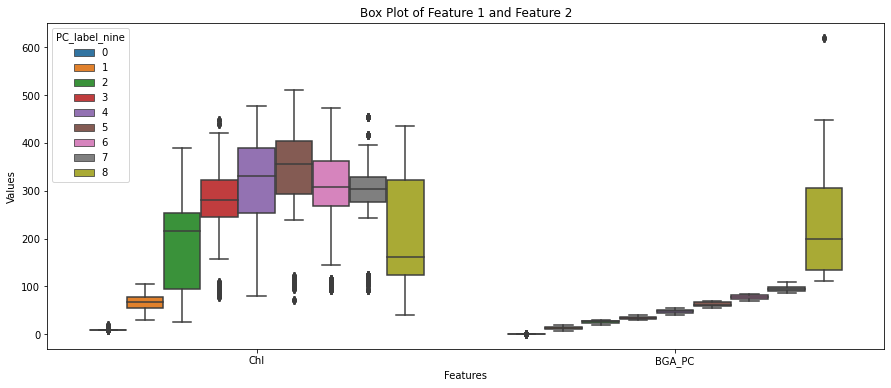

In [37]:
df_PC = pd.read_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\tables\df_PC_chl_fixed1.csv')

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named 'data' with two columns: 'feature1' and 'feature2'

# Set the figure size
plt.figure(figsize=(15, 6))
# Create the Seaborn plot
# pd.melt(frame =df_PC, id_vars=['cat_label'], value_vars=df_PC[['Chl', 'BGA_PC']],hue='cat_label')
sns.boxplot(x="variable", y="value", data=pd.melt(frame =df, id_vars=['PC_label_nine'], value_vars=df_PC[['Chl', 'BGA_PC']]),hue='PC_label_nine')
# Set labels and title

plt.xlabel('Features')
plt.ylabel('Probe level measured')
plt.title('Box Plot of Feature 1 and Feature 2')

# Show the plot
plt.show()

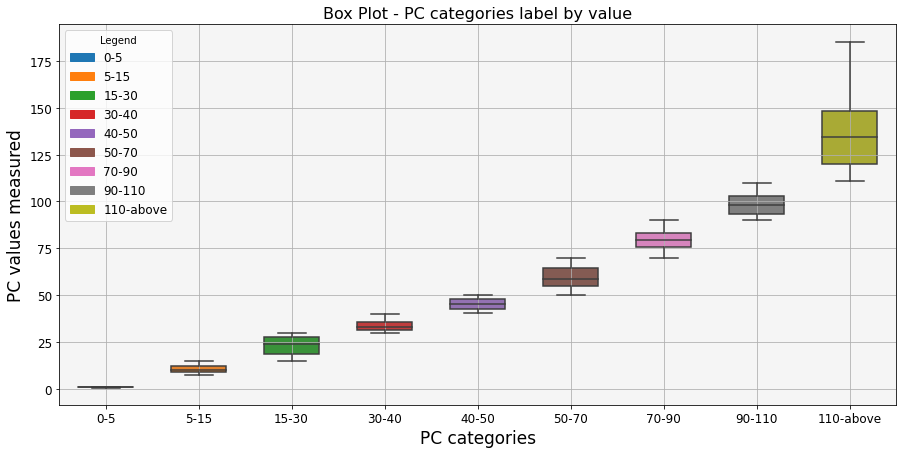

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

ranges2 = [0, 5, 15, 30, 40, 50, 70, 90, 110, float('inf')]
labels_cat2 = [0, 1, 2, 3, 4, 5, 6, 7, 8]
df['PC_label_nine'] = pd.cut(df['BGA_PC'], bins=ranges2, labels=labels_cat2, right=False)

# Filter the DataFrame
filtered_df = df[df['BGA_PC'] < 200]

# Custom labels for the x-axis
custom_labels = ['0-5', '5-15', '15-30', '30-40', '40-50', '50-70', '70-90', '90-110', '110-above']

# Create a single box plot with custom labels
plt.figure(figsize=(15, 7))
sns.boxplot(x='PC_label_nine', y='BGA_PC', data=filtered_df, width=0.6, showfliers=False)
plt.xlabel('PC categories', fontsize=17)  # Adjust label size
plt.ylabel('PC values measured', fontsize=17)  # Adjust label size
plt.title('Box Plot - PC categories label by value', fontsize=16)  # Adjust title size

# Customize the x-axis ticks and labels
plt.xticks(labels_cat2, custom_labels, fontsize=12)  # Adjust tick label size
plt.yticks(fontsize=12)  # Adjust tick label size

# Create custom legend handles
legend_handles = [Patch(color=sns.color_palette()[i], label=label) for i, label in enumerate(custom_labels)]

# Add the legend with custom handles
plt.legend(handles=legend_handles, title='Legend', loc='upper left', fontsize=12)  # Adjust legend label size

# Add a background color
plt.gca().set_facecolor('#F5F5F5')
plt.grid(True)
# Show the plot
plt.show()

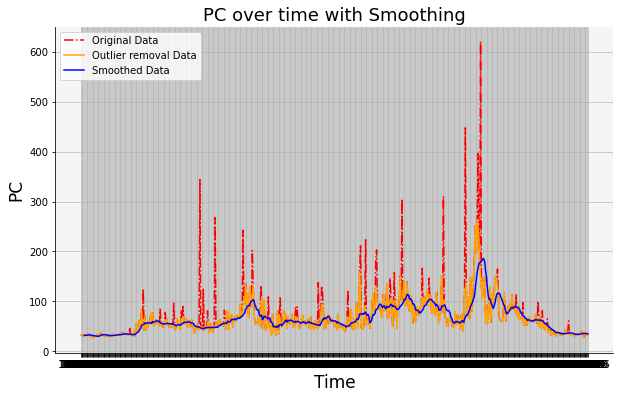

In [169]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original and smoothed data
ax.plot(df2['Time'], df2['BGA-PC ug/L'], label='Original Data', color='red', linestyle='dashdot')
ax.plot(df3['Time'], df3['BGA-PC ug/L'], label='Outlier removal Data', color='orange', linestyle='-')
ax.plot(df3['Time'], df3['Smoothed'], label='Smoothed Data', color='blue')

# Add title and labels
ax.set_title('PC over time with Smoothing',fontsize=18)
ax.set_xlabel('Time',fontsize=17)
ax.set_ylabel('PC',fontsize=17)
ax.legend()

# Add grid lines and customize appearance
ax.grid(True, linestyle='-', alpha=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a background color
ax.set_facecolor('#F5F5F5')

# Show the plot
plt.show()

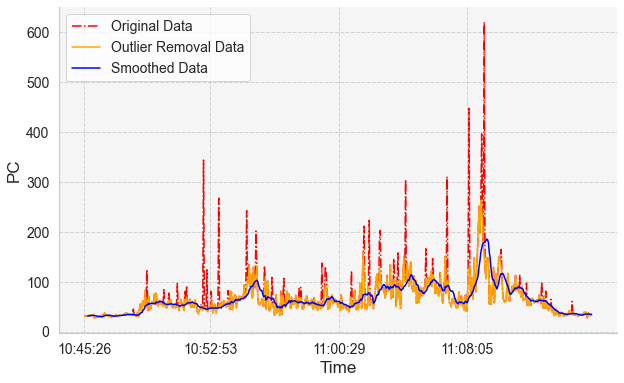

In [315]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original and smoothed data
ax.plot(df2['Time'], df2['BGA-PC ug/L'], label='Original Data', color='red', linestyle='dashdot')
ax.plot(df3['Time'], df3['BGA-PC ug/L'], label='Outlier Removal Data', color='orange', linestyle='-')
ax.plot(df3['Time'], df3['Smoothed'], label='Smoothed Data', color='blue')

# Add title and labels
# ax.set_title('PC measured over time with smoothing process', fontsize=18)
ax.set_xlabel('Time', fontsize=17)
ax.set_ylabel('PC', fontsize=17)

# Customize legend appearance
legend = ax.legend(fontsize=14)

# Set the x-axis ticks to show only 4 of them
x_ticks = df3['Time'][::len(df3['Time']) // 4]
ax.set_xticks(x_ticks)
# Customize the x-axis ticks and labels
# plt.xticks(labels_cat2, custom_labels, fontsize=14)  # Adjust tick label size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# Add grid lines and customize appearance
ax.grid(True, linestyle='--', alpha=0.9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a background color
ax.set_facecolor('#F5F5F5')

# Show the plot
plt.show()

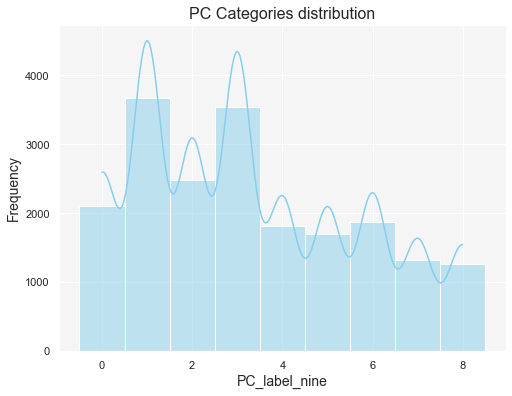

In [179]:

# Create a distribution plot using seaborn
sns.set(style="darkgrid")  # Set style
plt.figure(figsize=(8, 6))  # Set figure size

# Create the distribution plot
sns.histplot(df,x='PC_label_nine' ,bins=9, kde=True, color='skyblue')

# Customize the appearance
plt.title('PC Categories distribution', fontsize=16)
plt.xlabel('PC_label_nine', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Add a background color
plt.gca().set_facecolor('#F5F5F5')
plt.grid(True)
# Show the plot
plt.show()


# Early work - exploring ranges to decide on Categories number and range

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def split_ranges(df,upper_lim = None,low_lim = None,col =1,min_cat = 6):
    value_min = low_lim if low_lim is not None else 0
    col_name = 'BGA_PC' if col==1 else 'Chl'
    df_grouped = df.copy()
    if upper_lim is not None:
        df_grouped[col_name][df_grouped[col_name] > 115] = 115
    seperate_lim = 5 if low_lim is None else low_lim  
    df_grouped_low = df_grouped[df_grouped[col_name] <= seperate_lim].copy()
    df_grouped_high_all = df_grouped[df_grouped[col_name] > seperate_lim].copy() if low_lim is not None else df_grouped.copy()
        
    group_ranges = {}
    group_labels = {}
    group_category = {}
    
    subplots_per_row = 2
    num_plots = 6
    num_rows = int(np.ceil(num_plots / subplots_per_row))
    fig, axs = plt.subplots(num_rows, subplots_per_row, figsize=(15, 5 * num_rows))
    dfs = {}
    col_lable = f'{col_name}_L'#f'PC_{n_cat + 1}_quan_labels'
    col_category = f'{col_name}_C'#f'PC_{n_cat + 1}_quan_category'
    for i,n_cat in enumerate(range(min_cat, min_cat+3)):
        
        for t in ['quantile','range']:
            df_grouped_high = df_grouped_high_all.copy()
            if t=='quantile':
                ax = axs.flat[i*2]
                groups, bins = pd.qcut(df_grouped_high[col_name], n_cat, retbins=True)
                
            else:
                # Compute the range of the values
                ax = axs.flat[i*2+1]
                num_groups = n_cat
                
                value_max = df_grouped_high[col_name].max()
                value_range = value_max - value_min
                # Calculate the width of each group
                group_width = value_range / num_groups
                groups,bins = pd.cut(df_grouped_high[col_name], bins=num_groups,retbins=True)

                
            group_ranges[n_cat] = [(value_min, bins[i + 1]) if i == 0 else (bins[i], bins[i + 1]) for i in range(len(bins) - 1)]
            group_labels[n_cat] = ['{:.1f} - {:.1f}'.format(group_ranges[n_cat][i][0], group_ranges[n_cat][i][1]) for i in range(len(group_ranges[n_cat]))]
            group_category[n_cat] = [i + 1 for i in range(len(group_ranges[n_cat]))]
            df_grouped_high[col_lable] = groups.cat.rename_categories(group_labels[n_cat])
            df_grouped_high[col_category] = groups.cat.rename_categories(group_category[n_cat])
            df_grouped_low[col_lable] = '0-5' if low_lim is None else f'0-{low_lim}'
            df_grouped_low[col_category] = 0

            df_equal = pd.concat([df_grouped_low, df_grouped_high]) if low_lim is not None else df_grouped_high
            dfs[f'{t}_{n_cat}'] = df_equal
            sns.histplot(df_equal[col_name], kde=True, ax=ax)
            if low_lim is not None:
                ax.axvline(low_lim, 0, 0.5, color=(np.random.rand(1, 1)[0][0], np.random.rand(1, 1)[0][0], np.random.rand(1, 1)[0][0]), label=str(low_lim))
                [ax.axvline(bins[i], 0, 0.5, color=(np.random.rand(1, 1)[0][0], np.random.rand(1, 1)[0][0], np.random.rand(1, 1)[0][0]), label=bins[i]) for i in range(1, len(bins))]
            else:
                [ax.axvline(bins[i], 0, 0.5, color=(np.random.rand(1, 1)[0][0], np.random.rand(1, 1)[0][0], np.random.rand(1, 1)[0][0]), label=bins[i]) for i in range(0, len(bins))]

            ax.set_title(f'{n_cat } categories - {t}')
            ax.legend()


            plt.tight_layout()
    return dfs



ModuleNotFoundError: No module named 'seaborn'

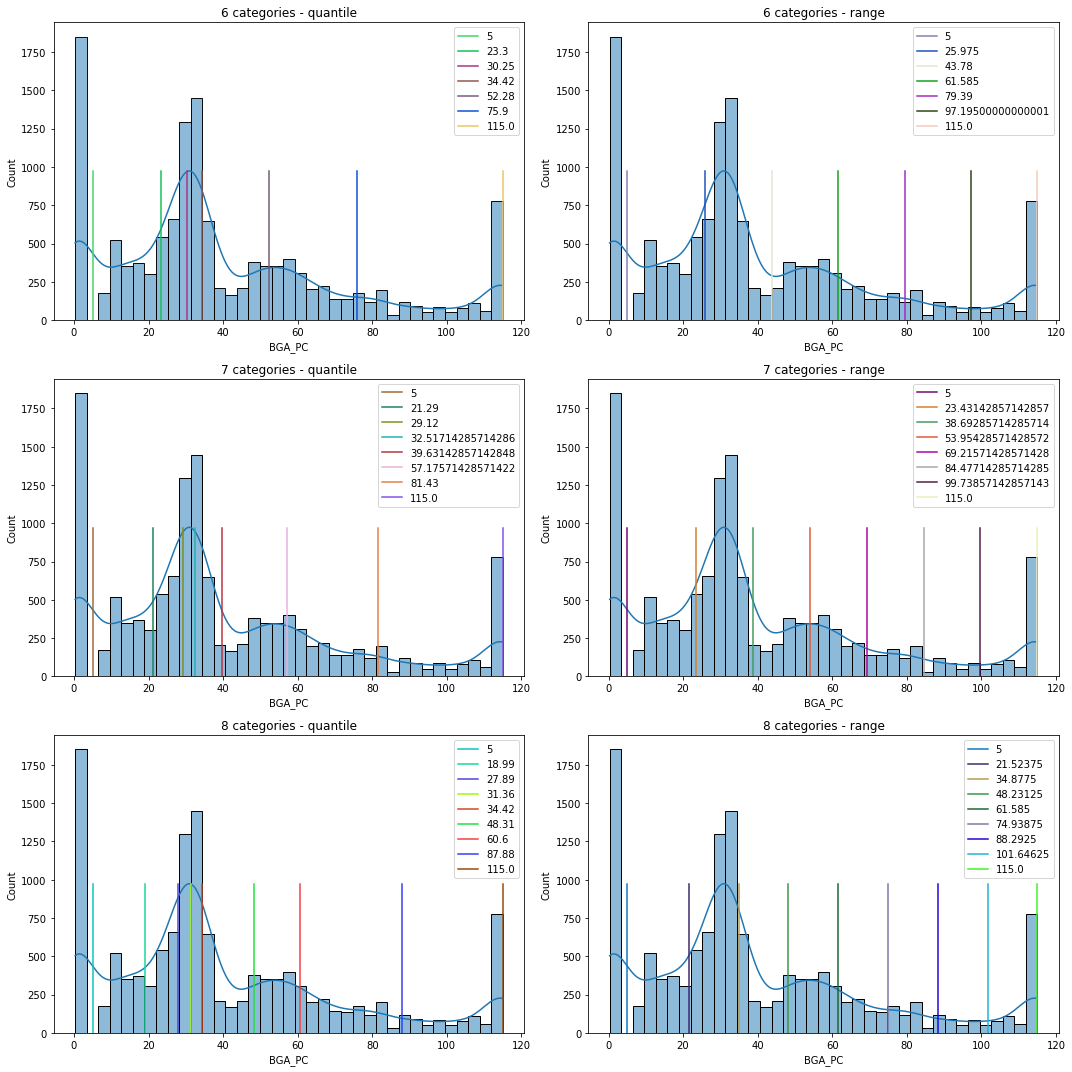

In [55]:
dfs = split_ranges(df)

In [60]:
dfs['quantile_6']['PC_C'].value_counts(),dfs['quantile_7']['PC_C'].value_counts(),dfs['quantile_8']['PC_C'].value_counts()

(1    1898
 4    1893
 3    1890
 5    1887
 2    1882
 6    1881
 0    1851
 Name: PC_C, dtype: int64,
 0    1851
 6    1623
 1    1623
 4    1619
 2    1618
 5    1618
 3    1615
 7    1615
 Name: PC_C, dtype: int64,
 0    1851
 1    1424
 6    1421
 3    1419
 8    1416
 4    1414
 2    1413
 5    1412
 7    1412
 Name: PC_C, dtype: int64)

In [813]:
dfs.keys()

dict_keys(['quantile_6', 'range_6', 'quantile_7', 'range_7', 'quantile_8', 'range_8'])

In [814]:
dfs['quantile_6']

SRTCNT  tempature   mmHg     DO  SPC_uS    pH  ORP_mV  BGA_PC    Chl  \
40712    2290     25.754  758.7   93.1   519.0  6.89   271.1    0.31  19.62   
40714    2292     25.754  758.7   93.1   519.0  6.89   271.1    0.31  19.62   
40707    2285     25.754  758.7   93.1   519.0  6.89   271.1    0.31  19.62   
40693    2271     25.754  758.7   93.1   519.0  6.89   271.1    0.31  19.62   
40721    2299     25.754  758.7   93.1   519.0  6.89   271.1    0.31  19.62   
...       ...        ...    ...    ...     ...   ...     ...     ...    ...   
9868     2195     19.872  761.5  152.6  1222.0  8.95   216.0   13.72  98.80   
0           1     19.441  763.0  132.8  1224.0  8.64   260.5    9.38  69.31   
2           3     19.441  763.0  132.8  1224.0  8.64   260.5    9.38  69.31   
3           4     19.441  763.0  132.8  1224.0  8.64   260.5    9.38  69.31   
1           2     19.441  763.0  132.8  1224.0  8.64   260.5    9.38  69.31   

         DEP  ...                                      drone_vid_dir  \
40712  0.340  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
40714  0.340  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
40707  0.340  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
40693  0.340  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
40721  0.340  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
...      ...  ...                                                ...   
9868   0.377  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
0      0.345  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
2      0.345  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
3      0.345  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   
1      0.345  ...  C:\Users\urial\OneDrive - BlueGreen Water Tech...   

       SRTCNT_y        unique_id cat_range cat_label Chl_label  Chl_range  \
40712        30  2290_1637054405       0_5         0         0       0-30   
40714        30  2292_1637054405       0_5         0         0       0-30   
40707        30  2285_1637054405       0_5         0         0       0-30   
40693        30  2271_1637054405       0_5         0         0       0-30   
40721        30  2299_1637054405       0_5         0         0       0-30   
...         ...              ...       ...       ...       ...        ...   
9868         30  2195_1638785156      6_15         1         1     31-100   
0             4     1_1638777534      6_15         1         1     31-100   
2             4     3_1638777534      6_15         1         1     31-100   
3             4     4_1638777534      6_15         1         1     31-100   
1             4     2_1638777534      6_15         1         1     31-100   

      Chl_mean_value PC_7_quan_labels  PC_7_quan_category  
40712       8.991990              0-5                 0.0  
40714       8.991990              0-5                 0.0  
40707       8.991990              0-5                 0.0  
40693       8.991990              0-5                 0.0  
40721       8.991990              0-5                 0.0  
...              ...              ...                 ...  
9868       79.378042              NaN                 NaN  
0          79.378042              NaN                 NaN  
2          79.378042              NaN                 NaN  
3          79.378042              NaN                 NaN  
1          79.378042              NaN                 NaN  

[13384 rows x 25 columns]

In [754]:
df_grouped_high_range['PC_7_labels']

15710    43.8 - 61.6
15708    43.8 - 61.6
15712    43.8 - 61.6
15723    43.8 - 61.6
15698    43.8 - 61.6
            ...     
9868      5.1 - 26.0
0         5.1 - 26.0
2         5.1 - 26.0
3         5.1 - 26.0
1         5.1 - 26.0
Name: PC_7_labels, Length: 11434, dtype: category
Categories (6, object): ['5.1 - 26.0' < '26.0 - 43.8' < '43.8 - 61.6' < '61.6 - 79.4' < '79.4 - 97.2' < '97.2 - 115.0']

In [ ]:
df_grouped = df_PC_chl_fixed.copy()
# Choose the number of groups
num_groups = 9

# Split values into groups based on quantiles
groups, bins = pd.qcut(df_PC_chl['Chl'], q=num_groups, retbins=True)

# Calculate the range value for each group
group_ranges = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

# Assign group labels with range values
group_labels = ['Group {}: {:.2f} - {:.2f}'.format(i+1, group_ranges[i][0], group_ranges[i][1]) for i in range(len(group_ranges))]

# Assign group labels to the DataFrame
df_PC_chl['chl_cat'] = groups.cat.rename_categories(group_labels)
df_PC_chl['chl_range'] = groups.cat.rename_categories(group_labels)

# # Split values into groups based on quantiles
# df_PC_chl['chl_group'] = pd.qcut(df_PC_chl['Chl'], q=num_groups, labels=False)

# View the| data with assigned groups


In [ ]:
df_PC_chl = df_PC.copy()
# Define the array of ranges
ranges1 = [0, 30, 100, 220, 280, 320, 370, float('inf')]
ranges1 = [0, 30, 100, 220, 280, 320, 370, float('inf')]
ranges1 = [0, 30, 100, 220, 280, 320, 370, float('inf')]
ranges1 = [0, 30, 100, 220, 280, 320, 370, float('inf')]

# Define the corresponding labels for the categories
labels_range = ['0-30', '31-100', '101-220', '221-280', '281-320', '321-370', '371-above']
labels_cat = [0, 1, 2, 3, 4, 5, 6]
# Use pd.cut() to categorize the values
df_PC_chl['Chl_label'] = pd.cut(df_PC['Chl'], bins=ranges, labels=labels_cat, right=False)
# Use pd.cut() to categorize the values
df_PC_chl['Chl_range'] = pd.cut(df_PC['Chl'], bins=ranges, labels=labels_range, right=False)

# Calculate the mean value for each category
df_PC_chl['Chl_mean_value'] = df_PC_chl.groupby('Chl_range')['Chl'].transform('mean')

# Print the updated DataFrame
df_PC_chl

## split the data and export to csv files

### split df to seperate seconds

##### inspect data

In [180]:
import pandas as pd
outlier_df = pd.read_csv(r'C:\Users\urial\BG\AlphaBravo\samples\tables\outlier_df.csv')

In [181]:
# df_PC_chl.to_csv(r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered\df_pc_chl.csv')
# in case the df was grouped and we need to compare according to files in folder
from os import walk
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat'
mypath= r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered'
# mypath = r'C:\Users\urial\BG\AlphaBravo\samples\samples_centered_cat\clean\trans'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
row = [x.split('.')[0] for x in f]
# new_df = outlier_df[outlier_df['unique_id'].isin(row)]

In [182]:
new_df = outlier_df[outlier_df['unique_id'].isin(row)]
new_df.shape

(19536, 18)

#### split ranges CHL

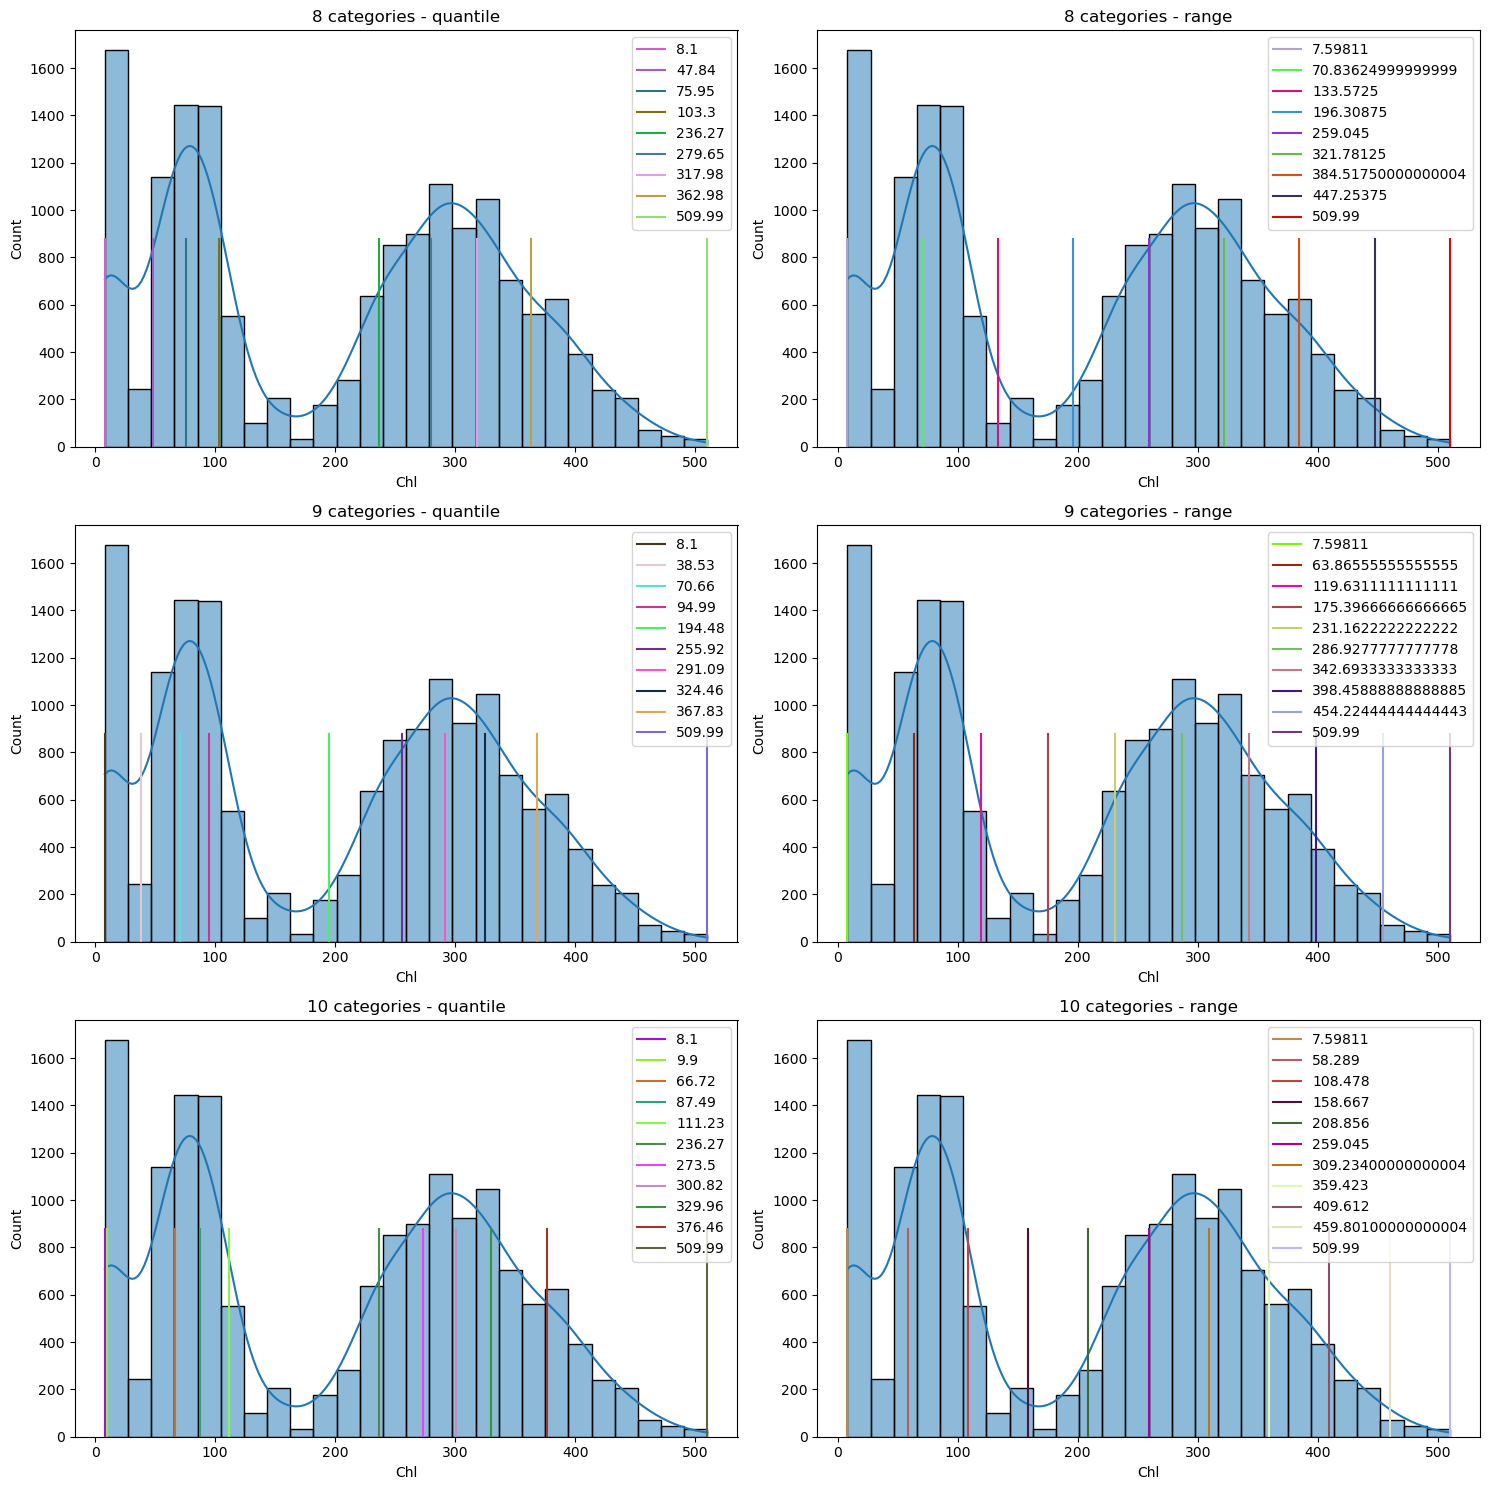

In [97]:
dfs = split_ranges(train_df_range,col=2,min_cat=8)

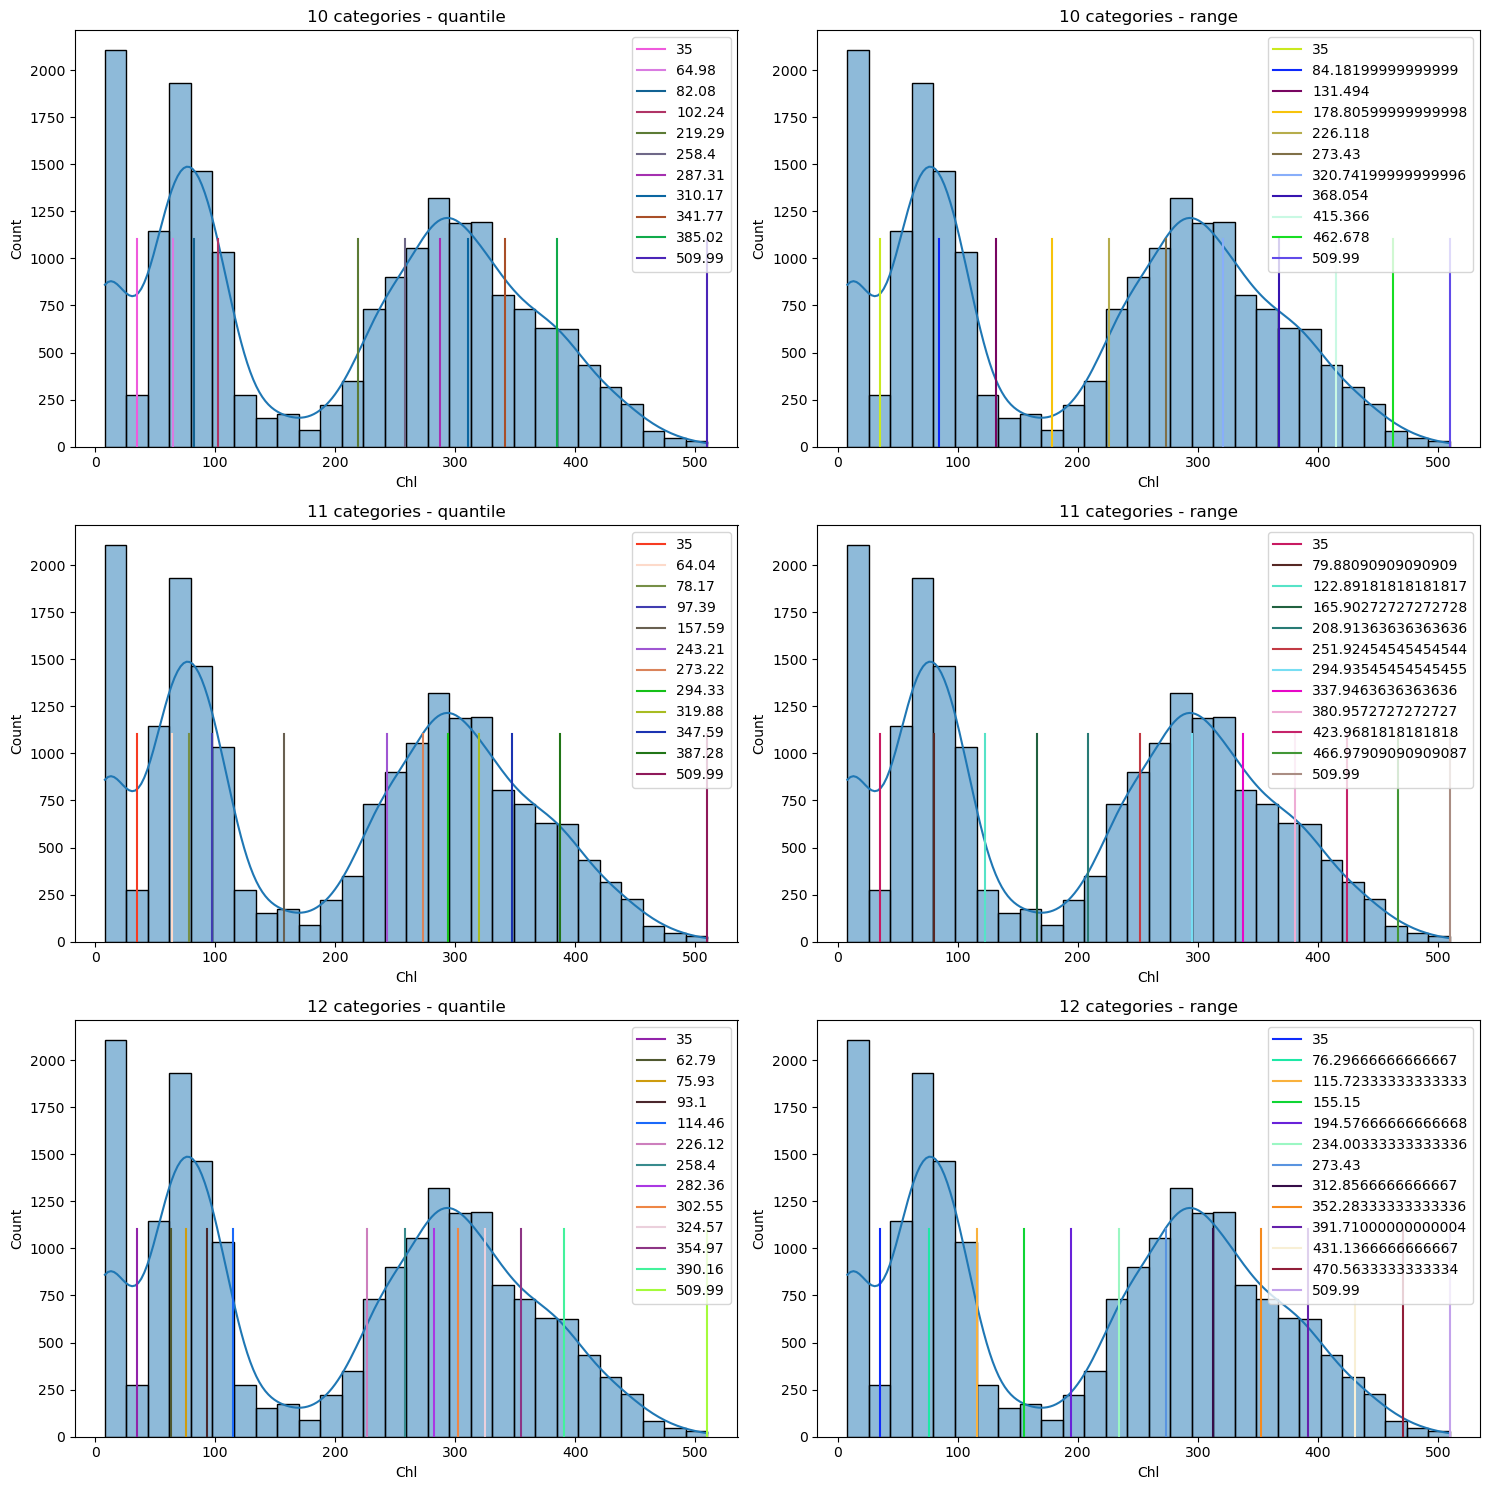

In [111]:
dfs = split_ranges(new_df,col=2,min_cat=10,low_lim=35)

In [30]:
import cv2
import numpy as np
import ruptures as rpt


# Define the number of histogram bins
num_bins = 256

# Calculate color histograms for each image
histograms = []
image_ranges = []

for path in image_paths:
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image: {path}")
        continue
    if image.ndim != 3 or image.shape[2] != 3:  # Invalid image format
        print(f"Invalid image format: {path}")
        continue
    hist, _ = np.histogram(image.reshape(-1, 3), bins=num_bins, range=(0, 256))
    hist = hist.astype(float)
    hist /= np.sum(hist)  # Normalize the histogram
    histograms.append(hist)

# Convert histograms to numpy array
histograms = np.array(histograms)

# Perform changepoint detection using the Pelt algorithm
model = rpt.Dynp(model="rbf").fit(histograms)
result = model.predict(6)#pen=100)

# Extract the change point locations
change_locations = result[:-1]

# Determine the ranges based on the change points
ranges = []
prev_idx = 0
for idx in change_locations:
    ranges.append((prev_idx, idx))
    prev_idx = idx + 1
ranges.append((prev_idx, len(image_paths)))

# Assign each image with its corresponding range
for i, (start, end) in enumerate(ranges):
    image_range = f"[{start}-{end-1}]"
    image_indices = list(range(start, end))
    image_ranges.extend([(path, image_range) for path in image_paths[start:end]])

# Print the resulting ranges for each image
for image_path, image_range in image_ranges:
    print(f"Image {image_path} belongs to range {image_range}")


Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\109_1638259686.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\112_1637053460.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\114_1637054042.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\114_1638785087.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\115_1637053460.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\115_1638259977.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\116_1637053751.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\117_1637054333.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\118_1637053460.jpg belongs to range [0-24]
Image C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\119_1638785087.jpg belongs to range [0-24]


In [32]:
import cv2
import numpy as np
import os
import shutil
import ruptures as rpt


# Define the number of histogram bins
num_bins = 256

# Calculate color histograms for each image
histograms = []
image_ranges = []

for path in image_paths:
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image: {path}")
        continue
    if image.ndim != 3 or image.shape[2] != 3:  # Invalid image format
        print(f"Invalid image format: {path}")
        continue
    hist, _ = np.histogram(image.reshape(-1, 3), bins=num_bins, range=(0, 256))
    hist = hist.astype(float)
    hist /= np.sum(hist)  # Normalize the histogram
    histograms.append(hist)

# Convert histograms to numpy array
histograms = np.array(histograms)

# Perform changepoint detection using the Pelt algorithm
model = rpt.Dynp(model="rbf").fit(histograms)
result = model.predict(6)#pen=100)

# Extract the change point locations
change_locations = result[:-1]

# Determine the ranges based on the change points
ranges = []
prev_idx = 0
for idx in change_locations:
    ranges.append((prev_idx, idx))
    prev_idx = idx + 1
ranges.append((prev_idx, len(image_paths)))

# Create folders for each range and move corresponding images
for i, (start, end) in enumerate(ranges):
    folder_name = f"Range_{start}-{end-1}"
    folder_path = os.path.join(r'C:\Users\urial\BG\AlphaBravo\samples\kayak_samples', folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    for j in range(start, end):
        image_path = image_paths[j]
        image_name = os.path.basename(image_path)
        new_image_path = os.path.join(folder_path, image_name)
        shutil.move(image_path, new_image_path)
        print(f"Moved {image_path} to {new_image_path}")


Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\109_1638259686.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\109_1638259686.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\112_1637053460.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\112_1637053460.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\114_1637054042.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\114_1637054042.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\114_1638785087.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\114_1638785087.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\115_1637053460.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\115_1637053460.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\115_1638259977.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\115_1638259977.jpg
Moved C:\Users\urial\BG\AlphaBravo\sampl

In [36]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()  # Set the model to evaluation mode

# # Define the image paths
# image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']

# Preprocess the images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract features for each image
features = []
for path in image_paths:
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image: {path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
    pil_image = Image.fromarray(image)  # Convert NumPy array to PIL Image
    pil_image = preprocess(pil_image)  # Preprocess the image
    image = torch.unsqueeze(pil_image, 0)  # Add batch dimension
    with torch.no_grad():
        feature = model(image)
        feature = torch.flatten(feature, start_dim=1).numpy()
        features.append(feature)

# Convert features to numpy array
features = np.array(features)


# Perform changepoint detection using the Pelt algorithm
model = rpt.Dynp(model="rbf").fit(features)
result = model.predict(6)#pen=100)

# Extract the change point locations
change_locations = result[:-1]

# Determine the ranges based on the change points
ranges = []
prev_idx = 0
for idx in change_locations:
    ranges.append((prev_idx, idx))
    prev_idx = idx + 1
ranges.append((prev_idx, len(image_paths)))

# Create folders for each range and move corresponding images
for i, (start, end) in enumerate(ranges):
    folder_name = f"Range_{start}-{end-1}"
    folder_path = os.path.join(r'C:\Users\urial\BG\AlphaBravo\samples\kayak_samples', folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    for j in range(start, end):
        image_path = image_paths[j]
        image_name = os.path.basename(image_path)
        new_image_path = os.path.join(folder_path, image_name)
        shutil.move(image_path, new_image_path)
        print(f"Moved {image_path} to {new_image_path}")

ValueError: A 2-dimensional array must be passed.

In [39]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import ruptures as rpt


# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()  # Set the model to evaluation mode


# Preprocess the images
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract features for each image
features = []
for path in image_paths:
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image: {path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
    pil_image = Image.fromarray(image)  # Convert NumPy array to PIL Image
    pil_image = preprocess(pil_image)  # Preprocess the image
    image = torch.unsqueeze(pil_image, 0)  # Add batch dimension
    with torch.no_grad():
        feature = model(image)
        feature = torch.flatten(feature, start_dim=1).numpy()
        features.append(feature)

# Convert features to numpy array
features = np.array(features)

# Reshape features to 2-dimensional array
features = features.reshape(features.shape[0], -1)

# Perform change point detection using the features
model = rpt.Dynp(model="rbf").fit(features)
result = model.predict(6)  # Change point detection with 6 breakpoints

# Extract the change point locations
change_locations = result[:-1]

# Determine the ranges based on the change points
ranges = []
prev_idx = 0
for idx in change_locations:
    ranges.append((prev_idx, idx))
    prev_idx = idx + 1
ranges.append((prev_idx, len(image_paths)))

# Create folders for each range and move corresponding images
for i, (start, end) in enumerate(ranges):
    folder_name = f"Range_{start}-{end-1}"
    folder_path = os.path.join(r'C:\Users\urial\BG\AlphaBravo\samples\kayak_samples', folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    for j in range(start, end):
        image_path = image_paths[j]
        image_name = os.path.basename(image_path)
        new_image_path = os.path.join(folder_path, image_name)
        shutil.move(image_path, new_image_path)
        print(f"Moved {image_path} to {new_image_path}")

Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\109_1638259686.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\109_1638259686.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\112_1637053460.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\112_1637053460.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\114_1637054042.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\114_1637054042.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\114_1638785087.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\114_1638785087.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\115_1637053460.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\115_1637053460.jpg
Moved C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\115_1638259977.jpg to C:\Users\urial\BG\AlphaBravo\samples\kayak_samples\Range_0-24\115_1638259977.jpg
Moved C:\Users\urial\BG\AlphaBravo\sampl